In [1]:
import torch as tc 
import torch.nn as nn  
import numpy as np
from tqdm import tqdm
import os,sys,cv2
from torch.cuda.amp import autocast
import matplotlib.pyplot as plt
import albumentations as A
import segmentation_models_pytorch as smp
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torch.nn.parallel import DataParallel
from glob import glob
import tifffile as tiff

In [10]:
import sys
sys.path.append('../../')
import util

log_board = util.diagnostics.LogBoard('log_dir', 6005)
log_board.launch()

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

E0205 02:52:18.114851 140156227277440 program.py:298] TensorBoard could not bind to port 6005, it was already in use
ERROR: TensorBoard could not bind to port 6005, it was already in use


In [2]:
p_augm = 0.05 #0.5
#add rotate.  less p_augm

class CFG:
    # ============== pred target =============
    target_size = 1

    # ============== model CFG =============
    model_name = 'Unet'
    backbone = 'mit_b2'

    in_chans = 3   #5 # 65
    # ============== training CFG =============
    image_size = 1024  
    input_size = 1024

    train_batch_size = 4 #4 #16
    valid_batch_size = 4

    epochs = 31 #30 #25
    lr = 8e-5
    chopping_percentile=1e-3
    # ============== fold =============
    valid_id = 1


    # ============== augmentation =============
    train_aug_list = [
        A.Rotate(limit=270, p= 0.5),
        A.RandomScale(scale_limit=(0.8,1.25),interpolation=cv2.INTER_CUBIC,p=p_augm),
        A.RandomCrop(input_size, input_size,p=1),
        A.RandomGamma(p=p_augm*2/3),
        A.RandomBrightnessContrast(p=p_augm,),
        A.GaussianBlur(p=p_augm),
        A.MotionBlur(p=p_augm),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=p_augm),
        ToTensorV2(transpose_mask=True),
    ]
    train_aug = A.Compose(train_aug_list)
    valid_aug_list = [
        ToTensorV2(transpose_mask=True),
    ]
    valid_aug = A.Compose(valid_aug_list)

In [3]:
class CustomModel(nn.Module):
    def __init__(self, CFG, weight=None):
        super().__init__()
        self.model = smp.Unet(
            encoder_name=CFG.backbone, 
            encoder_weights=weight,
            in_channels=CFG.in_chans,
            classes=CFG.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.model(image)
        # output = output.squeeze(-1)
        return output[:,0]#.sigmoid()


def build_model(weight="imagenet"):
    from dotenv import load_dotenv
    load_dotenv()

    print('model_name', CFG.model_name)
    print('backbone', CFG.backbone)

    model = CustomModel(CFG, weight)

    return model.cuda()

In [4]:
def to_1024(img , image_size = 1024):
    if image_size > img.shape[1]:
       img = np.rot90(img)
       start1 = (CFG.image_size - img.shape[0])//2 
       top =     img[0                    : start1,   0: img.shape[1] ]
       bottom  = img[img.shape[0] -start1 : img.shape[0],   0 : img.shape[1] ]
       img_result = np.concatenate((top,img,bottom ),axis=0)
       img_result = np.rot90(img_result)
       img_result = np.rot90(img_result)
       img_result = np.rot90(img_result)
    else :
       img_result = img
    return img_result

def to_1024_no_rot(img, image_size = 1024):
    if image_size > img.shape[0]:  
       start1 = ( image_size - img.shape[0])//2
       top =     img[0                    : start1,   0: img.shape[1] ]
       bottom  = img[img.shape[0] -start1 : img.shape[0],   0 : img.shape[1] ]
       img_result = np.concatenate((top,img,bottom ),axis=0)
    else: 
       img_result = img
    return img_result

#  add border
def to_1024_1024(img  , image_size = 1024 ):
     img_result = to_1024(img, image_size )
     return img_result
    
#  drop border
def to_original ( im_after, img, image_size = 1024 ):
    top_ = 0
    left_ = 0
    if (im_after.shape[0] > img.shape[0]):
             top_  = ( image_size - img.shape[0])//2 
    if    (im_after.shape[1] > img.shape[1]) :
             left_  = ( image_size - img.shape[1])//2  
    if (top_>0)or (left_>0) :
             img_result = im_after[top_                    : img.shape[0] + top_,   left_: img.shape[1] + left_ ]
             #print(im_after.shape,'-->',img_result.shape)
    else:
             img_result = im_after
    return img_result  

In [5]:
def min_max_normalization(x:tc.Tensor)->tc.Tensor:
    """input.shape=(batch,f1,...)"""
    shape=x.shape
    if x.ndim>2:
        x=x.reshape(x.shape[0],-1)
    
    min_=x.min(dim=-1,keepdim=True)[0]
    max_=x.max(dim=-1,keepdim=True)[0]
    if min_.mean()==0 and max_.mean()==1:
        return x.reshape(shape)
    
    x=(x-min_)/(max_-min_+1e-9)
    return x.reshape(shape)

def norm_with_clip(x:tc.Tensor,smooth=1e-5):
    dim=list(range(1,x.ndim))
    mean=x.mean(dim=dim,keepdim=True)
    std=x.std(dim=dim,keepdim=True)
    x=(x-mean)/(std+smooth)
    x[x>5]=(x[x>5]-5)*1e-3 +5
    x[x<-3]=(x[x<-3]+3)*1e-3-3
    return x

def add_noise(x:tc.Tensor,max_randn_rate=0.1,randn_rate=None,x_already_normed=False):
    """input.shape=(batch,f1,f2,...) output's var will be normalizate  """
    ndim=x.ndim-1
    if x_already_normed:
        x_std=tc.ones([x.shape[0]]+[1]*ndim,device=x.device,dtype=x.dtype)
        x_mean=tc.zeros([x.shape[0]]+[1]*ndim,device=x.device,dtype=x.dtype)
    else: 
        dim=list(range(1,x.ndim))
        x_std=x.std(dim=dim,keepdim=True)
        x_mean=x.mean(dim=dim,keepdim=True)
    if randn_rate is None:
        randn_rate=max_randn_rate*np.random.rand()*tc.rand(x_mean.shape,device=x.device,dtype=x.dtype)
    cache=(x_std**2+(x_std*randn_rate)**2)**0.5
    #https://blog.csdn.net/chaosir1991/article/details/106960408
    
    return (x-x_mean+tc.randn(size=x.shape,device=x.device,dtype=x.dtype)*randn_rate*x_std)/(cache+1e-7)
 
class Data_loader(Dataset):
     
    def __init__(self,paths,is_label):
        self.paths=paths
        self.paths.sort()
        self.is_label=is_label
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self,index):
         
        img = cv2.imread(self.paths[index],cv2.IMREAD_GRAYSCALE)
        
        img = to_1024_1024(img , image_size = CFG.image_size ) #  to_original( im_after, img_save, image_size = 1024)

        img = tc.from_numpy(img.copy())
        if self.is_label:
            img=(img!=0).to(tc.uint8)*255
        else:
            img=img.to(tc.uint8)
        return img

def load_data(paths,is_label=False):
    data_loader=Data_loader(paths,is_label)
    data_loader=DataLoader(data_loader, batch_size=8, num_workers=2)  
    data=[]
    for x in tqdm(data_loader):
        data.append(x)
    x=tc.cat(data,dim=0)
    del data
    if not is_label:
        ########################################################################
        TH=x.reshape(-1).numpy()
        index = -int(len(TH) * CFG.chopping_percentile)
        TH:int = np.partition(TH, index)[index]
        x[x>TH]=int(TH)
        ########################################################################
        TH=x.reshape(-1).numpy()
        index = -int(len(TH) * CFG.chopping_percentile)
        TH:int = np.partition(TH, -index)[-index]
        x[x<TH]=int(TH)
        ########################################################################
        x=(min_max_normalization(x.to(tc.float16)[None])[0]*255).to(tc.uint8)
    return x


#https://www.kaggle.com/code/kashiwaba/sennet-hoa-train-unet-simple-baseline
def dice_coef(y_pred:tc.Tensor,y_true:tc.Tensor, thr=0.5, dim=(-1,-2), epsilon=0.001):
    #y_pred=y_pred.sigmoid()
    y_true = y_true.to(tc.float32)
    y_pred = (y_pred>thr).to(tc.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean()
    return dice

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = inputs.sigmoid()   
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

class SurfaceDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SurfaceDiceLoss, self).__init__()

    def forward(self, pred, surface_true, volume_true, smooth=1, k_size=3):
        pred = pred.sigmoid()
        surface_pred = pred * surface_true
        volume_pred = pred * volume_true
      
        surface_pred = surface_pred.view(-1)
        surface_true = surface_true.view(-1)
        volume_pred = volume_pred.view(-1)
        volume_true = volume_true.view(-1)
        
        surface_intersection = (surface_pred * surface_true).sum()
        volume_intersection = (volume_pred * volume_true).sum()

        surface_dice = (2. * (surface_intersection + (0.35*volume_intersection)) + smooth) / (surface_pred.sum() + surface_true.sum() + (0.35*volume_pred.sum()) + (0.35*volume_true.sum()) + smooth)

        return 1 - surface_dice


class Kaggld_Dataset(Dataset):
    def __init__(self,x:list,y:list,arg=False):
        super(Dataset,self).__init__()
        self.x=x#list[(C,H,W),...]
        self.y=y#list[(C,H,W),...]
        self.image_size=CFG.image_size
        self.in_chans=CFG.in_chans
        self.arg=arg
        if arg:
            self.transform=CFG.train_aug
        else: 
            self.transform=CFG.valid_aug

    def __len__(self) -> int:
        return sum([y.shape[0]-self.in_chans for y in self.y])
    
    def __getitem__(self,index):
        i=0
        for x in self.x:
            if index>x.shape[0]-self.in_chans:
                index-=x.shape[0]-self.in_chans
                i+=1
            else:
                break
        x=self.x[i]
        y=self.y[i]
        
        print (f'x.shape[1] ={x.shape[1]}    x.shape[2]={x.shape[2]}')
        
        x_index= (x.shape[1]-self.image_size)//2 #np.random.randint(0,x.shape[1]-self.image_size)
        y_index= (x.shape[2]-self.image_size)//2 # np.random.randint(0,x.shape[2]-self.image_size)
        # i i+5 
        x=x[index:index+self.in_chans   ,   x_index:x_index+self.image_size,   y_index:y_index+self.image_size]
        # i+2
        y=y[index+self.in_chans//2   ,      x_index:x_index+self.image_size,   y_index:y_index+self.image_size]

        data = self.transform(image=x.numpy().transpose(1,2,0), mask=y.numpy())
        x = data['image']
        y = data['mask']>=127
        if self.arg:
            i=np.random.randint(4)
            x=x.rot90(i,dims=(1,2))
            y=y.rot90(i,dims=(0,1))
            for i in range(3):
                if np.random.randint(2):
                    x=x.flip(dims=(i,))
                    if i>=1:
                        y=y.flip(dims=(i-1,))
        return x,y#(uint8,uint8)

In [7]:
train_x=[]
train_y=[]

root_path="/root/data"
parhs=["/root/data/train/kidney_1_dense"]
for i,path in enumerate(parhs):
    if path=="/train/kidney_3_dense":
        continue
    x=load_data(glob(f"{path}/images/*"),is_label=False)
    print(x.shape)
    y=load_data(glob(f"{path}/labels/*"),is_label=True)
    print(y.shape)
    train_x.append(x)
    train_y.append(y)

    #(C,H,W)

    #aug
    train_x.append(x.permute(1,2,0))
    train_y.append(y.permute(1,2,0))
    train_x.append(x.permute(2,0,1))
    train_y.append(y.permute(2,0,1))
path1="/root/data/train/kidney_3_sparse"
path2="/root/data/train/kidney_3_dense"
paths_y=glob(f"{path2}/labels/*")
paths_x=[x.replace("labels","images").replace("dense","sparse") for x in paths_y]

val_x=load_data(paths_x,is_label=False)
print(val_x.shape)
val_y=load_data(paths_y,is_label=True)
print(val_y.shape)

100%|██████████| 285/285 [00:05<00:00, 47.93it/s]


KeyboardInterrupt: 

In [20]:
image_3_sparse_test = cv2.imread('/root/data/train/kidney_3_sparse/images/840.tif')
image_3_sparse_mask = cv2.imread('/root/data/train/kidney_3_sparse/labels_fixed/840.tif')


[ WARN:0@389.328] global loadsave.cpp:248 findDecoder imread_('/root/data/train/kidney_3_sparse/images/840.tif'): can't open/read file: check file path/integrity
[ WARN:0@389.329] global loadsave.cpp:248 findDecoder imread_('/root/data/train/kidney_3_sparse/labels_fixed/840.tif'): can't open/read file: check file path/integrity


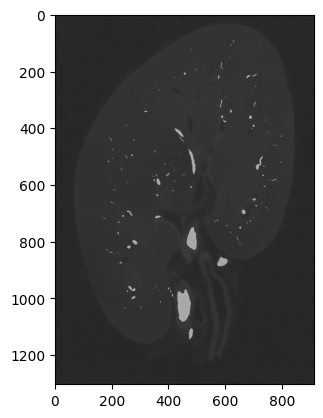

In [16]:
plt.imshow(image_3_sparse_test, cmap='gray')
plt.imshow(image_3_sparse_mask, cmap='Blues', alpha=0.5)

In [6]:
train_x=[]
train_y=[]

root_path="/root/data"
parhs=["/root/data/train/kidney_1_dense"]
for i,path in enumerate(parhs):
    x=load_data(glob(f"{path}/images/*"),is_label=False)
    y=load_data(glob(f"{path}/labels_fixed_2/*"),is_label=True)
    train_x.append(x)
    train_y.append(y)

    #(C,H,W)

    #aug
    train_x.append(x.permute(1,2,0))
    train_y.append(y.permute(1,2,0))
    train_x.append(x.permute(2,0,1))
    train_y.append(y.permute(2,0,1))

paths2=["/root/data/train/kidney_3_dense"]
for i,path2 in enumerate(paths2):
    x=load_data(glob(f"{path2}/images/*"),is_label=False)
    y=load_data(glob(f"{path2}/labels/*"),is_label=True)
    train_x.append(x)
    train_y.append(y)

    #(C,H,W)

    #aug
    train_x.append(x.permute(0,1,2))
    train_y.append(y.permute(0,1,2))

paths_x=glob("/root/data/train/kidney_2/images/*")
paths_y=glob("/root/data/train/kidney_2/labels/*")

val_x=load_data(paths_x,is_label=False)
print(val_x.shape)
val_y=load_data(paths_y,is_label=True)
print(val_y.shape)

  0%|          | 0/285 [00:00<?, ?it/s]

100%|██████████| 278/278 [00:05<00:00, 49.92it/s]


torch.Size([2217, 1041, 1511])


100%|██████████| 278/278 [00:07<00:00, 39.24it/s]


torch.Size([2217, 1041, 1511])


In [7]:
tc.backends.cudnn.enabled = True
tc.backends.cudnn.benchmark = True

In [8]:
# Kidney 1
train_dataset=Kaggld_Dataset(train_x,train_y,arg=True)
train_dataset = DataLoader(train_dataset, batch_size=CFG.train_batch_size ,num_workers=2, shuffle=True, pin_memory=True)
val_dataset=Kaggld_Dataset([val_x],[val_y])
val_dataset = DataLoader(val_dataset, batch_size=CFG.valid_batch_size, num_workers=2, shuffle=True, pin_memory=True)

In [24]:
valid_iterator_test = iter(val_dataset)

x.shape[1] =1041    x.shape[2]=1511x.shape[1] =1041    x.shape[2]=1511

x.shape[1] =1041    x.shape[2]=1511x.shape[1] =1041    x.shape[2]=1511

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511x.shape[1] =1041    x.shape[2]=1511

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511


In [11]:
train_iterator_test = iter(train_dataset)

x.shape[1] =1303    x.shape[2]=1024x.shape[1] =1303    x.shape[2]=1024



x.shape[1] =1303    x.shape[2]=1024


x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510

x.shape[1] =1706    x.shape[2]=1510x.shape[1] =1706    x.shape[2]=1510

x.shape[1] =2279    x.shape[2]=1303x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape

In [12]:
x, y = next(valid_iterator_test)
util.Display.view([
    util.Display(x[0].unsqueeze(0)),
    util.Display(y[0].unsqueeze(0).unsqueeze(0))
])


NameError: name 'valid_iterator_test' is not defined

In [43]:
train_dataset.dataset.x[0].shape

torch.Size([2279, 1303, 1024])

In [21]:
x, y = next(train_iterator_test)
util.Display.view([
    util.Display(train_dataset.dataset.x[3].unsqueeze(0)),
    util.Display(train_dataset.dataset.y[3].unsqueeze(0))
])


interactive(children=(IntSlider(value=0, description='i', max=500), Output()), _dom_classes=('widget-interact'…

In [11]:
#log_board.clear('train')
#log_board.clear('val')

In [ ]:
t_logger = log_board.get_logger('train')
v_logger = log_board.get_logger('val')
valid_every = 25

model=build_model()
model=DataParallel(model)

loss_fc=DiceLoss()
#loss_fn=nn.BCEWithLogitsLoss()
optimizer=tc.optim.AdamW(model.parameters(),lr=CFG.lr)
scaler=tc.cuda.amp.GradScaler()
scheduler = tc.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=CFG.lr,
                                                steps_per_epoch=len(train_dataset), epochs=CFG.epochs+1,
                                                pct_start=0.1,)

step=0
for epoch in range(CFG.epochs):
    model.train()
    time=tqdm(range(len(train_dataset)))
    losss=0
    scores=0
    for i,(x,y) in enumerate(train_dataset):
        step += 1
        x=x.cuda().to(tc.float32)
        y=y.cuda().to(tc.float32)
        x=norm_with_clip(x.reshape(-1,*x.shape[2:])).reshape(x.shape)
        x=add_noise(x,max_randn_rate=0.5,x_already_normed=True)
        
        with autocast():
            pred=model(x)
            loss=loss_fc(pred,y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        scheduler.step()

        # Logger
        t_logger.add_scalar('loss', loss.item(), step)
        t_logger.add_scalar('lr', optimizer.param_groups[0]['lr'], step)
        t_logger.add_scalar('dice', dice_coef(pred.detach(),y), step)


        score=dice_coef(pred.detach(),y)
        losss=(losss*i+loss.item())/(i+1)
        scores=(scores*i+score)/(i+1)
        time.set_description(f"epoch:{epoch},loss:{losss:.4f},score:{scores:.4f},lr{optimizer.param_groups[0]['lr']:.4e}")
        time.update()
        del loss,pred
    time.close()
    
    model.eval()
    time=tqdm(range(len(val_dataset)))
    val_losss=0
    val_scores=0
    for i,(x,y) in enumerate(val_dataset):
        x=x.cuda().to(tc.float32)
        y=y.cuda().to(tc.float32)
        x=norm_with_clip(x.reshape(-1,*x.shape[2:])).reshape(x.shape)

        with autocast():
            with tc.no_grad():
                pred=model(x)
                loss=loss_fc(pred,y)
        

        # Logger
        v_logger.add_scalar('loss', loss.item(), step)
        v_logger.add_scalar('lr', optimizer.param_groups[0]['lr'], step)
        v_logger.add_scalar('dice', dice_coef(pred.detach(),y), step)


        score=dice_coef(pred.detach(),y)
        val_losss=(val_losss*i+loss.item())/(i+1)
        val_scores=(val_scores*i+score)/(i+1)
        time.set_description(f"val-->loss:{val_losss:.4f},score:{val_scores:.4f}")
        time.update()

    time.close()
#tc.save(model.module.state_dict(),f"./{CFG.backbone}_{epoch}_loss{losss:.2f}_score{scores:.2f}_val_loss{val_losss:.2f}_val_score{val_scores:.2f}_midd_1024.pt")

time.close()

In [11]:
t_logger = log_board.get_logger('train')
v_logger = log_board.get_logger('val')
valid_every = 25
save_every = 500

model=build_model()
model=DataParallel(model)

loss_fc=DiceLoss()
edge_weighted_DiceLoss=util.EdgeWeightedDiceLoss(alpha=0.85).cuda()

edge=util.Edge().cuda()
#loss_fn=nn.BCEWithLogitsLoss()
optimizer=tc.optim.AdamW(model.parameters(),lr=CFG.lr)
scaler=tc.cuda.amp.GradScaler()
scheduler = tc.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=CFG.lr,
                                                steps_per_epoch=len(train_dataset), epochs=CFG.epochs+1,
                                                pct_start=0.1,)

step=0
valid_iterator = iter(val_dataset)
for epoch in range(CFG.epochs):
    model.train()
    time=tqdm(range(len(train_dataset)))
    losss=0
    scores=0
    for i,(x,y) in enumerate(train_dataset):
        step += 1
        x=x.cuda().to(tc.float32)
        y=y.cuda().to(tc.float32)
        x=norm_with_clip(x.reshape(-1,*x.shape[2:])).reshape(x.shape)
        x=add_noise(x,max_randn_rate=0.5,x_already_normed=True)
        
        with autocast():
            pred=model(x)
            loss=loss_fc(pred,y)
            #loss=edge_weighted_DiceLoss(pred.unsqueeze(1),y.unsqueeze(1))
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        scheduler.step()

        # Logger
        t_logger.add_scalar('loss', loss.item(), step)
        t_logger.add_scalar('lr', optimizer.param_groups[0]['lr'], step)
        t_logger.add_scalar('dice', dice_coef(pred.detach().sigmoid(),y), step)
        t_logger.add_scalar('surface-dice', dice_coef(
            edge((pred > 0.5).float().unsqueeze(1)).squeeze(1),
            edge(y.unsqueeze(1)).squeeze(1)
        ), step)

        score=dice_coef(pred.detach(),y)
        losss=(losss*i+loss.item())/(i+1)
        scores=(scores*i+score)/(i+1)
        time.set_description(f"epoch:{epoch},loss:{losss:.4f},score:{scores:.4f},lr{optimizer.param_groups[0]['lr']:.4e}")
        time.update()
        del loss,pred

        if (step + 1) % valid_every == 0:
            model.eval()
            try:
                x, y, = next(valid_iterator)
            except StopIteration:
                valid_iterator = iter(val_dataset)
                x, y, = next(valid_iterator)
            x=x.cuda().to(tc.float32)
            y=y.cuda().to(tc.float32)
            x=norm_with_clip(x.reshape(-1,*x.shape[2:])).reshape(x.shape)

            with autocast():
                pred=model(x).sigmoid()
            #v_logger.add_scalar('loss', loss.item(), step)
            v_logger.add_scalar('lr', optimizer.param_groups[0]['lr'], step)
            v_logger.add_scalar('dice', dice_coef(pred.detach(),y), step)
            v_logger.add_scalar('surface-dice', dice_coef(
                edge((pred > 0.5).float().unsqueeze(1)).squeeze(1),
                edge(y.unsqueeze(1)).squeeze(1)
            ), step)
            model.train()

        if (step + 1) % save_every == 0:
            tc.save(model.module.state_dict(), f'./bin/_tmp_models/log_attempt.pt')
        
    time.close()
    
    # model.eval()
    # time=tqdm(range(len(val_dataset)))
    # val_losss=0
    # val_scores=0
    # for i,(x,y) in enumerate(val_dataset):
    #     x=x.cuda().to(tc.float32)
    #     y=y.cuda().to(tc.float32)
    #     x=norm_with_clip(x.reshape(-1,*x.shape[2:])).reshape(x.shape)

    #     with autocast():
    #         with tc.no_grad():
    #             pred=model(x)
    #             loss=loss_fc(pred,y)
        

    #     # Logger
    #     v_logger.add_scalar('loss', loss.item(), step)
    #     v_logger.add_scalar('lr', optimizer.param_groups[0]['lr'], step)
    #     v_logger.add_scalar('dice', dice_coef(pred.detach(),y), step)


    #     score=dice_coef(pred.detach(),y)
    #     val_losss=(val_losss*i+loss.item())/(i+1)
    #     val_scores=(val_scores*i+score)/(i+1)
    #     time.set_description(f"val-->loss:{val_losss:.4f},score:{val_scores:.4f}")
    #     time.update()

    #time.close()
#tc.save(model.module.state_dict(),f"./{CFG.backbone}_{epoch}_loss{losss:.2f}_score{scores:.2f}_val_loss{val_losss:.2f}_val_score{val_scores:.2f}_midd_1024.pt")

#time.close()

model_name Unet
backbone mit_b2
x.shape[1] =1041    x.shape[2]=1511x.shape[1] =1041    x.shape[2]=1511

x.shape[1] =1041    x.shape[2]=1511x.shape[1] =1041    x.shape[2]=1511

  0%|          | 0/1399 [00:00<?, ?it/s]



x.shape[1] =1041    x.shape[2]=1511x.shape[1] =1041    x.shape[2]=1511

x.shape[1] =1041    x.shape[2]=1511x.shape[1] =1041    x.shape[2]=1511

x.shape[1] =1041    x.shape[2]=1511x.shape[1] =1041    x.shape[2]=1511


x.shape[1] =1041    x.shape[2]=1511x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511x.shape[1] =1303    x.shape[2]=1024x.shape[1] =1041    x.shape[2]=1511


x.shape[1] =1041    x.shape[2]=1511x.shape[1] =1041    x.shape[2]=1511

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shap

epoch:0,loss:0.9935,score:0.0088,lr3.2000e-06:   0%|          | 1/1399 [00:06<2:27:45,  6.34s/it]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9852,score:0.0194,lr3.2000e-06:   0%|          | 2/1399 [00:06<1:06:06,  2.84s/it]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9859,score:0.0190,lr3.2001e-06:   0%|          | 3/1399 [00:07<39:53,  1.71s/it]  

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9857,score:0.0203,lr3.2002e-06:   0%|          | 4/1399 [00:07<27:34,  1.19s/it]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9855,score:0.0202,lr3.2002e-06:   0%|          | 5/1399 [00:07<20:46,  1.12it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9864,score:0.0190,lr3.2003e-06:   0%|          | 6/1399 [00:08<16:39,  1.39it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9867,score:0.0189,lr3.2005e-06:   1%|          | 7/1399 [00:08<14:03,  1.65it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9861,score:0.0201,lr3.2006e-06:   1%|          | 8/1399 [00:08<12:20,  1.88it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9862,score:0.0199,lr3.2008e-06:   1%|          | 9/1399 [00:09<11:12,  2.07it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9847,score:0.0216,lr3.2009e-06:   1%|          | 10/1399 [00:09<10:26,  2.22it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9842,score:0.0224,lr3.2011e-06:   1%|          | 11/1399 [00:10<09:54,  2.34it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9842,score:0.0225,lr3.2014e-06:   1%|          | 12/1399 [00:10<09:31,  2.43it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9846,score:0.0221,lr3.2016e-06:   1%|          | 13/1399 [00:10<09:15,  2.49it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9855,score:0.0209,lr3.2019e-06:   1%|          | 14/1399 [00:11<09:04,  2.54it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9852,score:0.0213,lr3.2021e-06:   1%|          | 15/1399 [00:11<08:56,  2.58it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9849,score:0.0218,lr3.2024e-06:   1%|          | 16/1399 [00:11<08:51,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9850,score:0.0217,lr3.2027e-06:   1%|          | 17/1399 [00:12<08:56,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9852,score:0.0214,lr3.2031e-06:   1%|▏         | 18/1399 [00:12<08:51,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9850,score:0.0219,lr3.2034e-06:   1%|▏         | 19/1399 [00:13<08:47,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9846,score:0.0224,lr3.2038e-06:   1%|▏         | 20/1399 [00:13<08:44,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9854,score:0.0213,lr3.2042e-06:   2%|▏         | 21/1399 [00:13<08:42,  2.64it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9851,score:0.0217,lr3.2046e-06:   2%|▏         | 22/1399 [00:14<08:47,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9847,score:0.0224,lr3.2050e-06:   2%|▏         | 23/1399 [00:14<08:44,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9843,score:0.0230,lr3.2054e-06:   2%|▏         | 24/1399 [00:15<08:41,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9843,score:0.0232,lr3.2059e-06:   2%|▏         | 25/1399 [00:15<09:32,  2.40it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9845,score:0.0229,lr3.2064e-06:   2%|▏         | 26/1399 [00:15<09:15,  2.47it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9829,score:0.0251,lr3.2069e-06:   2%|▏         | 27/1399 [00:16<09:04,  2.52it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9826,score:0.0256,lr3.2074e-06:   2%|▏         | 28/1399 [00:16<08:55,  2.56it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9827,score:0.0255,lr3.2080e-06:   2%|▏         | 29/1399 [00:17<08:48,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9828,score:0.0254,lr3.2085e-06:   2%|▏         | 30/1399 [00:17<08:43,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9831,score:0.0250,lr3.2091e-06:   2%|▏         | 31/1399 [00:17<08:40,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9827,score:0.0255,lr3.2097e-06:   2%|▏         | 32/1399 [00:18<08:39,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9827,score:0.0257,lr3.2103e-06:   2%|▏         | 33/1399 [00:18<08:38,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9821,score:0.0266,lr3.2109e-06:   2%|▏         | 34/1399 [00:18<08:39,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9816,score:0.0272,lr3.2116e-06:   3%|▎         | 35/1399 [00:19<08:37,  2.64it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9819,score:0.0268,lr3.2123e-06:   3%|▎         | 36/1399 [00:19<08:35,  2.65it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9819,score:0.0267,lr3.2129e-06:   3%|▎         | 37/1399 [00:20<08:33,  2.65it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9821,score:0.0265,lr3.2137e-06:   3%|▎         | 38/1399 [00:20<08:32,  2.65it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9823,score:0.0261,lr3.2144e-06:   3%|▎         | 39/1399 [00:20<08:31,  2.66it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9825,score:0.0259,lr3.2151e-06:   3%|▎         | 40/1399 [00:21<08:32,  2.65it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9825,score:0.0260,lr3.2159e-06:   3%|▎         | 41/1399 [00:21<08:31,  2.66it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9825,score:0.0261,lr3.2167e-06:   3%|▎         | 42/1399 [00:21<08:30,  2.66it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9827,score:0.0258,lr3.2175e-06:   3%|▎         | 43/1399 [00:22<08:30,  2.66it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9825,score:0.0262,lr3.2183e-06:   3%|▎         | 44/1399 [00:22<08:29,  2.66it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9825,score:0.0262,lr3.2192e-06:   3%|▎         | 45/1399 [00:23<08:29,  2.66it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9826,score:0.0261,lr3.2200e-06:   3%|▎         | 46/1399 [00:23<08:30,  2.65it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9827,score:0.0259,lr3.2209e-06:   3%|▎         | 47/1399 [00:23<08:30,  2.65it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9827,score:0.0261,lr3.2218e-06:   3%|▎         | 48/1399 [00:24<08:30,  2.65it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9826,score:0.0262,lr3.2227e-06:   4%|▎         | 49/1399 [00:24<08:30,  2.65it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9825,score:0.0263,lr3.2236e-06:   4%|▎         | 50/1399 [00:25<09:21,  2.40it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9822,score:0.0269,lr3.2246e-06:   4%|▎         | 51/1399 [00:25<09:05,  2.47it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9822,score:0.0271,lr3.2256e-06:   4%|▎         | 52/1399 [00:25<09:04,  2.47it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9822,score:0.0270,lr3.2266e-06:   4%|▍         | 53/1399 [00:26<08:52,  2.53it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9820,score:0.0275,lr3.2276e-06:   4%|▍         | 54/1399 [00:26<08:44,  2.57it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9818,score:0.0278,lr3.2286e-06:   4%|▍         | 55/1399 [00:27<08:38,  2.59it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9816,score:0.0282,lr3.2297e-06:   4%|▍         | 56/1399 [00:27<08:34,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9817,score:0.0281,lr3.2307e-06:   4%|▍         | 57/1399 [00:27<08:32,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9816,score:0.0284,lr3.2318e-06:   4%|▍         | 58/1399 [00:28<08:31,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9814,score:0.0288,lr3.2329e-06:   4%|▍         | 59/1399 [00:28<08:28,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9815,score:0.0287,lr3.2340e-06:   4%|▍         | 60/1399 [00:28<08:27,  2.64it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9815,score:0.0287,lr3.2352e-06:   4%|▍         | 61/1399 [00:29<08:25,  2.65it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9811,score:0.0295,lr3.2364e-06:   4%|▍         | 62/1399 [00:29<08:25,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9812,score:0.0294,lr3.2375e-06:   5%|▍         | 63/1399 [00:30<08:25,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9813,score:0.0293,lr3.2387e-06:   5%|▍         | 64/1399 [00:30<08:26,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9813,score:0.0294,lr3.2400e-06:   5%|▍         | 65/1399 [00:30<08:25,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9813,score:0.0293,lr3.2412e-06:   5%|▍         | 66/1399 [00:31<08:24,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9814,score:0.0292,lr3.2425e-06:   5%|▍         | 67/1399 [00:31<08:23,  2.64it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9813,score:0.0293,lr3.2437e-06:   5%|▍         | 68/1399 [00:31<08:22,  2.65it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9815,score:0.0292,lr3.2450e-06:   5%|▍         | 69/1399 [00:32<08:22,  2.65it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9812,score:0.0296,lr3.2463e-06:   5%|▌         | 70/1399 [00:32<08:22,  2.65it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9811,score:0.0298,lr3.2477e-06:   5%|▌         | 71/1399 [00:33<08:23,  2.64it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9813,score:0.0295,lr3.2490e-06:   5%|▌         | 72/1399 [00:33<08:23,  2.64it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9814,score:0.0293,lr3.2504e-06:   5%|▌         | 73/1399 [00:33<08:22,  2.64it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9815,score:0.0292,lr3.2518e-06:   5%|▌         | 74/1399 [00:34<08:22,  2.64it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9815,score:0.0292,lr3.2532e-06:   5%|▌         | 75/1399 [00:34<09:12,  2.40it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9813,score:0.0296,lr3.2546e-06:   5%|▌         | 76/1399 [00:35<08:56,  2.47it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9813,score:0.0296,lr3.2561e-06:   6%|▌         | 77/1399 [00:35<08:44,  2.52it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9813,score:0.0295,lr3.2575e-06:   6%|▌         | 78/1399 [00:35<08:36,  2.56it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9813,score:0.0296,lr3.2590e-06:   6%|▌         | 79/1399 [00:36<08:32,  2.58it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9812,score:0.0297,lr3.2605e-06:   6%|▌         | 80/1399 [00:36<08:28,  2.59it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9810,score:0.0301,lr3.2620e-06:   6%|▌         | 81/1399 [00:36<08:26,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9810,score:0.0303,lr3.2636e-06:   6%|▌         | 82/1399 [00:37<08:24,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9807,score:0.0307,lr3.2651e-06:   6%|▌         | 83/1399 [00:37<08:22,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9808,score:0.0306,lr3.2667e-06:   6%|▌         | 84/1399 [00:38<08:20,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9808,score:0.0306,lr3.2683e-06:   6%|▌         | 85/1399 [00:38<08:19,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9808,score:0.0306,lr3.2699e-06:   6%|▌         | 86/1399 [00:38<08:19,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9808,score:0.0306,lr3.2716e-06:   6%|▌         | 87/1399 [00:39<08:26,  2.59it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9809,score:0.0306,lr3.2732e-06:   6%|▋         | 88/1399 [00:39<08:22,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9806,score:0.0309,lr3.2749e-06:   6%|▋         | 89/1399 [00:40<08:19,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9806,score:0.0310,lr3.2766e-06:   6%|▋         | 90/1399 [00:40<08:17,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9807,score:0.0309,lr3.2783e-06:   7%|▋         | 91/1399 [00:40<08:15,  2.64it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9803,score:0.0316,lr3.2800e-06:   7%|▋         | 92/1399 [00:41<08:14,  2.64it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9802,score:0.0318,lr3.2818e-06:   7%|▋         | 93/1399 [00:41<08:13,  2.65it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9802,score:0.0318,lr3.2836e-06:   7%|▋         | 94/1399 [00:41<08:13,  2.65it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9803,score:0.0317,lr3.2853e-06:   7%|▋         | 95/1399 [00:42<08:13,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9804,score:0.0315,lr3.2871e-06:   7%|▋         | 96/1399 [00:42<08:12,  2.65it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9805,score:0.0315,lr3.2890e-06:   7%|▋         | 97/1399 [00:43<08:11,  2.65it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9805,score:0.0315,lr3.2908e-06:   7%|▋         | 98/1399 [00:43<08:11,  2.65it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9806,score:0.0313,lr3.2927e-06:   7%|▋         | 99/1399 [00:43<08:11,  2.65it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9805,score:0.0315,lr3.2946e-06:   7%|▋         | 100/1399 [00:44<08:59,  2.41it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9802,score:0.0319,lr3.2965e-06:   7%|▋         | 101/1399 [00:44<08:44,  2.47it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9801,score:0.0322,lr3.2984e-06:   7%|▋         | 102/1399 [00:45<08:33,  2.52it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9799,score:0.0326,lr3.3003e-06:   7%|▋         | 103/1399 [00:45<08:26,  2.56it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9800,score:0.0325,lr3.3023e-06:   7%|▋         | 104/1399 [00:45<08:20,  2.59it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9801,score:0.0323,lr3.3042e-06:   8%|▊         | 105/1399 [00:46<08:17,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9800,score:0.0325,lr3.3062e-06:   8%|▊         | 106/1399 [00:46<08:14,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9801,score:0.0324,lr3.3082e-06:   8%|▊         | 107/1399 [00:46<08:12,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9800,score:0.0325,lr3.3103e-06:   8%|▊         | 108/1399 [00:47<08:11,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9801,score:0.0324,lr3.3123e-06:   8%|▊         | 109/1399 [00:47<08:10,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9801,score:0.0324,lr3.3144e-06:   8%|▊         | 110/1399 [00:48<08:09,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9801,score:0.0324,lr3.3165e-06:   8%|▊         | 111/1399 [00:48<08:08,  2.64it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9802,score:0.0323,lr3.3186e-06:   8%|▊         | 112/1399 [00:48<08:07,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9804,score:0.0321,lr3.3207e-06:   8%|▊         | 113/1399 [00:49<08:07,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9803,score:0.0321,lr3.3229e-06:   8%|▊         | 114/1399 [00:49<08:07,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9803,score:0.0321,lr3.3250e-06:   8%|▊         | 115/1399 [00:49<08:07,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9802,score:0.0324,lr3.3272e-06:   8%|▊         | 116/1399 [00:50<08:06,  2.64it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9802,score:0.0325,lr3.3294e-06:   8%|▊         | 117/1399 [00:50<08:05,  2.64it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9800,score:0.0329,lr3.3316e-06:   8%|▊         | 118/1399 [00:51<08:05,  2.64it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9799,score:0.0333,lr3.3339e-06:   9%|▊         | 119/1399 [00:51<08:05,  2.64it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9799,score:0.0334,lr3.3361e-06:   9%|▊         | 120/1399 [00:51<08:05,  2.64it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9799,score:0.0334,lr3.3384e-06:   9%|▊         | 121/1399 [00:52<08:04,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9798,score:0.0334,lr3.3407e-06:   9%|▊         | 122/1399 [00:52<08:04,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9798,score:0.0336,lr3.3430e-06:   9%|▉         | 123/1399 [00:53<08:03,  2.64it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9797,score:0.0336,lr3.3454e-06:   9%|▉         | 124/1399 [00:53<08:03,  2.64it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9797,score:0.0336,lr3.3477e-06:   9%|▉         | 125/1399 [00:53<08:50,  2.40it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9796,score:0.0338,lr3.3501e-06:   9%|▉         | 126/1399 [00:54<08:35,  2.47it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9796,score:0.0338,lr3.3525e-06:   9%|▉         | 127/1399 [00:54<08:25,  2.52it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9796,score:0.0339,lr3.3549e-06:   9%|▉         | 128/1399 [00:55<08:17,  2.55it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9797,score:0.0338,lr3.3573e-06:   9%|▉         | 129/1399 [00:55<08:11,  2.58it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9795,score:0.0341,lr3.3598e-06:   9%|▉         | 130/1399 [00:55<08:07,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9795,score:0.0341,lr3.3622e-06:   9%|▉         | 131/1399 [00:56<08:04,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9795,score:0.0342,lr3.3647e-06:   9%|▉         | 132/1399 [00:56<08:02,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9792,score:0.0347,lr3.3672e-06:  10%|▉         | 133/1399 [00:56<08:01,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9789,score:0.0351,lr3.3697e-06:  10%|▉         | 134/1399 [00:57<08:00,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9789,score:0.0352,lr3.3723e-06:  10%|▉         | 135/1399 [00:57<08:00,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9788,score:0.0353,lr3.3748e-06:  10%|▉         | 136/1399 [00:58<07:58,  2.64it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9788,score:0.0353,lr3.3774e-06:  10%|▉         | 137/1399 [00:58<07:57,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9788,score:0.0353,lr3.3800e-06:  10%|▉         | 138/1399 [00:58<07:57,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9787,score:0.0355,lr3.3826e-06:  10%|▉         | 139/1399 [00:59<07:56,  2.64it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9788,score:0.0355,lr3.3853e-06:  10%|█         | 140/1399 [00:59<07:57,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9788,score:0.0354,lr3.3879e-06:  10%|█         | 141/1399 [00:59<07:58,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9788,score:0.0355,lr3.3906e-06:  10%|█         | 142/1399 [01:00<07:57,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9787,score:0.0356,lr3.3933e-06:  10%|█         | 143/1399 [01:00<07:57,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9786,score:0.0359,lr3.3960e-06:  10%|█         | 144/1399 [01:01<07:57,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9786,score:0.0360,lr3.3987e-06:  10%|█         | 145/1399 [01:01<07:56,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9787,score:0.0358,lr3.4015e-06:  10%|█         | 146/1399 [01:01<07:56,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9787,score:0.0358,lr3.4042e-06:  11%|█         | 147/1399 [01:02<07:56,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9786,score:0.0361,lr3.4070e-06:  11%|█         | 148/1399 [01:02<07:54,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9785,score:0.0364,lr3.4098e-06:  11%|█         | 149/1399 [01:02<07:53,  2.64it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9785,score:0.0364,lr3.4126e-06:  11%|█         | 150/1399 [01:03<08:39,  2.40it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9786,score:0.0363,lr3.4155e-06:  11%|█         | 151/1399 [01:03<08:35,  2.42it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9786,score:0.0363,lr3.4183e-06:  11%|█         | 152/1399 [01:04<08:21,  2.49it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9786,score:0.0363,lr3.4212e-06:  11%|█         | 153/1399 [01:04<08:12,  2.53it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9784,score:0.0368,lr3.4241e-06:  11%|█         | 154/1399 [01:05<08:05,  2.57it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9783,score:0.0369,lr3.4270e-06:  11%|█         | 155/1399 [01:05<08:01,  2.58it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9781,score:0.0374,lr3.4300e-06:  11%|█         | 156/1399 [01:05<07:57,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9781,score:0.0375,lr3.4329e-06:  11%|█         | 157/1399 [01:06<07:55,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9779,score:0.0379,lr3.4359e-06:  11%|█▏        | 158/1399 [01:06<07:53,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9780,score:0.0379,lr3.4389e-06:  11%|█▏        | 159/1399 [01:06<07:52,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9779,score:0.0381,lr3.4419e-06:  11%|█▏        | 160/1399 [01:07<07:51,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9780,score:0.0380,lr3.4449e-06:  12%|█▏        | 161/1399 [01:07<07:51,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9779,score:0.0381,lr3.4480e-06:  12%|█▏        | 162/1399 [01:08<07:49,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9779,score:0.0381,lr3.4511e-06:  12%|█▏        | 163/1399 [01:08<07:49,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9779,score:0.0382,lr3.4541e-06:  12%|█▏        | 164/1399 [01:08<07:48,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9779,score:0.0383,lr3.4572e-06:  12%|█▏        | 165/1399 [01:09<07:48,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9779,score:0.0383,lr3.4604e-06:  12%|█▏        | 166/1399 [01:09<07:47,  2.64it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9779,score:0.0385,lr3.4635e-06:  12%|█▏        | 167/1399 [01:09<07:46,  2.64it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9779,score:0.0384,lr3.4667e-06:  12%|█▏        | 168/1399 [01:10<07:46,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9778,score:0.0385,lr3.4699e-06:  12%|█▏        | 169/1399 [01:10<07:46,  2.64it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9779,score:0.0383,lr3.4730e-06:  12%|█▏        | 170/1399 [01:11<07:45,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9776,score:0.0390,lr3.4763e-06:  12%|█▏        | 171/1399 [01:11<07:44,  2.64it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9776,score:0.0391,lr3.4795e-06:  12%|█▏        | 172/1399 [01:11<07:44,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9775,score:0.0392,lr3.4828e-06:  12%|█▏        | 173/1399 [01:12<07:44,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9775,score:0.0393,lr3.4860e-06:  12%|█▏        | 174/1399 [01:12<07:44,  2.64it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9773,score:0.0396,lr3.4893e-06:  13%|█▎        | 175/1399 [01:13<08:30,  2.40it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9773,score:0.0397,lr3.4926e-06:  13%|█▎        | 176/1399 [01:13<08:15,  2.47it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9772,score:0.0398,lr3.4960e-06:  13%|█▎        | 177/1399 [01:13<08:05,  2.52it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9773,score:0.0397,lr3.4993e-06:  13%|█▎        | 178/1399 [01:14<07:57,  2.56it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9774,score:0.0396,lr3.5027e-06:  13%|█▎        | 179/1399 [01:14<07:53,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9773,score:0.0397,lr3.5061e-06:  13%|█▎        | 180/1399 [01:15<07:49,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9773,score:0.0397,lr3.5095e-06:  13%|█▎        | 181/1399 [01:15<07:46,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9773,score:0.0399,lr3.5129e-06:  13%|█▎        | 182/1399 [01:15<07:44,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9773,score:0.0399,lr3.5163e-06:  13%|█▎        | 183/1399 [01:16<07:42,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9772,score:0.0400,lr3.5198e-06:  13%|█▎        | 184/1399 [01:16<07:42,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9772,score:0.0401,lr3.5233e-06:  13%|█▎        | 185/1399 [01:16<07:41,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9772,score:0.0403,lr3.5268e-06:  13%|█▎        | 186/1399 [01:17<07:40,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9771,score:0.0404,lr3.5303e-06:  13%|█▎        | 187/1399 [01:17<07:39,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9771,score:0.0404,lr3.5338e-06:  13%|█▎        | 188/1399 [01:18<07:39,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9770,score:0.0405,lr3.5374e-06:  14%|█▎        | 189/1399 [01:18<07:38,  2.64it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9770,score:0.0407,lr3.5410e-06:  14%|█▎        | 190/1399 [01:18<07:38,  2.64it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9770,score:0.0406,lr3.5446e-06:  14%|█▎        | 191/1399 [01:19<07:38,  2.64it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9769,score:0.0408,lr3.5482e-06:  14%|█▎        | 192/1399 [01:19<07:37,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9769,score:0.0410,lr3.5518e-06:  14%|█▍        | 193/1399 [01:19<07:37,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9768,score:0.0411,lr3.5555e-06:  14%|█▍        | 194/1399 [01:20<07:37,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9769,score:0.0410,lr3.5591e-06:  14%|█▍        | 195/1399 [01:20<07:37,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9770,score:0.0408,lr3.5628e-06:  14%|█▍        | 196/1399 [01:21<07:37,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9769,score:0.0410,lr3.5665e-06:  14%|█▍        | 197/1399 [01:21<07:36,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9770,score:0.0409,lr3.5702e-06:  14%|█▍        | 198/1399 [01:21<07:36,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9769,score:0.0410,lr3.5740e-06:  14%|█▍        | 199/1399 [01:22<07:35,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9769,score:0.0410,lr3.5778e-06:  14%|█▍        | 200/1399 [01:22<08:20,  2.40it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9769,score:0.0410,lr3.5815e-06:  14%|█▍        | 201/1399 [01:23<08:05,  2.47it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9770,score:0.0409,lr3.5853e-06:  14%|█▍        | 202/1399 [01:23<07:55,  2.52it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9770,score:0.0409,lr3.5891e-06:  15%|█▍        | 203/1399 [01:23<07:48,  2.55it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9770,score:0.0409,lr3.5930e-06:  15%|█▍        | 204/1399 [01:24<07:44,  2.58it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9770,score:0.0409,lr3.5968e-06:  15%|█▍        | 205/1399 [01:24<07:40,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9770,score:0.0409,lr3.6007e-06:  15%|█▍        | 206/1399 [01:24<07:36,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9770,score:0.0408,lr3.6046e-06:  15%|█▍        | 207/1399 [01:25<07:34,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9771,score:0.0407,lr3.6085e-06:  15%|█▍        | 208/1399 [01:25<07:33,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9771,score:0.0406,lr3.6125e-06:  15%|█▍        | 209/1399 [01:26<07:31,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9771,score:0.0408,lr3.6164e-06:  15%|█▌        | 210/1399 [01:26<07:30,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9771,score:0.0409,lr3.6204e-06:  15%|█▌        | 211/1399 [01:26<07:30,  2.64it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9770,score:0.0410,lr3.6244e-06:  15%|█▌        | 212/1399 [01:27<07:29,  2.64it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9770,score:0.0410,lr3.6284e-06:  15%|█▌        | 213/1399 [01:27<07:28,  2.64it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9770,score:0.0411,lr3.6324e-06:  15%|█▌        | 214/1399 [01:28<07:28,  2.64it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9770,score:0.0413,lr3.6364e-06:  15%|█▌        | 215/1399 [01:28<07:28,  2.64it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9768,score:0.0416,lr3.6405e-06:  15%|█▌        | 216/1399 [01:28<07:29,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9768,score:0.0416,lr3.6446e-06:  16%|█▌        | 217/1399 [01:29<07:28,  2.64it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9768,score:0.0415,lr3.6487e-06:  16%|█▌        | 218/1399 [01:29<07:27,  2.64it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9768,score:0.0416,lr3.6528e-06:  16%|█▌        | 219/1399 [01:29<07:27,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9767,score:0.0419,lr3.6569e-06:  16%|█▌        | 220/1399 [01:30<07:26,  2.64it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9765,score:0.0423,lr3.6611e-06:  16%|█▌        | 221/1399 [01:30<07:26,  2.64it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9763,score:0.0428,lr3.6653e-06:  16%|█▌        | 222/1399 [01:31<07:27,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9763,score:0.0428,lr3.6694e-06:  16%|█▌        | 223/1399 [01:31<07:26,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9763,score:0.0430,lr3.6737e-06:  16%|█▌        | 224/1399 [01:31<07:26,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9763,score:0.0430,lr3.6779e-06:  16%|█▌        | 225/1399 [01:32<08:09,  2.40it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9764,score:0.0428,lr3.6821e-06:  16%|█▌        | 226/1399 [01:32<07:56,  2.46it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9764,score:0.0428,lr3.6864e-06:  16%|█▌        | 227/1399 [01:33<07:46,  2.51it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9762,score:0.0431,lr3.6907e-06:  16%|█▋        | 228/1399 [01:33<07:38,  2.55it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9763,score:0.0431,lr3.6950e-06:  16%|█▋        | 229/1399 [01:33<07:33,  2.58it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9762,score:0.0432,lr3.6993e-06:  16%|█▋        | 230/1399 [01:34<07:30,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9762,score:0.0433,lr3.7037e-06:  17%|█▋        | 231/1399 [01:34<07:27,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9762,score:0.0433,lr3.7080e-06:  17%|█▋        | 232/1399 [01:34<07:26,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9763,score:0.0431,lr3.7124e-06:  17%|█▋        | 233/1399 [01:35<07:24,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9763,score:0.0432,lr3.7168e-06:  17%|█▋        | 234/1399 [01:35<07:23,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9763,score:0.0432,lr3.7212e-06:  17%|█▋        | 235/1399 [01:36<07:22,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9763,score:0.0433,lr3.7256e-06:  17%|█▋        | 236/1399 [01:36<07:21,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9763,score:0.0433,lr3.7301e-06:  17%|█▋        | 237/1399 [01:36<07:21,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9763,score:0.0433,lr3.7346e-06:  17%|█▋        | 238/1399 [01:37<07:21,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9763,score:0.0436,lr3.7391e-06:  17%|█▋        | 239/1399 [01:37<07:21,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9763,score:0.0435,lr3.7436e-06:  17%|█▋        | 240/1399 [01:38<07:21,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9764,score:0.0434,lr3.7481e-06:  17%|█▋        | 241/1399 [01:38<07:21,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9763,score:0.0436,lr3.7526e-06:  17%|█▋        | 242/1399 [01:38<07:21,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9762,score:0.0439,lr3.7572e-06:  17%|█▋        | 243/1399 [01:39<07:20,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9763,score:0.0437,lr3.7618e-06:  17%|█▋        | 244/1399 [01:39<07:19,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9762,score:0.0439,lr3.7664e-06:  18%|█▊        | 245/1399 [01:39<07:18,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9763,score:0.0439,lr3.7710e-06:  18%|█▊        | 246/1399 [01:40<07:18,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9762,score:0.0440,lr3.7757e-06:  18%|█▊        | 247/1399 [01:40<07:18,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9762,score:0.0441,lr3.7803e-06:  18%|█▊        | 248/1399 [01:41<07:18,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9762,score:0.0442,lr3.7850e-06:  18%|█▊        | 249/1399 [01:41<07:18,  2.62it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9763,score:0.0442,lr3.7897e-06:  18%|█▊        | 250/1399 [01:41<08:00,  2.39it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9762,score:0.0443,lr3.7944e-06:  18%|█▊        | 251/1399 [01:42<07:48,  2.45it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9762,score:0.0443,lr3.7991e-06:  18%|█▊        | 252/1399 [01:42<07:38,  2.50it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9762,score:0.0442,lr3.8039e-06:  18%|█▊        | 253/1399 [01:43<07:31,  2.54it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9763,score:0.0442,lr3.8087e-06:  18%|█▊        | 254/1399 [01:43<07:26,  2.57it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9763,score:0.0442,lr3.8135e-06:  18%|█▊        | 255/1399 [01:43<07:23,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9762,score:0.0444,lr3.8183e-06:  18%|█▊        | 256/1399 [01:44<07:21,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9762,score:0.0445,lr3.8231e-06:  18%|█▊        | 257/1399 [01:44<07:19,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9762,score:0.0446,lr3.8279e-06:  18%|█▊        | 258/1399 [01:44<07:17,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9761,score:0.0448,lr3.8328e-06:  19%|█▊        | 259/1399 [01:45<07:17,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9761,score:0.0449,lr3.8377e-06:  19%|█▊        | 260/1399 [01:45<07:16,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9762,score:0.0448,lr3.8426e-06:  19%|█▊        | 261/1399 [01:46<07:15,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9761,score:0.0450,lr3.8475e-06:  19%|█▊        | 262/1399 [01:46<07:24,  2.56it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9761,score:0.0449,lr3.8524e-06:  19%|█▉        | 263/1399 [01:46<07:19,  2.58it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9761,score:0.0451,lr3.8574e-06:  19%|█▉        | 264/1399 [01:47<07:17,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9761,score:0.0450,lr3.8624e-06:  19%|█▉        | 265/1399 [01:47<07:15,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9761,score:0.0451,lr3.8674e-06:  19%|█▉        | 266/1399 [01:48<07:13,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9761,score:0.0452,lr3.8724e-06:  19%|█▉        | 267/1399 [01:48<07:12,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9760,score:0.0452,lr3.8774e-06:  19%|█▉        | 268/1399 [01:48<07:11,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9759,score:0.0455,lr3.8825e-06:  19%|█▉        | 269/1399 [01:49<07:10,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9760,score:0.0454,lr3.8875e-06:  19%|█▉        | 270/1399 [01:49<07:09,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9760,score:0.0453,lr3.8926e-06:  19%|█▉        | 271/1399 [01:49<07:09,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9760,score:0.0454,lr3.8977e-06:  19%|█▉        | 272/1399 [01:50<07:09,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9761,score:0.0453,lr3.9028e-06:  20%|█▉        | 273/1399 [01:50<07:08,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9761,score:0.0453,lr3.9080e-06:  20%|█▉        | 274/1399 [01:51<07:08,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9761,score:0.0453,lr3.9131e-06:  20%|█▉        | 275/1399 [01:51<07:50,  2.39it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9762,score:0.0452,lr3.9183e-06:  20%|█▉        | 276/1399 [01:52<07:36,  2.46it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9762,score:0.0452,lr3.9235e-06:  20%|█▉        | 277/1399 [01:52<07:27,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9761,score:0.0455,lr3.9287e-06:  20%|█▉        | 278/1399 [01:52<07:20,  2.55it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9760,score:0.0457,lr3.9340e-06:  20%|█▉        | 279/1399 [01:53<07:15,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9760,score:0.0457,lr3.9392e-06:  20%|██        | 280/1399 [01:53<07:11,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9760,score:0.0458,lr3.9445e-06:  20%|██        | 281/1399 [01:53<07:09,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9760,score:0.0458,lr3.9498e-06:  20%|██        | 282/1399 [01:54<07:06,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9760,score:0.0459,lr3.9551e-06:  20%|██        | 283/1399 [01:54<07:05,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9760,score:0.0460,lr3.9604e-06:  20%|██        | 284/1399 [01:55<07:04,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9760,score:0.0460,lr3.9658e-06:  20%|██        | 285/1399 [01:55<07:04,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9759,score:0.0462,lr3.9711e-06:  20%|██        | 286/1399 [01:55<07:03,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9759,score:0.0462,lr3.9765e-06:  21%|██        | 287/1399 [01:56<07:03,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9759,score:0.0462,lr3.9819e-06:  21%|██        | 288/1399 [01:56<07:02,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9759,score:0.0464,lr3.9873e-06:  21%|██        | 289/1399 [01:56<07:03,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9758,score:0.0466,lr3.9928e-06:  21%|██        | 290/1399 [01:57<07:02,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9758,score:0.0467,lr3.9982e-06:  21%|██        | 291/1399 [01:57<07:01,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9757,score:0.0471,lr4.0037e-06:  21%|██        | 292/1399 [01:58<07:00,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9756,score:0.0474,lr4.0092e-06:  21%|██        | 293/1399 [01:58<07:00,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9755,score:0.0475,lr4.0147e-06:  21%|██        | 294/1399 [01:58<06:59,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9755,score:0.0476,lr4.0203e-06:  21%|██        | 295/1399 [01:59<07:00,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9754,score:0.0478,lr4.0258e-06:  21%|██        | 296/1399 [01:59<07:00,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9753,score:0.0479,lr4.0314e-06:  21%|██        | 297/1399 [01:59<06:59,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9752,score:0.0482,lr4.0370e-06:  21%|██▏       | 298/1399 [02:00<06:58,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9752,score:0.0483,lr4.0426e-06:  21%|██▏       | 299/1399 [02:00<06:58,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9752,score:0.0484,lr4.0482e-06:  21%|██▏       | 300/1399 [02:01<07:38,  2.39it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9751,score:0.0485,lr4.0538e-06:  22%|██▏       | 301/1399 [02:01<07:26,  2.46it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9752,score:0.0484,lr4.0595e-06:  22%|██▏       | 302/1399 [02:02<07:17,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9752,score:0.0483,lr4.0652e-06:  22%|██▏       | 303/1399 [02:02<07:11,  2.54it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9752,score:0.0483,lr4.0709e-06:  22%|██▏       | 304/1399 [02:02<07:06,  2.57it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9752,score:0.0484,lr4.0766e-06:  22%|██▏       | 305/1399 [02:03<07:02,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9752,score:0.0485,lr4.0823e-06:  22%|██▏       | 306/1399 [02:03<07:00,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9751,score:0.0487,lr4.0881e-06:  22%|██▏       | 307/1399 [02:03<06:57,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9751,score:0.0488,lr4.0939e-06:  22%|██▏       | 308/1399 [02:04<06:56,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9750,score:0.0490,lr4.0996e-06:  22%|██▏       | 309/1399 [02:04<06:55,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9750,score:0.0490,lr4.1055e-06:  22%|██▏       | 310/1399 [02:05<06:54,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9750,score:0.0491,lr4.1113e-06:  22%|██▏       | 311/1399 [02:05<06:53,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9750,score:0.0491,lr4.1171e-06:  22%|██▏       | 312/1399 [02:05<06:53,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9750,score:0.0492,lr4.1230e-06:  22%|██▏       | 313/1399 [02:06<06:53,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9750,score:0.0491,lr4.1289e-06:  22%|██▏       | 314/1399 [02:06<06:52,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9751,score:0.0490,lr4.1348e-06:  23%|██▎       | 315/1399 [02:06<06:54,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9751,score:0.0491,lr4.1407e-06:  23%|██▎       | 316/1399 [02:07<06:53,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9751,score:0.0490,lr4.1466e-06:  23%|██▎       | 317/1399 [02:07<06:52,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9751,score:0.0492,lr4.1526e-06:  23%|██▎       | 318/1399 [02:08<06:51,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9750,score:0.0493,lr4.1586e-06:  23%|██▎       | 319/1399 [02:08<06:51,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9750,score:0.0494,lr4.1646e-06:  23%|██▎       | 320/1399 [02:08<06:50,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9750,score:0.0494,lr4.1706e-06:  23%|██▎       | 321/1399 [02:09<06:50,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9750,score:0.0495,lr4.1766e-06:  23%|██▎       | 322/1399 [02:09<06:50,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9751,score:0.0494,lr4.1827e-06:  23%|██▎       | 323/1399 [02:10<06:50,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9750,score:0.0496,lr4.1887e-06:  23%|██▎       | 324/1399 [02:10<06:49,  2.62it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9751,score:0.0495,lr4.1948e-06:  23%|██▎       | 325/1399 [02:10<07:29,  2.39it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9751,score:0.0496,lr4.2009e-06:  23%|██▎       | 326/1399 [02:11<07:16,  2.46it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9751,score:0.0496,lr4.2070e-06:  23%|██▎       | 327/1399 [02:11<07:08,  2.50it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9750,score:0.0497,lr4.2132e-06:  23%|██▎       | 328/1399 [02:12<07:01,  2.54it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9750,score:0.0498,lr4.2193e-06:  24%|██▎       | 329/1399 [02:12<06:57,  2.56it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9750,score:0.0499,lr4.2255e-06:  24%|██▎       | 330/1399 [02:12<06:54,  2.58it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9749,score:0.0500,lr4.2317e-06:  24%|██▎       | 331/1399 [02:13<06:51,  2.59it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9750,score:0.0501,lr4.2379e-06:  24%|██▎       | 332/1399 [02:13<06:50,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9750,score:0.0501,lr4.2442e-06:  24%|██▍       | 333/1399 [02:13<06:48,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9750,score:0.0501,lr4.2504e-06:  24%|██▍       | 334/1399 [02:14<06:46,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9749,score:0.0503,lr4.2567e-06:  24%|██▍       | 335/1399 [02:14<06:46,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9748,score:0.0506,lr4.2630e-06:  24%|██▍       | 336/1399 [02:15<06:45,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9747,score:0.0507,lr4.2693e-06:  24%|██▍       | 337/1399 [02:15<06:45,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9747,score:0.0508,lr4.2756e-06:  24%|██▍       | 338/1399 [02:15<06:44,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9748,score:0.0508,lr4.2820e-06:  24%|██▍       | 339/1399 [02:16<06:44,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9747,score:0.0509,lr4.2883e-06:  24%|██▍       | 340/1399 [02:16<06:44,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9746,score:0.0512,lr4.2947e-06:  24%|██▍       | 341/1399 [02:16<06:43,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9746,score:0.0513,lr4.3011e-06:  24%|██▍       | 342/1399 [02:17<06:42,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9746,score:0.0512,lr4.3075e-06:  25%|██▍       | 343/1399 [02:17<06:41,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9745,score:0.0516,lr4.3139e-06:  25%|██▍       | 344/1399 [02:18<06:40,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9745,score:0.0516,lr4.3204e-06:  25%|██▍       | 345/1399 [02:18<06:41,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9745,score:0.0516,lr4.3269e-06:  25%|██▍       | 346/1399 [02:18<06:40,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9745,score:0.0518,lr4.3334e-06:  25%|██▍       | 347/1399 [02:19<06:39,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9745,score:0.0519,lr4.3399e-06:  25%|██▍       | 348/1399 [02:19<06:39,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9744,score:0.0520,lr4.3464e-06:  25%|██▍       | 349/1399 [02:20<06:38,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9744,score:0.0521,lr4.3529e-06:  25%|██▌       | 350/1399 [02:20<07:19,  2.39it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9744,score:0.0521,lr4.3595e-06:  25%|██▌       | 351/1399 [02:20<07:06,  2.46it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9744,score:0.0521,lr4.3661e-06:  25%|██▌       | 352/1399 [02:21<06:57,  2.51it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9743,score:0.0524,lr4.3727e-06:  25%|██▌       | 353/1399 [02:21<06:51,  2.54it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9743,score:0.0524,lr4.3793e-06:  25%|██▌       | 354/1399 [02:22<06:47,  2.56it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9744,score:0.0524,lr4.3860e-06:  25%|██▌       | 355/1399 [02:22<06:44,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9744,score:0.0524,lr4.3926e-06:  25%|██▌       | 356/1399 [02:22<06:41,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9744,score:0.0524,lr4.3993e-06:  26%|██▌       | 357/1399 [02:23<06:42,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9744,score:0.0525,lr4.4060e-06:  26%|██▌       | 358/1399 [02:23<06:40,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9744,score:0.0524,lr4.4127e-06:  26%|██▌       | 359/1399 [02:23<06:38,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9744,score:0.0526,lr4.4194e-06:  26%|██▌       | 360/1399 [02:24<06:36,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9744,score:0.0527,lr4.4262e-06:  26%|██▌       | 361/1399 [02:24<06:35,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9743,score:0.0527,lr4.4329e-06:  26%|██▌       | 362/1399 [02:25<06:34,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9743,score:0.0529,lr4.4397e-06:  26%|██▌       | 363/1399 [02:25<06:33,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9743,score:0.0530,lr4.4465e-06:  26%|██▌       | 364/1399 [02:25<06:33,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9743,score:0.0530,lr4.4533e-06:  26%|██▌       | 365/1399 [02:26<06:33,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9743,score:0.0531,lr4.4602e-06:  26%|██▌       | 366/1399 [02:26<06:32,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9743,score:0.0531,lr4.4670e-06:  26%|██▌       | 367/1399 [02:27<06:33,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9743,score:0.0532,lr4.4739e-06:  26%|██▋       | 368/1399 [02:27<06:32,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9743,score:0.0531,lr4.4808e-06:  26%|██▋       | 369/1399 [02:27<06:31,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9742,score:0.0533,lr4.4877e-06:  26%|██▋       | 370/1399 [02:28<06:30,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9742,score:0.0534,lr4.4946e-06:  27%|██▋       | 371/1399 [02:28<06:30,  2.64it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9742,score:0.0533,lr4.5016e-06:  27%|██▋       | 372/1399 [02:28<06:29,  2.64it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9742,score:0.0534,lr4.5086e-06:  27%|██▋       | 373/1399 [02:29<06:29,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9742,score:0.0536,lr4.5155e-06:  27%|██▋       | 374/1399 [02:29<06:28,  2.64it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9742,score:0.0535,lr4.5226e-06:  27%|██▋       | 375/1399 [02:30<07:06,  2.40it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9742,score:0.0535,lr4.5296e-06:  27%|██▋       | 376/1399 [02:30<06:55,  2.46it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9742,score:0.0537,lr4.5366e-06:  27%|██▋       | 377/1399 [02:30<06:46,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9742,score:0.0539,lr4.5437e-06:  27%|██▋       | 378/1399 [02:31<06:40,  2.55it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9742,score:0.0539,lr4.5508e-06:  27%|██▋       | 379/1399 [02:31<06:36,  2.57it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9742,score:0.0540,lr4.5578e-06:  27%|██▋       | 380/1399 [02:32<06:32,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9742,score:0.0540,lr4.5650e-06:  27%|██▋       | 381/1399 [02:32<06:30,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9741,score:0.0541,lr4.5721e-06:  27%|██▋       | 382/1399 [02:32<06:29,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9740,score:0.0544,lr4.5792e-06:  27%|██▋       | 383/1399 [02:33<06:28,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9740,score:0.0544,lr4.5864e-06:  27%|██▋       | 384/1399 [02:33<06:27,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9740,score:0.0545,lr4.5936e-06:  28%|██▊       | 385/1399 [02:33<06:26,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9739,score:0.0547,lr4.6008e-06:  28%|██▊       | 386/1399 [02:34<06:26,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9739,score:0.0548,lr4.6080e-06:  28%|██▊       | 387/1399 [02:34<06:26,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9739,score:0.0548,lr4.6153e-06:  28%|██▊       | 388/1399 [02:35<06:25,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9740,score:0.0548,lr4.6225e-06:  28%|██▊       | 389/1399 [02:35<06:24,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9740,score:0.0548,lr4.6298e-06:  28%|██▊       | 390/1399 [02:35<06:24,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9739,score:0.0550,lr4.6371e-06:  28%|██▊       | 391/1399 [02:36<06:23,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9739,score:0.0551,lr4.6444e-06:  28%|██▊       | 392/1399 [02:36<06:23,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9739,score:0.0551,lr4.6517e-06:  28%|██▊       | 393/1399 [02:37<06:23,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9739,score:0.0552,lr4.6591e-06:  28%|██▊       | 394/1399 [02:37<06:22,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9739,score:0.0552,lr4.6665e-06:  28%|██▊       | 395/1399 [02:37<06:21,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9739,score:0.0552,lr4.6738e-06:  28%|██▊       | 396/1399 [02:38<06:21,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9738,score:0.0554,lr4.6813e-06:  28%|██▊       | 397/1399 [02:38<06:21,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9738,score:0.0555,lr4.6887e-06:  28%|██▊       | 398/1399 [02:38<06:20,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9737,score:0.0556,lr4.6961e-06:  29%|██▊       | 399/1399 [02:39<06:20,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9737,score:0.0558,lr4.7036e-06:  29%|██▊       | 400/1399 [02:39<06:57,  2.39it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9737,score:0.0558,lr4.7111e-06:  29%|██▊       | 401/1399 [02:40<06:46,  2.46it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9736,score:0.0560,lr4.7185e-06:  29%|██▊       | 402/1399 [02:40<06:37,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9736,score:0.0560,lr4.7261e-06:  29%|██▉       | 403/1399 [02:40<06:32,  2.54it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9736,score:0.0560,lr4.7336e-06:  29%|██▉       | 404/1399 [02:41<06:27,  2.56it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9735,score:0.0563,lr4.7411e-06:  29%|██▉       | 405/1399 [02:41<06:24,  2.58it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9735,score:0.0563,lr4.7487e-06:  29%|██▉       | 406/1399 [02:42<06:22,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9735,score:0.0565,lr4.7563e-06:  29%|██▉       | 407/1399 [02:42<06:20,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9735,score:0.0565,lr4.7639e-06:  29%|██▉       | 408/1399 [02:42<06:19,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9735,score:0.0567,lr4.7715e-06:  29%|██▉       | 409/1399 [02:43<06:18,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9734,score:0.0568,lr4.7792e-06:  29%|██▉       | 410/1399 [02:43<06:18,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9734,score:0.0568,lr4.7868e-06:  29%|██▉       | 411/1399 [02:43<06:19,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9734,score:0.0570,lr4.7945e-06:  29%|██▉       | 412/1399 [02:44<06:24,  2.57it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9734,score:0.0571,lr4.8022e-06:  30%|██▉       | 413/1399 [02:44<06:21,  2.58it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9733,score:0.0573,lr4.8099e-06:  30%|██▉       | 414/1399 [02:45<06:19,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9733,score:0.0574,lr4.8176e-06:  30%|██▉       | 415/1399 [02:45<06:17,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9733,score:0.0575,lr4.8254e-06:  30%|██▉       | 416/1399 [02:45<06:15,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9732,score:0.0577,lr4.8332e-06:  30%|██▉       | 417/1399 [02:46<06:15,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9733,score:0.0577,lr4.8409e-06:  30%|██▉       | 418/1399 [02:46<06:14,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9732,score:0.0577,lr4.8488e-06:  30%|██▉       | 419/1399 [02:47<06:13,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9732,score:0.0580,lr4.8566e-06:  30%|███       | 420/1399 [02:47<06:12,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9731,score:0.0580,lr4.8644e-06:  30%|███       | 421/1399 [02:47<06:12,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9731,score:0.0582,lr4.8723e-06:  30%|███       | 422/1399 [02:48<06:12,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9729,score:0.0586,lr4.8801e-06:  30%|███       | 423/1399 [02:48<06:14,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9729,score:0.0587,lr4.8880e-06:  30%|███       | 424/1399 [02:48<06:14,  2.60it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9730,score:0.0587,lr4.8960e-06:  30%|███       | 425/1399 [02:49<06:50,  2.37it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9730,score:0.0587,lr4.9039e-06:  30%|███       | 426/1399 [02:49<06:37,  2.45it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9729,score:0.0589,lr4.9118e-06:  31%|███       | 427/1399 [02:50<06:29,  2.49it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9729,score:0.0590,lr4.9198e-06:  31%|███       | 428/1399 [02:50<06:23,  2.53it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9729,score:0.0590,lr4.9278e-06:  31%|███       | 429/1399 [02:51<06:18,  2.56it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9729,score:0.0591,lr4.9358e-06:  31%|███       | 430/1399 [02:51<06:15,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9729,score:0.0590,lr4.9438e-06:  31%|███       | 431/1399 [02:51<06:14,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9729,score:0.0591,lr4.9519e-06:  31%|███       | 432/1399 [02:52<06:12,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9730,score:0.0590,lr4.9599e-06:  31%|███       | 433/1399 [02:52<06:10,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9730,score:0.0589,lr4.9680e-06:  31%|███       | 434/1399 [02:52<06:09,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9730,score:0.0591,lr4.9761e-06:  31%|███       | 435/1399 [02:53<06:09,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9730,score:0.0592,lr4.9842e-06:  31%|███       | 436/1399 [02:53<06:08,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9730,score:0.0592,lr4.9923e-06:  31%|███       | 437/1399 [02:54<06:07,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9730,score:0.0592,lr5.0005e-06:  31%|███▏      | 438/1399 [02:54<06:07,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9730,score:0.0591,lr5.0086e-06:  31%|███▏      | 439/1399 [02:54<06:06,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9730,score:0.0591,lr5.0168e-06:  31%|███▏      | 440/1399 [02:55<06:06,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9730,score:0.0591,lr5.0250e-06:  32%|███▏      | 441/1399 [02:55<06:05,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9730,score:0.0592,lr5.0332e-06:  32%|███▏      | 442/1399 [02:55<06:05,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9730,score:0.0593,lr5.0415e-06:  32%|███▏      | 443/1399 [02:56<06:04,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9730,score:0.0595,lr5.0497e-06:  32%|███▏      | 444/1399 [02:56<06:03,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9730,score:0.0596,lr5.0580e-06:  32%|███▏      | 445/1399 [02:57<06:03,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9729,score:0.0597,lr5.0663e-06:  32%|███▏      | 446/1399 [02:57<06:02,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9730,score:0.0597,lr5.0746e-06:  32%|███▏      | 447/1399 [02:57<06:02,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9730,score:0.0597,lr5.0829e-06:  32%|███▏      | 448/1399 [02:58<06:02,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9729,score:0.0600,lr5.0913e-06:  32%|███▏      | 449/1399 [02:58<06:06,  2.59it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9728,score:0.0602,lr5.0996e-06:  32%|███▏      | 450/1399 [02:59<06:40,  2.37it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9728,score:0.0603,lr5.1080e-06:  32%|███▏      | 451/1399 [02:59<06:27,  2.44it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9728,score:0.0605,lr5.1164e-06:  32%|███▏      | 452/1399 [02:59<06:19,  2.50it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9728,score:0.0604,lr5.1248e-06:  32%|███▏      | 453/1399 [03:00<06:13,  2.53it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9728,score:0.0606,lr5.1333e-06:  32%|███▏      | 454/1399 [03:00<06:08,  2.56it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9728,score:0.0605,lr5.1417e-06:  33%|███▎      | 455/1399 [03:01<06:05,  2.58it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9728,score:0.0605,lr5.1502e-06:  33%|███▎      | 456/1399 [03:01<06:03,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9728,score:0.0605,lr5.1587e-06:  33%|███▎      | 457/1399 [03:01<06:01,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9729,score:0.0605,lr5.1672e-06:  33%|███▎      | 458/1399 [03:02<06:00,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9729,score:0.0605,lr5.1757e-06:  33%|███▎      | 459/1399 [03:02<05:59,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9728,score:0.0606,lr5.1843e-06:  33%|███▎      | 460/1399 [03:02<05:58,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9728,score:0.0607,lr5.1928e-06:  33%|███▎      | 461/1399 [03:03<05:57,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9728,score:0.0608,lr5.2014e-06:  33%|███▎      | 462/1399 [03:03<05:56,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9728,score:0.0608,lr5.2100e-06:  33%|███▎      | 463/1399 [03:04<05:55,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9728,score:0.0609,lr5.2186e-06:  33%|███▎      | 464/1399 [03:04<05:55,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9728,score:0.0609,lr5.2272e-06:  33%|███▎      | 465/1399 [03:04<05:54,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9728,score:0.0609,lr5.2359e-06:  33%|███▎      | 466/1399 [03:05<05:58,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9728,score:0.0610,lr5.2446e-06:  33%|███▎      | 467/1399 [03:05<05:59,  2.59it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9727,score:0.0611,lr5.2533e-06:  33%|███▎      | 468/1399 [03:06<05:57,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9727,score:0.0612,lr5.2620e-06:  34%|███▎      | 469/1399 [03:06<05:57,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9727,score:0.0612,lr5.2707e-06:  34%|███▎      | 470/1399 [03:06<05:59,  2.58it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9727,score:0.0612,lr5.2794e-06:  34%|███▎      | 471/1399 [03:07<05:57,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9727,score:0.0612,lr5.2882e-06:  34%|███▎      | 472/1399 [03:07<05:55,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9728,score:0.0612,lr5.2970e-06:  34%|███▍      | 473/1399 [03:07<05:54,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9728,score:0.0612,lr5.3057e-06:  34%|███▍      | 474/1399 [03:08<05:53,  2.61it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9727,score:0.0614,lr5.3146e-06:  34%|███▍      | 475/1399 [03:08<06:27,  2.38it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9727,score:0.0615,lr5.3234e-06:  34%|███▍      | 476/1399 [03:09<06:16,  2.45it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9728,score:0.0613,lr5.3322e-06:  34%|███▍      | 477/1399 [03:09<06:08,  2.50it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9728,score:0.0613,lr5.3411e-06:  34%|███▍      | 478/1399 [03:09<06:03,  2.54it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9728,score:0.0614,lr5.3500e-06:  34%|███▍      | 479/1399 [03:10<05:58,  2.56it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9727,score:0.0617,lr5.3589e-06:  34%|███▍      | 480/1399 [03:10<05:55,  2.58it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9726,score:0.0619,lr5.3678e-06:  34%|███▍      | 481/1399 [03:11<05:53,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9725,score:0.0621,lr5.3767e-06:  34%|███▍      | 482/1399 [03:11<05:51,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9725,score:0.0622,lr5.3857e-06:  35%|███▍      | 483/1399 [03:11<05:54,  2.58it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9725,score:0.0623,lr5.3947e-06:  35%|███▍      | 484/1399 [03:12<05:51,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9725,score:0.0622,lr5.4037e-06:  35%|███▍      | 485/1399 [03:12<05:50,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9726,score:0.0622,lr5.4127e-06:  35%|███▍      | 486/1399 [03:13<05:48,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9725,score:0.0624,lr5.4217e-06:  35%|███▍      | 487/1399 [03:13<05:47,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9725,score:0.0625,lr5.4307e-06:  35%|███▍      | 488/1399 [03:13<05:46,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9725,score:0.0625,lr5.4398e-06:  35%|███▍      | 489/1399 [03:14<05:46,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9725,score:0.0624,lr5.4489e-06:  35%|███▌      | 490/1399 [03:14<05:45,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9725,score:0.0625,lr5.4580e-06:  35%|███▌      | 491/1399 [03:14<05:44,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9726,score:0.0625,lr5.4671e-06:  35%|███▌      | 492/1399 [03:15<05:44,  2.64it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9726,score:0.0625,lr5.4762e-06:  35%|███▌      | 493/1399 [03:15<05:43,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9725,score:0.0626,lr5.4854e-06:  35%|███▌      | 494/1399 [03:16<05:42,  2.64it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9725,score:0.0627,lr5.4945e-06:  35%|███▌      | 495/1399 [03:16<05:42,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9725,score:0.0627,lr5.5037e-06:  35%|███▌      | 496/1399 [03:16<05:42,  2.64it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9725,score:0.0627,lr5.5129e-06:  36%|███▌      | 497/1399 [03:17<05:42,  2.64it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9725,score:0.0628,lr5.5222e-06:  36%|███▌      | 498/1399 [03:17<05:41,  2.64it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9725,score:0.0628,lr5.5314e-06:  36%|███▌      | 499/1399 [03:17<05:41,  2.64it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9726,score:0.0628,lr5.5407e-06:  36%|███▌      | 500/1399 [03:18<06:50,  2.19it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9725,score:0.0629,lr5.5499e-06:  36%|███▌      | 501/1399 [03:18<06:28,  2.31it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9725,score:0.0630,lr5.5592e-06:  36%|███▌      | 502/1399 [03:19<06:13,  2.40it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9725,score:0.0631,lr5.5685e-06:  36%|███▌      | 503/1399 [03:19<06:03,  2.47it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9725,score:0.0632,lr5.5779e-06:  36%|███▌      | 504/1399 [03:20<06:03,  2.46it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9725,score:0.0632,lr5.5872e-06:  36%|███▌      | 505/1399 [03:20<05:56,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9725,score:0.0633,lr5.5966e-06:  36%|███▌      | 506/1399 [03:20<05:51,  2.54it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9725,score:0.0632,lr5.6060e-06:  36%|███▌      | 507/1399 [03:21<05:47,  2.57it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9725,score:0.0633,lr5.6154e-06:  36%|███▋      | 508/1399 [03:21<05:44,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9726,score:0.0632,lr5.6248e-06:  36%|███▋      | 509/1399 [03:22<05:42,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9725,score:0.0634,lr5.6342e-06:  36%|███▋      | 510/1399 [03:22<05:40,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9726,score:0.0633,lr5.6437e-06:  37%|███▋      | 511/1399 [03:22<05:39,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9726,score:0.0634,lr5.6531e-06:  37%|███▋      | 512/1399 [03:23<05:38,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9726,score:0.0633,lr5.6626e-06:  37%|███▋      | 513/1399 [03:23<05:42,  2.59it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9726,score:0.0634,lr5.6721e-06:  37%|███▋      | 514/1399 [03:23<05:39,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9725,score:0.0635,lr5.6816e-06:  37%|███▋      | 515/1399 [03:24<05:38,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9725,score:0.0636,lr5.6912e-06:  37%|███▋      | 516/1399 [03:24<05:37,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9725,score:0.0637,lr5.7007e-06:  37%|███▋      | 517/1399 [03:25<05:36,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9725,score:0.0636,lr5.7103e-06:  37%|███▋      | 518/1399 [03:25<05:35,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9725,score:0.0636,lr5.7199e-06:  37%|███▋      | 519/1399 [03:25<05:35,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9725,score:0.0639,lr5.7295e-06:  37%|███▋      | 520/1399 [03:26<05:34,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9724,score:0.0642,lr5.7392e-06:  37%|███▋      | 521/1399 [03:26<05:33,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9723,score:0.0643,lr5.7488e-06:  37%|███▋      | 522/1399 [03:27<05:33,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9723,score:0.0643,lr5.7585e-06:  37%|███▋      | 523/1399 [03:27<05:33,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9723,score:0.0644,lr5.7682e-06:  37%|███▋      | 524/1399 [03:27<05:33,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9723,score:0.0646,lr5.7779e-06:  38%|███▊      | 525/1399 [03:28<06:05,  2.39it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9723,score:0.0647,lr5.7876e-06:  38%|███▊      | 526/1399 [03:28<05:55,  2.46it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9723,score:0.0649,lr5.7973e-06:  38%|███▊      | 527/1399 [03:29<05:47,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9723,score:0.0649,lr5.8071e-06:  38%|███▊      | 528/1399 [03:29<05:42,  2.55it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9723,score:0.0649,lr5.8168e-06:  38%|███▊      | 529/1399 [03:29<05:38,  2.57it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9723,score:0.0649,lr5.8266e-06:  38%|███▊      | 530/1399 [03:30<05:35,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9722,score:0.0651,lr5.8364e-06:  38%|███▊      | 531/1399 [03:30<05:33,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9722,score:0.0651,lr5.8462e-06:  38%|███▊      | 532/1399 [03:30<05:32,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9722,score:0.0651,lr5.8561e-06:  38%|███▊      | 533/1399 [03:31<05:31,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9722,score:0.0653,lr5.8659e-06:  38%|███▊      | 534/1399 [03:31<05:30,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9721,score:0.0656,lr5.8758e-06:  38%|███▊      | 535/1399 [03:32<05:29,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9722,score:0.0655,lr5.8857e-06:  38%|███▊      | 536/1399 [03:32<05:29,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9721,score:0.0656,lr5.8956e-06:  38%|███▊      | 537/1399 [03:32<05:29,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9722,score:0.0657,lr5.9056e-06:  38%|███▊      | 538/1399 [03:33<05:29,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9722,score:0.0656,lr5.9155e-06:  39%|███▊      | 539/1399 [03:33<05:29,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9721,score:0.0658,lr5.9255e-06:  39%|███▊      | 540/1399 [03:33<05:28,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9722,score:0.0658,lr5.9355e-06:  39%|███▊      | 541/1399 [03:34<05:27,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9722,score:0.0659,lr5.9455e-06:  39%|███▊      | 542/1399 [03:34<05:27,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9722,score:0.0659,lr5.9555e-06:  39%|███▉      | 543/1399 [03:35<05:26,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9722,score:0.0659,lr5.9655e-06:  39%|███▉      | 544/1399 [03:35<05:25,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9722,score:0.0659,lr5.9756e-06:  39%|███▉      | 545/1399 [03:35<05:25,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9721,score:0.0660,lr5.9856e-06:  39%|███▉      | 546/1399 [03:36<05:24,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9721,score:0.0661,lr5.9957e-06:  39%|███▉      | 547/1399 [03:36<05:24,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9721,score:0.0661,lr6.0058e-06:  39%|███▉      | 548/1399 [03:37<05:23,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9721,score:0.0662,lr6.0159e-06:  39%|███▉      | 549/1399 [03:37<05:27,  2.60it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9721,score:0.0663,lr6.0261e-06:  39%|███▉      | 550/1399 [03:37<05:59,  2.36it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9721,score:0.0662,lr6.0362e-06:  39%|███▉      | 551/1399 [03:38<05:48,  2.43it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9721,score:0.0664,lr6.0464e-06:  39%|███▉      | 552/1399 [03:38<05:40,  2.49it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9721,score:0.0664,lr6.0566e-06:  40%|███▉      | 553/1399 [03:39<05:34,  2.53it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9721,score:0.0665,lr6.0668e-06:  40%|███▉      | 554/1399 [03:39<05:31,  2.55it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9721,score:0.0665,lr6.0770e-06:  40%|███▉      | 555/1399 [03:39<05:27,  2.58it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9721,score:0.0665,lr6.0873e-06:  40%|███▉      | 556/1399 [03:40<05:25,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9721,score:0.0665,lr6.0976e-06:  40%|███▉      | 557/1399 [03:40<05:23,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9721,score:0.0666,lr6.1078e-06:  40%|███▉      | 558/1399 [03:40<05:22,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9721,score:0.0667,lr6.1181e-06:  40%|███▉      | 559/1399 [03:41<05:21,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9721,score:0.0668,lr6.1284e-06:  40%|████      | 560/1399 [03:41<05:19,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9721,score:0.0668,lr6.1388e-06:  40%|████      | 561/1399 [03:42<05:19,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9721,score:0.0669,lr6.1491e-06:  40%|████      | 562/1399 [03:42<05:19,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9720,score:0.0671,lr6.1595e-06:  40%|████      | 563/1399 [03:42<05:19,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9720,score:0.0671,lr6.1699e-06:  40%|████      | 564/1399 [03:43<05:19,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9720,score:0.0671,lr6.1803e-06:  40%|████      | 565/1399 [03:43<05:19,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9720,score:0.0671,lr6.1907e-06:  40%|████      | 566/1399 [03:44<05:19,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9721,score:0.0672,lr6.2011e-06:  41%|████      | 567/1399 [03:44<05:19,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9721,score:0.0671,lr6.2116e-06:  41%|████      | 568/1399 [03:44<05:18,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9721,score:0.0671,lr6.2221e-06:  41%|████      | 569/1399 [03:45<05:18,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9721,score:0.0671,lr6.2326e-06:  41%|████      | 570/1399 [03:45<05:18,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9721,score:0.0673,lr6.2431e-06:  41%|████      | 571/1399 [03:45<05:17,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9720,score:0.0675,lr6.2536e-06:  41%|████      | 572/1399 [03:46<05:17,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9721,score:0.0675,lr6.2641e-06:  41%|████      | 573/1399 [03:46<05:16,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9721,score:0.0676,lr6.2747e-06:  41%|████      | 574/1399 [03:47<05:15,  2.61it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9721,score:0.0675,lr6.2853e-06:  41%|████      | 575/1399 [03:47<05:45,  2.38it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9721,score:0.0675,lr6.2959e-06:  41%|████      | 576/1399 [03:48<05:36,  2.45it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9721,score:0.0676,lr6.3065e-06:  41%|████      | 577/1399 [03:48<05:28,  2.50it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9721,score:0.0675,lr6.3171e-06:  41%|████▏     | 578/1399 [03:48<05:23,  2.54it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9721,score:0.0678,lr6.3277e-06:  41%|████▏     | 579/1399 [03:49<05:20,  2.56it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9721,score:0.0677,lr6.3384e-06:  41%|████▏     | 580/1399 [03:49<05:17,  2.58it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9721,score:0.0678,lr6.3491e-06:  42%|████▏     | 581/1399 [03:49<05:15,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9721,score:0.0678,lr6.3598e-06:  42%|████▏     | 582/1399 [03:50<05:14,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9721,score:0.0679,lr6.3705e-06:  42%|████▏     | 583/1399 [03:50<05:12,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9721,score:0.0679,lr6.3812e-06:  42%|████▏     | 584/1399 [03:51<05:11,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9721,score:0.0679,lr6.3920e-06:  42%|████▏     | 585/1399 [03:51<05:10,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9721,score:0.0679,lr6.4028e-06:  42%|████▏     | 586/1399 [03:51<05:10,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9721,score:0.0680,lr6.4135e-06:  42%|████▏     | 587/1399 [03:52<05:09,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9721,score:0.0680,lr6.4243e-06:  42%|████▏     | 588/1399 [03:52<05:08,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9721,score:0.0682,lr6.4352e-06:  42%|████▏     | 589/1399 [03:52<05:09,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9721,score:0.0683,lr6.4460e-06:  42%|████▏     | 590/1399 [03:53<05:08,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9721,score:0.0682,lr6.4569e-06:  42%|████▏     | 591/1399 [03:53<05:08,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9720,score:0.0684,lr6.4677e-06:  42%|████▏     | 592/1399 [03:54<05:07,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9720,score:0.0686,lr6.4786e-06:  42%|████▏     | 593/1399 [03:54<05:07,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9720,score:0.0687,lr6.4895e-06:  42%|████▏     | 594/1399 [03:54<05:06,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9719,score:0.0688,lr6.5004e-06:  43%|████▎     | 595/1399 [03:55<05:06,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9720,score:0.0688,lr6.5114e-06:  43%|████▎     | 596/1399 [03:55<05:05,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9720,score:0.0689,lr6.5223e-06:  43%|████▎     | 597/1399 [03:56<05:05,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9719,score:0.0690,lr6.5333e-06:  43%|████▎     | 598/1399 [03:56<05:04,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9719,score:0.0691,lr6.5443e-06:  43%|████▎     | 599/1399 [03:56<05:04,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9718,score:0.0694,lr6.5553e-06:  43%|████▎     | 600/1399 [03:57<05:33,  2.39it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9718,score:0.0696,lr6.5663e-06:  43%|████▎     | 601/1399 [03:57<05:24,  2.46it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9717,score:0.0698,lr6.5774e-06:  43%|████▎     | 602/1399 [03:58<05:17,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9717,score:0.0699,lr6.5885e-06:  43%|████▎     | 603/1399 [03:58<05:12,  2.54it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9717,score:0.0699,lr6.5995e-06:  43%|████▎     | 604/1399 [03:58<05:09,  2.57it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9717,score:0.0700,lr6.6106e-06:  43%|████▎     | 605/1399 [03:59<05:07,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9717,score:0.0699,lr6.6217e-06:  43%|████▎     | 606/1399 [03:59<05:05,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9717,score:0.0701,lr6.6329e-06:  43%|████▎     | 607/1399 [03:59<05:04,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9717,score:0.0702,lr6.6440e-06:  43%|████▎     | 608/1399 [04:00<05:03,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9717,score:0.0703,lr6.6552e-06:  44%|████▎     | 609/1399 [04:00<05:02,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9717,score:0.0704,lr6.6664e-06:  44%|████▎     | 610/1399 [04:01<05:02,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9716,score:0.0707,lr6.6776e-06:  44%|████▎     | 611/1399 [04:01<05:01,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9716,score:0.0709,lr6.6888e-06:  44%|████▎     | 612/1399 [04:01<05:00,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9716,score:0.0709,lr6.7000e-06:  44%|████▍     | 613/1399 [04:02<05:00,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9716,score:0.0710,lr6.7113e-06:  44%|████▍     | 614/1399 [04:02<04:59,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9715,score:0.0711,lr6.7225e-06:  44%|████▍     | 615/1399 [04:02<04:59,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9716,score:0.0711,lr6.7338e-06:  44%|████▍     | 616/1399 [04:03<04:58,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9715,score:0.0712,lr6.7451e-06:  44%|████▍     | 617/1399 [04:03<04:58,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9715,score:0.0714,lr6.7564e-06:  44%|████▍     | 618/1399 [04:04<04:57,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9715,score:0.0714,lr6.7678e-06:  44%|████▍     | 619/1399 [04:04<04:57,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9715,score:0.0714,lr6.7791e-06:  44%|████▍     | 620/1399 [04:04<04:56,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9715,score:0.0713,lr6.7905e-06:  44%|████▍     | 621/1399 [04:05<04:56,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9715,score:0.0714,lr6.8019e-06:  44%|████▍     | 622/1399 [04:05<04:55,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9715,score:0.0714,lr6.8133e-06:  45%|████▍     | 623/1399 [04:06<04:55,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9716,score:0.0713,lr6.8247e-06:  45%|████▍     | 624/1399 [04:06<04:55,  2.62it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9715,score:0.0714,lr6.8362e-06:  45%|████▍     | 625/1399 [04:06<05:28,  2.36it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9715,score:0.0715,lr6.8476e-06:  45%|████▍     | 626/1399 [04:07<05:18,  2.43it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9715,score:0.0716,lr6.8591e-06:  45%|████▍     | 627/1399 [04:07<05:10,  2.48it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9715,score:0.0717,lr6.8706e-06:  45%|████▍     | 628/1399 [04:08<05:05,  2.52it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9714,score:0.0718,lr6.8821e-06:  45%|████▍     | 629/1399 [04:08<05:01,  2.55it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9714,score:0.0720,lr6.8936e-06:  45%|████▌     | 630/1399 [04:08<04:58,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9714,score:0.0720,lr6.9052e-06:  45%|████▌     | 631/1399 [04:09<04:56,  2.59it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9714,score:0.0720,lr6.9167e-06:  45%|████▌     | 632/1399 [04:09<04:55,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9714,score:0.0721,lr6.9283e-06:  45%|████▌     | 633/1399 [04:09<04:53,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9714,score:0.0722,lr6.9399e-06:  45%|████▌     | 634/1399 [04:10<04:52,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9714,score:0.0723,lr6.9515e-06:  45%|████▌     | 635/1399 [04:10<04:51,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9713,score:0.0724,lr6.9631e-06:  45%|████▌     | 636/1399 [04:11<04:51,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9713,score:0.0725,lr6.9748e-06:  46%|████▌     | 637/1399 [04:11<04:50,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9713,score:0.0726,lr6.9864e-06:  46%|████▌     | 638/1399 [04:11<04:49,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9713,score:0.0728,lr6.9981e-06:  46%|████▌     | 639/1399 [04:12<04:49,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9712,score:0.0730,lr7.0098e-06:  46%|████▌     | 640/1399 [04:12<04:49,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9712,score:0.0731,lr7.0215e-06:  46%|████▌     | 641/1399 [04:13<04:48,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9713,score:0.0731,lr7.0333e-06:  46%|████▌     | 642/1399 [04:13<04:47,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9713,score:0.0731,lr7.0450e-06:  46%|████▌     | 643/1399 [04:13<04:47,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9713,score:0.0732,lr7.0568e-06:  46%|████▌     | 644/1399 [04:14<04:47,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9712,score:0.0733,lr7.0686e-06:  46%|████▌     | 645/1399 [04:14<04:46,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9712,score:0.0734,lr7.0804e-06:  46%|████▌     | 646/1399 [04:14<04:46,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9712,score:0.0735,lr7.0922e-06:  46%|████▌     | 647/1399 [04:15<04:49,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9712,score:0.0735,lr7.1040e-06:  46%|████▋     | 648/1399 [04:15<04:47,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9711,score:0.0738,lr7.1158e-06:  46%|████▋     | 649/1399 [04:16<04:46,  2.62it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024

x.shape[1] =1024    x.shape[2]=2279

epoch:0,loss:0.9711,score:0.0737,lr7.1277e-06:  46%|████▋     | 650/1399 [04:16<05:13,  2.39it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9712,score:0.0738,lr7.1396e-06:  47%|████▋     | 651/1399 [04:16<05:05,  2.45it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9712,score:0.0737,lr7.1515e-06:  47%|████▋     | 652/1399 [04:17<04:58,  2.50it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9712,score:0.0737,lr7.1634e-06:  47%|████▋     | 653/1399 [04:17<04:54,  2.53it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9712,score:0.0739,lr7.1753e-06:  47%|████▋     | 654/1399 [04:18<04:50,  2.56it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9712,score:0.0739,lr7.1873e-06:  47%|████▋     | 655/1399 [04:18<04:48,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9712,score:0.0740,lr7.1993e-06:  47%|████▋     | 656/1399 [04:18<04:46,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9712,score:0.0741,lr7.2113e-06:  47%|████▋     | 657/1399 [04:19<04:44,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9712,score:0.0741,lr7.2233e-06:  47%|████▋     | 658/1399 [04:19<04:43,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9711,score:0.0743,lr7.2353e-06:  47%|████▋     | 659/1399 [04:20<04:42,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9711,score:0.0743,lr7.2473e-06:  47%|████▋     | 660/1399 [04:20<04:40,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9712,score:0.0742,lr7.2594e-06:  47%|████▋     | 661/1399 [04:20<04:40,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9711,score:0.0743,lr7.2714e-06:  47%|████▋     | 662/1399 [04:21<04:39,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9711,score:0.0744,lr7.2835e-06:  47%|████▋     | 663/1399 [04:21<04:41,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9710,score:0.0746,lr7.2956e-06:  47%|████▋     | 664/1399 [04:21<04:41,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9710,score:0.0747,lr7.3077e-06:  48%|████▊     | 665/1399 [04:22<04:41,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9710,score:0.0749,lr7.3199e-06:  48%|████▊     | 666/1399 [04:22<04:42,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9710,score:0.0749,lr7.3320e-06:  48%|████▊     | 667/1399 [04:23<04:42,  2.59it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9710,score:0.0749,lr7.3442e-06:  48%|████▊     | 668/1399 [04:23<04:43,  2.58it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9710,score:0.0750,lr7.3564e-06:  48%|████▊     | 669/1399 [04:23<04:43,  2.58it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9710,score:0.0751,lr7.3686e-06:  48%|████▊     | 670/1399 [04:24<04:43,  2.57it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9710,score:0.0751,lr7.3808e-06:  48%|████▊     | 671/1399 [04:24<04:43,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9710,score:0.0750,lr7.3931e-06:  48%|████▊     | 672/1399 [04:25<04:42,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9710,score:0.0753,lr7.4053e-06:  48%|████▊     | 673/1399 [04:25<04:52,  2.48it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9710,score:0.0753,lr7.4176e-06:  48%|████▊     | 674/1399 [04:25<04:49,  2.50it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9710,score:0.0753,lr7.4299e-06:  48%|████▊     | 675/1399 [04:26<05:15,  2.30it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9710,score:0.0753,lr7.4422e-06:  48%|████▊     | 676/1399 [04:26<05:05,  2.36it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9710,score:0.0753,lr7.4545e-06:  48%|████▊     | 677/1399 [04:27<04:58,  2.42it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9711,score:0.0753,lr7.4668e-06:  48%|████▊     | 678/1399 [04:27<04:53,  2.46it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9711,score:0.0752,lr7.4792e-06:  49%|████▊     | 679/1399 [04:27<04:48,  2.50it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9711,score:0.0754,lr7.4916e-06:  49%|████▊     | 680/1399 [04:28<04:45,  2.52it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9710,score:0.0756,lr7.5040e-06:  49%|████▊     | 681/1399 [04:28<04:45,  2.52it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9710,score:0.0757,lr7.5164e-06:  49%|████▊     | 682/1399 [04:29<04:43,  2.53it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9710,score:0.0758,lr7.5288e-06:  49%|████▉     | 683/1399 [04:29<04:41,  2.54it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9710,score:0.0758,lr7.5412e-06:  49%|████▉     | 684/1399 [04:29<04:40,  2.55it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9710,score:0.0758,lr7.5537e-06:  49%|████▉     | 685/1399 [04:30<04:39,  2.56it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9710,score:0.0759,lr7.5662e-06:  49%|████▉     | 686/1399 [04:30<04:37,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9710,score:0.0759,lr7.5787e-06:  49%|████▉     | 687/1399 [04:31<04:36,  2.57it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9710,score:0.0760,lr7.5912e-06:  49%|████▉     | 688/1399 [04:31<04:36,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9710,score:0.0762,lr7.6037e-06:  49%|████▉     | 689/1399 [04:31<04:35,  2.58it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9710,score:0.0762,lr7.6162e-06:  49%|████▉     | 690/1399 [04:32<04:34,  2.58it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9709,score:0.0764,lr7.6288e-06:  49%|████▉     | 691/1399 [04:32<04:33,  2.59it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9709,score:0.0765,lr7.6414e-06:  49%|████▉     | 692/1399 [04:32<04:31,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9709,score:0.0765,lr7.6540e-06:  50%|████▉     | 693/1399 [04:33<04:31,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9709,score:0.0765,lr7.6666e-06:  50%|████▉     | 694/1399 [04:33<04:30,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9709,score:0.0765,lr7.6792e-06:  50%|████▉     | 695/1399 [04:34<04:29,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9709,score:0.0767,lr7.6918e-06:  50%|████▉     | 696/1399 [04:34<04:28,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9709,score:0.0768,lr7.7045e-06:  50%|████▉     | 697/1399 [04:34<04:28,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9709,score:0.0768,lr7.7172e-06:  50%|████▉     | 698/1399 [04:35<04:28,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9709,score:0.0770,lr7.7299e-06:  50%|████▉     | 699/1399 [04:35<04:27,  2.62it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9709,score:0.0769,lr7.7426e-06:  50%|█████     | 700/1399 [04:36<04:53,  2.38it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9708,score:0.0771,lr7.7553e-06:  50%|█████     | 701/1399 [04:36<04:44,  2.45it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9708,score:0.0773,lr7.7680e-06:  50%|█████     | 702/1399 [04:36<04:39,  2.50it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9708,score:0.0774,lr7.7808e-06:  50%|█████     | 703/1399 [04:37<04:34,  2.54it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9707,score:0.0777,lr7.7936e-06:  50%|█████     | 704/1399 [04:37<04:31,  2.56it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9707,score:0.0778,lr7.8064e-06:  50%|█████     | 705/1399 [04:38<04:28,  2.58it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9707,score:0.0779,lr7.8192e-06:  50%|█████     | 706/1399 [04:38<04:27,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9707,score:0.0779,lr7.8320e-06:  51%|█████     | 707/1399 [04:38<04:25,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9707,score:0.0780,lr7.8448e-06:  51%|█████     | 708/1399 [04:39<04:24,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9707,score:0.0781,lr7.8577e-06:  51%|█████     | 709/1399 [04:39<04:24,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9707,score:0.0781,lr7.8706e-06:  51%|█████     | 710/1399 [04:39<04:23,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9707,score:0.0781,lr7.8835e-06:  51%|█████     | 711/1399 [04:40<04:23,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9707,score:0.0780,lr7.8964e-06:  51%|█████     | 712/1399 [04:40<04:22,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9708,score:0.0780,lr7.9093e-06:  51%|█████     | 713/1399 [04:41<04:21,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9707,score:0.0781,lr7.9222e-06:  51%|█████     | 714/1399 [04:41<04:21,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9707,score:0.0782,lr7.9352e-06:  51%|█████     | 715/1399 [04:41<04:20,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9708,score:0.0781,lr7.9482e-06:  51%|█████     | 716/1399 [04:42<04:20,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9707,score:0.0784,lr7.9612e-06:  51%|█████▏    | 717/1399 [04:42<04:20,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9707,score:0.0785,lr7.9742e-06:  51%|█████▏    | 718/1399 [04:43<04:19,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9707,score:0.0785,lr7.9872e-06:  51%|█████▏    | 719/1399 [04:43<04:19,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9707,score:0.0784,lr8.0002e-06:  51%|█████▏    | 720/1399 [04:43<04:19,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9707,score:0.0785,lr8.0133e-06:  52%|█████▏    | 721/1399 [04:44<04:18,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9707,score:0.0786,lr8.0264e-06:  52%|█████▏    | 722/1399 [04:44<04:17,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9706,score:0.0787,lr8.0394e-06:  52%|█████▏    | 723/1399 [04:44<04:17,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9707,score:0.0787,lr8.0526e-06:  52%|█████▏    | 724/1399 [04:45<04:16,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9707,score:0.0787,lr8.0657e-06:  52%|█████▏    | 725/1399 [04:45<04:42,  2.39it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9706,score:0.0788,lr8.0788e-06:  52%|█████▏    | 726/1399 [04:46<04:34,  2.45it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9706,score:0.0789,lr8.0920e-06:  52%|█████▏    | 727/1399 [04:46<04:28,  2.50it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9706,score:0.0790,lr8.1051e-06:  52%|█████▏    | 728/1399 [04:46<04:24,  2.54it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9706,score:0.0791,lr8.1183e-06:  52%|█████▏    | 729/1399 [04:47<04:21,  2.56it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9706,score:0.0792,lr8.1315e-06:  52%|█████▏    | 730/1399 [04:47<04:19,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9705,score:0.0793,lr8.1448e-06:  52%|█████▏    | 731/1399 [04:48<04:17,  2.59it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9706,score:0.0793,lr8.1580e-06:  52%|█████▏    | 732/1399 [04:48<04:17,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9706,score:0.0794,lr8.1713e-06:  52%|█████▏    | 733/1399 [04:48<04:16,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9705,score:0.0795,lr8.1845e-06:  52%|█████▏    | 734/1399 [04:49<04:14,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9705,score:0.0797,lr8.1978e-06:  53%|█████▎    | 735/1399 [04:49<04:13,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9704,score:0.0799,lr8.2111e-06:  53%|█████▎    | 736/1399 [04:50<04:13,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9704,score:0.0800,lr8.2244e-06:  53%|█████▎    | 737/1399 [04:50<04:12,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9704,score:0.0802,lr8.2378e-06:  53%|█████▎    | 738/1399 [04:50<04:11,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9704,score:0.0802,lr8.2511e-06:  53%|█████▎    | 739/1399 [04:51<04:11,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9704,score:0.0802,lr8.2645e-06:  53%|█████▎    | 740/1399 [04:51<04:10,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9704,score:0.0801,lr8.2779e-06:  53%|█████▎    | 741/1399 [04:51<04:10,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9704,score:0.0802,lr8.2913e-06:  53%|█████▎    | 742/1399 [04:52<04:09,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9704,score:0.0803,lr8.3047e-06:  53%|█████▎    | 743/1399 [04:52<04:09,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9704,score:0.0804,lr8.3182e-06:  53%|█████▎    | 744/1399 [04:53<04:08,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9704,score:0.0805,lr8.3316e-06:  53%|█████▎    | 745/1399 [04:53<04:08,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9704,score:0.0806,lr8.3451e-06:  53%|█████▎    | 746/1399 [04:53<04:08,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9704,score:0.0806,lr8.3586e-06:  53%|█████▎    | 747/1399 [04:54<04:07,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9704,score:0.0806,lr8.3721e-06:  53%|█████▎    | 748/1399 [04:54<04:08,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9704,score:0.0808,lr8.3856e-06:  54%|█████▎    | 749/1399 [04:54<04:07,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9704,score:0.0809,lr8.3991e-06:  54%|█████▎    | 750/1399 [04:55<04:31,  2.39it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9704,score:0.0809,lr8.4127e-06:  54%|█████▎    | 751/1399 [04:55<04:23,  2.46it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9704,score:0.0810,lr8.4262e-06:  54%|█████▍    | 752/1399 [04:56<04:17,  2.51it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9703,score:0.0811,lr8.4398e-06:  54%|█████▍    | 753/1399 [04:56<04:13,  2.55it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9704,score:0.0811,lr8.4534e-06:  54%|█████▍    | 754/1399 [04:56<04:10,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9704,score:0.0811,lr8.4670e-06:  54%|█████▍    | 755/1399 [04:57<04:08,  2.59it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9704,score:0.0812,lr8.4807e-06:  54%|█████▍    | 756/1399 [04:57<04:07,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9704,score:0.0812,lr8.4943e-06:  54%|█████▍    | 757/1399 [04:58<04:06,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9704,score:0.0813,lr8.5080e-06:  54%|█████▍    | 758/1399 [04:58<04:04,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9704,score:0.0812,lr8.5217e-06:  54%|█████▍    | 759/1399 [04:58<04:10,  2.55it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9704,score:0.0814,lr8.5354e-06:  54%|█████▍    | 760/1399 [04:59<04:08,  2.57it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9704,score:0.0814,lr8.5491e-06:  54%|█████▍    | 761/1399 [04:59<04:13,  2.51it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9703,score:0.0817,lr8.5628e-06:  54%|█████▍    | 762/1399 [05:00<04:10,  2.54it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9703,score:0.0819,lr8.5765e-06:  55%|█████▍    | 763/1399 [05:00<04:07,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9703,score:0.0821,lr8.5903e-06:  55%|█████▍    | 764/1399 [05:00<04:05,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9702,score:0.0823,lr8.6041e-06:  55%|█████▍    | 765/1399 [05:01<04:03,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9702,score:0.0823,lr8.6179e-06:  55%|█████▍    | 766/1399 [05:01<04:02,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9701,score:0.0826,lr8.6317e-06:  55%|█████▍    | 767/1399 [05:02<04:02,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9702,score:0.0826,lr8.6455e-06:  55%|█████▍    | 768/1399 [05:02<04:01,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9701,score:0.0828,lr8.6594e-06:  55%|█████▍    | 769/1399 [05:02<04:00,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9701,score:0.0828,lr8.6732e-06:  55%|█████▌    | 770/1399 [05:03<04:00,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9701,score:0.0828,lr8.6871e-06:  55%|█████▌    | 771/1399 [05:03<03:59,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9701,score:0.0829,lr8.7010e-06:  55%|█████▌    | 772/1399 [05:03<04:02,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9701,score:0.0830,lr8.7149e-06:  55%|█████▌    | 773/1399 [05:04<04:01,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9700,score:0.0832,lr8.7288e-06:  55%|█████▌    | 774/1399 [05:04<04:00,  2.60it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9700,score:0.0834,lr8.7428e-06:  55%|█████▌    | 775/1399 [05:05<04:22,  2.37it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9700,score:0.0835,lr8.7567e-06:  55%|█████▌    | 776/1399 [05:05<04:14,  2.45it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9700,score:0.0837,lr8.7707e-06:  56%|█████▌    | 777/1399 [05:05<04:09,  2.50it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9700,score:0.0838,lr8.7847e-06:  56%|█████▌    | 778/1399 [05:06<04:05,  2.53it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9700,score:0.0838,lr8.7987e-06:  56%|█████▌    | 779/1399 [05:06<04:02,  2.56it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9700,score:0.0838,lr8.8127e-06:  56%|█████▌    | 780/1399 [05:07<03:59,  2.58it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9700,score:0.0839,lr8.8268e-06:  56%|█████▌    | 781/1399 [05:07<03:58,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9700,score:0.0839,lr8.8408e-06:  56%|█████▌    | 782/1399 [05:07<03:57,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9700,score:0.0838,lr8.8549e-06:  56%|█████▌    | 783/1399 [05:08<03:56,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9700,score:0.0840,lr8.8690e-06:  56%|█████▌    | 784/1399 [05:08<03:55,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9699,score:0.0841,lr8.8831e-06:  56%|█████▌    | 785/1399 [05:09<03:54,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9699,score:0.0844,lr8.8972e-06:  56%|█████▌    | 786/1399 [05:09<03:54,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9698,score:0.0845,lr8.9113e-06:  56%|█████▋    | 787/1399 [05:09<03:53,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9698,score:0.0847,lr8.9255e-06:  56%|█████▋    | 788/1399 [05:10<03:53,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9698,score:0.0847,lr8.9396e-06:  56%|█████▋    | 789/1399 [05:10<03:52,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9698,score:0.0846,lr8.9538e-06:  56%|█████▋    | 790/1399 [05:10<03:52,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9698,score:0.0848,lr8.9680e-06:  57%|█████▋    | 791/1399 [05:11<03:51,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9698,score:0.0849,lr8.9822e-06:  57%|█████▋    | 792/1399 [05:11<03:51,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9698,score:0.0849,lr8.9965e-06:  57%|█████▋    | 793/1399 [05:12<03:50,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9698,score:0.0849,lr9.0107e-06:  57%|█████▋    | 794/1399 [05:12<03:50,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9698,score:0.0850,lr9.0250e-06:  57%|█████▋    | 795/1399 [05:12<03:50,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9698,score:0.0850,lr9.0393e-06:  57%|█████▋    | 796/1399 [05:13<03:49,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9698,score:0.0851,lr9.0536e-06:  57%|█████▋    | 797/1399 [05:13<03:49,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9697,score:0.0853,lr9.0679e-06:  57%|█████▋    | 798/1399 [05:13<03:48,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9697,score:0.0855,lr9.0822e-06:  57%|█████▋    | 799/1399 [05:14<03:48,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9697,score:0.0855,lr9.0966e-06:  57%|█████▋    | 800/1399 [05:14<04:10,  2.39it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9697,score:0.0855,lr9.1109e-06:  57%|█████▋    | 801/1399 [05:15<04:03,  2.46it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9697,score:0.0854,lr9.1253e-06:  57%|█████▋    | 802/1399 [05:15<03:58,  2.50it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9697,score:0.0854,lr9.1397e-06:  57%|█████▋    | 803/1399 [05:15<03:54,  2.54it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9698,score:0.0854,lr9.1541e-06:  57%|█████▋    | 804/1399 [05:16<03:52,  2.56it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9697,score:0.0855,lr9.1685e-06:  58%|█████▊    | 805/1399 [05:16<03:50,  2.58it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9697,score:0.0857,lr9.1830e-06:  58%|█████▊    | 806/1399 [05:17<03:48,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9697,score:0.0858,lr9.1974e-06:  58%|█████▊    | 807/1399 [05:17<03:47,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9697,score:0.0859,lr9.2119e-06:  58%|█████▊    | 808/1399 [05:17<03:46,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9697,score:0.0859,lr9.2264e-06:  58%|█████▊    | 809/1399 [05:18<03:45,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9697,score:0.0858,lr9.2409e-06:  58%|█████▊    | 810/1399 [05:18<03:45,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9697,score:0.0858,lr9.2554e-06:  58%|█████▊    | 811/1399 [05:19<03:44,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9697,score:0.0860,lr9.2699e-06:  58%|█████▊    | 812/1399 [05:19<03:44,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9697,score:0.0861,lr9.2845e-06:  58%|█████▊    | 813/1399 [05:19<03:43,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9697,score:0.0863,lr9.2990e-06:  58%|█████▊    | 814/1399 [05:20<03:43,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9697,score:0.0864,lr9.3136e-06:  58%|█████▊    | 815/1399 [05:20<03:43,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9697,score:0.0864,lr9.3282e-06:  58%|█████▊    | 816/1399 [05:20<03:42,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9697,score:0.0864,lr9.3428e-06:  58%|█████▊    | 817/1399 [05:21<03:41,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9697,score:0.0866,lr9.3575e-06:  58%|█████▊    | 818/1399 [05:21<03:41,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9697,score:0.0867,lr9.3721e-06:  59%|█████▊    | 819/1399 [05:22<03:40,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9696,score:0.0870,lr9.3868e-06:  59%|█████▊    | 820/1399 [05:22<03:40,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9696,score:0.0871,lr9.4015e-06:  59%|█████▊    | 821/1399 [05:22<03:41,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9696,score:0.0870,lr9.4162e-06:  59%|█████▉    | 822/1399 [05:23<03:41,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9696,score:0.0872,lr9.4309e-06:  59%|█████▉    | 823/1399 [05:23<03:40,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9696,score:0.0873,lr9.4456e-06:  59%|█████▉    | 824/1399 [05:24<03:39,  2.62it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9695,score:0.0874,lr9.4603e-06:  59%|█████▉    | 825/1399 [05:24<04:00,  2.38it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9695,score:0.0876,lr9.4751e-06:  59%|█████▉    | 826/1399 [05:24<03:54,  2.45it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9695,score:0.0877,lr9.4899e-06:  59%|█████▉    | 827/1399 [05:25<03:48,  2.50it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9695,score:0.0879,lr9.5047e-06:  59%|█████▉    | 828/1399 [05:25<03:45,  2.54it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9695,score:0.0880,lr9.5195e-06:  59%|█████▉    | 829/1399 [05:26<03:42,  2.56it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9694,score:0.0881,lr9.5343e-06:  59%|█████▉    | 830/1399 [05:26<03:40,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9694,score:0.0883,lr9.5491e-06:  59%|█████▉    | 831/1399 [05:26<03:39,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9693,score:0.0886,lr9.5640e-06:  59%|█████▉    | 832/1399 [05:27<03:38,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9693,score:0.0889,lr9.5788e-06:  60%|█████▉    | 833/1399 [05:27<03:37,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9693,score:0.0891,lr9.5937e-06:  60%|█████▉    | 834/1399 [05:27<03:36,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9692,score:0.0892,lr9.6086e-06:  60%|█████▉    | 835/1399 [05:28<03:35,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9692,score:0.0894,lr9.6235e-06:  60%|█████▉    | 836/1399 [05:28<03:36,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9692,score:0.0894,lr9.6385e-06:  60%|█████▉    | 837/1399 [05:29<03:36,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9692,score:0.0896,lr9.6534e-06:  60%|█████▉    | 838/1399 [05:29<03:35,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9692,score:0.0898,lr9.6684e-06:  60%|█████▉    | 839/1399 [05:29<03:35,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9692,score:0.0898,lr9.6834e-06:  60%|██████    | 840/1399 [05:30<03:34,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9692,score:0.0900,lr9.6984e-06:  60%|██████    | 841/1399 [05:30<03:34,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9691,score:0.0903,lr9.7134e-06:  60%|██████    | 842/1399 [05:31<03:33,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9691,score:0.0904,lr9.7284e-06:  60%|██████    | 843/1399 [05:31<03:33,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9691,score:0.0904,lr9.7434e-06:  60%|██████    | 844/1399 [05:31<03:32,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9691,score:0.0905,lr9.7585e-06:  60%|██████    | 845/1399 [05:32<03:32,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9691,score:0.0906,lr9.7736e-06:  60%|██████    | 846/1399 [05:32<03:31,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9691,score:0.0907,lr9.7887e-06:  61%|██████    | 847/1399 [05:32<03:31,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9691,score:0.0908,lr9.8038e-06:  61%|██████    | 848/1399 [05:33<03:31,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9691,score:0.0908,lr9.8189e-06:  61%|██████    | 849/1399 [05:33<03:34,  2.56it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9691,score:0.0909,lr9.8340e-06:  61%|██████    | 850/1399 [05:34<03:54,  2.34it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9691,score:0.0911,lr9.8492e-06:  61%|██████    | 851/1399 [05:34<03:46,  2.41it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9691,score:0.0911,lr9.8643e-06:  61%|██████    | 852/1399 [05:35<03:41,  2.47it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9691,score:0.0911,lr9.8795e-06:  61%|██████    | 853/1399 [05:35<03:37,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9691,score:0.0911,lr9.8947e-06:  61%|██████    | 854/1399 [05:35<03:36,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9691,score:0.0912,lr9.9099e-06:  61%|██████    | 855/1399 [05:36<03:34,  2.54it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9691,score:0.0913,lr9.9252e-06:  61%|██████    | 856/1399 [05:36<03:32,  2.56it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9691,score:0.0913,lr9.9404e-06:  61%|██████▏   | 857/1399 [05:36<03:30,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9691,score:0.0915,lr9.9557e-06:  61%|██████▏   | 858/1399 [05:37<03:29,  2.58it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9691,score:0.0916,lr9.9709e-06:  61%|██████▏   | 859/1399 [05:37<03:28,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9691,score:0.0917,lr9.9862e-06:  61%|██████▏   | 860/1399 [05:38<03:27,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9691,score:0.0917,lr1.0002e-05:  62%|██████▏   | 861/1399 [05:38<03:27,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9691,score:0.0918,lr1.0017e-05:  62%|██████▏   | 862/1399 [05:38<03:26,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9691,score:0.0920,lr1.0032e-05:  62%|██████▏   | 863/1399 [05:39<03:25,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9690,score:0.0922,lr1.0048e-05:  62%|██████▏   | 864/1399 [05:39<03:25,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9690,score:0.0922,lr1.0063e-05:  62%|██████▏   | 865/1399 [05:40<03:24,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9690,score:0.0925,lr1.0078e-05:  62%|██████▏   | 866/1399 [05:40<03:25,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9690,score:0.0927,lr1.0094e-05:  62%|██████▏   | 867/1399 [05:40<03:24,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9689,score:0.0929,lr1.0109e-05:  62%|██████▏   | 868/1399 [05:41<03:23,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9689,score:0.0931,lr1.0125e-05:  62%|██████▏   | 869/1399 [05:41<03:22,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9689,score:0.0932,lr1.0140e-05:  62%|██████▏   | 870/1399 [05:41<03:21,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9689,score:0.0933,lr1.0155e-05:  62%|██████▏   | 871/1399 [05:42<03:21,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9689,score:0.0933,lr1.0171e-05:  62%|██████▏   | 872/1399 [05:42<03:20,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9689,score:0.0933,lr1.0186e-05:  62%|██████▏   | 873/1399 [05:43<03:20,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9689,score:0.0934,lr1.0202e-05:  62%|██████▏   | 874/1399 [05:43<03:19,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9689,score:0.0935,lr1.0217e-05:  63%|██████▎   | 875/1399 [05:43<03:38,  2.40it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9689,score:0.0936,lr1.0233e-05:  63%|██████▎   | 876/1399 [05:44<03:32,  2.46it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9689,score:0.0938,lr1.0249e-05:  63%|██████▎   | 877/1399 [05:44<03:28,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9689,score:0.0938,lr1.0264e-05:  63%|██████▎   | 878/1399 [05:45<03:24,  2.55it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9689,score:0.0938,lr1.0280e-05:  63%|██████▎   | 879/1399 [05:45<03:22,  2.57it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9689,score:0.0940,lr1.0295e-05:  63%|██████▎   | 880/1399 [05:45<03:20,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9689,score:0.0940,lr1.0311e-05:  63%|██████▎   | 881/1399 [05:46<03:19,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9689,score:0.0941,lr1.0327e-05:  63%|██████▎   | 882/1399 [05:46<03:18,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9689,score:0.0943,lr1.0342e-05:  63%|██████▎   | 883/1399 [05:46<03:17,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9689,score:0.0944,lr1.0358e-05:  63%|██████▎   | 884/1399 [05:47<03:17,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9688,score:0.0946,lr1.0374e-05:  63%|██████▎   | 885/1399 [05:47<03:16,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9688,score:0.0949,lr1.0389e-05:  63%|██████▎   | 886/1399 [05:48<03:15,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9688,score:0.0950,lr1.0405e-05:  63%|██████▎   | 887/1399 [05:48<03:15,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9687,score:0.0952,lr1.0421e-05:  63%|██████▎   | 888/1399 [05:48<03:14,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9687,score:0.0954,lr1.0436e-05:  64%|██████▎   | 889/1399 [05:49<03:14,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9686,score:0.0957,lr1.0452e-05:  64%|██████▎   | 890/1399 [05:49<03:14,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9686,score:0.0959,lr1.0468e-05:  64%|██████▎   | 891/1399 [05:50<03:13,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9686,score:0.0960,lr1.0484e-05:  64%|██████▍   | 892/1399 [05:50<03:13,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9686,score:0.0961,lr1.0500e-05:  64%|██████▍   | 893/1399 [05:50<03:12,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9685,score:0.0963,lr1.0515e-05:  64%|██████▍   | 894/1399 [05:51<03:14,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9685,score:0.0964,lr1.0531e-05:  64%|██████▍   | 895/1399 [05:51<03:13,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9685,score:0.0965,lr1.0547e-05:  64%|██████▍   | 896/1399 [05:51<03:12,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9685,score:0.0967,lr1.0563e-05:  64%|██████▍   | 897/1399 [05:52<03:11,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9685,score:0.0967,lr1.0579e-05:  64%|██████▍   | 898/1399 [05:52<03:10,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9685,score:0.0968,lr1.0595e-05:  64%|██████▍   | 899/1399 [05:53<03:10,  2.62it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9685,score:0.0968,lr1.0611e-05:  64%|██████▍   | 900/1399 [05:53<03:28,  2.39it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9685,score:0.0970,lr1.0627e-05:  64%|██████▍   | 901/1399 [05:53<03:22,  2.46it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9684,score:0.0972,lr1.0642e-05:  64%|██████▍   | 902/1399 [05:54<03:18,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9685,score:0.0973,lr1.0658e-05:  65%|██████▍   | 903/1399 [05:54<03:15,  2.54it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9684,score:0.0975,lr1.0674e-05:  65%|██████▍   | 904/1399 [05:55<03:12,  2.57it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9684,score:0.0976,lr1.0690e-05:  65%|██████▍   | 905/1399 [05:55<03:11,  2.59it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9684,score:0.0978,lr1.0706e-05:  65%|██████▍   | 906/1399 [05:55<03:10,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9684,score:0.0979,lr1.0722e-05:  65%|██████▍   | 907/1399 [05:56<03:09,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9684,score:0.0980,lr1.0738e-05:  65%|██████▍   | 908/1399 [05:56<03:08,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9684,score:0.0982,lr1.0754e-05:  65%|██████▍   | 909/1399 [05:57<03:07,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9683,score:0.0984,lr1.0771e-05:  65%|██████▌   | 910/1399 [05:57<03:06,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9683,score:0.0986,lr1.0787e-05:  65%|██████▌   | 911/1399 [05:57<03:06,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9683,score:0.0988,lr1.0803e-05:  65%|██████▌   | 912/1399 [05:58<03:05,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9683,score:0.0988,lr1.0819e-05:  65%|██████▌   | 913/1399 [05:58<03:05,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9682,score:0.0990,lr1.0835e-05:  65%|██████▌   | 914/1399 [05:58<03:04,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9682,score:0.0992,lr1.0851e-05:  65%|██████▌   | 915/1399 [05:59<03:03,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9682,score:0.0994,lr1.0867e-05:  65%|██████▌   | 916/1399 [05:59<03:03,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9682,score:0.0994,lr1.0883e-05:  66%|██████▌   | 917/1399 [06:00<03:02,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9682,score:0.0994,lr1.0900e-05:  66%|██████▌   | 918/1399 [06:00<03:02,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9682,score:0.0995,lr1.0916e-05:  66%|██████▌   | 919/1399 [06:00<03:02,  2.64it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9682,score:0.0997,lr1.0932e-05:  66%|██████▌   | 920/1399 [06:01<03:01,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9682,score:0.0997,lr1.0948e-05:  66%|██████▌   | 921/1399 [06:01<03:01,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9682,score:0.0997,lr1.0964e-05:  66%|██████▌   | 922/1399 [06:01<03:01,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9683,score:0.0997,lr1.0981e-05:  66%|██████▌   | 923/1399 [06:02<03:00,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9683,score:0.0998,lr1.0997e-05:  66%|██████▌   | 924/1399 [06:02<03:00,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9683,score:0.0998,lr1.1013e-05:  66%|██████▌   | 925/1399 [06:03<03:17,  2.39it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9683,score:0.0999,lr1.1030e-05:  66%|██████▌   | 926/1399 [06:03<03:12,  2.46it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9683,score:0.1001,lr1.1046e-05:  66%|██████▋   | 927/1399 [06:03<03:08,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9682,score:0.1002,lr1.1062e-05:  66%|██████▋   | 928/1399 [06:04<03:05,  2.54it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9682,score:0.1005,lr1.1079e-05:  66%|██████▋   | 929/1399 [06:04<03:03,  2.57it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9682,score:0.1007,lr1.1095e-05:  66%|██████▋   | 930/1399 [06:05<03:01,  2.58it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9682,score:0.1009,lr1.1111e-05:  67%|██████▋   | 931/1399 [06:05<03:00,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9681,score:0.1011,lr1.1128e-05:  67%|██████▋   | 932/1399 [06:05<02:59,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9681,score:0.1012,lr1.1144e-05:  67%|██████▋   | 933/1399 [06:06<02:58,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9681,score:0.1013,lr1.1161e-05:  67%|██████▋   | 934/1399 [06:06<02:57,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9681,score:0.1013,lr1.1177e-05:  67%|██████▋   | 935/1399 [06:07<02:56,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9681,score:0.1014,lr1.1193e-05:  67%|██████▋   | 936/1399 [06:07<02:56,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9681,score:0.1015,lr1.1210e-05:  67%|██████▋   | 937/1399 [06:07<02:55,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9681,score:0.1016,lr1.1226e-05:  67%|██████▋   | 938/1399 [06:08<02:55,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9681,score:0.1016,lr1.1243e-05:  67%|██████▋   | 939/1399 [06:08<02:54,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9681,score:0.1018,lr1.1259e-05:  67%|██████▋   | 940/1399 [06:08<02:54,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9681,score:0.1018,lr1.1276e-05:  67%|██████▋   | 941/1399 [06:09<02:53,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9681,score:0.1020,lr1.1292e-05:  67%|██████▋   | 942/1399 [06:09<02:53,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9681,score:0.1022,lr1.1309e-05:  67%|██████▋   | 943/1399 [06:10<02:53,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9680,score:0.1023,lr1.1326e-05:  67%|██████▋   | 944/1399 [06:10<02:52,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9680,score:0.1024,lr1.1342e-05:  68%|██████▊   | 945/1399 [06:10<02:52,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9680,score:0.1025,lr1.1359e-05:  68%|██████▊   | 946/1399 [06:11<02:52,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9680,score:0.1027,lr1.1375e-05:  68%|██████▊   | 947/1399 [06:11<02:51,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9680,score:0.1028,lr1.1392e-05:  68%|██████▊   | 948/1399 [06:11<02:51,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9680,score:0.1029,lr1.1409e-05:  68%|██████▊   | 949/1399 [06:12<02:51,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9680,score:0.1029,lr1.1425e-05:  68%|██████▊   | 950/1399 [06:12<03:07,  2.39it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9680,score:0.1029,lr1.1442e-05:  68%|██████▊   | 951/1399 [06:13<03:02,  2.46it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9680,score:0.1031,lr1.1459e-05:  68%|██████▊   | 952/1399 [06:13<02:58,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9679,score:0.1033,lr1.1475e-05:  68%|██████▊   | 953/1399 [06:13<02:55,  2.55it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9680,score:0.1032,lr1.1492e-05:  68%|██████▊   | 954/1399 [06:14<02:53,  2.56it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9680,score:0.1033,lr1.1509e-05:  68%|██████▊   | 955/1399 [06:14<02:51,  2.58it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9680,score:0.1034,lr1.1526e-05:  68%|██████▊   | 956/1399 [06:15<02:50,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9680,score:0.1035,lr1.1542e-05:  68%|██████▊   | 957/1399 [06:15<02:49,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9679,score:0.1037,lr1.1559e-05:  68%|██████▊   | 958/1399 [06:15<02:49,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9679,score:0.1038,lr1.1576e-05:  69%|██████▊   | 959/1399 [06:16<02:48,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9679,score:0.1039,lr1.1593e-05:  69%|██████▊   | 960/1399 [06:16<02:47,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9679,score:0.1040,lr1.1610e-05:  69%|██████▊   | 961/1399 [06:17<02:47,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9679,score:0.1041,lr1.1626e-05:  69%|██████▉   | 962/1399 [06:17<02:46,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9678,score:0.1041,lr1.1643e-05:  69%|██████▉   | 963/1399 [06:17<02:45,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9678,score:0.1042,lr1.1660e-05:  69%|██████▉   | 964/1399 [06:18<02:45,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9679,score:0.1042,lr1.1677e-05:  69%|██████▉   | 965/1399 [06:18<02:44,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9678,score:0.1042,lr1.1694e-05:  69%|██████▉   | 966/1399 [06:18<02:44,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9678,score:0.1042,lr1.1711e-05:  69%|██████▉   | 967/1399 [06:19<02:44,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9678,score:0.1043,lr1.1728e-05:  69%|██████▉   | 968/1399 [06:19<02:43,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9678,score:0.1043,lr1.1745e-05:  69%|██████▉   | 969/1399 [06:20<02:43,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9679,score:0.1043,lr1.1762e-05:  69%|██████▉   | 970/1399 [06:20<02:42,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9679,score:0.1043,lr1.1779e-05:  69%|██████▉   | 971/1399 [06:20<02:42,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9679,score:0.1044,lr1.1796e-05:  69%|██████▉   | 972/1399 [06:21<02:42,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9679,score:0.1045,lr1.1813e-05:  70%|██████▉   | 973/1399 [06:21<02:41,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9679,score:0.1046,lr1.1830e-05:  70%|██████▉   | 974/1399 [06:21<02:41,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9678,score:0.1049,lr1.1847e-05:  70%|██████▉   | 975/1399 [06:22<02:56,  2.40it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9678,score:0.1050,lr1.1864e-05:  70%|██████▉   | 976/1399 [06:22<02:51,  2.46it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9678,score:0.1050,lr1.1881e-05:  70%|██████▉   | 977/1399 [06:23<02:48,  2.51it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9678,score:0.1052,lr1.1898e-05:  70%|██████▉   | 978/1399 [06:23<02:45,  2.55it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9677,score:0.1054,lr1.1915e-05:  70%|██████▉   | 979/1399 [06:24<02:43,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9677,score:0.1054,lr1.1932e-05:  70%|███████   | 980/1399 [06:24<02:41,  2.59it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9677,score:0.1056,lr1.1949e-05:  70%|███████   | 981/1399 [06:24<02:40,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9677,score:0.1057,lr1.1966e-05:  70%|███████   | 982/1399 [06:25<02:39,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9677,score:0.1059,lr1.1984e-05:  70%|███████   | 983/1399 [06:25<02:38,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9677,score:0.1060,lr1.2001e-05:  70%|███████   | 984/1399 [06:25<02:38,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9677,score:0.1062,lr1.2018e-05:  70%|███████   | 985/1399 [06:26<02:37,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9676,score:0.1064,lr1.2035e-05:  70%|███████   | 986/1399 [06:26<02:36,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9676,score:0.1065,lr1.2052e-05:  71%|███████   | 987/1399 [06:27<02:36,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9676,score:0.1068,lr1.2069e-05:  71%|███████   | 988/1399 [06:27<02:36,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9676,score:0.1069,lr1.2087e-05:  71%|███████   | 989/1399 [06:27<02:35,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9675,score:0.1071,lr1.2104e-05:  71%|███████   | 990/1399 [06:28<02:35,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9675,score:0.1072,lr1.2121e-05:  71%|███████   | 991/1399 [06:28<02:34,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9675,score:0.1072,lr1.2139e-05:  71%|███████   | 992/1399 [06:28<02:34,  2.64it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9675,score:0.1073,lr1.2156e-05:  71%|███████   | 993/1399 [06:29<02:34,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9675,score:0.1074,lr1.2173e-05:  71%|███████   | 994/1399 [06:29<02:33,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9675,score:0.1076,lr1.2190e-05:  71%|███████   | 995/1399 [06:30<02:36,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9675,score:0.1078,lr1.2208e-05:  71%|███████   | 996/1399 [06:30<02:36,  2.58it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9674,score:0.1078,lr1.2225e-05:  71%|███████▏  | 997/1399 [06:30<02:35,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9674,score:0.1079,lr1.2242e-05:  71%|███████▏  | 998/1399 [06:31<02:34,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9674,score:0.1080,lr1.2260e-05:  71%|███████▏  | 999/1399 [06:31<02:36,  2.55it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9674,score:0.1080,lr1.2277e-05:  71%|███████▏  | 1000/1399 [06:32<03:07,  2.12it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9674,score:0.1081,lr1.2295e-05:  72%|███████▏  | 1001/1399 [06:32<02:56,  2.25it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9674,score:0.1082,lr1.2312e-05:  72%|███████▏  | 1002/1399 [06:33<02:48,  2.35it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9674,score:0.1085,lr1.2330e-05:  72%|███████▏  | 1003/1399 [06:33<02:43,  2.42it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9674,score:0.1085,lr1.2347e-05:  72%|███████▏  | 1004/1399 [06:33<02:39,  2.48it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9674,score:0.1086,lr1.2364e-05:  72%|███████▏  | 1005/1399 [06:34<02:36,  2.52it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9674,score:0.1086,lr1.2382e-05:  72%|███████▏  | 1006/1399 [06:34<02:34,  2.54it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9673,score:0.1088,lr1.2399e-05:  72%|███████▏  | 1007/1399 [06:34<02:32,  2.56it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9673,score:0.1089,lr1.2417e-05:  72%|███████▏  | 1008/1399 [06:35<02:31,  2.58it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9673,score:0.1092,lr1.2434e-05:  72%|███████▏  | 1009/1399 [06:35<02:30,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9673,score:0.1094,lr1.2452e-05:  72%|███████▏  | 1010/1399 [06:36<02:29,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9673,score:0.1094,lr1.2470e-05:  72%|███████▏  | 1011/1399 [06:36<02:28,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9672,score:0.1097,lr1.2487e-05:  72%|███████▏  | 1012/1399 [06:36<02:27,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9672,score:0.1098,lr1.2505e-05:  72%|███████▏  | 1013/1399 [06:37<02:29,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9672,score:0.1099,lr1.2522e-05:  72%|███████▏  | 1014/1399 [06:37<02:28,  2.59it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9671,score:0.1102,lr1.2540e-05:  73%|███████▎  | 1015/1399 [06:38<02:27,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9671,score:0.1103,lr1.2558e-05:  73%|███████▎  | 1016/1399 [06:38<02:27,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9671,score:0.1104,lr1.2575e-05:  73%|███████▎  | 1017/1399 [06:38<02:26,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9671,score:0.1104,lr1.2593e-05:  73%|███████▎  | 1018/1399 [06:39<02:25,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9671,score:0.1105,lr1.2611e-05:  73%|███████▎  | 1019/1399 [06:39<02:25,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9671,score:0.1106,lr1.2628e-05:  73%|███████▎  | 1020/1399 [06:39<02:24,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9671,score:0.1107,lr1.2646e-05:  73%|███████▎  | 1021/1399 [06:40<02:24,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9671,score:0.1107,lr1.2664e-05:  73%|███████▎  | 1022/1399 [06:40<02:23,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9671,score:0.1109,lr1.2681e-05:  73%|███████▎  | 1023/1399 [06:41<02:22,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9670,score:0.1112,lr1.2699e-05:  73%|███████▎  | 1024/1399 [06:41<02:22,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9671,score:0.1112,lr1.2717e-05:  73%|███████▎  | 1025/1399 [06:41<02:36,  2.39it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9670,score:0.1114,lr1.2735e-05:  73%|███████▎  | 1026/1399 [06:42<02:31,  2.46it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9670,score:0.1116,lr1.2752e-05:  73%|███████▎  | 1027/1399 [06:42<02:28,  2.51it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9670,score:0.1118,lr1.2770e-05:  73%|███████▎  | 1028/1399 [06:43<02:25,  2.54it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9670,score:0.1119,lr1.2788e-05:  74%|███████▎  | 1029/1399 [06:43<02:24,  2.57it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9670,score:0.1120,lr1.2806e-05:  74%|███████▎  | 1030/1399 [06:43<02:22,  2.58it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9670,score:0.1121,lr1.2824e-05:  74%|███████▎  | 1031/1399 [06:44<02:21,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9670,score:0.1121,lr1.2842e-05:  74%|███████▍  | 1032/1399 [06:44<02:20,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9670,score:0.1123,lr1.2859e-05:  74%|███████▍  | 1033/1399 [06:45<02:19,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9670,score:0.1125,lr1.2877e-05:  74%|███████▍  | 1034/1399 [06:45<02:19,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9669,score:0.1126,lr1.2895e-05:  74%|███████▍  | 1035/1399 [06:45<02:18,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9669,score:0.1128,lr1.2913e-05:  74%|███████▍  | 1036/1399 [06:46<02:18,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9669,score:0.1129,lr1.2931e-05:  74%|███████▍  | 1037/1399 [06:46<02:17,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9669,score:0.1129,lr1.2949e-05:  74%|███████▍  | 1038/1399 [06:46<02:17,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9669,score:0.1131,lr1.2967e-05:  74%|███████▍  | 1039/1399 [06:47<02:17,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9668,score:0.1132,lr1.2985e-05:  74%|███████▍  | 1040/1399 [06:47<02:16,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9668,score:0.1134,lr1.3003e-05:  74%|███████▍  | 1041/1399 [06:48<02:16,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9668,score:0.1136,lr1.3021e-05:  74%|███████▍  | 1042/1399 [06:48<02:15,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9668,score:0.1137,lr1.3039e-05:  75%|███████▍  | 1043/1399 [06:48<02:15,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9668,score:0.1138,lr1.3057e-05:  75%|███████▍  | 1044/1399 [06:49<02:15,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9668,score:0.1139,lr1.3075e-05:  75%|███████▍  | 1045/1399 [06:49<02:14,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9667,score:0.1141,lr1.3093e-05:  75%|███████▍  | 1046/1399 [06:49<02:14,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9667,score:0.1141,lr1.3111e-05:  75%|███████▍  | 1047/1399 [06:50<02:14,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9667,score:0.1142,lr1.3129e-05:  75%|███████▍  | 1048/1399 [06:50<02:14,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9667,score:0.1142,lr1.3147e-05:  75%|███████▍  | 1049/1399 [06:51<02:13,  2.62it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9667,score:0.1144,lr1.3165e-05:  75%|███████▌  | 1050/1399 [06:51<02:26,  2.38it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9666,score:0.1146,lr1.3183e-05:  75%|███████▌  | 1051/1399 [06:52<02:21,  2.45it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9666,score:0.1149,lr1.3202e-05:  75%|███████▌  | 1052/1399 [06:52<02:18,  2.50it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9666,score:0.1151,lr1.3220e-05:  75%|███████▌  | 1053/1399 [06:52<02:16,  2.54it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9666,score:0.1152,lr1.3238e-05:  75%|███████▌  | 1054/1399 [06:53<02:14,  2.56it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9665,score:0.1154,lr1.3256e-05:  75%|███████▌  | 1055/1399 [06:53<02:13,  2.58it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9665,score:0.1155,lr1.3274e-05:  75%|███████▌  | 1056/1399 [06:53<02:12,  2.59it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9665,score:0.1155,lr1.3292e-05:  76%|███████▌  | 1057/1399 [06:54<02:11,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9665,score:0.1156,lr1.3311e-05:  76%|███████▌  | 1058/1399 [06:54<02:10,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9665,score:0.1157,lr1.3329e-05:  76%|███████▌  | 1059/1399 [06:55<02:10,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9665,score:0.1158,lr1.3347e-05:  76%|███████▌  | 1060/1399 [06:55<02:09,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9665,score:0.1160,lr1.3365e-05:  76%|███████▌  | 1061/1399 [06:55<02:09,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9665,score:0.1160,lr1.3384e-05:  76%|███████▌  | 1062/1399 [06:56<02:08,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9665,score:0.1162,lr1.3402e-05:  76%|███████▌  | 1063/1399 [06:56<02:09,  2.59it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9665,score:0.1164,lr1.3420e-05:  76%|███████▌  | 1064/1399 [06:56<02:09,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9664,score:0.1166,lr1.3439e-05:  76%|███████▌  | 1065/1399 [06:57<02:08,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9664,score:0.1168,lr1.3457e-05:  76%|███████▌  | 1066/1399 [06:57<02:07,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9664,score:0.1170,lr1.3475e-05:  76%|███████▋  | 1067/1399 [06:58<02:07,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9663,score:0.1171,lr1.3494e-05:  76%|███████▋  | 1068/1399 [06:58<02:06,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9663,score:0.1172,lr1.3512e-05:  76%|███████▋  | 1069/1399 [06:58<02:06,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9663,score:0.1174,lr1.3530e-05:  76%|███████▋  | 1070/1399 [06:59<02:05,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9663,score:0.1175,lr1.3549e-05:  77%|███████▋  | 1071/1399 [06:59<02:06,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9663,score:0.1176,lr1.3567e-05:  77%|███████▋  | 1072/1399 [07:00<02:05,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9663,score:0.1176,lr1.3586e-05:  77%|███████▋  | 1073/1399 [07:00<02:05,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9663,score:0.1179,lr1.3604e-05:  77%|███████▋  | 1074/1399 [07:00<02:04,  2.61it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9663,score:0.1180,lr1.3623e-05:  77%|███████▋  | 1075/1399 [07:01<02:15,  2.38it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9663,score:0.1180,lr1.3641e-05:  77%|███████▋  | 1076/1399 [07:01<02:11,  2.45it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9663,score:0.1181,lr1.3659e-05:  77%|███████▋  | 1077/1399 [07:02<02:08,  2.50it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9663,score:0.1181,lr1.3678e-05:  77%|███████▋  | 1078/1399 [07:02<02:06,  2.54it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9663,score:0.1183,lr1.3696e-05:  77%|███████▋  | 1079/1399 [07:02<02:04,  2.56it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9662,score:0.1185,lr1.3715e-05:  77%|███████▋  | 1080/1399 [07:03<02:03,  2.58it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9662,score:0.1185,lr1.3734e-05:  77%|███████▋  | 1081/1399 [07:03<02:02,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9662,score:0.1188,lr1.3752e-05:  77%|███████▋  | 1082/1399 [07:04<02:01,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9661,score:0.1192,lr1.3771e-05:  77%|███████▋  | 1083/1399 [07:04<02:01,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9661,score:0.1193,lr1.3789e-05:  77%|███████▋  | 1084/1399 [07:04<02:00,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9661,score:0.1195,lr1.3808e-05:  78%|███████▊  | 1085/1399 [07:05<01:59,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9661,score:0.1197,lr1.3826e-05:  78%|███████▊  | 1086/1399 [07:05<01:59,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9660,score:0.1200,lr1.3845e-05:  78%|███████▊  | 1087/1399 [07:05<01:59,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9660,score:0.1202,lr1.3864e-05:  78%|███████▊  | 1088/1399 [07:06<01:58,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9660,score:0.1202,lr1.3882e-05:  78%|███████▊  | 1089/1399 [07:06<01:58,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9660,score:0.1204,lr1.3901e-05:  78%|███████▊  | 1090/1399 [07:07<01:57,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9660,score:0.1204,lr1.3920e-05:  78%|███████▊  | 1091/1399 [07:07<01:57,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9660,score:0.1204,lr1.3938e-05:  78%|███████▊  | 1092/1399 [07:07<01:56,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9660,score:0.1205,lr1.3957e-05:  78%|███████▊  | 1093/1399 [07:08<01:56,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9660,score:0.1206,lr1.3976e-05:  78%|███████▊  | 1094/1399 [07:08<01:56,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9660,score:0.1208,lr1.3994e-05:  78%|███████▊  | 1095/1399 [07:08<01:55,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9659,score:0.1208,lr1.4013e-05:  78%|███████▊  | 1096/1399 [07:09<01:55,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9659,score:0.1209,lr1.4032e-05:  78%|███████▊  | 1097/1399 [07:09<01:55,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9659,score:0.1212,lr1.4051e-05:  78%|███████▊  | 1098/1399 [07:10<01:54,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9659,score:0.1211,lr1.4070e-05:  79%|███████▊  | 1099/1399 [07:10<01:54,  2.62it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9659,score:0.1213,lr1.4088e-05:  79%|███████▊  | 1100/1399 [07:10<02:05,  2.39it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9659,score:0.1214,lr1.4107e-05:  79%|███████▊  | 1101/1399 [07:11<02:01,  2.45it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9659,score:0.1215,lr1.4126e-05:  79%|███████▉  | 1102/1399 [07:11<01:58,  2.50it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9659,score:0.1215,lr1.4145e-05:  79%|███████▉  | 1103/1399 [07:12<01:56,  2.53it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9659,score:0.1215,lr1.4164e-05:  79%|███████▉  | 1104/1399 [07:12<01:55,  2.56it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9659,score:0.1217,lr1.4183e-05:  79%|███████▉  | 1105/1399 [07:12<01:54,  2.58it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9659,score:0.1217,lr1.4201e-05:  79%|███████▉  | 1106/1399 [07:13<01:52,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9658,score:0.1220,lr1.4220e-05:  79%|███████▉  | 1107/1399 [07:13<01:52,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9658,score:0.1221,lr1.4239e-05:  79%|███████▉  | 1108/1399 [07:14<01:51,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9658,score:0.1222,lr1.4258e-05:  79%|███████▉  | 1109/1399 [07:14<01:50,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9658,score:0.1223,lr1.4277e-05:  79%|███████▉  | 1110/1399 [07:14<01:50,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9658,score:0.1226,lr1.4296e-05:  79%|███████▉  | 1111/1399 [07:15<01:50,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9658,score:0.1227,lr1.4315e-05:  79%|███████▉  | 1112/1399 [07:15<01:50,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9657,score:0.1229,lr1.4334e-05:  80%|███████▉  | 1113/1399 [07:15<01:50,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9657,score:0.1230,lr1.4353e-05:  80%|███████▉  | 1114/1399 [07:16<01:49,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9658,score:0.1230,lr1.4372e-05:  80%|███████▉  | 1115/1399 [07:16<01:48,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9657,score:0.1232,lr1.4391e-05:  80%|███████▉  | 1116/1399 [07:17<01:48,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9657,score:0.1232,lr1.4410e-05:  80%|███████▉  | 1117/1399 [07:17<01:47,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9657,score:0.1233,lr1.4429e-05:  80%|███████▉  | 1118/1399 [07:17<01:47,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9656,score:0.1236,lr1.4448e-05:  80%|███████▉  | 1119/1399 [07:18<01:46,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9656,score:0.1237,lr1.4467e-05:  80%|████████  | 1120/1399 [07:18<01:46,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9656,score:0.1237,lr1.4486e-05:  80%|████████  | 1121/1399 [07:19<01:45,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9656,score:0.1238,lr1.4505e-05:  80%|████████  | 1122/1399 [07:19<01:46,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9656,score:0.1239,lr1.4524e-05:  80%|████████  | 1123/1399 [07:19<01:45,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9656,score:0.1240,lr1.4544e-05:  80%|████████  | 1124/1399 [07:20<01:45,  2.61it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9656,score:0.1240,lr1.4563e-05:  80%|████████  | 1125/1399 [07:20<01:55,  2.38it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9656,score:0.1242,lr1.4582e-05:  80%|████████  | 1126/1399 [07:21<01:51,  2.45it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9656,score:0.1242,lr1.4601e-05:  81%|████████  | 1127/1399 [07:21<01:48,  2.50it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9656,score:0.1243,lr1.4620e-05:  81%|████████  | 1128/1399 [07:21<01:48,  2.50it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9656,score:0.1246,lr1.4639e-05:  81%|████████  | 1129/1399 [07:22<01:46,  2.54it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9655,score:0.1247,lr1.4659e-05:  81%|████████  | 1130/1399 [07:22<01:44,  2.57it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9655,score:0.1249,lr1.4678e-05:  81%|████████  | 1131/1399 [07:22<01:43,  2.59it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9655,score:0.1249,lr1.4697e-05:  81%|████████  | 1132/1399 [07:23<01:42,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9655,score:0.1249,lr1.4716e-05:  81%|████████  | 1133/1399 [07:23<01:41,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9656,score:0.1249,lr1.4735e-05:  81%|████████  | 1134/1399 [07:24<01:41,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9656,score:0.1249,lr1.4755e-05:  81%|████████  | 1135/1399 [07:24<01:40,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9656,score:0.1249,lr1.4774e-05:  81%|████████  | 1136/1399 [07:24<01:40,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9656,score:0.1250,lr1.4793e-05:  81%|████████▏ | 1137/1399 [07:25<01:39,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9656,score:0.1251,lr1.4813e-05:  81%|████████▏ | 1138/1399 [07:25<01:39,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9656,score:0.1253,lr1.4832e-05:  81%|████████▏ | 1139/1399 [07:26<01:38,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9655,score:0.1255,lr1.4851e-05:  81%|████████▏ | 1140/1399 [07:26<01:38,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9655,score:0.1257,lr1.4871e-05:  82%|████████▏ | 1141/1399 [07:26<01:38,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9655,score:0.1256,lr1.4890e-05:  82%|████████▏ | 1142/1399 [07:27<01:37,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9655,score:0.1257,lr1.4909e-05:  82%|████████▏ | 1143/1399 [07:27<01:37,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9655,score:0.1258,lr1.4929e-05:  82%|████████▏ | 1144/1399 [07:27<01:36,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9655,score:0.1260,lr1.4948e-05:  82%|████████▏ | 1145/1399 [07:28<01:36,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9655,score:0.1261,lr1.4968e-05:  82%|████████▏ | 1146/1399 [07:28<01:36,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9655,score:0.1260,lr1.4987e-05:  82%|████████▏ | 1147/1399 [07:29<01:36,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9655,score:0.1262,lr1.5006e-05:  82%|████████▏ | 1148/1399 [07:29<01:35,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9655,score:0.1264,lr1.5026e-05:  82%|████████▏ | 1149/1399 [07:29<01:35,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9655,score:0.1266,lr1.5045e-05:  82%|████████▏ | 1150/1399 [07:30<01:44,  2.39it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9654,score:0.1267,lr1.5065e-05:  82%|████████▏ | 1151/1399 [07:30<01:40,  2.46it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9654,score:0.1268,lr1.5084e-05:  82%|████████▏ | 1152/1399 [07:31<01:38,  2.51it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9654,score:0.1270,lr1.5104e-05:  82%|████████▏ | 1153/1399 [07:31<01:36,  2.54it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9654,score:0.1271,lr1.5123e-05:  82%|████████▏ | 1154/1399 [07:31<01:35,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9654,score:0.1273,lr1.5143e-05:  83%|████████▎ | 1155/1399 [07:32<01:34,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9653,score:0.1274,lr1.5162e-05:  83%|████████▎ | 1156/1399 [07:32<01:33,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9654,score:0.1274,lr1.5182e-05:  83%|████████▎ | 1157/1399 [07:32<01:32,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9653,score:0.1276,lr1.5201e-05:  83%|████████▎ | 1158/1399 [07:33<01:32,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9653,score:0.1276,lr1.5221e-05:  83%|████████▎ | 1159/1399 [07:33<01:31,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9653,score:0.1278,lr1.5241e-05:  83%|████████▎ | 1160/1399 [07:34<01:31,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9653,score:0.1279,lr1.5260e-05:  83%|████████▎ | 1161/1399 [07:34<01:30,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9653,score:0.1281,lr1.5280e-05:  83%|████████▎ | 1162/1399 [07:34<01:30,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9653,score:0.1281,lr1.5299e-05:  83%|████████▎ | 1163/1399 [07:35<01:29,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9652,score:0.1284,lr1.5319e-05:  83%|████████▎ | 1164/1399 [07:35<01:29,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9652,score:0.1286,lr1.5339e-05:  83%|████████▎ | 1165/1399 [07:36<01:29,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9652,score:0.1289,lr1.5358e-05:  83%|████████▎ | 1166/1399 [07:36<01:30,  2.58it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9651,score:0.1292,lr1.5378e-05:  83%|████████▎ | 1167/1399 [07:36<01:29,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9651,score:0.1292,lr1.5398e-05:  83%|████████▎ | 1168/1399 [07:37<01:28,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9651,score:0.1292,lr1.5418e-05:  84%|████████▎ | 1169/1399 [07:37<01:28,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9651,score:0.1295,lr1.5437e-05:  84%|████████▎ | 1170/1399 [07:37<01:27,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9651,score:0.1296,lr1.5457e-05:  84%|████████▎ | 1171/1399 [07:38<01:27,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9650,score:0.1299,lr1.5477e-05:  84%|████████▍ | 1172/1399 [07:38<01:26,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9650,score:0.1301,lr1.5497e-05:  84%|████████▍ | 1173/1399 [07:39<01:26,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9650,score:0.1302,lr1.5516e-05:  84%|████████▍ | 1174/1399 [07:39<01:25,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9650,score:0.1302,lr1.5536e-05:  84%|████████▍ | 1175/1399 [07:39<01:33,  2.40it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9650,score:0.1301,lr1.5556e-05:  84%|████████▍ | 1176/1399 [07:40<01:30,  2.46it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9650,score:0.1304,lr1.5576e-05:  84%|████████▍ | 1177/1399 [07:40<01:28,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9650,score:0.1304,lr1.5596e-05:  84%|████████▍ | 1178/1399 [07:41<01:26,  2.54it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9649,score:0.1307,lr1.5615e-05:  84%|████████▍ | 1179/1399 [07:41<01:26,  2.56it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9649,score:0.1310,lr1.5635e-05:  84%|████████▍ | 1180/1399 [07:41<01:24,  2.58it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9649,score:0.1312,lr1.5655e-05:  84%|████████▍ | 1181/1399 [07:42<01:24,  2.59it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9649,score:0.1313,lr1.5675e-05:  84%|████████▍ | 1182/1399 [07:42<01:23,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9648,score:0.1315,lr1.5695e-05:  85%|████████▍ | 1183/1399 [07:43<01:22,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9648,score:0.1316,lr1.5715e-05:  85%|████████▍ | 1184/1399 [07:43<01:22,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9648,score:0.1317,lr1.5735e-05:  85%|████████▍ | 1185/1399 [07:43<01:21,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9648,score:0.1320,lr1.5755e-05:  85%|████████▍ | 1186/1399 [07:44<01:21,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9648,score:0.1321,lr1.5775e-05:  85%|████████▍ | 1187/1399 [07:44<01:20,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9648,score:0.1322,lr1.5794e-05:  85%|████████▍ | 1188/1399 [07:44<01:20,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9647,score:0.1324,lr1.5814e-05:  85%|████████▍ | 1189/1399 [07:45<01:19,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9647,score:0.1325,lr1.5834e-05:  85%|████████▌ | 1190/1399 [07:45<01:19,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9647,score:0.1325,lr1.5854e-05:  85%|████████▌ | 1191/1399 [07:46<01:19,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9647,score:0.1326,lr1.5874e-05:  85%|████████▌ | 1192/1399 [07:46<01:18,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9647,score:0.1327,lr1.5894e-05:  85%|████████▌ | 1193/1399 [07:46<01:18,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9647,score:0.1330,lr1.5914e-05:  85%|████████▌ | 1194/1399 [07:47<01:17,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9646,score:0.1332,lr1.5935e-05:  85%|████████▌ | 1195/1399 [07:47<01:17,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9646,score:0.1333,lr1.5955e-05:  85%|████████▌ | 1196/1399 [07:47<01:17,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9646,score:0.1334,lr1.5975e-05:  86%|████████▌ | 1197/1399 [07:48<01:16,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9646,score:0.1335,lr1.5995e-05:  86%|████████▌ | 1198/1399 [07:48<01:16,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9646,score:0.1337,lr1.6015e-05:  86%|████████▌ | 1199/1399 [07:49<01:16,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9646,score:0.1337,lr1.6035e-05:  86%|████████▌ | 1200/1399 [07:49<01:23,  2.39it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9646,score:0.1338,lr1.6055e-05:  86%|████████▌ | 1201/1399 [07:50<01:21,  2.43it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9646,score:0.1339,lr1.6075e-05:  86%|████████▌ | 1202/1399 [07:50<01:19,  2.49it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9646,score:0.1341,lr1.6095e-05:  86%|████████▌ | 1203/1399 [07:50<01:17,  2.53it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9645,score:0.1342,lr1.6115e-05:  86%|████████▌ | 1204/1399 [07:51<01:16,  2.56it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9645,score:0.1344,lr1.6136e-05:  86%|████████▌ | 1205/1399 [07:51<01:15,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9645,score:0.1346,lr1.6156e-05:  86%|████████▌ | 1206/1399 [07:51<01:14,  2.59it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9645,score:0.1346,lr1.6176e-05:  86%|████████▋ | 1207/1399 [07:52<01:13,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9645,score:0.1347,lr1.6196e-05:  86%|████████▋ | 1208/1399 [07:52<01:12,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9645,score:0.1348,lr1.6216e-05:  86%|████████▋ | 1209/1399 [07:53<01:12,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9645,score:0.1349,lr1.6237e-05:  86%|████████▋ | 1210/1399 [07:53<01:11,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9645,score:0.1349,lr1.6257e-05:  87%|████████▋ | 1211/1399 [07:53<01:11,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9645,score:0.1350,lr1.6277e-05:  87%|████████▋ | 1212/1399 [07:54<01:11,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9645,score:0.1350,lr1.6297e-05:  87%|████████▋ | 1213/1399 [07:54<01:10,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9645,score:0.1352,lr1.6318e-05:  87%|████████▋ | 1214/1399 [07:54<01:10,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9645,score:0.1351,lr1.6338e-05:  87%|████████▋ | 1215/1399 [07:55<01:09,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9645,score:0.1353,lr1.6358e-05:  87%|████████▋ | 1216/1399 [07:55<01:09,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9645,score:0.1353,lr1.6379e-05:  87%|████████▋ | 1217/1399 [07:56<01:09,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9645,score:0.1355,lr1.6399e-05:  87%|████████▋ | 1218/1399 [07:56<01:08,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9645,score:0.1356,lr1.6419e-05:  87%|████████▋ | 1219/1399 [07:56<01:08,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9644,score:0.1359,lr1.6440e-05:  87%|████████▋ | 1220/1399 [07:57<01:08,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9644,score:0.1361,lr1.6460e-05:  87%|████████▋ | 1221/1399 [07:57<01:07,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9644,score:0.1360,lr1.6480e-05:  87%|████████▋ | 1222/1399 [07:57<01:07,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9644,score:0.1363,lr1.6501e-05:  87%|████████▋ | 1223/1399 [07:58<01:06,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9644,score:0.1364,lr1.6521e-05:  87%|████████▋ | 1224/1399 [07:58<01:06,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9643,score:0.1367,lr1.6542e-05:  88%|████████▊ | 1225/1399 [07:59<01:12,  2.39it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9643,score:0.1368,lr1.6562e-05:  88%|████████▊ | 1226/1399 [07:59<01:10,  2.46it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9643,score:0.1370,lr1.6582e-05:  88%|████████▊ | 1227/1399 [08:00<01:08,  2.50it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9642,score:0.1372,lr1.6603e-05:  88%|████████▊ | 1228/1399 [08:00<01:07,  2.54it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9642,score:0.1373,lr1.6623e-05:  88%|████████▊ | 1229/1399 [08:00<01:06,  2.57it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9642,score:0.1375,lr1.6644e-05:  88%|████████▊ | 1230/1399 [08:01<01:05,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9642,score:0.1376,lr1.6664e-05:  88%|████████▊ | 1231/1399 [08:01<01:04,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9642,score:0.1377,lr1.6685e-05:  88%|████████▊ | 1232/1399 [08:01<01:04,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9642,score:0.1379,lr1.6705e-05:  88%|████████▊ | 1233/1399 [08:02<01:03,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9642,score:0.1379,lr1.6726e-05:  88%|████████▊ | 1234/1399 [08:02<01:03,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9642,score:0.1380,lr1.6746e-05:  88%|████████▊ | 1235/1399 [08:03<01:02,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9641,score:0.1383,lr1.6767e-05:  88%|████████▊ | 1236/1399 [08:03<01:02,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9641,score:0.1384,lr1.6788e-05:  88%|████████▊ | 1237/1399 [08:03<01:01,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9641,score:0.1386,lr1.6808e-05:  88%|████████▊ | 1238/1399 [08:04<01:01,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9641,score:0.1388,lr1.6829e-05:  89%|████████▊ | 1239/1399 [08:04<01:00,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9640,score:0.1390,lr1.6849e-05:  89%|████████▊ | 1240/1399 [08:04<01:00,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9640,score:0.1391,lr1.6870e-05:  89%|████████▊ | 1241/1399 [08:05<01:00,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9641,score:0.1391,lr1.6891e-05:  89%|████████▉ | 1242/1399 [08:05<00:59,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9640,score:0.1393,lr1.6911e-05:  89%|████████▉ | 1243/1399 [08:06<01:00,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9640,score:0.1396,lr1.6932e-05:  89%|████████▉ | 1244/1399 [08:06<00:59,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9639,score:0.1400,lr1.6953e-05:  89%|████████▉ | 1245/1399 [08:06<00:58,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9639,score:0.1401,lr1.6973e-05:  89%|████████▉ | 1246/1399 [08:07<00:58,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9639,score:0.1402,lr1.6994e-05:  89%|████████▉ | 1247/1399 [08:07<00:57,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9639,score:0.1402,lr1.7015e-05:  89%|████████▉ | 1248/1399 [08:08<00:57,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9639,score:0.1403,lr1.7035e-05:  89%|████████▉ | 1249/1399 [08:08<00:56,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9639,score:0.1405,lr1.7056e-05:  89%|████████▉ | 1250/1399 [08:08<01:02,  2.40it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9639,score:0.1407,lr1.7077e-05:  89%|████████▉ | 1251/1399 [08:09<01:00,  2.46it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9638,score:0.1409,lr1.7098e-05:  89%|████████▉ | 1252/1399 [08:09<00:58,  2.51it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9638,score:0.1412,lr1.7118e-05:  90%|████████▉ | 1253/1399 [08:10<00:57,  2.55it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9638,score:0.1413,lr1.7139e-05:  90%|████████▉ | 1254/1399 [08:10<00:56,  2.57it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9638,score:0.1412,lr1.7160e-05:  90%|████████▉ | 1255/1399 [08:10<00:55,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9638,score:0.1413,lr1.7181e-05:  90%|████████▉ | 1256/1399 [08:11<00:55,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9638,score:0.1415,lr1.7201e-05:  90%|████████▉ | 1257/1399 [08:11<00:54,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9637,score:0.1419,lr1.7222e-05:  90%|████████▉ | 1258/1399 [08:11<00:54,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9637,score:0.1420,lr1.7243e-05:  90%|████████▉ | 1259/1399 [08:12<00:53,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9637,score:0.1421,lr1.7264e-05:  90%|█████████ | 1260/1399 [08:12<00:53,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9637,score:0.1423,lr1.7285e-05:  90%|█████████ | 1261/1399 [08:13<00:52,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9637,score:0.1424,lr1.7306e-05:  90%|█████████ | 1262/1399 [08:13<00:52,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9636,score:0.1427,lr1.7327e-05:  90%|█████████ | 1263/1399 [08:13<00:51,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9637,score:0.1427,lr1.7347e-05:  90%|█████████ | 1264/1399 [08:14<00:51,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9637,score:0.1429,lr1.7368e-05:  90%|█████████ | 1265/1399 [08:14<00:51,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9636,score:0.1431,lr1.7389e-05:  90%|█████████ | 1266/1399 [08:14<00:50,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9636,score:0.1434,lr1.7410e-05:  91%|█████████ | 1267/1399 [08:15<00:50,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9636,score:0.1434,lr1.7431e-05:  91%|█████████ | 1268/1399 [08:15<00:49,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9636,score:0.1436,lr1.7452e-05:  91%|█████████ | 1269/1399 [08:16<00:50,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9635,score:0.1439,lr1.7473e-05:  91%|█████████ | 1270/1399 [08:16<00:49,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9635,score:0.1440,lr1.7494e-05:  91%|█████████ | 1271/1399 [08:16<00:48,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9635,score:0.1443,lr1.7515e-05:  91%|█████████ | 1272/1399 [08:17<00:48,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9635,score:0.1443,lr1.7536e-05:  91%|█████████ | 1273/1399 [08:17<00:47,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9634,score:0.1445,lr1.7557e-05:  91%|█████████ | 1274/1399 [08:18<00:47,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9634,score:0.1446,lr1.7578e-05:  91%|█████████ | 1275/1399 [08:18<00:51,  2.40it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9634,score:0.1447,lr1.7599e-05:  91%|█████████ | 1276/1399 [08:18<00:49,  2.46it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9634,score:0.1447,lr1.7620e-05:  91%|█████████▏| 1277/1399 [08:19<00:48,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9634,score:0.1449,lr1.7641e-05:  91%|█████████▏| 1278/1399 [08:19<00:47,  2.55it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9634,score:0.1450,lr1.7662e-05:  91%|█████████▏| 1279/1399 [08:20<00:46,  2.57it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9634,score:0.1451,lr1.7683e-05:  91%|█████████▏| 1280/1399 [08:20<00:45,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9634,score:0.1453,lr1.7704e-05:  92%|█████████▏| 1281/1399 [08:20<00:45,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9633,score:0.1455,lr1.7725e-05:  92%|█████████▏| 1282/1399 [08:21<00:44,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9633,score:0.1456,lr1.7747e-05:  92%|█████████▏| 1283/1399 [08:21<00:44,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9633,score:0.1458,lr1.7768e-05:  92%|█████████▏| 1284/1399 [08:21<00:43,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9633,score:0.1460,lr1.7789e-05:  92%|█████████▏| 1285/1399 [08:22<00:43,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9633,score:0.1461,lr1.7810e-05:  92%|█████████▏| 1286/1399 [08:22<00:43,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9633,score:0.1462,lr1.7831e-05:  92%|█████████▏| 1287/1399 [08:23<00:42,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9632,score:0.1464,lr1.7852e-05:  92%|█████████▏| 1288/1399 [08:23<00:42,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9632,score:0.1466,lr1.7874e-05:  92%|█████████▏| 1289/1399 [08:23<00:41,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9632,score:0.1466,lr1.7895e-05:  92%|█████████▏| 1290/1399 [08:24<00:41,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9632,score:0.1467,lr1.7916e-05:  92%|█████████▏| 1291/1399 [08:24<00:41,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9632,score:0.1468,lr1.7937e-05:  92%|█████████▏| 1292/1399 [08:25<00:40,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9632,score:0.1470,lr1.7958e-05:  92%|█████████▏| 1293/1399 [08:25<00:40,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9632,score:0.1471,lr1.7980e-05:  92%|█████████▏| 1294/1399 [08:25<00:39,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9632,score:0.1473,lr1.8001e-05:  93%|█████████▎| 1295/1399 [08:26<00:39,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9631,score:0.1475,lr1.8022e-05:  93%|█████████▎| 1296/1399 [08:26<00:39,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9631,score:0.1478,lr1.8043e-05:  93%|█████████▎| 1297/1399 [08:26<00:38,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9631,score:0.1481,lr1.8065e-05:  93%|█████████▎| 1298/1399 [08:27<00:38,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9630,score:0.1484,lr1.8086e-05:  93%|█████████▎| 1299/1399 [08:27<00:38,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9630,score:0.1485,lr1.8107e-05:  93%|█████████▎| 1300/1399 [08:28<00:41,  2.40it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9630,score:0.1487,lr1.8129e-05:  93%|█████████▎| 1301/1399 [08:28<00:39,  2.47it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9629,score:0.1488,lr1.8150e-05:  93%|█████████▎| 1302/1399 [08:28<00:38,  2.51it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9629,score:0.1489,lr1.8171e-05:  93%|█████████▎| 1303/1399 [08:29<00:37,  2.55it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9629,score:0.1489,lr1.8193e-05:  93%|█████████▎| 1304/1399 [08:29<00:36,  2.57it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9629,score:0.1490,lr1.8214e-05:  93%|█████████▎| 1305/1399 [08:30<00:36,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9629,score:0.1492,lr1.8236e-05:  93%|█████████▎| 1306/1399 [08:30<00:35,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9628,score:0.1494,lr1.8257e-05:  93%|█████████▎| 1307/1399 [08:30<00:35,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9628,score:0.1495,lr1.8278e-05:  93%|█████████▎| 1308/1399 [08:31<00:34,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9628,score:0.1496,lr1.8300e-05:  94%|█████████▎| 1309/1399 [08:31<00:34,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9628,score:0.1496,lr1.8321e-05:  94%|█████████▎| 1310/1399 [08:31<00:33,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9628,score:0.1497,lr1.8343e-05:  94%|█████████▎| 1311/1399 [08:32<00:33,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9628,score:0.1499,lr1.8364e-05:  94%|█████████▍| 1312/1399 [08:32<00:33,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9628,score:0.1500,lr1.8386e-05:  94%|█████████▍| 1313/1399 [08:33<00:32,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9628,score:0.1502,lr1.8407e-05:  94%|█████████▍| 1314/1399 [08:33<00:32,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9628,score:0.1502,lr1.8428e-05:  94%|█████████▍| 1315/1399 [08:33<00:31,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9628,score:0.1504,lr1.8450e-05:  94%|█████████▍| 1316/1399 [08:34<00:31,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9627,score:0.1506,lr1.8471e-05:  94%|█████████▍| 1317/1399 [08:34<00:31,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9627,score:0.1507,lr1.8493e-05:  94%|█████████▍| 1318/1399 [08:35<00:30,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9627,score:0.1509,lr1.8515e-05:  94%|█████████▍| 1319/1399 [08:35<00:30,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9627,score:0.1509,lr1.8536e-05:  94%|█████████▍| 1320/1399 [08:35<00:30,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9627,score:0.1511,lr1.8558e-05:  94%|█████████▍| 1321/1399 [08:36<00:29,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9626,score:0.1513,lr1.8579e-05:  94%|█████████▍| 1322/1399 [08:36<00:29,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9626,score:0.1515,lr1.8601e-05:  95%|█████████▍| 1323/1399 [08:36<00:28,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9626,score:0.1514,lr1.8622e-05:  95%|█████████▍| 1324/1399 [08:37<00:28,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9626,score:0.1515,lr1.8644e-05:  95%|█████████▍| 1325/1399 [08:37<00:30,  2.39it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9626,score:0.1516,lr1.8666e-05:  95%|█████████▍| 1326/1399 [08:38<00:29,  2.46it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9626,score:0.1517,lr1.8687e-05:  95%|█████████▍| 1327/1399 [08:38<00:28,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9626,score:0.1518,lr1.8709e-05:  95%|█████████▍| 1328/1399 [08:38<00:27,  2.54it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9626,score:0.1519,lr1.8730e-05:  95%|█████████▍| 1329/1399 [08:39<00:27,  2.56it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9626,score:0.1520,lr1.8752e-05:  95%|█████████▌| 1330/1399 [08:39<00:26,  2.58it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9625,score:0.1520,lr1.8774e-05:  95%|█████████▌| 1331/1399 [08:40<00:26,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9624,score:0.1523,lr1.8795e-05:  95%|█████████▌| 1332/1399 [08:40<00:25,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9624,score:0.1524,lr1.8817e-05:  95%|█████████▌| 1333/1399 [08:40<00:25,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9624,score:0.1526,lr1.8839e-05:  95%|█████████▌| 1334/1399 [08:41<00:24,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9624,score:0.1527,lr1.8861e-05:  95%|█████████▌| 1335/1399 [08:41<00:24,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9624,score:0.1529,lr1.8882e-05:  95%|█████████▌| 1336/1399 [08:41<00:24,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9623,score:0.1531,lr1.8904e-05:  96%|█████████▌| 1337/1399 [08:42<00:23,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9623,score:0.1530,lr1.8926e-05:  96%|█████████▌| 1338/1399 [08:42<00:23,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9623,score:0.1531,lr1.8948e-05:  96%|█████████▌| 1339/1399 [08:43<00:22,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9623,score:0.1534,lr1.8969e-05:  96%|█████████▌| 1340/1399 [08:43<00:22,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9623,score:0.1536,lr1.8991e-05:  96%|█████████▌| 1341/1399 [08:43<00:22,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9623,score:0.1536,lr1.9013e-05:  96%|█████████▌| 1342/1399 [08:44<00:21,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9622,score:0.1539,lr1.9035e-05:  96%|█████████▌| 1343/1399 [08:44<00:21,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9622,score:0.1541,lr1.9057e-05:  96%|█████████▌| 1344/1399 [08:45<00:20,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9622,score:0.1543,lr1.9078e-05:  96%|█████████▌| 1345/1399 [08:45<00:20,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9622,score:0.1543,lr1.9100e-05:  96%|█████████▌| 1346/1399 [08:45<00:20,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9622,score:0.1544,lr1.9122e-05:  96%|█████████▋| 1347/1399 [08:46<00:19,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9621,score:0.1548,lr1.9144e-05:  96%|█████████▋| 1348/1399 [08:46<00:19,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9621,score:0.1549,lr1.9166e-05:  96%|█████████▋| 1349/1399 [08:46<00:19,  2.62it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9621,score:0.1551,lr1.9188e-05:  96%|█████████▋| 1350/1399 [08:47<00:20,  2.39it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9621,score:0.1551,lr1.9210e-05:  97%|█████████▋| 1351/1399 [08:47<00:19,  2.46it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9621,score:0.1552,lr1.9231e-05:  97%|█████████▋| 1352/1399 [08:48<00:18,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9620,score:0.1555,lr1.9253e-05:  97%|█████████▋| 1353/1399 [08:48<00:18,  2.54it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9620,score:0.1557,lr1.9275e-05:  97%|█████████▋| 1354/1399 [08:48<00:17,  2.57it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9620,score:0.1559,lr1.9297e-05:  97%|█████████▋| 1355/1399 [08:49<00:17,  2.59it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9619,score:0.1561,lr1.9319e-05:  97%|█████████▋| 1356/1399 [08:49<00:16,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9619,score:0.1563,lr1.9341e-05:  97%|█████████▋| 1357/1399 [08:50<00:16,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9619,score:0.1566,lr1.9363e-05:  97%|█████████▋| 1358/1399 [08:50<00:15,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9618,score:0.1568,lr1.9385e-05:  97%|█████████▋| 1359/1399 [08:50<00:15,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9618,score:0.1569,lr1.9407e-05:  97%|█████████▋| 1360/1399 [08:51<00:14,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9618,score:0.1570,lr1.9429e-05:  97%|█████████▋| 1361/1399 [08:51<00:14,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9617,score:0.1574,lr1.9451e-05:  97%|█████████▋| 1362/1399 [08:52<00:14,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9617,score:0.1577,lr1.9473e-05:  97%|█████████▋| 1363/1399 [08:52<00:13,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9617,score:0.1579,lr1.9495e-05:  97%|█████████▋| 1364/1399 [08:52<00:13,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9616,score:0.1580,lr1.9517e-05:  98%|█████████▊| 1365/1399 [08:53<00:12,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9616,score:0.1581,lr1.9539e-05:  98%|█████████▊| 1366/1399 [08:53<00:12,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9616,score:0.1583,lr1.9561e-05:  98%|█████████▊| 1367/1399 [08:53<00:12,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9616,score:0.1583,lr1.9583e-05:  98%|█████████▊| 1368/1399 [08:54<00:11,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9616,score:0.1586,lr1.9605e-05:  98%|█████████▊| 1369/1399 [08:54<00:11,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9616,score:0.1587,lr1.9628e-05:  98%|█████████▊| 1370/1399 [08:55<00:11,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9615,score:0.1590,lr1.9650e-05:  98%|█████████▊| 1371/1399 [08:55<00:10,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9615,score:0.1594,lr1.9672e-05:  98%|█████████▊| 1372/1399 [08:55<00:10,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9615,score:0.1595,lr1.9694e-05:  98%|█████████▊| 1373/1399 [08:56<00:09,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9614,score:0.1597,lr1.9716e-05:  98%|█████████▊| 1374/1399 [08:56<00:09,  2.64it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9614,score:0.1598,lr1.9738e-05:  98%|█████████▊| 1375/1399 [08:57<00:10,  2.40it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9614,score:0.1601,lr1.9760e-05:  98%|█████████▊| 1376/1399 [08:57<00:09,  2.47it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9613,score:0.1602,lr1.9783e-05:  98%|█████████▊| 1377/1399 [08:57<00:08,  2.52it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9613,score:0.1603,lr1.9805e-05:  98%|█████████▊| 1378/1399 [08:58<00:08,  2.54it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9613,score:0.1604,lr1.9827e-05:  99%|█████████▊| 1379/1399 [08:58<00:07,  2.57it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9613,score:0.1605,lr1.9849e-05:  99%|█████████▊| 1380/1399 [08:58<00:07,  2.59it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9613,score:0.1606,lr1.9871e-05:  99%|█████████▊| 1381/1399 [08:59<00:06,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9612,score:0.1607,lr1.9894e-05:  99%|█████████▉| 1382/1399 [08:59<00:06,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9612,score:0.1609,lr1.9916e-05:  99%|█████████▉| 1383/1399 [09:00<00:06,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9612,score:0.1612,lr1.9938e-05:  99%|█████████▉| 1384/1399 [09:00<00:05,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9612,score:0.1611,lr1.9960e-05:  99%|█████████▉| 1385/1399 [09:00<00:05,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9612,score:0.1613,lr1.9983e-05:  99%|█████████▉| 1386/1399 [09:01<00:04,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9611,score:0.1616,lr2.0005e-05:  99%|█████████▉| 1387/1399 [09:01<00:04,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:0,loss:0.9611,score:0.1618,lr2.0027e-05:  99%|█████████▉| 1388/1399 [09:02<00:04,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9610,score:0.1621,lr2.0049e-05:  99%|█████████▉| 1389/1399 [09:02<00:03,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9610,score:0.1623,lr2.0072e-05:  99%|█████████▉| 1390/1399 [09:02<00:03,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:0,loss:0.9610,score:0.1626,lr2.0094e-05:  99%|█████████▉| 1391/1399 [09:03<00:03,  2.64it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9610,score:0.1626,lr2.0116e-05:  99%|█████████▉| 1392/1399 [09:03<00:02,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9609,score:0.1629,lr2.0139e-05: 100%|█████████▉| 1393/1399 [09:03<00:02,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:0,loss:0.9609,score:0.1630,lr2.0161e-05: 100%|█████████▉| 1394/1399 [09:04<00:01,  2.64it/s]

x.shape[1] =1024    x.shape[2]=2279


epoch:0,loss:0.9608,score:0.1639,lr2.0273e-05: 100%|██████████| 1399/1399 [09:09<00:00,  1.40s/it]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511


  0%|          | 0/1399 [00:00<?, ?it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303x.shape[1] =1706    x.shape[2]=1510

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9427,score:0.3997,lr2.0296e-05:   0%|          | 1/1399 [00:01<33:16,  1.43s/it]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9373,score:0.4063,lr2.0318e-05:   0%|          | 2/1399 [00:01<18:52,  1.23it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9363,score:0.3985,lr2.0340e-05:   0%|          | 3/1399 [00:02<14:16,  1.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9229,score:0.4547,lr2.0363e-05:   0%|          | 4/1399 [00:02<12:06,  1.92it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9245,score:0.4540,lr2.0385e-05:   0%|          | 5/1399 [00:02<10:55,  2.13it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9246,score:0.4746,lr2.0408e-05:   0%|          | 6/1399 [00:03<10:12,  2.27it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9236,score:0.4433,lr2.0430e-05:   1%|          | 7/1399 [00:03<09:45,  2.38it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9249,score:0.4423,lr2.0453e-05:   1%|          | 8/1399 [00:04<09:26,  2.45it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9277,score:0.4169,lr2.0475e-05:   1%|          | 9/1399 [00:04<09:14,  2.51it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9282,score:0.4141,lr2.0498e-05:   1%|          | 10/1399 [00:04<09:05,  2.54it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9294,score:0.4017,lr2.0520e-05:   1%|          | 11/1399 [00:05<08:59,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9330,score:0.3999,lr2.0543e-05:   1%|          | 12/1399 [00:05<08:55,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9347,score:0.3967,lr2.0565e-05:   1%|          | 13/1399 [00:05<08:52,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9340,score:0.3937,lr2.0588e-05:   1%|          | 14/1399 [00:06<08:49,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9331,score:0.4013,lr2.0610e-05:   1%|          | 15/1399 [00:06<08:47,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9340,score:0.3954,lr2.0633e-05:   1%|          | 16/1399 [00:07<08:46,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9317,score:0.4022,lr2.0656e-05:   1%|          | 17/1399 [00:07<08:45,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9340,score:0.4016,lr2.0678e-05:   1%|▏         | 18/1399 [00:07<08:44,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9347,score:0.3961,lr2.0701e-05:   1%|▏         | 19/1399 [00:08<08:44,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9363,score:0.3926,lr2.0723e-05:   1%|▏         | 20/1399 [00:08<08:44,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9370,score:0.3921,lr2.0746e-05:   2%|▏         | 21/1399 [00:09<08:43,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9357,score:0.3913,lr2.0769e-05:   2%|▏         | 22/1399 [00:09<08:42,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9367,score:0.3860,lr2.0791e-05:   2%|▏         | 23/1399 [00:09<08:45,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9364,score:0.3900,lr2.0814e-05:   2%|▏         | 24/1399 [00:10<08:44,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9378,score:0.3806,lr2.0837e-05:   2%|▏         | 25/1399 [00:10<08:43,  2.62it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9389,score:0.3756,lr2.0859e-05:   2%|▏         | 26/1399 [00:11<09:33,  2.39it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9386,score:0.3793,lr2.0882e-05:   2%|▏         | 27/1399 [00:11<09:17,  2.46it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9385,score:0.3820,lr2.0905e-05:   2%|▏         | 28/1399 [00:11<09:06,  2.51it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9390,score:0.3800,lr2.0927e-05:   2%|▏         | 29/1399 [00:12<08:58,  2.54it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9383,score:0.3823,lr2.0950e-05:   2%|▏         | 30/1399 [00:12<08:52,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9382,score:0.3841,lr2.0973e-05:   2%|▏         | 31/1399 [00:12<08:49,  2.58it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9356,score:0.3880,lr2.0996e-05:   2%|▏         | 32/1399 [00:13<08:46,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9359,score:0.3860,lr2.1018e-05:   2%|▏         | 33/1399 [00:13<08:44,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9360,score:0.3884,lr2.1041e-05:   2%|▏         | 34/1399 [00:14<08:42,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9362,score:0.3902,lr2.1064e-05:   3%|▎         | 35/1399 [00:14<08:41,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9367,score:0.3890,lr2.1087e-05:   3%|▎         | 36/1399 [00:14<08:40,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9373,score:0.3857,lr2.1110e-05:   3%|▎         | 37/1399 [00:15<08:40,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9372,score:0.3856,lr2.1132e-05:   3%|▎         | 38/1399 [00:15<08:39,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9378,score:0.3830,lr2.1155e-05:   3%|▎         | 39/1399 [00:16<08:39,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9365,score:0.3817,lr2.1178e-05:   3%|▎         | 40/1399 [00:16<08:38,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9365,score:0.3832,lr2.1201e-05:   3%|▎         | 41/1399 [00:16<08:37,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9350,score:0.3881,lr2.1224e-05:   3%|▎         | 42/1399 [00:17<08:37,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9350,score:0.3894,lr2.1246e-05:   3%|▎         | 43/1399 [00:17<08:36,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9356,score:0.3865,lr2.1269e-05:   3%|▎         | 44/1399 [00:17<08:35,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9360,score:0.3857,lr2.1292e-05:   3%|▎         | 45/1399 [00:18<08:35,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9360,score:0.3844,lr2.1315e-05:   3%|▎         | 46/1399 [00:18<08:34,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9357,score:0.3859,lr2.1338e-05:   3%|▎         | 47/1399 [00:19<08:34,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9362,score:0.3819,lr2.1361e-05:   3%|▎         | 48/1399 [00:19<08:33,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9366,score:0.3800,lr2.1384e-05:   4%|▎         | 49/1399 [00:19<08:32,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9373,score:0.3755,lr2.1407e-05:   4%|▎         | 50/1399 [00:20<08:33,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9368,score:0.3782,lr2.1430e-05:   4%|▎         | 51/1399 [00:20<09:25,  2.38it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9372,score:0.3766,lr2.1453e-05:   4%|▎         | 52/1399 [00:21<09:10,  2.45it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9382,score:0.3706,lr2.1476e-05:   4%|▍         | 53/1399 [00:21<08:58,  2.50it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9383,score:0.3709,lr2.1498e-05:   4%|▍         | 54/1399 [00:21<08:49,  2.54it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9383,score:0.3716,lr2.1521e-05:   4%|▍         | 55/1399 [00:22<08:43,  2.57it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9383,score:0.3723,lr2.1544e-05:   4%|▍         | 56/1399 [00:22<08:41,  2.57it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9384,score:0.3725,lr2.1567e-05:   4%|▍         | 57/1399 [00:22<08:37,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9380,score:0.3754,lr2.1590e-05:   4%|▍         | 58/1399 [00:23<08:39,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9385,score:0.3738,lr2.1613e-05:   4%|▍         | 59/1399 [00:23<08:39,  2.58it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9390,score:0.3721,lr2.1636e-05:   4%|▍         | 60/1399 [00:24<08:36,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9394,score:0.3706,lr2.1659e-05:   4%|▍         | 61/1399 [00:24<08:34,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9394,score:0.3727,lr2.1683e-05:   4%|▍         | 62/1399 [00:24<08:32,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9391,score:0.3757,lr2.1706e-05:   5%|▍         | 63/1399 [00:25<08:30,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9387,score:0.3779,lr2.1729e-05:   5%|▍         | 64/1399 [00:25<08:30,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9388,score:0.3781,lr2.1752e-05:   5%|▍         | 65/1399 [00:26<08:29,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9392,score:0.3772,lr2.1775e-05:   5%|▍         | 66/1399 [00:26<08:28,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9399,score:0.3732,lr2.1798e-05:   5%|▍         | 67/1399 [00:26<08:27,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9402,score:0.3719,lr2.1821e-05:   5%|▍         | 68/1399 [00:27<08:26,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9399,score:0.3728,lr2.1844e-05:   5%|▍         | 69/1399 [00:27<08:25,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9403,score:0.3699,lr2.1867e-05:   5%|▌         | 70/1399 [00:27<08:24,  2.64it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9404,score:0.3702,lr2.1890e-05:   5%|▌         | 71/1399 [00:28<08:23,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9401,score:0.3726,lr2.1913e-05:   5%|▌         | 72/1399 [00:28<08:23,  2.64it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9405,score:0.3710,lr2.1937e-05:   5%|▌         | 73/1399 [00:29<08:23,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9395,score:0.3743,lr2.1960e-05:   5%|▌         | 74/1399 [00:29<08:24,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9395,score:0.3750,lr2.1983e-05:   5%|▌         | 75/1399 [00:29<08:24,  2.62it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9397,score:0.3749,lr2.2006e-05:   5%|▌         | 76/1399 [00:30<09:13,  2.39it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9392,score:0.3753,lr2.2029e-05:   6%|▌         | 77/1399 [00:30<08:57,  2.46it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9393,score:0.3745,lr2.2052e-05:   6%|▌         | 78/1399 [00:31<08:47,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9398,score:0.3718,lr2.2076e-05:   6%|▌         | 79/1399 [00:31<08:39,  2.54it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9401,score:0.3698,lr2.2099e-05:   6%|▌         | 80/1399 [00:31<08:33,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9393,score:0.3723,lr2.2122e-05:   6%|▌         | 81/1399 [00:32<08:29,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9394,score:0.3717,lr2.2145e-05:   6%|▌         | 82/1399 [00:32<08:26,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9394,score:0.3718,lr2.2169e-05:   6%|▌         | 83/1399 [00:33<08:23,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9396,score:0.3710,lr2.2192e-05:   6%|▌         | 84/1399 [00:33<08:22,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9380,score:0.3753,lr2.2215e-05:   6%|▌         | 85/1399 [00:33<08:21,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9379,score:0.3761,lr2.2238e-05:   6%|▌         | 86/1399 [00:34<08:20,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9376,score:0.3777,lr2.2262e-05:   6%|▌         | 87/1399 [00:34<08:18,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9376,score:0.3771,lr2.2285e-05:   6%|▋         | 88/1399 [00:34<08:17,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9374,score:0.3777,lr2.2308e-05:   6%|▋         | 89/1399 [00:35<08:17,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9377,score:0.3765,lr2.2332e-05:   6%|▋         | 90/1399 [00:35<08:17,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9379,score:0.3750,lr2.2355e-05:   7%|▋         | 91/1399 [00:36<08:16,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9379,score:0.3749,lr2.2378e-05:   7%|▋         | 92/1399 [00:36<08:16,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9377,score:0.3755,lr2.2402e-05:   7%|▋         | 93/1399 [00:36<08:15,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9372,score:0.3757,lr2.2425e-05:   7%|▋         | 94/1399 [00:37<08:14,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9376,score:0.3742,lr2.2448e-05:   7%|▋         | 95/1399 [00:37<08:14,  2.64it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9376,score:0.3754,lr2.2472e-05:   7%|▋         | 96/1399 [00:37<08:13,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9379,score:0.3743,lr2.2495e-05:   7%|▋         | 97/1399 [00:38<08:12,  2.64it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9376,score:0.3766,lr2.2518e-05:   7%|▋         | 98/1399 [00:38<08:12,  2.64it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9372,score:0.3785,lr2.2542e-05:   7%|▋         | 99/1399 [00:39<08:12,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9377,score:0.3762,lr2.2565e-05:   7%|▋         | 100/1399 [00:39<08:11,  2.64it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9372,score:0.3787,lr2.2589e-05:   7%|▋         | 101/1399 [00:40<09:52,  2.19it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9370,score:0.3800,lr2.2612e-05:   7%|▋         | 102/1399 [00:40<09:22,  2.30it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9368,score:0.3811,lr2.2635e-05:   7%|▋         | 103/1399 [00:40<09:01,  2.39it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9367,score:0.3821,lr2.2659e-05:   7%|▋         | 104/1399 [00:41<08:46,  2.46it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9360,score:0.3843,lr2.2682e-05:   8%|▊         | 105/1399 [00:41<08:35,  2.51it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9360,score:0.3849,lr2.2706e-05:   8%|▊         | 106/1399 [00:41<08:27,  2.55it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9364,score:0.3822,lr2.2729e-05:   8%|▊         | 107/1399 [00:42<08:21,  2.58it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9361,score:0.3825,lr2.2753e-05:   8%|▊         | 108/1399 [00:42<08:18,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9364,score:0.3807,lr2.2776e-05:   8%|▊         | 109/1399 [00:43<08:17,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9363,score:0.3824,lr2.2800e-05:   8%|▊         | 110/1399 [00:43<08:15,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9364,score:0.3828,lr2.2823e-05:   8%|▊         | 111/1399 [00:43<08:13,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9363,score:0.3838,lr2.2847e-05:   8%|▊         | 112/1399 [00:44<08:13,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9364,score:0.3826,lr2.2870e-05:   8%|▊         | 113/1399 [00:44<08:14,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9364,score:0.3821,lr2.2894e-05:   8%|▊         | 114/1399 [00:45<08:14,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9362,score:0.3834,lr2.2917e-05:   8%|▊         | 115/1399 [00:45<08:13,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9361,score:0.3832,lr2.2941e-05:   8%|▊         | 116/1399 [00:45<08:13,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9362,score:0.3835,lr2.2964e-05:   8%|▊         | 117/1399 [00:46<08:15,  2.59it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9362,score:0.3846,lr2.2988e-05:   8%|▊         | 118/1399 [00:46<08:15,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9361,score:0.3855,lr2.3012e-05:   9%|▊         | 119/1399 [00:46<08:15,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9363,score:0.3845,lr2.3035e-05:   9%|▊         | 120/1399 [00:47<08:14,  2.59it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9362,score:0.3855,lr2.3059e-05:   9%|▊         | 121/1399 [00:47<08:14,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9356,score:0.3867,lr2.3082e-05:   9%|▊         | 122/1399 [00:48<08:16,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9359,score:0.3851,lr2.3106e-05:   9%|▉         | 123/1399 [00:48<08:17,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9355,score:0.3853,lr2.3130e-05:   9%|▉         | 124/1399 [00:48<08:16,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9352,score:0.3849,lr2.3153e-05:   9%|▉         | 125/1399 [00:49<08:16,  2.57it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9351,score:0.3844,lr2.3177e-05:   9%|▉         | 126/1399 [00:49<09:02,  2.34it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9350,score:0.3860,lr2.3201e-05:   9%|▉         | 127/1399 [00:50<08:48,  2.41it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9350,score:0.3860,lr2.3224e-05:   9%|▉         | 128/1399 [00:50<08:38,  2.45it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9349,score:0.3872,lr2.3248e-05:   9%|▉         | 129/1399 [00:51<08:28,  2.50it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9349,score:0.3873,lr2.3272e-05:   9%|▉         | 130/1399 [00:51<08:20,  2.53it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9350,score:0.3870,lr2.3295e-05:   9%|▉         | 131/1399 [00:51<08:14,  2.56it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9348,score:0.3881,lr2.3319e-05:   9%|▉         | 132/1399 [00:52<08:10,  2.58it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9348,score:0.3886,lr2.3343e-05:  10%|▉         | 133/1399 [00:52<08:07,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9347,score:0.3891,lr2.3366e-05:  10%|▉         | 134/1399 [00:52<08:06,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9346,score:0.3889,lr2.3390e-05:  10%|▉         | 135/1399 [00:53<08:05,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9343,score:0.3904,lr2.3414e-05:  10%|▉         | 136/1399 [00:53<08:04,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9344,score:0.3898,lr2.3438e-05:  10%|▉         | 137/1399 [00:54<08:01,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9340,score:0.3916,lr2.3461e-05:  10%|▉         | 138/1399 [00:54<08:02,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9338,score:0.3921,lr2.3485e-05:  10%|▉         | 139/1399 [00:54<08:00,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9334,score:0.3937,lr2.3509e-05:  10%|█         | 140/1399 [00:55<08:00,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9337,score:0.3929,lr2.3533e-05:  10%|█         | 141/1399 [00:55<07:59,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9336,score:0.3929,lr2.3556e-05:  10%|█         | 142/1399 [00:55<07:58,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9339,score:0.3924,lr2.3580e-05:  10%|█         | 143/1399 [00:56<07:57,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9339,score:0.3923,lr2.3604e-05:  10%|█         | 144/1399 [00:56<07:57,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9341,score:0.3912,lr2.3628e-05:  10%|█         | 145/1399 [00:57<07:56,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9342,score:0.3906,lr2.3652e-05:  10%|█         | 146/1399 [00:57<07:56,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9339,score:0.3921,lr2.3676e-05:  11%|█         | 147/1399 [00:57<07:56,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9340,score:0.3915,lr2.3699e-05:  11%|█         | 148/1399 [00:58<07:56,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9341,score:0.3908,lr2.3723e-05:  11%|█         | 149/1399 [00:58<08:03,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9342,score:0.3908,lr2.3747e-05:  11%|█         | 150/1399 [00:59<08:00,  2.60it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9336,score:0.3925,lr2.3771e-05:  11%|█         | 151/1399 [00:59<08:46,  2.37it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9337,score:0.3917,lr2.3795e-05:  11%|█         | 152/1399 [00:59<08:30,  2.44it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9333,score:0.3934,lr2.3819e-05:  11%|█         | 153/1399 [01:00<08:20,  2.49it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9332,score:0.3946,lr2.3843e-05:  11%|█         | 154/1399 [01:00<08:11,  2.53it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9331,score:0.3950,lr2.3867e-05:  11%|█         | 155/1399 [01:01<08:06,  2.56it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9328,score:0.3969,lr2.3890e-05:  11%|█         | 156/1399 [01:01<08:02,  2.58it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9322,score:0.3988,lr2.3914e-05:  11%|█         | 157/1399 [01:01<07:59,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9321,score:0.3993,lr2.3938e-05:  11%|█▏        | 158/1399 [01:02<07:57,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9321,score:0.3994,lr2.3962e-05:  11%|█▏        | 159/1399 [01:02<07:55,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9323,score:0.3990,lr2.3986e-05:  11%|█▏        | 160/1399 [01:02<07:53,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9321,score:0.3991,lr2.4010e-05:  12%|█▏        | 161/1399 [01:03<07:52,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9322,score:0.3985,lr2.4034e-05:  12%|█▏        | 162/1399 [01:03<07:50,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9321,score:0.3992,lr2.4058e-05:  12%|█▏        | 163/1399 [01:04<07:50,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9320,score:0.4006,lr2.4082e-05:  12%|█▏        | 164/1399 [01:04<07:49,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9319,score:0.4010,lr2.4106e-05:  12%|█▏        | 165/1399 [01:04<07:48,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9318,score:0.4023,lr2.4130e-05:  12%|█▏        | 166/1399 [01:05<07:48,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9318,score:0.4031,lr2.4154e-05:  12%|█▏        | 167/1399 [01:05<07:47,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9316,score:0.4030,lr2.4178e-05:  12%|█▏        | 168/1399 [01:05<07:47,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9316,score:0.4033,lr2.4202e-05:  12%|█▏        | 169/1399 [01:06<07:46,  2.64it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9317,score:0.4034,lr2.4226e-05:  12%|█▏        | 170/1399 [01:06<07:46,  2.64it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9316,score:0.4046,lr2.4250e-05:  12%|█▏        | 171/1399 [01:07<07:46,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9314,score:0.4057,lr2.4274e-05:  12%|█▏        | 172/1399 [01:07<07:45,  2.64it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9316,score:0.4045,lr2.4298e-05:  12%|█▏        | 173/1399 [01:07<07:45,  2.64it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9317,score:0.4048,lr2.4322e-05:  12%|█▏        | 174/1399 [01:08<07:44,  2.64it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9317,score:0.4055,lr2.4346e-05:  13%|█▎        | 175/1399 [01:08<07:44,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9317,score:0.4057,lr2.4370e-05:  13%|█▎        | 176/1399 [01:09<08:29,  2.40it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9315,score:0.4064,lr2.4395e-05:  13%|█▎        | 177/1399 [01:09<08:15,  2.47it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9316,score:0.4064,lr2.4419e-05:  13%|█▎        | 178/1399 [01:09<08:05,  2.51it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9316,score:0.4063,lr2.4443e-05:  13%|█▎        | 179/1399 [01:10<07:58,  2.55it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9310,score:0.4079,lr2.4467e-05:  13%|█▎        | 180/1399 [01:10<07:53,  2.57it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9311,score:0.4073,lr2.4491e-05:  13%|█▎        | 181/1399 [01:11<07:50,  2.59it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9312,score:0.4070,lr2.4515e-05:  13%|█▎        | 182/1399 [01:11<07:48,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279

x.shape[1] =1303    x.shape[2]=1024x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9310,score:0.4079,lr2.4539e-05:  13%|█▎        | 183/1399 [01:11<07:45,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9312,score:0.4072,lr2.4563e-05:  13%|█▎        | 184/1399 [01:12<07:43,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9314,score:0.4058,lr2.4588e-05:  13%|█▎        | 185/1399 [01:12<07:42,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9315,score:0.4053,lr2.4612e-05:  13%|█▎        | 186/1399 [01:12<07:41,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9315,score:0.4057,lr2.4636e-05:  13%|█▎        | 187/1399 [01:13<07:41,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9313,score:0.4062,lr2.4660e-05:  13%|█▎        | 188/1399 [01:13<07:40,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9310,score:0.4068,lr2.4684e-05:  14%|█▎        | 189/1399 [01:14<07:40,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9310,score:0.4066,lr2.4709e-05:  14%|█▎        | 190/1399 [01:14<07:39,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9308,score:0.4081,lr2.4733e-05:  14%|█▎        | 191/1399 [01:14<07:39,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9311,score:0.4068,lr2.4757e-05:  14%|█▎        | 192/1399 [01:15<07:39,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9312,score:0.4073,lr2.4781e-05:  14%|█▍        | 193/1399 [01:15<07:38,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9310,score:0.4081,lr2.4805e-05:  14%|█▍        | 194/1399 [01:15<07:38,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9308,score:0.4081,lr2.4830e-05:  14%|█▍        | 195/1399 [01:16<07:37,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9305,score:0.4089,lr2.4854e-05:  14%|█▍        | 196/1399 [01:16<07:38,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9306,score:0.4088,lr2.4878e-05:  14%|█▍        | 197/1399 [01:17<07:39,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9308,score:0.4080,lr2.4902e-05:  14%|█▍        | 198/1399 [01:17<07:38,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9308,score:0.4076,lr2.4927e-05:  14%|█▍        | 199/1399 [01:17<07:37,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9306,score:0.4079,lr2.4951e-05:  14%|█▍        | 200/1399 [01:18<07:37,  2.62it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9309,score:0.4066,lr2.4975e-05:  14%|█▍        | 201/1399 [01:18<08:22,  2.38it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9310,score:0.4063,lr2.5000e-05:  14%|█▍        | 202/1399 [01:19<08:07,  2.45it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9310,score:0.4064,lr2.5024e-05:  15%|█▍        | 203/1399 [01:19<07:57,  2.51it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9312,score:0.4060,lr2.5048e-05:  15%|█▍        | 204/1399 [01:19<07:49,  2.54it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9311,score:0.4069,lr2.5073e-05:  15%|█▍        | 205/1399 [01:20<07:44,  2.57it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9312,score:0.4064,lr2.5097e-05:  15%|█▍        | 206/1399 [01:20<07:40,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9310,score:0.4071,lr2.5121e-05:  15%|█▍        | 207/1399 [01:21<07:38,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9311,score:0.4071,lr2.5146e-05:  15%|█▍        | 208/1399 [01:21<07:36,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9311,score:0.4072,lr2.5170e-05:  15%|█▍        | 209/1399 [01:21<07:35,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9308,score:0.4082,lr2.5194e-05:  15%|█▌        | 210/1399 [01:22<07:33,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9308,score:0.4088,lr2.5219e-05:  15%|█▌        | 211/1399 [01:22<07:33,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9308,score:0.4095,lr2.5243e-05:  15%|█▌        | 212/1399 [01:22<07:32,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9306,score:0.4106,lr2.5267e-05:  15%|█▌        | 213/1399 [01:23<07:31,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9304,score:0.4115,lr2.5292e-05:  15%|█▌        | 214/1399 [01:23<07:30,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9304,score:0.4123,lr2.5316e-05:  15%|█▌        | 215/1399 [01:24<07:30,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9304,score:0.4122,lr2.5341e-05:  15%|█▌        | 216/1399 [01:24<07:29,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9303,score:0.4133,lr2.5365e-05:  16%|█▌        | 217/1399 [01:24<07:29,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9298,score:0.4144,lr2.5390e-05:  16%|█▌        | 218/1399 [01:25<07:30,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9296,score:0.4149,lr2.5414e-05:  16%|█▌        | 219/1399 [01:25<07:31,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9295,score:0.4156,lr2.5438e-05:  16%|█▌        | 220/1399 [01:26<07:30,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9293,score:0.4167,lr2.5463e-05:  16%|█▌        | 221/1399 [01:26<07:31,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9295,score:0.4155,lr2.5487e-05:  16%|█▌        | 222/1399 [01:26<07:30,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9296,score:0.4149,lr2.5512e-05:  16%|█▌        | 223/1399 [01:27<07:30,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9297,score:0.4146,lr2.5536e-05:  16%|█▌        | 224/1399 [01:27<07:29,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9296,score:0.4151,lr2.5561e-05:  16%|█▌        | 225/1399 [01:27<07:29,  2.61it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9296,score:0.4154,lr2.5585e-05:  16%|█▌        | 226/1399 [01:28<08:13,  2.38it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9298,score:0.4141,lr2.5610e-05:  16%|█▌        | 227/1399 [01:28<07:58,  2.45it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9299,score:0.4132,lr2.5634e-05:  16%|█▋        | 228/1399 [01:29<07:49,  2.50it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9298,score:0.4132,lr2.5659e-05:  16%|█▋        | 229/1399 [01:29<07:41,  2.53it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9297,score:0.4141,lr2.5683e-05:  16%|█▋        | 230/1399 [01:29<07:38,  2.55it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9297,score:0.4140,lr2.5708e-05:  17%|█▋        | 231/1399 [01:30<07:36,  2.56it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9296,score:0.4145,lr2.5732e-05:  17%|█▋        | 232/1399 [01:30<07:32,  2.58it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9297,score:0.4143,lr2.5757e-05:  17%|█▋        | 233/1399 [01:31<07:29,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9294,score:0.4153,lr2.5781e-05:  17%|█▋        | 234/1399 [01:31<07:27,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9294,score:0.4157,lr2.5806e-05:  17%|█▋        | 235/1399 [01:31<07:26,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9292,score:0.4162,lr2.5831e-05:  17%|█▋        | 236/1399 [01:32<07:25,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9290,score:0.4172,lr2.5855e-05:  17%|█▋        | 237/1399 [01:32<07:24,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9291,score:0.4163,lr2.5880e-05:  17%|█▋        | 238/1399 [01:33<07:23,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9292,score:0.4158,lr2.5904e-05:  17%|█▋        | 239/1399 [01:33<07:22,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9291,score:0.4157,lr2.5929e-05:  17%|█▋        | 240/1399 [01:33<07:21,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9290,score:0.4155,lr2.5954e-05:  17%|█▋        | 241/1399 [01:34<07:21,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9290,score:0.4155,lr2.5978e-05:  17%|█▋        | 242/1399 [01:34<07:20,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9291,score:0.4153,lr2.6003e-05:  17%|█▋        | 243/1399 [01:34<07:19,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9289,score:0.4161,lr2.6027e-05:  17%|█▋        | 244/1399 [01:35<07:18,  2.64it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9286,score:0.4172,lr2.6052e-05:  18%|█▊        | 245/1399 [01:35<07:17,  2.64it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9285,score:0.4174,lr2.6077e-05:  18%|█▊        | 246/1399 [01:36<07:16,  2.64it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9287,score:0.4169,lr2.6101e-05:  18%|█▊        | 247/1399 [01:36<07:16,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9287,score:0.4170,lr2.6126e-05:  18%|█▊        | 248/1399 [01:36<07:16,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9285,score:0.4180,lr2.6151e-05:  18%|█▊        | 249/1399 [01:37<07:16,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9280,score:0.4188,lr2.6175e-05:  18%|█▊        | 250/1399 [01:37<07:15,  2.64it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9279,score:0.4195,lr2.6200e-05:  18%|█▊        | 251/1399 [01:38<07:58,  2.40it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9279,score:0.4198,lr2.6225e-05:  18%|█▊        | 252/1399 [01:38<07:45,  2.47it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9279,score:0.4199,lr2.6249e-05:  18%|█▊        | 253/1399 [01:38<07:35,  2.52it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9277,score:0.4201,lr2.6274e-05:  18%|█▊        | 254/1399 [01:39<07:28,  2.55it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9278,score:0.4197,lr2.6299e-05:  18%|█▊        | 255/1399 [01:39<07:24,  2.57it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9278,score:0.4198,lr2.6324e-05:  18%|█▊        | 256/1399 [01:39<07:20,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9279,score:0.4196,lr2.6348e-05:  18%|█▊        | 257/1399 [01:40<07:18,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9280,score:0.4192,lr2.6373e-05:  18%|█▊        | 258/1399 [01:40<07:16,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9280,score:0.4191,lr2.6398e-05:  19%|█▊        | 259/1399 [01:41<07:14,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9278,score:0.4195,lr2.6423e-05:  19%|█▊        | 260/1399 [01:41<07:13,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9275,score:0.4203,lr2.6447e-05:  19%|█▊        | 261/1399 [01:41<07:12,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9274,score:0.4209,lr2.6472e-05:  19%|█▊        | 262/1399 [01:42<07:12,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9276,score:0.4200,lr2.6497e-05:  19%|█▉        | 263/1399 [01:42<07:11,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9276,score:0.4202,lr2.6522e-05:  19%|█▉        | 264/1399 [01:43<07:10,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9275,score:0.4202,lr2.6547e-05:  19%|█▉        | 265/1399 [01:43<07:09,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9275,score:0.4205,lr2.6571e-05:  19%|█▉        | 266/1399 [01:43<07:10,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9275,score:0.4206,lr2.6596e-05:  19%|█▉        | 267/1399 [01:44<07:09,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9277,score:0.4197,lr2.6621e-05:  19%|█▉        | 268/1399 [01:44<07:09,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9277,score:0.4198,lr2.6646e-05:  19%|█▉        | 269/1399 [01:44<07:09,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9275,score:0.4209,lr2.6671e-05:  19%|█▉        | 270/1399 [01:45<07:08,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9273,score:0.4218,lr2.6695e-05:  19%|█▉        | 271/1399 [01:45<07:08,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9271,score:0.4217,lr2.6720e-05:  19%|█▉        | 272/1399 [01:46<07:08,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9271,score:0.4222,lr2.6745e-05:  20%|█▉        | 273/1399 [01:46<07:08,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9271,score:0.4225,lr2.6770e-05:  20%|█▉        | 274/1399 [01:46<07:08,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9267,score:0.4234,lr2.6795e-05:  20%|█▉        | 275/1399 [01:47<07:07,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9268,score:0.4231,lr2.6820e-05:  20%|█▉        | 276/1399 [01:47<07:48,  2.40it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9269,score:0.4230,lr2.6845e-05:  20%|█▉        | 277/1399 [01:48<07:36,  2.46it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9269,score:0.4224,lr2.6869e-05:  20%|█▉        | 278/1399 [01:48<07:27,  2.51it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9271,score:0.4212,lr2.6894e-05:  20%|█▉        | 279/1399 [01:48<07:21,  2.54it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9272,score:0.4209,lr2.6919e-05:  20%|██        | 280/1399 [01:49<07:17,  2.56it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9272,score:0.4207,lr2.6944e-05:  20%|██        | 281/1399 [01:49<07:13,  2.58it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9274,score:0.4194,lr2.6969e-05:  20%|██        | 282/1399 [01:49<07:10,  2.59it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9274,score:0.4195,lr2.6994e-05:  20%|██        | 283/1399 [01:50<07:08,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9273,score:0.4197,lr2.7019e-05:  20%|██        | 284/1399 [01:50<07:06,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9272,score:0.4198,lr2.7044e-05:  20%|██        | 285/1399 [01:51<07:05,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9271,score:0.4205,lr2.7069e-05:  20%|██        | 286/1399 [01:51<07:03,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9270,score:0.4206,lr2.7094e-05:  21%|██        | 287/1399 [01:51<07:02,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9270,score:0.4207,lr2.7119e-05:  21%|██        | 288/1399 [01:52<07:01,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9271,score:0.4203,lr2.7144e-05:  21%|██        | 289/1399 [01:52<07:01,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9272,score:0.4199,lr2.7169e-05:  21%|██        | 290/1399 [01:53<07:00,  2.64it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9269,score:0.4208,lr2.7194e-05:  21%|██        | 291/1399 [01:53<06:59,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9267,score:0.4214,lr2.7219e-05:  21%|██        | 292/1399 [01:53<06:59,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9268,score:0.4212,lr2.7244e-05:  21%|██        | 293/1399 [01:54<06:59,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9269,score:0.4205,lr2.7269e-05:  21%|██        | 294/1399 [01:54<06:58,  2.64it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9271,score:0.4198,lr2.7294e-05:  21%|██        | 295/1399 [01:54<06:58,  2.64it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9272,score:0.4197,lr2.7319e-05:  21%|██        | 296/1399 [01:55<06:57,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9271,score:0.4199,lr2.7344e-05:  21%|██        | 297/1399 [01:55<06:57,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9271,score:0.4200,lr2.7369e-05:  21%|██▏       | 298/1399 [01:56<06:56,  2.64it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9270,score:0.4204,lr2.7394e-05:  21%|██▏       | 299/1399 [01:56<06:56,  2.64it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9270,score:0.4206,lr2.7419e-05:  21%|██▏       | 300/1399 [01:56<06:56,  2.64it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9269,score:0.4211,lr2.7444e-05:  22%|██▏       | 301/1399 [01:57<07:38,  2.40it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9271,score:0.4200,lr2.7469e-05:  22%|██▏       | 302/1399 [01:57<07:25,  2.46it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9270,score:0.4207,lr2.7494e-05:  22%|██▏       | 303/1399 [01:58<07:16,  2.51it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9269,score:0.4207,lr2.7519e-05:  22%|██▏       | 304/1399 [01:58<07:09,  2.55it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9268,score:0.4215,lr2.7544e-05:  22%|██▏       | 305/1399 [01:58<07:05,  2.57it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9269,score:0.4212,lr2.7569e-05:  22%|██▏       | 306/1399 [01:59<07:01,  2.59it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9268,score:0.4210,lr2.7594e-05:  22%|██▏       | 307/1399 [01:59<07:00,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9269,score:0.4208,lr2.7619e-05:  22%|██▏       | 308/1399 [01:59<06:59,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9267,score:0.4215,lr2.7645e-05:  22%|██▏       | 309/1399 [02:00<06:58,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9266,score:0.4217,lr2.7670e-05:  22%|██▏       | 310/1399 [02:00<06:56,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9266,score:0.4222,lr2.7695e-05:  22%|██▏       | 311/1399 [02:01<06:55,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9267,score:0.4219,lr2.7720e-05:  22%|██▏       | 312/1399 [02:01<06:54,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9265,score:0.4225,lr2.7745e-05:  22%|██▏       | 313/1399 [02:01<06:53,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9266,score:0.4226,lr2.7770e-05:  22%|██▏       | 314/1399 [02:02<07:53,  2.29it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9264,score:0.4233,lr2.7795e-05:  23%|██▎       | 315/1399 [02:02<07:34,  2.38it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9264,score:0.4237,lr2.7820e-05:  23%|██▎       | 316/1399 [02:03<07:21,  2.45it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9265,score:0.4229,lr2.7846e-05:  23%|██▎       | 317/1399 [02:03<07:13,  2.50it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9267,score:0.4218,lr2.7871e-05:  23%|██▎       | 318/1399 [02:03<07:06,  2.53it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9265,score:0.4225,lr2.7896e-05:  23%|██▎       | 319/1399 [02:04<07:01,  2.56it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9266,score:0.4220,lr2.7921e-05:  23%|██▎       | 320/1399 [02:04<06:57,  2.58it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9263,score:0.4228,lr2.7946e-05:  23%|██▎       | 321/1399 [02:05<06:54,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9264,score:0.4226,lr2.7972e-05:  23%|██▎       | 322/1399 [02:05<06:52,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9263,score:0.4231,lr2.7997e-05:  23%|██▎       | 323/1399 [02:05<06:51,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9265,score:0.4228,lr2.8022e-05:  23%|██▎       | 324/1399 [02:06<06:49,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9264,score:0.4232,lr2.8047e-05:  23%|██▎       | 325/1399 [02:06<06:48,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9262,score:0.4232,lr2.8072e-05:  23%|██▎       | 326/1399 [02:07<07:28,  2.39it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9262,score:0.4238,lr2.8098e-05:  23%|██▎       | 327/1399 [02:07<07:15,  2.46it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9262,score:0.4235,lr2.8123e-05:  23%|██▎       | 328/1399 [02:07<07:06,  2.51it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9263,score:0.4231,lr2.8148e-05:  24%|██▎       | 329/1399 [02:08<07:00,  2.55it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9263,score:0.4232,lr2.8173e-05:  24%|██▎       | 330/1399 [02:08<06:55,  2.57it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9262,score:0.4233,lr2.8199e-05:  24%|██▎       | 331/1399 [02:09<06:52,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9261,score:0.4231,lr2.8224e-05:  24%|██▎       | 332/1399 [02:09<06:49,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9262,score:0.4226,lr2.8249e-05:  24%|██▍       | 333/1399 [02:09<06:47,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9263,score:0.4224,lr2.8274e-05:  24%|██▍       | 334/1399 [02:10<06:46,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9260,score:0.4232,lr2.8300e-05:  24%|██▍       | 335/1399 [02:10<06:53,  2.57it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9259,score:0.4239,lr2.8325e-05:  24%|██▍       | 336/1399 [02:10<06:51,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9257,score:0.4241,lr2.8350e-05:  24%|██▍       | 337/1399 [02:11<06:48,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9259,score:0.4233,lr2.8376e-05:  24%|██▍       | 338/1399 [02:11<06:46,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9259,score:0.4233,lr2.8401e-05:  24%|██▍       | 339/1399 [02:12<06:45,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9256,score:0.4237,lr2.8426e-05:  24%|██▍       | 340/1399 [02:12<06:44,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9253,score:0.4247,lr2.8452e-05:  24%|██▍       | 341/1399 [02:12<06:43,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9252,score:0.4253,lr2.8477e-05:  24%|██▍       | 342/1399 [02:13<06:43,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9252,score:0.4259,lr2.8502e-05:  25%|██▍       | 343/1399 [02:13<06:41,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9249,score:0.4267,lr2.8528e-05:  25%|██▍       | 344/1399 [02:14<06:41,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9250,score:0.4264,lr2.8553e-05:  25%|██▍       | 345/1399 [02:14<06:40,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9250,score:0.4269,lr2.8578e-05:  25%|██▍       | 346/1399 [02:14<06:42,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9250,score:0.4271,lr2.8604e-05:  25%|██▍       | 347/1399 [02:15<06:42,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9250,score:0.4273,lr2.8629e-05:  25%|██▍       | 348/1399 [02:15<06:42,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9249,score:0.4279,lr2.8654e-05:  25%|██▍       | 349/1399 [02:15<06:42,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9247,score:0.4282,lr2.8680e-05:  25%|██▌       | 350/1399 [02:16<06:42,  2.61it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9246,score:0.4283,lr2.8705e-05:  25%|██▌       | 351/1399 [02:16<07:21,  2.38it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9247,score:0.4282,lr2.8730e-05:  25%|██▌       | 352/1399 [02:17<07:08,  2.44it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9245,score:0.4289,lr2.8756e-05:  25%|██▌       | 353/1399 [02:17<06:59,  2.50it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9243,score:0.4296,lr2.8781e-05:  25%|██▌       | 354/1399 [02:17<06:53,  2.53it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9242,score:0.4301,lr2.8807e-05:  25%|██▌       | 355/1399 [02:18<06:49,  2.55it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9241,score:0.4307,lr2.8832e-05:  25%|██▌       | 356/1399 [02:18<06:46,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9240,score:0.4309,lr2.8858e-05:  26%|██▌       | 357/1399 [02:19<06:43,  2.58it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9240,score:0.4307,lr2.8883e-05:  26%|██▌       | 358/1399 [02:19<06:42,  2.58it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9238,score:0.4311,lr2.8908e-05:  26%|██▌       | 359/1399 [02:19<06:41,  2.59it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9238,score:0.4310,lr2.8934e-05:  26%|██▌       | 360/1399 [02:20<06:42,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9238,score:0.4313,lr2.8959e-05:  26%|██▌       | 361/1399 [02:20<06:41,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9237,score:0.4311,lr2.8985e-05:  26%|██▌       | 362/1399 [02:21<06:40,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9235,score:0.4313,lr2.9010e-05:  26%|██▌       | 363/1399 [02:21<06:39,  2.59it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9236,score:0.4310,lr2.9036e-05:  26%|██▌       | 364/1399 [02:21<06:38,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9236,score:0.4311,lr2.9061e-05:  26%|██▌       | 365/1399 [02:22<06:37,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9236,score:0.4308,lr2.9087e-05:  26%|██▌       | 366/1399 [02:22<06:36,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9235,score:0.4311,lr2.9112e-05:  26%|██▌       | 367/1399 [02:22<06:35,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9235,score:0.4316,lr2.9138e-05:  26%|██▋       | 368/1399 [02:23<06:35,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9235,score:0.4323,lr2.9163e-05:  26%|██▋       | 369/1399 [02:23<06:34,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9234,score:0.4326,lr2.9189e-05:  26%|██▋       | 370/1399 [02:24<06:34,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9234,score:0.4328,lr2.9214e-05:  27%|██▋       | 371/1399 [02:24<06:33,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9235,score:0.4327,lr2.9240e-05:  27%|██▋       | 372/1399 [02:24<06:32,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9234,score:0.4327,lr2.9265e-05:  27%|██▋       | 373/1399 [02:25<06:33,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9235,score:0.4324,lr2.9291e-05:  27%|██▋       | 374/1399 [02:25<06:32,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9237,score:0.4318,lr2.9316e-05:  27%|██▋       | 375/1399 [02:26<06:31,  2.62it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9237,score:0.4319,lr2.9342e-05:  27%|██▋       | 376/1399 [02:26<07:08,  2.38it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9238,score:0.4314,lr2.9367e-05:  27%|██▋       | 377/1399 [02:26<07:01,  2.42it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9236,score:0.4321,lr2.9393e-05:  27%|██▋       | 378/1399 [02:27<06:51,  2.48it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9235,score:0.4325,lr2.9418e-05:  27%|██▋       | 379/1399 [02:27<06:43,  2.53it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9232,score:0.4334,lr2.9444e-05:  27%|██▋       | 380/1399 [02:28<06:38,  2.56it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9233,score:0.4329,lr2.9470e-05:  27%|██▋       | 381/1399 [02:28<06:35,  2.57it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9230,score:0.4336,lr2.9495e-05:  27%|██▋       | 382/1399 [02:28<06:32,  2.59it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9226,score:0.4346,lr2.9521e-05:  27%|██▋       | 383/1399 [02:29<06:31,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9227,score:0.4341,lr2.9546e-05:  27%|██▋       | 384/1399 [02:29<06:30,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9226,score:0.4347,lr2.9572e-05:  28%|██▊       | 385/1399 [02:29<06:28,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9226,score:0.4348,lr2.9597e-05:  28%|██▊       | 386/1399 [02:30<06:27,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9227,score:0.4341,lr2.9623e-05:  28%|██▊       | 387/1399 [02:30<06:26,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9228,score:0.4340,lr2.9649e-05:  28%|██▊       | 388/1399 [02:31<06:25,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9229,score:0.4338,lr2.9674e-05:  28%|██▊       | 389/1399 [02:31<06:25,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9228,score:0.4342,lr2.9700e-05:  28%|██▊       | 390/1399 [02:31<06:24,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9226,score:0.4348,lr2.9726e-05:  28%|██▊       | 391/1399 [02:32<06:23,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9226,score:0.4344,lr2.9751e-05:  28%|██▊       | 392/1399 [02:32<06:22,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9226,score:0.4344,lr2.9777e-05:  28%|██▊       | 393/1399 [02:33<06:22,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9225,score:0.4345,lr2.9802e-05:  28%|██▊       | 394/1399 [02:33<06:22,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9227,score:0.4340,lr2.9828e-05:  28%|██▊       | 395/1399 [02:33<06:21,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9227,score:0.4338,lr2.9854e-05:  28%|██▊       | 396/1399 [02:34<06:21,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9227,score:0.4339,lr2.9879e-05:  28%|██▊       | 397/1399 [02:34<06:21,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9228,score:0.4336,lr2.9905e-05:  28%|██▊       | 398/1399 [02:34<06:20,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9226,score:0.4344,lr2.9931e-05:  29%|██▊       | 399/1399 [02:35<06:20,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9224,score:0.4342,lr2.9956e-05:  29%|██▊       | 400/1399 [02:35<06:19,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9221,score:0.4350,lr2.9982e-05:  29%|██▊       | 401/1399 [02:36<06:57,  2.39it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9220,score:0.4356,lr3.0008e-05:  29%|██▊       | 402/1399 [02:36<06:45,  2.46it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9220,score:0.4356,lr3.0034e-05:  29%|██▉       | 403/1399 [02:36<06:37,  2.51it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9218,score:0.4364,lr3.0059e-05:  29%|██▉       | 404/1399 [02:37<06:31,  2.54it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9218,score:0.4364,lr3.0085e-05:  29%|██▉       | 405/1399 [02:37<06:27,  2.57it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9219,score:0.4366,lr3.0111e-05:  29%|██▉       | 406/1399 [02:38<06:24,  2.58it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9217,score:0.4373,lr3.0136e-05:  29%|██▉       | 407/1399 [02:38<06:22,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9217,score:0.4375,lr3.0162e-05:  29%|██▉       | 408/1399 [02:38<06:20,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9216,score:0.4379,lr3.0188e-05:  29%|██▉       | 409/1399 [02:39<06:19,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9215,score:0.4383,lr3.0214e-05:  29%|██▉       | 410/1399 [02:39<06:18,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9215,score:0.4383,lr3.0239e-05:  29%|██▉       | 411/1399 [02:39<06:18,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9210,score:0.4393,lr3.0265e-05:  29%|██▉       | 412/1399 [02:40<06:18,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9210,score:0.4392,lr3.0291e-05:  30%|██▉       | 413/1399 [02:40<06:17,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9208,score:0.4399,lr3.0317e-05:  30%|██▉       | 414/1399 [02:41<06:18,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9207,score:0.4405,lr3.0342e-05:  30%|██▉       | 415/1399 [02:41<06:16,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9208,score:0.4402,lr3.0368e-05:  30%|██▉       | 416/1399 [02:41<06:15,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9207,score:0.4405,lr3.0394e-05:  30%|██▉       | 417/1399 [02:42<06:15,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9206,score:0.4403,lr3.0420e-05:  30%|██▉       | 418/1399 [02:42<06:15,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9208,score:0.4397,lr3.0445e-05:  30%|██▉       | 419/1399 [02:43<06:13,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9208,score:0.4393,lr3.0471e-05:  30%|███       | 420/1399 [02:43<06:12,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9207,score:0.4399,lr3.0497e-05:  30%|███       | 421/1399 [02:43<06:12,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9207,score:0.4398,lr3.0523e-05:  30%|███       | 422/1399 [02:44<06:11,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9207,score:0.4400,lr3.0549e-05:  30%|███       | 423/1399 [02:44<06:11,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9203,score:0.4408,lr3.0575e-05:  30%|███       | 424/1399 [02:44<06:10,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9203,score:0.4412,lr3.0600e-05:  30%|███       | 425/1399 [02:45<06:10,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9202,score:0.4417,lr3.0626e-05:  30%|███       | 426/1399 [02:45<06:46,  2.40it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9201,score:0.4422,lr3.0652e-05:  31%|███       | 427/1399 [02:46<06:34,  2.46it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9200,score:0.4427,lr3.0678e-05:  31%|███       | 428/1399 [02:46<06:33,  2.47it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9199,score:0.4432,lr3.0704e-05:  31%|███       | 429/1399 [02:46<06:25,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9199,score:0.4433,lr3.0730e-05:  31%|███       | 430/1399 [02:47<06:21,  2.54it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9198,score:0.4435,lr3.0755e-05:  31%|███       | 431/1399 [02:47<06:17,  2.57it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9200,score:0.4428,lr3.0781e-05:  31%|███       | 432/1399 [02:48<06:14,  2.58it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9200,score:0.4429,lr3.0807e-05:  31%|███       | 433/1399 [02:48<06:12,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9200,score:0.4431,lr3.0833e-05:  31%|███       | 434/1399 [02:48<06:10,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9199,score:0.4435,lr3.0859e-05:  31%|███       | 435/1399 [02:49<06:08,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9199,score:0.4429,lr3.0885e-05:  31%|███       | 436/1399 [02:49<06:08,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9198,score:0.4434,lr3.0911e-05:  31%|███       | 437/1399 [02:50<06:07,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9199,score:0.4433,lr3.0936e-05:  31%|███▏      | 438/1399 [02:50<06:06,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9198,score:0.4438,lr3.0962e-05:  31%|███▏      | 439/1399 [02:50<06:06,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9198,score:0.4441,lr3.0988e-05:  31%|███▏      | 440/1399 [02:51<06:05,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9198,score:0.4440,lr3.1014e-05:  32%|███▏      | 441/1399 [02:51<06:04,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9196,score:0.4446,lr3.1040e-05:  32%|███▏      | 442/1399 [02:51<06:04,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9195,score:0.4448,lr3.1066e-05:  32%|███▏      | 443/1399 [02:52<06:03,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9195,score:0.4452,lr3.1092e-05:  32%|███▏      | 444/1399 [02:52<06:04,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9195,score:0.4449,lr3.1118e-05:  32%|███▏      | 445/1399 [02:53<06:05,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9195,score:0.4454,lr3.1144e-05:  32%|███▏      | 446/1399 [02:53<06:16,  2.53it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9193,score:0.4460,lr3.1170e-05:  32%|███▏      | 447/1399 [02:53<06:13,  2.55it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9193,score:0.4460,lr3.1196e-05:  32%|███▏      | 448/1399 [02:54<06:11,  2.56it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9191,score:0.4467,lr3.1222e-05:  32%|███▏      | 449/1399 [02:54<06:11,  2.55it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9189,score:0.4468,lr3.1248e-05:  32%|███▏      | 450/1399 [02:55<06:09,  2.57it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9190,score:0.4465,lr3.1274e-05:  32%|███▏      | 451/1399 [02:55<06:43,  2.35it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9190,score:0.4466,lr3.1300e-05:  32%|███▏      | 452/1399 [02:55<06:30,  2.43it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9187,score:0.4473,lr3.1325e-05:  32%|███▏      | 453/1399 [02:56<06:20,  2.48it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9188,score:0.4464,lr3.1351e-05:  32%|███▏      | 454/1399 [02:56<06:20,  2.48it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9188,score:0.4465,lr3.1377e-05:  33%|███▎      | 455/1399 [02:57<06:14,  2.52it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9186,score:0.4468,lr3.1403e-05:  33%|███▎      | 456/1399 [02:57<06:09,  2.55it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9185,score:0.4471,lr3.1429e-05:  33%|███▎      | 457/1399 [02:57<06:05,  2.57it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9184,score:0.4474,lr3.1455e-05:  33%|███▎      | 458/1399 [02:58<06:03,  2.59it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9183,score:0.4478,lr3.1481e-05:  33%|███▎      | 459/1399 [02:58<06:01,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9182,score:0.4484,lr3.1507e-05:  33%|███▎      | 460/1399 [02:59<06:00,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9181,score:0.4488,lr3.1533e-05:  33%|███▎      | 461/1399 [02:59<05:59,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9180,score:0.4495,lr3.1559e-05:  33%|███▎      | 462/1399 [02:59<05:58,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9179,score:0.4496,lr3.1585e-05:  33%|███▎      | 463/1399 [03:00<05:57,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9177,score:0.4501,lr3.1611e-05:  33%|███▎      | 464/1399 [03:00<05:56,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9177,score:0.4507,lr3.1637e-05:  33%|███▎      | 465/1399 [03:00<05:55,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9175,score:0.4514,lr3.1664e-05:  33%|███▎      | 466/1399 [03:01<05:55,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9174,score:0.4516,lr3.1690e-05:  33%|███▎      | 467/1399 [03:01<05:54,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9172,score:0.4522,lr3.1716e-05:  33%|███▎      | 468/1399 [03:02<05:54,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9172,score:0.4527,lr3.1742e-05:  34%|███▎      | 469/1399 [03:02<05:54,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9173,score:0.4522,lr3.1768e-05:  34%|███▎      | 470/1399 [03:02<05:54,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9174,score:0.4520,lr3.1794e-05:  34%|███▎      | 471/1399 [03:03<05:53,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9173,score:0.4523,lr3.1820e-05:  34%|███▎      | 472/1399 [03:03<05:52,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9172,score:0.4526,lr3.1846e-05:  34%|███▍      | 473/1399 [03:03<05:52,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9170,score:0.4532,lr3.1872e-05:  34%|███▍      | 474/1399 [03:04<05:51,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9171,score:0.4528,lr3.1898e-05:  34%|███▍      | 475/1399 [03:04<05:51,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9170,score:0.4533,lr3.1924e-05:  34%|███▍      | 476/1399 [03:05<06:25,  2.39it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9168,score:0.4539,lr3.1950e-05:  34%|███▍      | 477/1399 [03:05<06:14,  2.46it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9168,score:0.4540,lr3.1976e-05:  34%|███▍      | 478/1399 [03:06<06:06,  2.51it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9169,score:0.4533,lr3.2002e-05:  34%|███▍      | 479/1399 [03:06<06:01,  2.55it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9170,score:0.4530,lr3.2028e-05:  34%|███▍      | 480/1399 [03:06<05:57,  2.57it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9170,score:0.4530,lr3.2055e-05:  34%|███▍      | 481/1399 [03:07<05:54,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9171,score:0.4527,lr3.2081e-05:  34%|███▍      | 482/1399 [03:07<05:52,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9170,score:0.4531,lr3.2107e-05:  35%|███▍      | 483/1399 [03:07<05:50,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9171,score:0.4530,lr3.2133e-05:  35%|███▍      | 484/1399 [03:08<05:49,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9168,score:0.4536,lr3.2159e-05:  35%|███▍      | 485/1399 [03:08<05:48,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9168,score:0.4538,lr3.2185e-05:  35%|███▍      | 486/1399 [03:09<05:47,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9168,score:0.4539,lr3.2211e-05:  35%|███▍      | 487/1399 [03:09<05:47,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9168,score:0.4535,lr3.2237e-05:  35%|███▍      | 488/1399 [03:09<05:46,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9167,score:0.4540,lr3.2264e-05:  35%|███▍      | 489/1399 [03:10<05:46,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9168,score:0.4539,lr3.2290e-05:  35%|███▌      | 490/1399 [03:10<05:45,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9164,score:0.4543,lr3.2316e-05:  35%|███▌      | 491/1399 [03:10<05:45,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9164,score:0.4542,lr3.2342e-05:  35%|███▌      | 492/1399 [03:11<05:44,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9162,score:0.4547,lr3.2368e-05:  35%|███▌      | 493/1399 [03:11<05:45,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9160,score:0.4547,lr3.2394e-05:  35%|███▌      | 494/1399 [03:12<05:44,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9159,score:0.4547,lr3.2421e-05:  35%|███▌      | 495/1399 [03:12<05:43,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9159,score:0.4544,lr3.2447e-05:  35%|███▌      | 496/1399 [03:12<05:43,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9158,score:0.4543,lr3.2473e-05:  36%|███▌      | 497/1399 [03:13<05:42,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9157,score:0.4544,lr3.2499e-05:  36%|███▌      | 498/1399 [03:13<05:42,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9154,score:0.4548,lr3.2525e-05:  36%|███▌      | 499/1399 [03:13<05:42,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9153,score:0.4552,lr3.2551e-05:  36%|███▌      | 500/1399 [03:14<05:41,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9154,score:0.4548,lr3.2578e-05:  36%|███▌      | 501/1399 [03:14<06:14,  2.40it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9153,score:0.4547,lr3.2604e-05:  36%|███▌      | 502/1399 [03:15<06:03,  2.46it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9152,score:0.4549,lr3.2630e-05:  36%|███▌      | 503/1399 [03:15<05:56,  2.52it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9153,score:0.4545,lr3.2656e-05:  36%|███▌      | 504/1399 [03:16<05:51,  2.55it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9152,score:0.4549,lr3.2682e-05:  36%|███▌      | 505/1399 [03:16<05:47,  2.58it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9150,score:0.4555,lr3.2709e-05:  36%|███▌      | 506/1399 [03:16<05:44,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9148,score:0.4561,lr3.2735e-05:  36%|███▌      | 507/1399 [03:17<05:42,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9146,score:0.4566,lr3.2761e-05:  36%|███▋      | 508/1399 [03:17<05:41,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9146,score:0.4568,lr3.2787e-05:  36%|███▋      | 509/1399 [03:17<05:40,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9145,score:0.4571,lr3.2814e-05:  36%|███▋      | 510/1399 [03:18<05:39,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9144,score:0.4573,lr3.2840e-05:  37%|███▋      | 511/1399 [03:18<05:39,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9144,score:0.4573,lr3.2866e-05:  37%|███▋      | 512/1399 [03:19<05:38,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9143,score:0.4568,lr3.2892e-05:  37%|███▋      | 513/1399 [03:19<05:37,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9142,score:0.4568,lr3.2919e-05:  37%|███▋      | 514/1399 [03:19<05:37,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9142,score:0.4571,lr3.2945e-05:  37%|███▋      | 515/1399 [03:20<05:37,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9140,score:0.4576,lr3.2971e-05:  37%|███▋      | 516/1399 [03:20<05:36,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9140,score:0.4576,lr3.2997e-05:  37%|███▋      | 517/1399 [03:20<05:36,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9140,score:0.4578,lr3.3024e-05:  37%|███▋      | 518/1399 [03:21<05:35,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9138,score:0.4580,lr3.3050e-05:  37%|███▋      | 519/1399 [03:21<05:35,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9137,score:0.4580,lr3.3076e-05:  37%|███▋      | 520/1399 [03:22<05:34,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9135,score:0.4581,lr3.3103e-05:  37%|███▋      | 521/1399 [03:22<05:34,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9135,score:0.4579,lr3.3129e-05:  37%|███▋      | 522/1399 [03:22<05:34,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9135,score:0.4581,lr3.3155e-05:  37%|███▋      | 523/1399 [03:23<05:33,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9133,score:0.4587,lr3.3181e-05:  37%|███▋      | 524/1399 [03:23<05:33,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9134,score:0.4585,lr3.3208e-05:  38%|███▊      | 525/1399 [03:24<05:32,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9132,score:0.4591,lr3.3234e-05:  38%|███▊      | 526/1399 [03:24<06:04,  2.39it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9130,score:0.4596,lr3.3260e-05:  38%|███▊      | 527/1399 [03:24<05:54,  2.46it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9129,score:0.4598,lr3.3287e-05:  38%|███▊      | 528/1399 [03:25<05:46,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9127,score:0.4604,lr3.3313e-05:  38%|███▊      | 529/1399 [03:25<05:41,  2.55it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9127,score:0.4606,lr3.3339e-05:  38%|███▊      | 530/1399 [03:26<05:38,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9127,score:0.4609,lr3.3366e-05:  38%|███▊      | 531/1399 [03:26<05:35,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9126,score:0.4614,lr3.3392e-05:  38%|███▊      | 532/1399 [03:26<05:33,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9124,score:0.4615,lr3.3418e-05:  38%|███▊      | 533/1399 [03:27<05:31,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9124,score:0.4614,lr3.3445e-05:  38%|███▊      | 534/1399 [03:27<05:30,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9124,score:0.4616,lr3.3471e-05:  38%|███▊      | 535/1399 [03:27<05:29,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9124,score:0.4616,lr3.3497e-05:  38%|███▊      | 536/1399 [03:28<05:28,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9122,score:0.4620,lr3.3524e-05:  38%|███▊      | 537/1399 [03:28<05:28,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9122,score:0.4620,lr3.3550e-05:  38%|███▊      | 538/1399 [03:29<05:28,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9122,score:0.4623,lr3.3576e-05:  39%|███▊      | 539/1399 [03:29<05:27,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9122,score:0.4622,lr3.3603e-05:  39%|███▊      | 540/1399 [03:29<05:26,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9122,score:0.4623,lr3.3629e-05:  39%|███▊      | 541/1399 [03:30<05:26,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9120,score:0.4624,lr3.3655e-05:  39%|███▊      | 542/1399 [03:30<05:26,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9120,score:0.4627,lr3.3682e-05:  39%|███▉      | 543/1399 [03:30<05:25,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9118,score:0.4630,lr3.3708e-05:  39%|███▉      | 544/1399 [03:31<05:24,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9118,score:0.4628,lr3.3735e-05:  39%|███▉      | 545/1399 [03:31<05:25,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9116,score:0.4634,lr3.3761e-05:  39%|███▉      | 546/1399 [03:32<05:25,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9114,score:0.4636,lr3.3787e-05:  39%|███▉      | 547/1399 [03:32<05:24,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9111,score:0.4639,lr3.3814e-05:  39%|███▉      | 548/1399 [03:32<05:23,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9110,score:0.4641,lr3.3840e-05:  39%|███▉      | 549/1399 [03:33<05:23,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9109,score:0.4643,lr3.3866e-05:  39%|███▉      | 550/1399 [03:33<05:22,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9109,score:0.4645,lr3.3893e-05:  39%|███▉      | 551/1399 [03:34<05:53,  2.40it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9108,score:0.4649,lr3.3919e-05:  39%|███▉      | 552/1399 [03:34<05:43,  2.46it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9108,score:0.4648,lr3.3946e-05:  40%|███▉      | 553/1399 [03:34<05:36,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9107,score:0.4649,lr3.3972e-05:  40%|███▉      | 554/1399 [03:35<05:31,  2.55it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9105,score:0.4654,lr3.3999e-05:  40%|███▉      | 555/1399 [03:35<05:28,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9105,score:0.4656,lr3.4025e-05:  40%|███▉      | 556/1399 [03:36<05:25,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9104,score:0.4660,lr3.4051e-05:  40%|███▉      | 557/1399 [03:36<05:22,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9103,score:0.4660,lr3.4078e-05:  40%|███▉      | 558/1399 [03:36<05:21,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9102,score:0.4664,lr3.4104e-05:  40%|███▉      | 559/1399 [03:37<05:20,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9102,score:0.4662,lr3.4131e-05:  40%|████      | 560/1399 [03:37<05:19,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9102,score:0.4662,lr3.4157e-05:  40%|████      | 561/1399 [03:37<05:18,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9102,score:0.4665,lr3.4184e-05:  40%|████      | 562/1399 [03:38<05:18,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9102,score:0.4666,lr3.4210e-05:  40%|████      | 563/1399 [03:38<05:17,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9103,score:0.4661,lr3.4236e-05:  40%|████      | 564/1399 [03:39<05:16,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9104,score:0.4659,lr3.4263e-05:  40%|████      | 565/1399 [03:39<05:16,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9104,score:0.4662,lr3.4289e-05:  40%|████      | 566/1399 [03:39<05:16,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9102,score:0.4668,lr3.4316e-05:  41%|████      | 567/1399 [03:40<05:16,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9100,score:0.4674,lr3.4342e-05:  41%|████      | 568/1399 [03:40<05:15,  2.64it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9100,score:0.4677,lr3.4369e-05:  41%|████      | 569/1399 [03:40<05:14,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9099,score:0.4681,lr3.4395e-05:  41%|████      | 570/1399 [03:41<05:14,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9098,score:0.4684,lr3.4422e-05:  41%|████      | 571/1399 [03:41<05:14,  2.64it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9099,score:0.4683,lr3.4448e-05:  41%|████      | 572/1399 [03:42<05:13,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9097,score:0.4688,lr3.4475e-05:  41%|████      | 573/1399 [03:42<05:13,  2.64it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9096,score:0.4691,lr3.4501e-05:  41%|████      | 574/1399 [03:42<05:12,  2.64it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9096,score:0.4692,lr3.4528e-05:  41%|████      | 575/1399 [03:43<05:12,  2.64it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9096,score:0.4692,lr3.4554e-05:  41%|████      | 576/1399 [03:43<05:42,  2.40it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9096,score:0.4689,lr3.4581e-05:  41%|████      | 577/1399 [03:44<05:32,  2.47it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9095,score:0.4692,lr3.4607e-05:  41%|████▏     | 578/1399 [03:44<05:25,  2.52it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9095,score:0.4691,lr3.4634e-05:  41%|████▏     | 579/1399 [03:44<05:20,  2.55it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9093,score:0.4695,lr3.4660e-05:  41%|████▏     | 580/1399 [03:45<05:17,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9092,score:0.4699,lr3.4687e-05:  42%|████▏     | 581/1399 [03:45<05:15,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9094,score:0.4693,lr3.4713e-05:  42%|████▏     | 582/1399 [03:46<05:13,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9091,score:0.4699,lr3.4740e-05:  42%|████▏     | 583/1399 [03:46<05:12,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9090,score:0.4700,lr3.4766e-05:  42%|████▏     | 584/1399 [03:46<05:11,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9091,score:0.4696,lr3.4793e-05:  42%|████▏     | 585/1399 [03:47<05:11,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9090,score:0.4699,lr3.4819e-05:  42%|████▏     | 586/1399 [03:47<05:10,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9088,score:0.4701,lr3.4846e-05:  42%|████▏     | 587/1399 [03:47<05:09,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9089,score:0.4700,lr3.4872e-05:  42%|████▏     | 588/1399 [03:48<05:09,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9088,score:0.4702,lr3.4899e-05:  42%|████▏     | 589/1399 [03:48<05:09,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9087,score:0.4705,lr3.4925e-05:  42%|████▏     | 590/1399 [03:49<05:08,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9087,score:0.4704,lr3.4952e-05:  42%|████▏     | 591/1399 [03:49<05:08,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9086,score:0.4706,lr3.4979e-05:  42%|████▏     | 592/1399 [03:49<05:07,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9086,score:0.4709,lr3.5005e-05:  42%|████▏     | 593/1399 [03:50<05:07,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9084,score:0.4711,lr3.5032e-05:  42%|████▏     | 594/1399 [03:50<05:07,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9082,score:0.4714,lr3.5058e-05:  43%|████▎     | 595/1399 [03:50<05:06,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9082,score:0.4714,lr3.5085e-05:  43%|████▎     | 596/1399 [03:51<05:06,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9082,score:0.4713,lr3.5111e-05:  43%|████▎     | 597/1399 [03:51<05:06,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9082,score:0.4717,lr3.5138e-05:  43%|████▎     | 598/1399 [03:52<05:05,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9080,score:0.4722,lr3.5164e-05:  43%|████▎     | 599/1399 [03:52<05:05,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9077,score:0.4727,lr3.5191e-05:  43%|████▎     | 600/1399 [03:52<05:04,  2.62it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9076,score:0.4725,lr3.5218e-05:  43%|████▎     | 601/1399 [03:53<06:06,  2.18it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9076,score:0.4726,lr3.5244e-05:  43%|████▎     | 602/1399 [03:53<05:46,  2.30it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9075,score:0.4729,lr3.5271e-05:  43%|████▎     | 603/1399 [03:54<05:33,  2.39it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9074,score:0.4734,lr3.5297e-05:  43%|████▎     | 604/1399 [03:54<05:23,  2.46it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9074,score:0.4733,lr3.5324e-05:  43%|████▎     | 605/1399 [03:55<05:16,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9073,score:0.4733,lr3.5351e-05:  43%|████▎     | 606/1399 [03:55<05:11,  2.54it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9071,score:0.4735,lr3.5377e-05:  43%|████▎     | 607/1399 [03:55<05:08,  2.57it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9070,score:0.4740,lr3.5404e-05:  43%|████▎     | 608/1399 [03:56<05:06,  2.58it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9070,score:0.4743,lr3.5430e-05:  44%|████▎     | 609/1399 [03:56<05:03,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9069,score:0.4744,lr3.5457e-05:  44%|████▎     | 610/1399 [03:56<05:02,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9068,score:0.4749,lr3.5484e-05:  44%|████▎     | 611/1399 [03:57<05:01,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9067,score:0.4752,lr3.5510e-05:  44%|████▎     | 612/1399 [03:57<05:00,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9066,score:0.4757,lr3.5537e-05:  44%|████▍     | 613/1399 [03:58<04:59,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9065,score:0.4758,lr3.5563e-05:  44%|████▍     | 614/1399 [03:58<04:58,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9063,score:0.4763,lr3.5590e-05:  44%|████▍     | 615/1399 [03:58<04:58,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9062,score:0.4766,lr3.5617e-05:  44%|████▍     | 616/1399 [03:59<04:57,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9060,score:0.4765,lr3.5643e-05:  44%|████▍     | 617/1399 [03:59<04:57,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9059,score:0.4767,lr3.5670e-05:  44%|████▍     | 618/1399 [03:59<04:57,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9059,score:0.4769,lr3.5696e-05:  44%|████▍     | 619/1399 [04:00<04:56,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9059,score:0.4769,lr3.5723e-05:  44%|████▍     | 620/1399 [04:00<04:56,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9059,score:0.4769,lr3.5750e-05:  44%|████▍     | 621/1399 [04:01<04:56,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9059,score:0.4770,lr3.5776e-05:  44%|████▍     | 622/1399 [04:01<04:56,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9057,score:0.4776,lr3.5803e-05:  45%|████▍     | 623/1399 [04:01<04:55,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9057,score:0.4775,lr3.5830e-05:  45%|████▍     | 624/1399 [04:02<04:54,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9057,score:0.4779,lr3.5856e-05:  45%|████▍     | 625/1399 [04:02<04:54,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9055,score:0.4782,lr3.5883e-05:  45%|████▍     | 626/1399 [04:03<05:23,  2.39it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9055,score:0.4785,lr3.5910e-05:  45%|████▍     | 627/1399 [04:03<05:13,  2.46it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9051,score:0.4792,lr3.5936e-05:  45%|████▍     | 628/1399 [04:03<05:06,  2.51it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9053,score:0.4787,lr3.5963e-05:  45%|████▍     | 629/1399 [04:04<05:01,  2.55it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9053,score:0.4787,lr3.5990e-05:  45%|████▌     | 630/1399 [04:04<04:58,  2.58it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9052,score:0.4790,lr3.6016e-05:  45%|████▌     | 631/1399 [04:05<04:55,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9050,score:0.4791,lr3.6043e-05:  45%|████▌     | 632/1399 [04:05<04:54,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9050,score:0.4793,lr3.6070e-05:  45%|████▌     | 633/1399 [04:05<04:53,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9050,score:0.4795,lr3.6096e-05:  45%|████▌     | 634/1399 [04:06<04:52,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9050,score:0.4796,lr3.6123e-05:  45%|████▌     | 635/1399 [04:06<04:51,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9050,score:0.4796,lr3.6150e-05:  45%|████▌     | 636/1399 [04:06<04:50,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9047,score:0.4797,lr3.6176e-05:  46%|████▌     | 637/1399 [04:07<04:50,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9046,score:0.4798,lr3.6203e-05:  46%|████▌     | 638/1399 [04:07<04:49,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9045,score:0.4802,lr3.6230e-05:  46%|████▌     | 639/1399 [04:08<04:48,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9043,score:0.4806,lr3.6256e-05:  46%|████▌     | 640/1399 [04:08<04:48,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9041,score:0.4810,lr3.6283e-05:  46%|████▌     | 641/1399 [04:08<04:47,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9039,score:0.4815,lr3.6310e-05:  46%|████▌     | 642/1399 [04:09<04:47,  2.64it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9037,score:0.4816,lr3.6336e-05:  46%|████▌     | 643/1399 [04:09<04:46,  2.64it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9038,score:0.4816,lr3.6363e-05:  46%|████▌     | 644/1399 [04:09<04:46,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9037,score:0.4818,lr3.6390e-05:  46%|████▌     | 645/1399 [04:10<04:46,  2.64it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9036,score:0.4821,lr3.6417e-05:  46%|████▌     | 646/1399 [04:10<04:45,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9036,score:0.4819,lr3.6443e-05:  46%|████▌     | 647/1399 [04:11<04:45,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9035,score:0.4823,lr3.6470e-05:  46%|████▋     | 648/1399 [04:11<04:45,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9034,score:0.4824,lr3.6497e-05:  46%|████▋     | 649/1399 [04:11<04:44,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9034,score:0.4825,lr3.6523e-05:  46%|████▋     | 650/1399 [04:12<04:44,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9033,score:0.4829,lr3.6550e-05:  47%|████▋     | 651/1399 [04:12<05:14,  2.38it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9032,score:0.4831,lr3.6577e-05:  47%|████▋     | 652/1399 [04:13<05:04,  2.45it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9033,score:0.4828,lr3.6604e-05:  47%|████▋     | 653/1399 [04:13<04:59,  2.49it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9034,score:0.4827,lr3.6630e-05:  47%|████▋     | 654/1399 [04:13<04:54,  2.53it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9033,score:0.4829,lr3.6657e-05:  47%|████▋     | 655/1399 [04:14<04:50,  2.56it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9033,score:0.4828,lr3.6684e-05:  47%|████▋     | 656/1399 [04:14<04:47,  2.58it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9031,score:0.4833,lr3.6711e-05:  47%|████▋     | 657/1399 [04:15<04:46,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9029,score:0.4835,lr3.6737e-05:  47%|████▋     | 658/1399 [04:15<04:45,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9028,score:0.4836,lr3.6764e-05:  47%|████▋     | 659/1399 [04:15<04:43,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9028,score:0.4837,lr3.6791e-05:  47%|████▋     | 660/1399 [04:16<04:43,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9027,score:0.4835,lr3.6817e-05:  47%|████▋     | 661/1399 [04:16<04:42,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9025,score:0.4840,lr3.6844e-05:  47%|████▋     | 662/1399 [04:16<04:42,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9024,score:0.4842,lr3.6871e-05:  47%|████▋     | 663/1399 [04:17<04:42,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9024,score:0.4844,lr3.6898e-05:  47%|████▋     | 664/1399 [04:17<04:42,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9022,score:0.4847,lr3.6924e-05:  48%|████▊     | 665/1399 [04:18<04:41,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9020,score:0.4850,lr3.6951e-05:  48%|████▊     | 666/1399 [04:18<04:40,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9018,score:0.4849,lr3.6978e-05:  48%|████▊     | 667/1399 [04:18<04:39,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9016,score:0.4854,lr3.7005e-05:  48%|████▊     | 668/1399 [04:19<04:39,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9014,score:0.4859,lr3.7031e-05:  48%|████▊     | 669/1399 [04:19<04:38,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9014,score:0.4860,lr3.7058e-05:  48%|████▊     | 670/1399 [04:20<04:38,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9014,score:0.4859,lr3.7085e-05:  48%|████▊     | 671/1399 [04:20<04:37,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9015,score:0.4855,lr3.7112e-05:  48%|████▊     | 672/1399 [04:20<04:36,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9012,score:0.4860,lr3.7139e-05:  48%|████▊     | 673/1399 [04:21<04:36,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9012,score:0.4860,lr3.7165e-05:  48%|████▊     | 674/1399 [04:21<04:35,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9010,score:0.4864,lr3.7192e-05:  48%|████▊     | 675/1399 [04:21<04:35,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9011,score:0.4864,lr3.7219e-05:  48%|████▊     | 676/1399 [04:22<05:02,  2.39it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9010,score:0.4864,lr3.7246e-05:  48%|████▊     | 677/1399 [04:22<04:53,  2.46it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.9008,score:0.4869,lr3.7272e-05:  48%|████▊     | 678/1399 [04:23<04:47,  2.51it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9007,score:0.4869,lr3.7299e-05:  49%|████▊     | 679/1399 [04:23<04:43,  2.54it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9007,score:0.4868,lr3.7326e-05:  49%|████▊     | 680/1399 [04:23<04:40,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9006,score:0.4871,lr3.7353e-05:  49%|████▊     | 681/1399 [04:24<04:37,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.9005,score:0.4871,lr3.7380e-05:  49%|████▊     | 682/1399 [04:24<04:35,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9004,score:0.4876,lr3.7406e-05:  49%|████▉     | 683/1399 [04:25<04:34,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9001,score:0.4880,lr3.7433e-05:  49%|████▉     | 684/1399 [04:25<04:33,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.9000,score:0.4884,lr3.7460e-05:  49%|████▉     | 685/1399 [04:25<04:32,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.9000,score:0.4884,lr3.7487e-05:  49%|████▉     | 686/1399 [04:26<04:32,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8999,score:0.4887,lr3.7514e-05:  49%|████▉     | 687/1399 [04:26<04:31,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8998,score:0.4891,lr3.7540e-05:  49%|████▉     | 688/1399 [04:27<04:30,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8996,score:0.4895,lr3.7567e-05:  49%|████▉     | 689/1399 [04:27<04:30,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8994,score:0.4900,lr3.7594e-05:  49%|████▉     | 690/1399 [04:27<04:29,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8991,score:0.4904,lr3.7621e-05:  49%|████▉     | 691/1399 [04:28<04:29,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8991,score:0.4904,lr3.7648e-05:  49%|████▉     | 692/1399 [04:28<04:29,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8989,score:0.4909,lr3.7674e-05:  50%|████▉     | 693/1399 [04:28<04:28,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8987,score:0.4910,lr3.7701e-05:  50%|████▉     | 694/1399 [04:29<04:28,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8987,score:0.4914,lr3.7728e-05:  50%|████▉     | 695/1399 [04:29<04:27,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8987,score:0.4917,lr3.7755e-05:  50%|████▉     | 696/1399 [04:30<04:27,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8985,score:0.4922,lr3.7782e-05:  50%|████▉     | 697/1399 [04:30<04:27,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8984,score:0.4922,lr3.7808e-05:  50%|████▉     | 698/1399 [04:30<04:27,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8984,score:0.4920,lr3.7835e-05:  50%|████▉     | 699/1399 [04:31<04:26,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8985,score:0.4917,lr3.7862e-05:  50%|█████     | 700/1399 [04:31<04:26,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8984,score:0.4922,lr3.7889e-05:  50%|█████     | 701/1399 [04:32<04:52,  2.39it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8984,score:0.4924,lr3.7916e-05:  50%|█████     | 702/1399 [04:32<04:44,  2.45it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8983,score:0.4923,lr3.7943e-05:  50%|█████     | 703/1399 [04:32<04:37,  2.50it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8983,score:0.4921,lr3.7969e-05:  50%|█████     | 704/1399 [04:33<04:33,  2.54it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8982,score:0.4920,lr3.7996e-05:  50%|█████     | 705/1399 [04:33<04:30,  2.56it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8979,score:0.4924,lr3.8023e-05:  50%|█████     | 706/1399 [04:33<04:28,  2.58it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8978,score:0.4928,lr3.8050e-05:  51%|█████     | 707/1399 [04:34<04:26,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8977,score:0.4931,lr3.8077e-05:  51%|█████     | 708/1399 [04:34<04:24,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8975,score:0.4935,lr3.8104e-05:  51%|█████     | 709/1399 [04:35<04:23,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8975,score:0.4937,lr3.8130e-05:  51%|█████     | 710/1399 [04:35<04:22,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8973,score:0.4941,lr3.8157e-05:  51%|█████     | 711/1399 [04:35<04:22,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8971,score:0.4946,lr3.8184e-05:  51%|█████     | 712/1399 [04:36<04:21,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8970,score:0.4950,lr3.8211e-05:  51%|█████     | 713/1399 [04:36<04:20,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8967,score:0.4951,lr3.8238e-05:  51%|█████     | 714/1399 [04:37<04:20,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8964,score:0.4956,lr3.8265e-05:  51%|█████     | 715/1399 [04:37<04:19,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8963,score:0.4960,lr3.8292e-05:  51%|█████     | 716/1399 [04:37<04:19,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8960,score:0.4964,lr3.8318e-05:  51%|█████▏    | 717/1399 [04:38<04:19,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8961,score:0.4961,lr3.8345e-05:  51%|█████▏    | 718/1399 [04:38<04:18,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8960,score:0.4963,lr3.8372e-05:  51%|█████▏    | 719/1399 [04:38<04:18,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8957,score:0.4968,lr3.8399e-05:  51%|█████▏    | 720/1399 [04:39<04:17,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8956,score:0.4969,lr3.8426e-05:  52%|█████▏    | 721/1399 [04:39<04:17,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8957,score:0.4965,lr3.8453e-05:  52%|█████▏    | 722/1399 [04:40<04:16,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8956,score:0.4968,lr3.8480e-05:  52%|█████▏    | 723/1399 [04:40<04:16,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8955,score:0.4972,lr3.8506e-05:  52%|█████▏    | 724/1399 [04:40<04:16,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8954,score:0.4976,lr3.8533e-05:  52%|█████▏    | 725/1399 [04:41<04:17,  2.62it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8952,score:0.4981,lr3.8560e-05:  52%|█████▏    | 726/1399 [04:41<04:42,  2.39it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8952,score:0.4983,lr3.8587e-05:  52%|█████▏    | 727/1399 [04:42<04:33,  2.45it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8951,score:0.4988,lr3.8614e-05:  52%|█████▏    | 728/1399 [04:42<04:28,  2.50it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8949,score:0.4993,lr3.8641e-05:  52%|█████▏    | 729/1399 [04:42<04:23,  2.54it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8946,score:0.4995,lr3.8668e-05:  52%|█████▏    | 730/1399 [04:43<04:20,  2.56it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8944,score:0.5000,lr3.8695e-05:  52%|█████▏    | 731/1399 [04:43<04:18,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8943,score:0.5002,lr3.8721e-05:  52%|█████▏    | 732/1399 [04:43<04:16,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8940,score:0.5006,lr3.8748e-05:  52%|█████▏    | 733/1399 [04:44<04:15,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8937,score:0.5011,lr3.8775e-05:  52%|█████▏    | 734/1399 [04:44<04:14,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8937,score:0.5011,lr3.8802e-05:  53%|█████▎    | 735/1399 [04:45<04:13,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8936,score:0.5014,lr3.8829e-05:  53%|█████▎    | 736/1399 [04:45<04:12,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8935,score:0.5018,lr3.8856e-05:  53%|█████▎    | 737/1399 [04:45<04:12,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8932,score:0.5023,lr3.8883e-05:  53%|█████▎    | 738/1399 [04:46<04:11,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8929,score:0.5028,lr3.8910e-05:  53%|█████▎    | 739/1399 [04:46<04:11,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8928,score:0.5030,lr3.8936e-05:  53%|█████▎    | 740/1399 [04:47<04:10,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8927,score:0.5033,lr3.8963e-05:  53%|█████▎    | 741/1399 [04:47<04:10,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8926,score:0.5031,lr3.8990e-05:  53%|█████▎    | 742/1399 [04:47<04:09,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8925,score:0.5035,lr3.9017e-05:  53%|█████▎    | 743/1399 [04:48<04:09,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8925,score:0.5039,lr3.9044e-05:  53%|█████▎    | 744/1399 [04:48<04:09,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8924,score:0.5041,lr3.9071e-05:  53%|█████▎    | 745/1399 [04:48<04:09,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8922,score:0.5046,lr3.9098e-05:  53%|█████▎    | 746/1399 [04:49<04:08,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8922,score:0.5043,lr3.9125e-05:  53%|█████▎    | 747/1399 [04:49<04:08,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8920,score:0.5045,lr3.9152e-05:  53%|█████▎    | 748/1399 [04:50<04:07,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8920,score:0.5047,lr3.9179e-05:  54%|█████▎    | 749/1399 [04:50<04:07,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8918,score:0.5052,lr3.9205e-05:  54%|█████▎    | 750/1399 [04:50<04:06,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8917,score:0.5057,lr3.9232e-05:  54%|█████▎    | 751/1399 [04:51<04:30,  2.40it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8916,score:0.5060,lr3.9259e-05:  54%|█████▍    | 752/1399 [04:51<04:22,  2.46it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8913,score:0.5066,lr3.9286e-05:  54%|█████▍    | 753/1399 [04:52<04:17,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8910,score:0.5070,lr3.9313e-05:  54%|█████▍    | 754/1399 [04:52<04:13,  2.54it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8909,score:0.5073,lr3.9340e-05:  54%|█████▍    | 755/1399 [04:52<04:10,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8908,score:0.5076,lr3.9367e-05:  54%|█████▍    | 756/1399 [04:53<04:08,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8906,score:0.5080,lr3.9394e-05:  54%|█████▍    | 757/1399 [04:53<04:06,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8905,score:0.5083,lr3.9421e-05:  54%|█████▍    | 758/1399 [04:54<04:05,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8903,score:0.5086,lr3.9448e-05:  54%|█████▍    | 759/1399 [04:54<04:04,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8901,score:0.5088,lr3.9474e-05:  54%|█████▍    | 760/1399 [04:54<04:03,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8900,score:0.5090,lr3.9501e-05:  54%|█████▍    | 761/1399 [04:55<04:02,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8898,score:0.5095,lr3.9528e-05:  54%|█████▍    | 762/1399 [04:55<04:02,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8899,score:0.5091,lr3.9555e-05:  55%|█████▍    | 763/1399 [04:55<04:01,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8898,score:0.5094,lr3.9582e-05:  55%|█████▍    | 764/1399 [04:56<04:01,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8898,score:0.5095,lr3.9609e-05:  55%|█████▍    | 765/1399 [04:56<04:00,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8897,score:0.5099,lr3.9636e-05:  55%|█████▍    | 766/1399 [04:57<04:00,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8893,score:0.5101,lr3.9663e-05:  55%|█████▍    | 767/1399 [04:57<04:00,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8892,score:0.5103,lr3.9690e-05:  55%|█████▍    | 768/1399 [04:57<04:00,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8893,score:0.5101,lr3.9717e-05:  55%|█████▍    | 769/1399 [04:58<03:59,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8892,score:0.5103,lr3.9744e-05:  55%|█████▌    | 770/1399 [04:58<03:58,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8890,score:0.5106,lr3.9771e-05:  55%|█████▌    | 771/1399 [04:58<03:58,  2.64it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8889,score:0.5108,lr3.9797e-05:  55%|█████▌    | 772/1399 [04:59<03:57,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8888,score:0.5111,lr3.9824e-05:  55%|█████▌    | 773/1399 [04:59<03:57,  2.64it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8888,score:0.5111,lr3.9851e-05:  55%|█████▌    | 774/1399 [05:00<03:57,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8886,score:0.5114,lr3.9878e-05:  55%|█████▌    | 775/1399 [05:00<03:56,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8885,score:0.5113,lr3.9905e-05:  55%|█████▌    | 776/1399 [05:00<04:19,  2.40it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8885,score:0.5111,lr3.9932e-05:  56%|█████▌    | 777/1399 [05:01<04:12,  2.47it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8883,score:0.5110,lr3.9959e-05:  56%|█████▌    | 778/1399 [05:01<04:07,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8882,score:0.5114,lr3.9986e-05:  56%|█████▌    | 779/1399 [05:02<04:03,  2.55it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8881,score:0.5119,lr4.0013e-05:  56%|█████▌    | 780/1399 [05:02<04:00,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8879,score:0.5121,lr4.0040e-05:  56%|█████▌    | 781/1399 [05:02<03:59,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8879,score:0.5124,lr4.0067e-05:  56%|█████▌    | 782/1399 [05:03<03:57,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8877,score:0.5127,lr4.0094e-05:  56%|█████▌    | 783/1399 [05:03<03:55,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8876,score:0.5127,lr4.0121e-05:  56%|█████▌    | 784/1399 [05:04<03:55,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8875,score:0.5131,lr4.0148e-05:  56%|█████▌    | 785/1399 [05:04<03:54,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8874,score:0.5134,lr4.0175e-05:  56%|█████▌    | 786/1399 [05:04<03:57,  2.58it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8874,score:0.5132,lr4.0201e-05:  56%|█████▋    | 787/1399 [05:05<03:55,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8872,score:0.5134,lr4.0228e-05:  56%|█████▋    | 788/1399 [05:05<03:54,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8869,score:0.5138,lr4.0255e-05:  56%|█████▋    | 789/1399 [05:05<03:53,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8869,score:0.5136,lr4.0282e-05:  56%|█████▋    | 790/1399 [05:06<03:52,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8866,score:0.5140,lr4.0309e-05:  57%|█████▋    | 791/1399 [05:06<03:52,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8864,score:0.5143,lr4.0336e-05:  57%|█████▋    | 792/1399 [05:07<03:51,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8864,score:0.5145,lr4.0363e-05:  57%|█████▋    | 793/1399 [05:07<03:50,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8863,score:0.5147,lr4.0390e-05:  57%|█████▋    | 794/1399 [05:07<03:50,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8860,score:0.5150,lr4.0417e-05:  57%|█████▋    | 795/1399 [05:08<03:49,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8859,score:0.5151,lr4.0444e-05:  57%|█████▋    | 796/1399 [05:08<03:49,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8858,score:0.5153,lr4.0471e-05:  57%|█████▋    | 797/1399 [05:08<03:49,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8858,score:0.5153,lr4.0498e-05:  57%|█████▋    | 798/1399 [05:09<03:48,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8858,score:0.5154,lr4.0525e-05:  57%|█████▋    | 799/1399 [05:09<03:48,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8856,score:0.5154,lr4.0552e-05:  57%|█████▋    | 800/1399 [05:10<03:48,  2.62it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8855,score:0.5156,lr4.0579e-05:  57%|█████▋    | 801/1399 [05:10<04:10,  2.39it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8853,score:0.5159,lr4.0606e-05:  57%|█████▋    | 802/1399 [05:11<04:03,  2.46it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8852,score:0.5162,lr4.0632e-05:  57%|█████▋    | 803/1399 [05:11<03:57,  2.50it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8851,score:0.5164,lr4.0659e-05:  57%|█████▋    | 804/1399 [05:11<03:54,  2.54it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8850,score:0.5166,lr4.0686e-05:  58%|█████▊    | 805/1399 [05:12<03:51,  2.56it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8849,score:0.5166,lr4.0713e-05:  58%|█████▊    | 806/1399 [05:12<03:50,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8845,score:0.5170,lr4.0740e-05:  58%|█████▊    | 807/1399 [05:12<03:48,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8845,score:0.5169,lr4.0767e-05:  58%|█████▊    | 808/1399 [05:13<03:47,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8844,score:0.5172,lr4.0794e-05:  58%|█████▊    | 809/1399 [05:13<03:46,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8842,score:0.5176,lr4.0821e-05:  58%|█████▊    | 810/1399 [05:14<03:45,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8842,score:0.5178,lr4.0848e-05:  58%|█████▊    | 811/1399 [05:14<03:45,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8840,score:0.5181,lr4.0875e-05:  58%|█████▊    | 812/1399 [05:14<03:44,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8840,score:0.5183,lr4.0902e-05:  58%|█████▊    | 813/1399 [05:15<03:43,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8838,score:0.5186,lr4.0929e-05:  58%|█████▊    | 814/1399 [05:15<03:43,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8836,score:0.5187,lr4.0956e-05:  58%|█████▊    | 815/1399 [05:15<03:43,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8835,score:0.5189,lr4.0983e-05:  58%|█████▊    | 816/1399 [05:16<03:42,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8836,score:0.5189,lr4.1010e-05:  58%|█████▊    | 817/1399 [05:16<03:42,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8835,score:0.5192,lr4.1037e-05:  58%|█████▊    | 818/1399 [05:17<03:41,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8835,score:0.5193,lr4.1064e-05:  59%|█████▊    | 819/1399 [05:17<03:41,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8834,score:0.5197,lr4.1091e-05:  59%|█████▊    | 820/1399 [05:17<03:40,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8834,score:0.5197,lr4.1118e-05:  59%|█████▊    | 821/1399 [05:18<03:40,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8833,score:0.5199,lr4.1145e-05:  59%|█████▉    | 822/1399 [05:18<03:39,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8832,score:0.5201,lr4.1171e-05:  59%|█████▉    | 823/1399 [05:19<03:39,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8831,score:0.5204,lr4.1198e-05:  59%|█████▉    | 824/1399 [05:19<03:38,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8830,score:0.5208,lr4.1225e-05:  59%|█████▉    | 825/1399 [05:19<03:38,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8827,score:0.5212,lr4.1252e-05:  59%|█████▉    | 826/1399 [05:20<03:59,  2.39it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8825,score:0.5216,lr4.1279e-05:  59%|█████▉    | 827/1399 [05:20<03:52,  2.46it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8823,score:0.5217,lr4.1306e-05:  59%|█████▉    | 828/1399 [05:21<03:47,  2.51it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8820,score:0.5221,lr4.1333e-05:  59%|█████▉    | 829/1399 [05:21<03:43,  2.55it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8819,score:0.5224,lr4.1360e-05:  59%|█████▉    | 830/1399 [05:21<03:41,  2.57it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8817,score:0.5227,lr4.1387e-05:  59%|█████▉    | 831/1399 [05:22<03:39,  2.59it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8814,score:0.5231,lr4.1414e-05:  59%|█████▉    | 832/1399 [05:22<03:38,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8811,score:0.5235,lr4.1441e-05:  60%|█████▉    | 833/1399 [05:22<03:37,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8811,score:0.5237,lr4.1468e-05:  60%|█████▉    | 834/1399 [05:23<03:36,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8810,score:0.5240,lr4.1495e-05:  60%|█████▉    | 835/1399 [05:23<03:35,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8808,score:0.5244,lr4.1522e-05:  60%|█████▉    | 836/1399 [05:24<03:34,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8806,score:0.5247,lr4.1549e-05:  60%|█████▉    | 837/1399 [05:24<03:34,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8804,score:0.5251,lr4.1576e-05:  60%|█████▉    | 838/1399 [05:24<03:33,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8803,score:0.5254,lr4.1603e-05:  60%|█████▉    | 839/1399 [05:25<03:33,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8801,score:0.5257,lr4.1630e-05:  60%|██████    | 840/1399 [05:25<03:32,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8801,score:0.5255,lr4.1657e-05:  60%|██████    | 841/1399 [05:25<03:32,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8799,score:0.5258,lr4.1684e-05:  60%|██████    | 842/1399 [05:26<03:31,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8799,score:0.5257,lr4.1711e-05:  60%|██████    | 843/1399 [05:26<03:31,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8797,score:0.5260,lr4.1737e-05:  60%|██████    | 844/1399 [05:27<03:30,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8797,score:0.5260,lr4.1764e-05:  60%|██████    | 845/1399 [05:27<03:30,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8794,score:0.5263,lr4.1791e-05:  60%|██████    | 846/1399 [05:27<03:30,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8794,score:0.5263,lr4.1818e-05:  61%|██████    | 847/1399 [05:28<03:30,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8793,score:0.5265,lr4.1845e-05:  61%|██████    | 848/1399 [05:28<03:30,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8792,score:0.5265,lr4.1872e-05:  61%|██████    | 849/1399 [05:29<03:31,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8791,score:0.5267,lr4.1899e-05:  61%|██████    | 850/1399 [05:29<03:34,  2.55it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8790,score:0.5269,lr4.1926e-05:  61%|██████    | 851/1399 [05:29<03:54,  2.34it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8790,score:0.5266,lr4.1953e-05:  61%|██████    | 852/1399 [05:30<03:47,  2.40it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8788,score:0.5269,lr4.1980e-05:  61%|██████    | 853/1399 [05:30<03:42,  2.45it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8785,score:0.5273,lr4.2007e-05:  61%|██████    | 854/1399 [05:31<03:38,  2.49it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8784,score:0.5276,lr4.2034e-05:  61%|██████    | 855/1399 [05:31<03:36,  2.52it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8781,score:0.5280,lr4.2061e-05:  61%|██████    | 856/1399 [05:31<03:34,  2.53it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8779,score:0.5281,lr4.2088e-05:  61%|██████▏   | 857/1399 [05:32<03:32,  2.55it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8776,score:0.5285,lr4.2115e-05:  61%|██████▏   | 858/1399 [05:32<03:31,  2.56it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8776,score:0.5286,lr4.2142e-05:  61%|██████▏   | 859/1399 [05:33<03:30,  2.57it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8775,score:0.5289,lr4.2169e-05:  61%|██████▏   | 860/1399 [05:33<03:29,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8773,score:0.5290,lr4.2196e-05:  62%|██████▏   | 861/1399 [05:33<03:29,  2.56it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8771,score:0.5294,lr4.2223e-05:  62%|██████▏   | 862/1399 [05:34<03:28,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8770,score:0.5294,lr4.2250e-05:  62%|██████▏   | 863/1399 [05:34<03:28,  2.57it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8771,score:0.5294,lr4.2276e-05:  62%|██████▏   | 864/1399 [05:35<03:28,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8767,score:0.5298,lr4.2303e-05:  62%|██████▏   | 865/1399 [05:35<03:27,  2.57it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8764,score:0.5301,lr4.2330e-05:  62%|██████▏   | 866/1399 [05:35<03:27,  2.57it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8763,score:0.5304,lr4.2357e-05:  62%|██████▏   | 867/1399 [05:36<03:26,  2.57it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8761,score:0.5307,lr4.2384e-05:  62%|██████▏   | 868/1399 [05:36<03:26,  2.58it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8759,score:0.5310,lr4.2411e-05:  62%|██████▏   | 869/1399 [05:36<03:25,  2.58it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8757,score:0.5314,lr4.2438e-05:  62%|██████▏   | 870/1399 [05:37<03:25,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8757,score:0.5312,lr4.2465e-05:  62%|██████▏   | 871/1399 [05:37<03:24,  2.58it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8755,score:0.5315,lr4.2492e-05:  62%|██████▏   | 872/1399 [05:38<03:23,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8753,score:0.5318,lr4.2519e-05:  62%|██████▏   | 873/1399 [05:38<03:23,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8752,score:0.5319,lr4.2546e-05:  62%|██████▏   | 874/1399 [05:38<03:23,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8753,score:0.5315,lr4.2573e-05:  63%|██████▎   | 875/1399 [05:39<03:23,  2.58it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8751,score:0.5318,lr4.2600e-05:  63%|██████▎   | 876/1399 [05:39<03:43,  2.34it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8750,score:0.5318,lr4.2627e-05:  63%|██████▎   | 877/1399 [05:40<03:36,  2.41it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8748,score:0.5322,lr4.2654e-05:  63%|██████▎   | 878/1399 [05:40<03:32,  2.46it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8744,score:0.5325,lr4.2681e-05:  63%|██████▎   | 879/1399 [05:40<03:28,  2.49it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8743,score:0.5329,lr4.2708e-05:  63%|██████▎   | 880/1399 [05:41<03:26,  2.51it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8740,score:0.5333,lr4.2735e-05:  63%|██████▎   | 881/1399 [05:41<03:24,  2.54it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8739,score:0.5333,lr4.2762e-05:  63%|██████▎   | 882/1399 [05:42<03:21,  2.56it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8738,score:0.5334,lr4.2788e-05:  63%|██████▎   | 883/1399 [05:42<03:21,  2.56it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8737,score:0.5337,lr4.2815e-05:  63%|██████▎   | 884/1399 [05:42<03:21,  2.55it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8734,score:0.5341,lr4.2842e-05:  63%|██████▎   | 885/1399 [05:43<03:20,  2.56it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8733,score:0.5343,lr4.2869e-05:  63%|██████▎   | 886/1399 [05:43<03:19,  2.57it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8733,score:0.5343,lr4.2896e-05:  63%|██████▎   | 887/1399 [05:44<03:19,  2.57it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8731,score:0.5347,lr4.2923e-05:  63%|██████▎   | 888/1399 [05:44<03:18,  2.58it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8730,score:0.5348,lr4.2950e-05:  64%|██████▎   | 889/1399 [05:44<03:17,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8729,score:0.5349,lr4.2977e-05:  64%|██████▎   | 890/1399 [05:45<03:16,  2.59it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8726,score:0.5350,lr4.3004e-05:  64%|██████▎   | 891/1399 [05:45<03:16,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8726,score:0.5346,lr4.3031e-05:  64%|██████▍   | 892/1399 [05:45<03:15,  2.59it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8723,score:0.5350,lr4.3058e-05:  64%|██████▍   | 893/1399 [05:46<03:15,  2.59it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8722,score:0.5350,lr4.3085e-05:  64%|██████▍   | 894/1399 [05:46<03:15,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8722,score:0.5350,lr4.3112e-05:  64%|██████▍   | 895/1399 [05:47<03:14,  2.59it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8721,score:0.5353,lr4.3139e-05:  64%|██████▍   | 896/1399 [05:47<03:13,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8719,score:0.5356,lr4.3166e-05:  64%|██████▍   | 897/1399 [05:47<03:14,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8716,score:0.5357,lr4.3192e-05:  64%|██████▍   | 898/1399 [05:48<03:14,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8717,score:0.5357,lr4.3219e-05:  64%|██████▍   | 899/1399 [05:48<03:13,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8713,score:0.5359,lr4.3246e-05:  64%|██████▍   | 900/1399 [05:49<03:12,  2.59it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8713,score:0.5360,lr4.3273e-05:  64%|██████▍   | 901/1399 [05:49<03:30,  2.36it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8709,score:0.5363,lr4.3300e-05:  64%|██████▍   | 902/1399 [05:49<03:25,  2.42it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8708,score:0.5364,lr4.3327e-05:  65%|██████▍   | 903/1399 [05:50<03:21,  2.47it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8707,score:0.5366,lr4.3354e-05:  65%|██████▍   | 904/1399 [05:50<03:17,  2.51it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8705,score:0.5367,lr4.3381e-05:  65%|██████▍   | 905/1399 [05:51<03:14,  2.54it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8703,score:0.5368,lr4.3408e-05:  65%|██████▍   | 906/1399 [05:51<03:12,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8702,score:0.5371,lr4.3435e-05:  65%|██████▍   | 907/1399 [05:51<03:10,  2.58it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8701,score:0.5371,lr4.3462e-05:  65%|██████▍   | 908/1399 [05:52<03:09,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8700,score:0.5371,lr4.3489e-05:  65%|██████▍   | 909/1399 [05:52<03:08,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8696,score:0.5375,lr4.3516e-05:  65%|██████▌   | 910/1399 [05:53<03:08,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8694,score:0.5378,lr4.3542e-05:  65%|██████▌   | 911/1399 [05:53<03:09,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8694,score:0.5377,lr4.3569e-05:  65%|██████▌   | 912/1399 [05:53<03:08,  2.58it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8691,score:0.5381,lr4.3596e-05:  65%|██████▌   | 913/1399 [05:54<03:07,  2.59it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8689,score:0.5385,lr4.3623e-05:  65%|██████▌   | 914/1399 [05:54<03:07,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8687,score:0.5385,lr4.3650e-05:  65%|██████▌   | 915/1399 [05:54<03:06,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8683,score:0.5387,lr4.3677e-05:  65%|██████▌   | 916/1399 [05:55<03:05,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8681,score:0.5388,lr4.3704e-05:  66%|██████▌   | 917/1399 [05:55<03:05,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8681,score:0.5389,lr4.3731e-05:  66%|██████▌   | 918/1399 [05:56<03:05,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8678,score:0.5392,lr4.3758e-05:  66%|██████▌   | 919/1399 [05:56<03:05,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8678,score:0.5394,lr4.3785e-05:  66%|██████▌   | 920/1399 [05:56<03:05,  2.58it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8675,score:0.5396,lr4.3812e-05:  66%|██████▌   | 921/1399 [05:57<03:05,  2.58it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8675,score:0.5397,lr4.3839e-05:  66%|██████▌   | 922/1399 [05:57<03:04,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8673,score:0.5400,lr4.3865e-05:  66%|██████▌   | 923/1399 [05:58<03:03,  2.59it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8671,score:0.5401,lr4.3892e-05:  66%|██████▌   | 924/1399 [05:58<03:03,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8669,score:0.5405,lr4.3919e-05:  66%|██████▌   | 925/1399 [05:58<03:02,  2.59it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8667,score:0.5408,lr4.3946e-05:  66%|██████▌   | 926/1399 [05:59<03:21,  2.35it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8665,score:0.5411,lr4.3973e-05:  66%|██████▋   | 927/1399 [05:59<03:16,  2.40it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8662,score:0.5413,lr4.4000e-05:  66%|██████▋   | 928/1399 [06:00<03:11,  2.46it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8660,score:0.5415,lr4.4027e-05:  66%|██████▋   | 929/1399 [06:00<03:07,  2.50it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8657,score:0.5418,lr4.4054e-05:  66%|██████▋   | 930/1399 [06:00<03:04,  2.54it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8656,score:0.5421,lr4.4081e-05:  67%|██████▋   | 931/1399 [06:01<03:03,  2.56it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8654,score:0.5424,lr4.4108e-05:  67%|██████▋   | 932/1399 [06:01<03:01,  2.57it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8654,score:0.5424,lr4.4134e-05:  67%|██████▋   | 933/1399 [06:02<03:00,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8651,score:0.5425,lr4.4161e-05:  67%|██████▋   | 934/1399 [06:02<02:59,  2.59it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8652,score:0.5423,lr4.4188e-05:  67%|██████▋   | 935/1399 [06:02<02:59,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8649,score:0.5426,lr4.4215e-05:  67%|██████▋   | 936/1399 [06:03<02:58,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8647,score:0.5428,lr4.4242e-05:  67%|██████▋   | 937/1399 [06:03<02:58,  2.59it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8646,score:0.5428,lr4.4269e-05:  67%|██████▋   | 938/1399 [06:03<02:58,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8644,score:0.5432,lr4.4296e-05:  67%|██████▋   | 939/1399 [06:04<02:58,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8642,score:0.5435,lr4.4323e-05:  67%|██████▋   | 940/1399 [06:04<03:01,  2.52it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8641,score:0.5435,lr4.4350e-05:  67%|██████▋   | 941/1399 [06:05<03:00,  2.54it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8638,score:0.5436,lr4.4376e-05:  67%|██████▋   | 942/1399 [06:05<02:58,  2.56it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8636,score:0.5439,lr4.4403e-05:  67%|██████▋   | 943/1399 [06:05<02:57,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8635,score:0.5439,lr4.4430e-05:  67%|██████▋   | 944/1399 [06:06<02:56,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8631,score:0.5442,lr4.4457e-05:  68%|██████▊   | 945/1399 [06:06<02:55,  2.58it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8631,score:0.5442,lr4.4484e-05:  68%|██████▊   | 946/1399 [06:07<02:54,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8628,score:0.5446,lr4.4511e-05:  68%|██████▊   | 947/1399 [06:07<02:54,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8625,score:0.5448,lr4.4538e-05:  68%|██████▊   | 948/1399 [06:07<02:53,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8623,score:0.5449,lr4.4565e-05:  68%|██████▊   | 949/1399 [06:08<02:53,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8622,score:0.5449,lr4.4591e-05:  68%|██████▊   | 950/1399 [06:08<02:54,  2.57it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8620,score:0.5449,lr4.4618e-05:  68%|██████▊   | 951/1399 [06:09<03:10,  2.35it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8618,score:0.5449,lr4.4645e-05:  68%|██████▊   | 952/1399 [06:09<03:05,  2.41it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8614,score:0.5453,lr4.4672e-05:  68%|██████▊   | 953/1399 [06:09<03:01,  2.46it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8612,score:0.5456,lr4.4699e-05:  68%|██████▊   | 954/1399 [06:10<02:58,  2.50it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8609,score:0.5459,lr4.4726e-05:  68%|██████▊   | 955/1399 [06:10<02:56,  2.51it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8607,score:0.5460,lr4.4753e-05:  68%|██████▊   | 956/1399 [06:11<02:56,  2.51it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8605,score:0.5464,lr4.4780e-05:  68%|██████▊   | 957/1399 [06:11<02:55,  2.52it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8602,score:0.5467,lr4.4806e-05:  68%|██████▊   | 958/1399 [06:11<02:56,  2.50it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8602,score:0.5467,lr4.4833e-05:  69%|██████▊   | 959/1399 [06:12<02:53,  2.54it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8600,score:0.5467,lr4.4860e-05:  69%|██████▊   | 960/1399 [06:12<02:52,  2.55it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8598,score:0.5470,lr4.4887e-05:  69%|██████▊   | 961/1399 [06:13<02:50,  2.57it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8595,score:0.5473,lr4.4914e-05:  69%|██████▉   | 962/1399 [06:13<02:49,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8593,score:0.5474,lr4.4941e-05:  69%|██████▉   | 963/1399 [06:13<02:48,  2.58it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8593,score:0.5475,lr4.4968e-05:  69%|██████▉   | 964/1399 [06:14<02:48,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8590,score:0.5479,lr4.4994e-05:  69%|██████▉   | 965/1399 [06:14<02:47,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8591,score:0.5478,lr4.5021e-05:  69%|██████▉   | 966/1399 [06:14<02:46,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8589,score:0.5481,lr4.5048e-05:  69%|██████▉   | 967/1399 [06:15<02:46,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8586,score:0.5484,lr4.5075e-05:  69%|██████▉   | 968/1399 [06:15<02:45,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8584,score:0.5487,lr4.5102e-05:  69%|██████▉   | 969/1399 [06:16<02:44,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8582,score:0.5490,lr4.5129e-05:  69%|██████▉   | 970/1399 [06:16<02:45,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8579,score:0.5493,lr4.5155e-05:  69%|██████▉   | 971/1399 [06:16<02:45,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8578,score:0.5495,lr4.5182e-05:  69%|██████▉   | 972/1399 [06:17<02:44,  2.59it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8578,score:0.5494,lr4.5209e-05:  70%|██████▉   | 973/1399 [06:17<02:44,  2.58it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8576,score:0.5497,lr4.5236e-05:  70%|██████▉   | 974/1399 [06:18<02:44,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8571,score:0.5500,lr4.5263e-05:  70%|██████▉   | 975/1399 [06:18<02:43,  2.59it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8568,score:0.5503,lr4.5290e-05:  70%|██████▉   | 976/1399 [06:18<02:58,  2.37it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8568,score:0.5504,lr4.5316e-05:  70%|██████▉   | 977/1399 [06:19<02:54,  2.42it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8564,score:0.5508,lr4.5343e-05:  70%|██████▉   | 978/1399 [06:19<02:50,  2.46it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8559,score:0.5511,lr4.5370e-05:  70%|██████▉   | 979/1399 [06:20<02:47,  2.50it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8555,score:0.5514,lr4.5397e-05:  70%|███████   | 980/1399 [06:20<02:45,  2.53it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8552,score:0.5513,lr4.5424e-05:  70%|███████   | 981/1399 [06:20<02:43,  2.55it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8548,score:0.5517,lr4.5451e-05:  70%|███████   | 982/1399 [06:21<02:42,  2.57it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8545,score:0.5520,lr4.5477e-05:  70%|███████   | 983/1399 [06:21<02:40,  2.59it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8543,score:0.5523,lr4.5504e-05:  70%|███████   | 984/1399 [06:22<02:39,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8544,score:0.5520,lr4.5531e-05:  70%|███████   | 985/1399 [06:22<02:38,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8543,score:0.5521,lr4.5558e-05:  70%|███████   | 986/1399 [06:22<02:37,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8540,score:0.5524,lr4.5585e-05:  71%|███████   | 987/1399 [06:23<02:37,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8537,score:0.5528,lr4.5611e-05:  71%|███████   | 988/1399 [06:23<02:37,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8535,score:0.5531,lr4.5638e-05:  71%|███████   | 989/1399 [06:23<02:36,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8533,score:0.5531,lr4.5665e-05:  71%|███████   | 990/1399 [06:24<02:35,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8531,score:0.5531,lr4.5692e-05:  71%|███████   | 991/1399 [06:24<02:35,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8529,score:0.5534,lr4.5719e-05:  71%|███████   | 992/1399 [06:25<02:34,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8527,score:0.5537,lr4.5745e-05:  71%|███████   | 993/1399 [06:25<02:34,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8523,score:0.5538,lr4.5772e-05:  71%|███████   | 994/1399 [06:25<02:34,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8520,score:0.5542,lr4.5799e-05:  71%|███████   | 995/1399 [06:26<02:34,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8518,score:0.5544,lr4.5826e-05:  71%|███████   | 996/1399 [06:26<02:33,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8515,score:0.5545,lr4.5853e-05:  71%|███████▏  | 997/1399 [06:26<02:33,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8513,score:0.5548,lr4.5879e-05:  71%|███████▏  | 998/1399 [06:27<02:32,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8509,score:0.5552,lr4.5906e-05:  71%|███████▏  | 999/1399 [06:27<02:32,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8505,score:0.5555,lr4.5933e-05:  71%|███████▏  | 1000/1399 [06:28<02:32,  2.62it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8502,score:0.5558,lr4.5960e-05:  72%|███████▏  | 1001/1399 [06:28<02:46,  2.39it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8500,score:0.5559,lr4.5986e-05:  72%|███████▏  | 1002/1399 [06:29<02:41,  2.46it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8496,score:0.5563,lr4.6013e-05:  72%|███████▏  | 1003/1399 [06:29<02:38,  2.50it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8496,score:0.5562,lr4.6040e-05:  72%|███████▏  | 1004/1399 [06:29<02:35,  2.54it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8494,score:0.5563,lr4.6067e-05:  72%|███████▏  | 1005/1399 [06:30<02:33,  2.56it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8491,score:0.5563,lr4.6094e-05:  72%|███████▏  | 1006/1399 [06:30<02:32,  2.58it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8490,score:0.5566,lr4.6120e-05:  72%|███████▏  | 1007/1399 [06:30<02:31,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8488,score:0.5568,lr4.6147e-05:  72%|███████▏  | 1008/1399 [06:31<02:30,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8484,score:0.5571,lr4.6174e-05:  72%|███████▏  | 1009/1399 [06:31<02:29,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8481,score:0.5574,lr4.6201e-05:  72%|███████▏  | 1010/1399 [06:32<02:28,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8477,score:0.5577,lr4.6227e-05:  72%|███████▏  | 1011/1399 [06:32<02:28,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8474,score:0.5581,lr4.6254e-05:  72%|███████▏  | 1012/1399 [06:32<02:27,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8471,score:0.5581,lr4.6281e-05:  72%|███████▏  | 1013/1399 [06:33<02:27,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8467,score:0.5584,lr4.6308e-05:  72%|███████▏  | 1014/1399 [06:33<02:26,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8465,score:0.5585,lr4.6334e-05:  73%|███████▎  | 1015/1399 [06:33<02:26,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8463,score:0.5586,lr4.6361e-05:  73%|███████▎  | 1016/1399 [06:34<02:25,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8459,score:0.5587,lr4.6388e-05:  73%|███████▎  | 1017/1399 [06:34<02:25,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8457,score:0.5587,lr4.6415e-05:  73%|███████▎  | 1018/1399 [06:35<02:27,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8453,score:0.5590,lr4.6441e-05:  73%|███████▎  | 1019/1399 [06:35<02:26,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8453,score:0.5588,lr4.6468e-05:  73%|███████▎  | 1020/1399 [06:35<02:25,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8450,score:0.5590,lr4.6495e-05:  73%|███████▎  | 1021/1399 [06:36<02:24,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8450,score:0.5587,lr4.6522e-05:  73%|███████▎  | 1022/1399 [06:36<02:23,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8448,score:0.5589,lr4.6548e-05:  73%|███████▎  | 1023/1399 [06:37<02:23,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8445,score:0.5592,lr4.6575e-05:  73%|███████▎  | 1024/1399 [06:37<02:22,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8443,score:0.5591,lr4.6602e-05:  73%|███████▎  | 1025/1399 [06:37<02:22,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8440,score:0.5594,lr4.6628e-05:  73%|███████▎  | 1026/1399 [06:38<02:35,  2.39it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8436,score:0.5595,lr4.6655e-05:  73%|███████▎  | 1027/1399 [06:38<02:31,  2.46it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8435,score:0.5596,lr4.6682e-05:  73%|███████▎  | 1028/1399 [06:39<02:27,  2.51it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8431,score:0.5599,lr4.6709e-05:  74%|███████▎  | 1029/1399 [06:39<02:25,  2.54it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8428,score:0.5600,lr4.6735e-05:  74%|███████▎  | 1030/1399 [06:39<02:23,  2.56it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8425,score:0.5603,lr4.6762e-05:  74%|███████▎  | 1031/1399 [06:40<02:22,  2.58it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8421,score:0.5606,lr4.6789e-05:  74%|███████▍  | 1032/1399 [06:40<02:21,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8418,score:0.5604,lr4.6815e-05:  74%|███████▍  | 1033/1399 [06:40<02:20,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8416,score:0.5607,lr4.6842e-05:  74%|███████▍  | 1034/1399 [06:41<02:20,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8414,score:0.5610,lr4.6869e-05:  74%|███████▍  | 1035/1399 [06:41<02:19,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8409,score:0.5611,lr4.6896e-05:  74%|███████▍  | 1036/1399 [06:42<02:18,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8408,score:0.5611,lr4.6922e-05:  74%|███████▍  | 1037/1399 [06:42<02:18,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8409,score:0.5608,lr4.6949e-05:  74%|███████▍  | 1038/1399 [06:42<02:17,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8409,score:0.5607,lr4.6976e-05:  74%|███████▍  | 1039/1399 [06:43<02:17,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8407,score:0.5608,lr4.7002e-05:  74%|███████▍  | 1040/1399 [06:43<02:17,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8405,score:0.5609,lr4.7029e-05:  74%|███████▍  | 1041/1399 [06:44<02:16,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8403,score:0.5611,lr4.7056e-05:  74%|███████▍  | 1042/1399 [06:44<02:15,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8401,score:0.5614,lr4.7082e-05:  75%|███████▍  | 1043/1399 [06:44<02:15,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8398,score:0.5614,lr4.7109e-05:  75%|███████▍  | 1044/1399 [06:45<02:15,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8395,score:0.5617,lr4.7136e-05:  75%|███████▍  | 1045/1399 [06:45<02:14,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8394,score:0.5618,lr4.7162e-05:  75%|███████▍  | 1046/1399 [06:45<02:14,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8392,score:0.5620,lr4.7189e-05:  75%|███████▍  | 1047/1399 [06:46<02:14,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8389,score:0.5622,lr4.7216e-05:  75%|███████▍  | 1048/1399 [06:46<02:13,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8388,score:0.5623,lr4.7242e-05:  75%|███████▍  | 1049/1399 [06:47<02:13,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8384,score:0.5626,lr4.7269e-05:  75%|███████▌  | 1050/1399 [06:47<02:12,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8382,score:0.5628,lr4.7296e-05:  75%|███████▌  | 1051/1399 [06:47<02:25,  2.39it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8379,score:0.5631,lr4.7322e-05:  75%|███████▌  | 1052/1399 [06:48<02:21,  2.45it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8375,score:0.5632,lr4.7349e-05:  75%|███████▌  | 1053/1399 [06:48<02:18,  2.50it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8370,score:0.5635,lr4.7376e-05:  75%|███████▌  | 1054/1399 [06:49<02:15,  2.54it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8368,score:0.5633,lr4.7402e-05:  75%|███████▌  | 1055/1399 [06:49<02:14,  2.56it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8365,score:0.5634,lr4.7429e-05:  75%|███████▌  | 1056/1399 [06:49<02:12,  2.58it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8365,score:0.5631,lr4.7456e-05:  76%|███████▌  | 1057/1399 [06:50<02:11,  2.59it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8362,score:0.5634,lr4.7482e-05:  76%|███████▌  | 1058/1399 [06:50<02:11,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8358,score:0.5636,lr4.7509e-05:  76%|███████▌  | 1059/1399 [06:51<02:10,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8355,score:0.5639,lr4.7535e-05:  76%|███████▌  | 1060/1399 [06:51<02:09,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8351,score:0.5640,lr4.7562e-05:  76%|███████▌  | 1061/1399 [06:51<02:09,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8348,score:0.5643,lr4.7589e-05:  76%|███████▌  | 1062/1399 [06:52<02:08,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8344,score:0.5646,lr4.7615e-05:  76%|███████▌  | 1063/1399 [06:52<02:08,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8341,score:0.5648,lr4.7642e-05:  76%|███████▌  | 1064/1399 [06:52<02:07,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8339,score:0.5648,lr4.7669e-05:  76%|███████▌  | 1065/1399 [06:53<02:07,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8336,score:0.5651,lr4.7695e-05:  76%|███████▌  | 1066/1399 [06:53<02:07,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8333,score:0.5652,lr4.7722e-05:  76%|███████▋  | 1067/1399 [06:54<02:06,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8331,score:0.5655,lr4.7748e-05:  76%|███████▋  | 1068/1399 [06:54<02:06,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8326,score:0.5658,lr4.7775e-05:  76%|███████▋  | 1069/1399 [06:54<02:06,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8324,score:0.5658,lr4.7802e-05:  76%|███████▋  | 1070/1399 [06:55<02:05,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8323,score:0.5658,lr4.7828e-05:  77%|███████▋  | 1071/1399 [06:55<02:05,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8320,score:0.5661,lr4.7855e-05:  77%|███████▋  | 1072/1399 [06:55<02:04,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8316,score:0.5662,lr4.7881e-05:  77%|███████▋  | 1073/1399 [06:56<02:04,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8312,score:0.5665,lr4.7908e-05:  77%|███████▋  | 1074/1399 [06:56<02:03,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8311,score:0.5667,lr4.7935e-05:  77%|███████▋  | 1075/1399 [06:57<02:03,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8309,score:0.5667,lr4.7961e-05:  77%|███████▋  | 1076/1399 [06:57<02:15,  2.39it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8308,score:0.5667,lr4.7988e-05:  77%|███████▋  | 1077/1399 [06:57<02:11,  2.46it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8305,score:0.5668,lr4.8014e-05:  77%|███████▋  | 1078/1399 [06:58<02:08,  2.51it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8304,score:0.5668,lr4.8041e-05:  77%|███████▋  | 1079/1399 [06:58<02:05,  2.54it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8300,score:0.5669,lr4.8067e-05:  77%|███████▋  | 1080/1399 [06:59<02:04,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8297,score:0.5671,lr4.8094e-05:  77%|███████▋  | 1081/1399 [06:59<02:03,  2.58it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8293,score:0.5674,lr4.8121e-05:  77%|███████▋  | 1082/1399 [06:59<02:02,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8290,score:0.5677,lr4.8147e-05:  77%|███████▋  | 1083/1399 [07:00<02:01,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8288,score:0.5676,lr4.8174e-05:  77%|███████▋  | 1084/1399 [07:00<02:00,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8286,score:0.5676,lr4.8200e-05:  78%|███████▊  | 1085/1399 [07:01<02:00,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8283,score:0.5674,lr4.8227e-05:  78%|███████▊  | 1086/1399 [07:01<01:59,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8280,score:0.5677,lr4.8253e-05:  78%|███████▊  | 1087/1399 [07:01<01:59,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8276,score:0.5680,lr4.8280e-05:  78%|███████▊  | 1088/1399 [07:02<01:58,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8273,score:0.5682,lr4.8306e-05:  78%|███████▊  | 1089/1399 [07:02<01:58,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8271,score:0.5682,lr4.8333e-05:  78%|███████▊  | 1090/1399 [07:02<01:57,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8267,score:0.5684,lr4.8359e-05:  78%|███████▊  | 1091/1399 [07:03<01:57,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8263,score:0.5687,lr4.8386e-05:  78%|███████▊  | 1092/1399 [07:03<01:56,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8261,score:0.5689,lr4.8413e-05:  78%|███████▊  | 1093/1399 [07:04<01:56,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8256,score:0.5691,lr4.8439e-05:  78%|███████▊  | 1094/1399 [07:04<01:56,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8255,score:0.5691,lr4.8466e-05:  78%|███████▊  | 1095/1399 [07:04<01:55,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8251,score:0.5694,lr4.8492e-05:  78%|███████▊  | 1096/1399 [07:05<01:55,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8247,score:0.5697,lr4.8519e-05:  78%|███████▊  | 1097/1399 [07:05<01:55,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8242,score:0.5700,lr4.8545e-05:  78%|███████▊  | 1098/1399 [07:05<01:54,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8238,score:0.5703,lr4.8572e-05:  79%|███████▊  | 1099/1399 [07:06<01:54,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8234,score:0.5706,lr4.8598e-05:  79%|███████▊  | 1100/1399 [07:06<01:53,  2.62it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8231,score:0.5708,lr4.8625e-05:  79%|███████▊  | 1101/1399 [07:07<02:16,  2.19it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8229,score:0.5710,lr4.8651e-05:  79%|███████▉  | 1102/1399 [07:07<02:09,  2.30it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8227,score:0.5710,lr4.8678e-05:  79%|███████▉  | 1103/1399 [07:08<02:04,  2.39it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8225,score:0.5712,lr4.8704e-05:  79%|███████▉  | 1104/1399 [07:08<02:00,  2.45it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8220,score:0.5715,lr4.8731e-05:  79%|███████▉  | 1105/1399 [07:08<01:57,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8219,score:0.5716,lr4.8757e-05:  79%|███████▉  | 1106/1399 [07:09<01:55,  2.54it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8217,score:0.5715,lr4.8784e-05:  79%|███████▉  | 1107/1399 [07:09<01:53,  2.57it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8216,score:0.5715,lr4.8810e-05:  79%|███████▉  | 1108/1399 [07:10<01:52,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8213,score:0.5717,lr4.8837e-05:  79%|███████▉  | 1109/1399 [07:10<01:51,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8211,score:0.5718,lr4.8863e-05:  79%|███████▉  | 1110/1399 [07:10<01:50,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8206,score:0.5721,lr4.8889e-05:  79%|███████▉  | 1111/1399 [07:11<01:50,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8202,score:0.5724,lr4.8916e-05:  79%|███████▉  | 1112/1399 [07:11<01:49,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8199,score:0.5726,lr4.8942e-05:  80%|███████▉  | 1113/1399 [07:11<01:48,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8195,score:0.5727,lr4.8969e-05:  80%|███████▉  | 1114/1399 [07:12<01:48,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8196,score:0.5724,lr4.8995e-05:  80%|███████▉  | 1115/1399 [07:12<01:48,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8194,score:0.5727,lr4.9022e-05:  80%|███████▉  | 1116/1399 [07:13<01:47,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8190,score:0.5729,lr4.9048e-05:  80%|███████▉  | 1117/1399 [07:13<01:47,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8186,score:0.5730,lr4.9075e-05:  80%|███████▉  | 1118/1399 [07:13<01:46,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8184,score:0.5733,lr4.9101e-05:  80%|███████▉  | 1119/1399 [07:14<01:46,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8179,score:0.5736,lr4.9127e-05:  80%|████████  | 1120/1399 [07:14<01:46,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8175,score:0.5739,lr4.9154e-05:  80%|████████  | 1121/1399 [07:14<01:45,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8172,score:0.5742,lr4.9180e-05:  80%|████████  | 1122/1399 [07:15<01:45,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8169,score:0.5745,lr4.9207e-05:  80%|████████  | 1123/1399 [07:15<01:44,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8166,score:0.5747,lr4.9233e-05:  80%|████████  | 1124/1399 [07:16<01:44,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8162,score:0.5749,lr4.9260e-05:  80%|████████  | 1125/1399 [07:16<01:44,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8158,score:0.5752,lr4.9286e-05:  80%|████████  | 1126/1399 [07:17<01:53,  2.40it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8155,score:0.5754,lr4.9312e-05:  81%|████████  | 1127/1399 [07:17<01:50,  2.46it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8152,score:0.5756,lr4.9339e-05:  81%|████████  | 1128/1399 [07:17<01:47,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8148,score:0.5759,lr4.9365e-05:  81%|████████  | 1129/1399 [07:18<01:46,  2.55it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8144,score:0.5762,lr4.9392e-05:  81%|████████  | 1130/1399 [07:18<01:44,  2.57it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8140,score:0.5764,lr4.9418e-05:  81%|████████  | 1131/1399 [07:18<01:43,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8136,score:0.5767,lr4.9444e-05:  81%|████████  | 1132/1399 [07:19<01:42,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8133,score:0.5769,lr4.9471e-05:  81%|████████  | 1133/1399 [07:19<01:42,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8129,score:0.5772,lr4.9497e-05:  81%|████████  | 1134/1399 [07:20<01:41,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8125,score:0.5775,lr4.9524e-05:  81%|████████  | 1135/1399 [07:20<01:40,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8123,score:0.5776,lr4.9550e-05:  81%|████████  | 1136/1399 [07:20<01:40,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8119,score:0.5778,lr4.9576e-05:  81%|████████▏ | 1137/1399 [07:21<01:39,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8117,score:0.5780,lr4.9603e-05:  81%|████████▏ | 1138/1399 [07:21<01:39,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8113,score:0.5783,lr4.9629e-05:  81%|████████▏ | 1139/1399 [07:21<01:38,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8109,score:0.5785,lr4.9655e-05:  81%|████████▏ | 1140/1399 [07:22<01:38,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8105,score:0.5787,lr4.9682e-05:  82%|████████▏ | 1141/1399 [07:22<01:38,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8101,score:0.5790,lr4.9708e-05:  82%|████████▏ | 1142/1399 [07:23<01:37,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8097,score:0.5793,lr4.9734e-05:  82%|████████▏ | 1143/1399 [07:23<01:37,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8093,score:0.5795,lr4.9761e-05:  82%|████████▏ | 1144/1399 [07:23<01:37,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8091,score:0.5796,lr4.9787e-05:  82%|████████▏ | 1145/1399 [07:24<01:36,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8087,score:0.5797,lr4.9813e-05:  82%|████████▏ | 1146/1399 [07:24<01:36,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8083,score:0.5800,lr4.9840e-05:  82%|████████▏ | 1147/1399 [07:25<01:36,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8079,score:0.5802,lr4.9866e-05:  82%|████████▏ | 1148/1399 [07:25<01:35,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8077,score:0.5804,lr4.9892e-05:  82%|████████▏ | 1149/1399 [07:25<01:35,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8079,score:0.5801,lr4.9919e-05:  82%|████████▏ | 1150/1399 [07:26<01:35,  2.62it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8075,score:0.5804,lr4.9945e-05:  82%|████████▏ | 1151/1399 [07:26<01:44,  2.38it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8071,score:0.5805,lr4.9971e-05:  82%|████████▏ | 1152/1399 [07:27<01:40,  2.45it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8067,score:0.5807,lr4.9998e-05:  82%|████████▏ | 1153/1399 [07:27<01:38,  2.50it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8063,score:0.5810,lr5.0024e-05:  82%|████████▏ | 1154/1399 [07:27<01:36,  2.53it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8061,score:0.5812,lr5.0050e-05:  83%|████████▎ | 1155/1399 [07:28<01:35,  2.56it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8058,score:0.5813,lr5.0076e-05:  83%|████████▎ | 1156/1399 [07:28<01:34,  2.58it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8056,score:0.5814,lr5.0103e-05:  83%|████████▎ | 1157/1399 [07:28<01:33,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8052,score:0.5817,lr5.0129e-05:  83%|████████▎ | 1158/1399 [07:29<01:32,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8049,score:0.5818,lr5.0155e-05:  83%|████████▎ | 1159/1399 [07:29<01:32,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8048,score:0.5819,lr5.0182e-05:  83%|████████▎ | 1160/1399 [07:30<01:33,  2.57it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8044,score:0.5821,lr5.0208e-05:  83%|████████▎ | 1161/1399 [07:30<01:32,  2.58it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8040,score:0.5824,lr5.0234e-05:  83%|████████▎ | 1162/1399 [07:30<01:31,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8036,score:0.5826,lr5.0260e-05:  83%|████████▎ | 1163/1399 [07:31<01:30,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8034,score:0.5828,lr5.0287e-05:  83%|████████▎ | 1164/1399 [07:31<01:30,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8032,score:0.5829,lr5.0313e-05:  83%|████████▎ | 1165/1399 [07:32<01:29,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8027,score:0.5831,lr5.0339e-05:  83%|████████▎ | 1166/1399 [07:32<01:29,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8025,score:0.5833,lr5.0365e-05:  83%|████████▎ | 1167/1399 [07:32<01:28,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8022,score:0.5834,lr5.0392e-05:  83%|████████▎ | 1168/1399 [07:33<01:28,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8021,score:0.5835,lr5.0418e-05:  84%|████████▎ | 1169/1399 [07:33<01:27,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8019,score:0.5833,lr5.0444e-05:  84%|████████▎ | 1170/1399 [07:33<01:27,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8014,score:0.5834,lr5.0470e-05:  84%|████████▎ | 1171/1399 [07:34<01:27,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8010,score:0.5835,lr5.0497e-05:  84%|████████▍ | 1172/1399 [07:34<01:26,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.8010,score:0.5833,lr5.0523e-05:  84%|████████▍ | 1173/1399 [07:35<01:26,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.8006,score:0.5833,lr5.0549e-05:  84%|████████▍ | 1174/1399 [07:35<01:25,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.8002,score:0.5836,lr5.0575e-05:  84%|████████▍ | 1175/1399 [07:35<01:25,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.8002,score:0.5837,lr5.0601e-05:  84%|████████▍ | 1176/1399 [07:36<01:33,  2.39it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7997,score:0.5838,lr5.0628e-05:  84%|████████▍ | 1177/1399 [07:36<01:30,  2.46it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7995,score:0.5841,lr5.0654e-05:  84%|████████▍ | 1178/1399 [07:37<01:28,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7993,score:0.5842,lr5.0680e-05:  84%|████████▍ | 1179/1399 [07:37<01:26,  2.55it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7990,score:0.5843,lr5.0706e-05:  84%|████████▍ | 1180/1399 [07:37<01:25,  2.57it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7986,score:0.5845,lr5.0732e-05:  84%|████████▍ | 1181/1399 [07:38<01:24,  2.59it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7982,score:0.5848,lr5.0759e-05:  84%|████████▍ | 1182/1399 [07:38<01:23,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7979,score:0.5849,lr5.0785e-05:  85%|████████▍ | 1183/1399 [07:39<01:22,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7976,score:0.5851,lr5.0811e-05:  85%|████████▍ | 1184/1399 [07:39<01:21,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7973,score:0.5853,lr5.0837e-05:  85%|████████▍ | 1185/1399 [07:39<01:21,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7971,score:0.5855,lr5.0863e-05:  85%|████████▍ | 1186/1399 [07:40<01:20,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7968,score:0.5856,lr5.0889e-05:  85%|████████▍ | 1187/1399 [07:40<01:20,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.7964,score:0.5859,lr5.0915e-05:  85%|████████▍ | 1188/1399 [07:40<01:20,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7962,score:0.5860,lr5.0942e-05:  85%|████████▍ | 1189/1399 [07:41<01:19,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7958,score:0.5861,lr5.0968e-05:  85%|████████▌ | 1190/1399 [07:41<01:19,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7954,score:0.5864,lr5.0994e-05:  85%|████████▌ | 1191/1399 [07:42<01:18,  2.64it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7949,score:0.5866,lr5.1020e-05:  85%|████████▌ | 1192/1399 [07:42<01:18,  2.64it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.7945,score:0.5869,lr5.1046e-05:  85%|████████▌ | 1193/1399 [07:42<01:18,  2.64it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7941,score:0.5869,lr5.1072e-05:  85%|████████▌ | 1194/1399 [07:43<01:17,  2.64it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.7938,score:0.5872,lr5.1098e-05:  85%|████████▌ | 1195/1399 [07:43<01:17,  2.64it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7935,score:0.5873,lr5.1125e-05:  85%|████████▌ | 1196/1399 [07:43<01:16,  2.64it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7930,score:0.5876,lr5.1151e-05:  86%|████████▌ | 1197/1399 [07:44<01:16,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7928,score:0.5878,lr5.1177e-05:  86%|████████▌ | 1198/1399 [07:44<01:16,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7925,score:0.5880,lr5.1203e-05:  86%|████████▌ | 1199/1399 [07:45<01:15,  2.64it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7923,score:0.5880,lr5.1229e-05:  86%|████████▌ | 1200/1399 [07:45<01:15,  2.64it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7920,score:0.5881,lr5.1255e-05:  86%|████████▌ | 1201/1399 [07:45<01:22,  2.40it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.7918,score:0.5883,lr5.1281e-05:  86%|████████▌ | 1202/1399 [07:46<01:19,  2.47it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7914,score:0.5886,lr5.1307e-05:  86%|████████▌ | 1203/1399 [07:46<01:18,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7909,score:0.5888,lr5.1333e-05:  86%|████████▌ | 1204/1399 [07:47<01:16,  2.55it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7904,score:0.5891,lr5.1359e-05:  86%|████████▌ | 1205/1399 [07:47<01:15,  2.57it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7901,score:0.5892,lr5.1385e-05:  86%|████████▌ | 1206/1399 [07:47<01:14,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7897,score:0.5895,lr5.1411e-05:  86%|████████▋ | 1207/1399 [07:48<01:13,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.7893,score:0.5896,lr5.1438e-05:  86%|████████▋ | 1208/1399 [07:48<01:13,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7890,score:0.5897,lr5.1464e-05:  86%|████████▋ | 1209/1399 [07:48<01:12,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7886,score:0.5898,lr5.1490e-05:  86%|████████▋ | 1210/1399 [07:49<01:11,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7882,score:0.5900,lr5.1516e-05:  87%|████████▋ | 1211/1399 [07:49<01:11,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7878,score:0.5902,lr5.1542e-05:  87%|████████▋ | 1212/1399 [07:50<01:11,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7877,score:0.5903,lr5.1568e-05:  87%|████████▋ | 1213/1399 [07:50<01:10,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7874,score:0.5905,lr5.1594e-05:  87%|████████▋ | 1214/1399 [07:50<01:10,  2.64it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.7870,score:0.5908,lr5.1620e-05:  87%|████████▋ | 1215/1399 [07:51<01:09,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7867,score:0.5908,lr5.1646e-05:  87%|████████▋ | 1216/1399 [07:51<01:09,  2.64it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7863,score:0.5910,lr5.1672e-05:  87%|████████▋ | 1217/1399 [07:52<01:09,  2.64it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7860,score:0.5908,lr5.1698e-05:  87%|████████▋ | 1218/1399 [07:52<01:08,  2.65it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7857,score:0.5911,lr5.1724e-05:  87%|████████▋ | 1219/1399 [07:52<01:08,  2.65it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.7854,score:0.5912,lr5.1750e-05:  87%|████████▋ | 1220/1399 [07:53<01:07,  2.64it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7850,score:0.5915,lr5.1776e-05:  87%|████████▋ | 1221/1399 [07:53<01:07,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7846,score:0.5917,lr5.1802e-05:  87%|████████▋ | 1222/1399 [07:53<01:07,  2.64it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7841,score:0.5919,lr5.1828e-05:  87%|████████▋ | 1223/1399 [07:54<01:06,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7838,score:0.5922,lr5.1854e-05:  87%|████████▋ | 1224/1399 [07:54<01:06,  2.64it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.7834,score:0.5924,lr5.1880e-05:  88%|████████▊ | 1225/1399 [07:55<01:05,  2.64it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7831,score:0.5926,lr5.1906e-05:  88%|████████▊ | 1226/1399 [07:55<01:12,  2.40it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7828,score:0.5926,lr5.1932e-05:  88%|████████▊ | 1227/1399 [07:55<01:09,  2.47it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7825,score:0.5928,lr5.1958e-05:  88%|████████▊ | 1228/1399 [07:56<01:08,  2.50it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7821,score:0.5928,lr5.1984e-05:  88%|████████▊ | 1229/1399 [07:56<01:07,  2.54it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.7816,score:0.5931,lr5.2009e-05:  88%|████████▊ | 1230/1399 [07:57<01:05,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7812,score:0.5934,lr5.2035e-05:  88%|████████▊ | 1231/1399 [07:57<01:04,  2.59it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.7809,score:0.5935,lr5.2061e-05:  88%|████████▊ | 1232/1399 [07:57<01:04,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7805,score:0.5936,lr5.2087e-05:  88%|████████▊ | 1233/1399 [07:58<01:03,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7801,score:0.5938,lr5.2113e-05:  88%|████████▊ | 1234/1399 [07:58<01:03,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7797,score:0.5941,lr5.2139e-05:  88%|████████▊ | 1235/1399 [07:58<01:02,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7794,score:0.5942,lr5.2165e-05:  88%|████████▊ | 1236/1399 [07:59<01:02,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7790,score:0.5944,lr5.2191e-05:  88%|████████▊ | 1237/1399 [07:59<01:01,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7787,score:0.5947,lr5.2217e-05:  88%|████████▊ | 1238/1399 [08:00<01:01,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7786,score:0.5947,lr5.2243e-05:  89%|████████▊ | 1239/1399 [08:00<01:00,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7782,score:0.5949,lr5.2269e-05:  89%|████████▊ | 1240/1399 [08:00<01:00,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.7778,score:0.5952,lr5.2295e-05:  89%|████████▊ | 1241/1399 [08:01<00:59,  2.64it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7774,score:0.5953,lr5.2320e-05:  89%|████████▉ | 1242/1399 [08:01<00:59,  2.64it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7769,score:0.5955,lr5.2346e-05:  89%|████████▉ | 1243/1399 [08:02<00:59,  2.64it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7766,score:0.5955,lr5.2372e-05:  89%|████████▉ | 1244/1399 [08:02<00:58,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7763,score:0.5957,lr5.2398e-05:  89%|████████▉ | 1245/1399 [08:02<00:58,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.7758,score:0.5960,lr5.2424e-05:  89%|████████▉ | 1246/1399 [08:03<00:58,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7754,score:0.5963,lr5.2450e-05:  89%|████████▉ | 1247/1399 [08:03<00:57,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7752,score:0.5962,lr5.2476e-05:  89%|████████▉ | 1248/1399 [08:03<00:57,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7749,score:0.5962,lr5.2501e-05:  89%|████████▉ | 1249/1399 [08:04<00:57,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7744,score:0.5965,lr5.2527e-05:  89%|████████▉ | 1250/1399 [08:04<00:56,  2.62it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7740,score:0.5967,lr5.2553e-05:  89%|████████▉ | 1251/1399 [08:05<01:02,  2.39it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7738,score:0.5967,lr5.2579e-05:  89%|████████▉ | 1252/1399 [08:05<00:59,  2.45it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7735,score:0.5969,lr5.2605e-05:  90%|████████▉ | 1253/1399 [08:05<00:58,  2.50it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7735,score:0.5968,lr5.2631e-05:  90%|████████▉ | 1254/1399 [08:06<00:57,  2.54it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7732,score:0.5967,lr5.2656e-05:  90%|████████▉ | 1255/1399 [08:06<00:56,  2.56it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7728,score:0.5970,lr5.2682e-05:  90%|████████▉ | 1256/1399 [08:07<00:55,  2.58it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7723,score:0.5972,lr5.2708e-05:  90%|████████▉ | 1257/1399 [08:07<00:54,  2.59it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7720,score:0.5974,lr5.2734e-05:  90%|████████▉ | 1258/1399 [08:07<00:54,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7716,score:0.5976,lr5.2760e-05:  90%|████████▉ | 1259/1399 [08:08<00:53,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7712,score:0.5977,lr5.2785e-05:  90%|█████████ | 1260/1399 [08:08<00:53,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7708,score:0.5980,lr5.2811e-05:  90%|█████████ | 1261/1399 [08:08<00:52,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7708,score:0.5978,lr5.2837e-05:  90%|█████████ | 1262/1399 [08:09<00:52,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7705,score:0.5979,lr5.2863e-05:  90%|█████████ | 1263/1399 [08:09<00:51,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.7703,score:0.5978,lr5.2889e-05:  90%|█████████ | 1264/1399 [08:10<00:51,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7699,score:0.5980,lr5.2914e-05:  90%|█████████ | 1265/1399 [08:10<00:50,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7695,score:0.5982,lr5.2940e-05:  90%|█████████ | 1266/1399 [08:10<00:50,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7691,score:0.5984,lr5.2966e-05:  91%|█████████ | 1267/1399 [08:11<00:50,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7688,score:0.5985,lr5.2992e-05:  91%|█████████ | 1268/1399 [08:11<00:49,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7685,score:0.5983,lr5.3017e-05:  91%|█████████ | 1269/1399 [08:12<00:50,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.7682,score:0.5985,lr5.3043e-05:  91%|█████████ | 1270/1399 [08:12<00:49,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7681,score:0.5984,lr5.3069e-05:  91%|█████████ | 1271/1399 [08:12<00:48,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.7678,score:0.5983,lr5.3094e-05:  91%|█████████ | 1272/1399 [08:13<00:48,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7675,score:0.5983,lr5.3120e-05:  91%|█████████ | 1273/1399 [08:13<00:48,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7671,score:0.5985,lr5.3146e-05:  91%|█████████ | 1274/1399 [08:13<00:47,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7667,score:0.5987,lr5.3172e-05:  91%|█████████ | 1275/1399 [08:14<00:47,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7663,score:0.5989,lr5.3197e-05:  91%|█████████ | 1276/1399 [08:14<00:51,  2.40it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7659,score:0.5991,lr5.3223e-05:  91%|█████████▏| 1277/1399 [08:15<00:49,  2.46it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7655,score:0.5993,lr5.3249e-05:  91%|█████████▏| 1278/1399 [08:15<00:48,  2.51it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7652,score:0.5994,lr5.3274e-05:  91%|█████████▏| 1279/1399 [08:15<00:47,  2.55it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7648,score:0.5996,lr5.3300e-05:  91%|█████████▏| 1280/1399 [08:16<00:46,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7644,score:0.5997,lr5.3326e-05:  92%|█████████▏| 1281/1399 [08:16<00:45,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7640,score:0.5999,lr5.3351e-05:  92%|█████████▏| 1282/1399 [08:17<00:44,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.7637,score:0.6000,lr5.3377e-05:  92%|█████████▏| 1283/1399 [08:17<00:44,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7634,score:0.6001,lr5.3403e-05:  92%|█████████▏| 1284/1399 [08:17<00:44,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7631,score:0.6001,lr5.3428e-05:  92%|█████████▏| 1285/1399 [08:18<00:43,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7628,score:0.6003,lr5.3454e-05:  92%|█████████▏| 1286/1399 [08:18<00:43,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7624,score:0.6005,lr5.3480e-05:  92%|█████████▏| 1287/1399 [08:19<00:42,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7620,score:0.6007,lr5.3505e-05:  92%|█████████▏| 1288/1399 [08:19<00:42,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.7616,score:0.6009,lr5.3531e-05:  92%|█████████▏| 1289/1399 [08:19<00:41,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7613,score:0.6011,lr5.3556e-05:  92%|█████████▏| 1290/1399 [08:20<00:41,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.7610,score:0.6013,lr5.3582e-05:  92%|█████████▏| 1291/1399 [08:20<00:41,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7606,score:0.6015,lr5.3608e-05:  92%|█████████▏| 1292/1399 [08:20<00:40,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7602,score:0.6015,lr5.3633e-05:  92%|█████████▏| 1293/1399 [08:21<00:40,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.7599,score:0.6016,lr5.3659e-05:  92%|█████████▏| 1294/1399 [08:21<00:40,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7595,score:0.6016,lr5.3684e-05:  93%|█████████▎| 1295/1399 [08:22<00:39,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7591,score:0.6019,lr5.3710e-05:  93%|█████████▎| 1296/1399 [08:22<00:39,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7587,score:0.6020,lr5.3736e-05:  93%|█████████▎| 1297/1399 [08:22<00:38,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7583,score:0.6022,lr5.3761e-05:  93%|█████████▎| 1298/1399 [08:23<00:38,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.7579,score:0.6024,lr5.3787e-05:  93%|█████████▎| 1299/1399 [08:23<00:38,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7575,score:0.6025,lr5.3812e-05:  93%|█████████▎| 1300/1399 [08:23<00:37,  2.62it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7572,score:0.6025,lr5.3838e-05:  93%|█████████▎| 1301/1399 [08:24<00:41,  2.39it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7569,score:0.6026,lr5.3863e-05:  93%|█████████▎| 1302/1399 [08:24<00:39,  2.45it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.7565,score:0.6028,lr5.3889e-05:  93%|█████████▎| 1303/1399 [08:25<00:38,  2.47it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7561,score:0.6030,lr5.3914e-05:  93%|█████████▎| 1304/1399 [08:25<00:37,  2.51it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7557,score:0.6032,lr5.3940e-05:  93%|█████████▎| 1305/1399 [08:26<00:36,  2.54it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7553,score:0.6034,lr5.3965e-05:  93%|█████████▎| 1306/1399 [08:26<00:36,  2.56it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7551,score:0.6034,lr5.3991e-05:  93%|█████████▎| 1307/1399 [08:26<00:35,  2.58it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7547,score:0.6036,lr5.4017e-05:  93%|█████████▎| 1308/1399 [08:27<00:35,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7543,score:0.6039,lr5.4042e-05:  94%|█████████▎| 1309/1399 [08:27<00:34,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7539,score:0.6040,lr5.4068e-05:  94%|█████████▎| 1310/1399 [08:27<00:34,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7538,score:0.6040,lr5.4093e-05:  94%|█████████▎| 1311/1399 [08:28<00:33,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7533,score:0.6042,lr5.4118e-05:  94%|█████████▍| 1312/1399 [08:28<00:33,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7529,score:0.6044,lr5.4144e-05:  94%|█████████▍| 1313/1399 [08:29<00:32,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7526,score:0.6046,lr5.4169e-05:  94%|█████████▍| 1314/1399 [08:29<00:32,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7522,score:0.6048,lr5.4195e-05:  94%|█████████▍| 1315/1399 [08:29<00:32,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7518,score:0.6049,lr5.4220e-05:  94%|█████████▍| 1316/1399 [08:30<00:31,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7518,score:0.6049,lr5.4246e-05:  94%|█████████▍| 1317/1399 [08:30<00:31,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7514,score:0.6050,lr5.4271e-05:  94%|█████████▍| 1318/1399 [08:30<00:30,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7510,score:0.6052,lr5.4297e-05:  94%|█████████▍| 1319/1399 [08:31<00:30,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7507,score:0.6054,lr5.4322e-05:  94%|█████████▍| 1320/1399 [08:31<00:30,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7503,score:0.6056,lr5.4348e-05:  94%|█████████▍| 1321/1399 [08:32<00:29,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7500,score:0.6056,lr5.4373e-05:  94%|█████████▍| 1322/1399 [08:32<00:29,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7496,score:0.6058,lr5.4398e-05:  95%|█████████▍| 1323/1399 [08:32<00:28,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7492,score:0.6060,lr5.4424e-05:  95%|█████████▍| 1324/1399 [08:33<00:28,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7488,score:0.6062,lr5.4449e-05:  95%|█████████▍| 1325/1399 [08:33<00:28,  2.62it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7484,score:0.6064,lr5.4475e-05:  95%|█████████▍| 1326/1399 [08:34<00:30,  2.39it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.7480,score:0.6066,lr5.4500e-05:  95%|█████████▍| 1327/1399 [08:34<00:29,  2.45it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.7477,score:0.6068,lr5.4525e-05:  95%|█████████▍| 1328/1399 [08:34<00:28,  2.49it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7472,score:0.6070,lr5.4551e-05:  95%|█████████▍| 1329/1399 [08:35<00:27,  2.53it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7469,score:0.6071,lr5.4576e-05:  95%|█████████▌| 1330/1399 [08:35<00:26,  2.56it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7464,score:0.6074,lr5.4602e-05:  95%|█████████▌| 1331/1399 [08:36<00:26,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7460,score:0.6076,lr5.4627e-05:  95%|█████████▌| 1332/1399 [08:36<00:25,  2.59it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7456,score:0.6078,lr5.4652e-05:  95%|█████████▌| 1333/1399 [08:36<00:25,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7451,score:0.6078,lr5.4678e-05:  95%|█████████▌| 1334/1399 [08:37<00:24,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.7448,score:0.6079,lr5.4703e-05:  95%|█████████▌| 1335/1399 [08:37<00:24,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7445,score:0.6081,lr5.4728e-05:  95%|█████████▌| 1336/1399 [08:37<00:24,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7441,score:0.6082,lr5.4754e-05:  96%|█████████▌| 1337/1399 [08:38<00:23,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7438,score:0.6084,lr5.4779e-05:  96%|█████████▌| 1338/1399 [08:38<00:23,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7435,score:0.6086,lr5.4804e-05:  96%|█████████▌| 1339/1399 [08:39<00:22,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.7431,score:0.6088,lr5.4829e-05:  96%|█████████▌| 1340/1399 [08:39<00:22,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7428,score:0.6090,lr5.4855e-05:  96%|█████████▌| 1341/1399 [08:39<00:22,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7425,score:0.6092,lr5.4880e-05:  96%|█████████▌| 1342/1399 [08:40<00:21,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7421,score:0.6092,lr5.4905e-05:  96%|█████████▌| 1343/1399 [08:40<00:21,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7418,score:0.6093,lr5.4931e-05:  96%|█████████▌| 1344/1399 [08:41<00:21,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7414,score:0.6095,lr5.4956e-05:  96%|█████████▌| 1345/1399 [08:41<00:20,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7411,score:0.6098,lr5.4981e-05:  96%|█████████▌| 1346/1399 [08:41<00:20,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7411,score:0.6095,lr5.5006e-05:  96%|█████████▋| 1347/1399 [08:42<00:19,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7408,score:0.6096,lr5.5032e-05:  96%|█████████▋| 1348/1399 [08:42<00:19,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7404,score:0.6097,lr5.5057e-05:  96%|█████████▋| 1349/1399 [08:42<00:19,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.7402,score:0.6097,lr5.5082e-05:  96%|█████████▋| 1350/1399 [08:43<00:18,  2.62it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7398,score:0.6099,lr5.5107e-05:  97%|█████████▋| 1351/1399 [08:43<00:20,  2.39it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7395,score:0.6101,lr5.5133e-05:  97%|█████████▋| 1352/1399 [08:44<00:19,  2.45it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7392,score:0.6104,lr5.5158e-05:  97%|█████████▋| 1353/1399 [08:44<00:18,  2.50it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7389,score:0.6106,lr5.5183e-05:  97%|█████████▋| 1354/1399 [08:44<00:17,  2.54it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7385,score:0.6108,lr5.5208e-05:  97%|█████████▋| 1355/1399 [08:45<00:17,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7381,score:0.6109,lr5.5233e-05:  97%|█████████▋| 1356/1399 [08:45<00:16,  2.58it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7377,score:0.6112,lr5.5259e-05:  97%|█████████▋| 1357/1399 [08:46<00:16,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7374,score:0.6113,lr5.5284e-05:  97%|█████████▋| 1358/1399 [08:46<00:15,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.7371,score:0.6115,lr5.5309e-05:  97%|█████████▋| 1359/1399 [08:46<00:15,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7367,score:0.6118,lr5.5334e-05:  97%|█████████▋| 1360/1399 [08:47<00:14,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.7363,score:0.6119,lr5.5359e-05:  97%|█████████▋| 1361/1399 [08:47<00:14,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7359,score:0.6122,lr5.5385e-05:  97%|█████████▋| 1362/1399 [08:48<00:14,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7357,score:0.6122,lr5.5410e-05:  97%|█████████▋| 1363/1399 [08:48<00:13,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7354,score:0.6124,lr5.5435e-05:  97%|█████████▋| 1364/1399 [08:48<00:13,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7353,score:0.6124,lr5.5460e-05:  98%|█████████▊| 1365/1399 [08:49<00:13,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.7350,score:0.6126,lr5.5485e-05:  98%|█████████▊| 1366/1399 [08:49<00:12,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7345,score:0.6128,lr5.5510e-05:  98%|█████████▊| 1367/1399 [08:49<00:12,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7342,score:0.6131,lr5.5535e-05:  98%|█████████▊| 1368/1399 [08:50<00:11,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7338,score:0.6133,lr5.5560e-05:  98%|█████████▊| 1369/1399 [08:50<00:11,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7334,score:0.6135,lr5.5586e-05:  98%|█████████▊| 1370/1399 [08:51<00:11,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7332,score:0.6136,lr5.5611e-05:  98%|█████████▊| 1371/1399 [08:51<00:10,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7329,score:0.6137,lr5.5636e-05:  98%|█████████▊| 1372/1399 [08:51<00:10,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7326,score:0.6139,lr5.5661e-05:  98%|█████████▊| 1373/1399 [08:52<00:09,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.7323,score:0.6142,lr5.5686e-05:  98%|█████████▊| 1374/1399 [08:52<00:09,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7319,score:0.6142,lr5.5711e-05:  98%|█████████▊| 1375/1399 [08:52<00:09,  2.62it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7315,score:0.6144,lr5.5736e-05:  98%|█████████▊| 1376/1399 [08:53<00:09,  2.39it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7312,score:0.6144,lr5.5761e-05:  98%|█████████▊| 1377/1399 [08:53<00:08,  2.45it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7308,score:0.6147,lr5.5786e-05:  98%|█████████▊| 1378/1399 [08:54<00:08,  2.50it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7304,score:0.6148,lr5.5811e-05:  99%|█████████▊| 1379/1399 [08:54<00:07,  2.53it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7302,score:0.6148,lr5.5836e-05:  99%|█████████▊| 1380/1399 [08:55<00:07,  2.56it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7298,score:0.6149,lr5.5861e-05:  99%|█████████▊| 1381/1399 [08:55<00:06,  2.59it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7294,score:0.6149,lr5.5886e-05:  99%|█████████▉| 1382/1399 [08:55<00:06,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:1,loss:0.7291,score:0.6151,lr5.5911e-05:  99%|█████████▉| 1383/1399 [08:56<00:06,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7291,score:0.6150,lr5.5936e-05:  99%|█████████▉| 1384/1399 [08:56<00:05,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7288,score:0.6151,lr5.5961e-05:  99%|█████████▉| 1385/1399 [08:56<00:05,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7284,score:0.6153,lr5.5986e-05:  99%|█████████▉| 1386/1399 [08:57<00:04,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7281,score:0.6155,lr5.6011e-05:  99%|█████████▉| 1387/1399 [08:57<00:04,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7278,score:0.6156,lr5.6036e-05:  99%|█████████▉| 1388/1399 [08:58<00:04,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7274,score:0.6158,lr5.6061e-05:  99%|█████████▉| 1389/1399 [08:58<00:03,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:1,loss:0.7272,score:0.6158,lr5.6086e-05:  99%|█████████▉| 1390/1399 [08:58<00:03,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7268,score:0.6160,lr5.6111e-05:  99%|█████████▉| 1391/1399 [08:59<00:03,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:1,loss:0.7265,score:0.6162,lr5.6136e-05:  99%|█████████▉| 1392/1399 [08:59<00:02,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7261,score:0.6164,lr5.6161e-05: 100%|█████████▉| 1393/1399 [08:59<00:02,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:1,loss:0.7257,score:0.6165,lr5.6186e-05: 100%|█████████▉| 1394/1399 [09:00<00:01,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024


  0%|          | 0/1399 [00:00<?, ?it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024x.shape[1] =2279    x.shape[2]=1303

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.5951,score:0.4946,lr5.6335e-05:   0%|          | 1/1399 [00:01<41:47,  1.79s/it]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.3950,score:0.6695,lr5.6360e-05:   0%|          | 2/1399 [00:02<24:07,  1.04s/it]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.3295,score:0.7513,lr5.6385e-05:   0%|          | 3/1399 [00:02<17:09,  1.36it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.3199,score:0.7899,lr5.6410e-05:   0%|          | 4/1399 [00:03<13:52,  1.68it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2972,score:0.8077,lr5.6435e-05:   0%|          | 5/1399 [00:03<12:03,  1.93it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2750,score:0.8300,lr5.6460e-05:   0%|          | 6/1399 [00:03<10:57,  2.12it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2584,score:0.8399,lr5.6485e-05:   1%|          | 7/1399 [00:04<10:16,  2.26it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2602,score:0.8508,lr5.6510e-05:   1%|          | 8/1399 [00:04<09:49,  2.36it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2567,score:0.8487,lr5.6534e-05:   1%|          | 9/1399 [00:04<09:30,  2.44it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2499,score:0.8403,lr5.6559e-05:   1%|          | 10/1399 [00:05<09:17,  2.49it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2523,score:0.8225,lr5.6584e-05:   1%|          | 11/1399 [00:05<09:07,  2.53it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2592,score:0.8111,lr5.6609e-05:   1%|          | 12/1399 [00:06<09:02,  2.56it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2553,score:0.8141,lr5.6634e-05:   1%|          | 13/1399 [00:06<08:57,  2.58it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2497,score:0.8219,lr5.6658e-05:   1%|          | 14/1399 [00:06<08:53,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2557,score:0.8184,lr5.6683e-05:   1%|          | 15/1399 [00:07<08:50,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2497,score:0.8171,lr5.6708e-05:   1%|          | 16/1399 [00:07<08:49,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2428,score:0.8245,lr5.6733e-05:   1%|          | 17/1399 [00:08<08:47,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2458,score:0.8307,lr5.6758e-05:   1%|▏         | 18/1399 [00:08<08:46,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2416,score:0.8338,lr5.6782e-05:   1%|▏         | 19/1399 [00:08<08:45,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2787,score:0.8006,lr5.6807e-05:   1%|▏         | 20/1399 [00:09<08:45,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2759,score:0.8047,lr5.6832e-05:   2%|▏         | 21/1399 [00:09<08:44,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2724,score:0.8093,lr5.6857e-05:   2%|▏         | 22/1399 [00:09<08:43,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2685,score:0.8129,lr5.6881e-05:   2%|▏         | 23/1399 [00:10<08:42,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2650,score:0.8156,lr5.6906e-05:   2%|▏         | 24/1399 [00:10<08:42,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2700,score:0.8119,lr5.6931e-05:   2%|▏         | 25/1399 [00:11<08:42,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2672,score:0.8100,lr5.6955e-05:   2%|▏         | 26/1399 [00:11<08:41,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2635,score:0.8136,lr5.6980e-05:   2%|▏         | 27/1399 [00:11<09:32,  2.40it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2594,score:0.8178,lr5.7005e-05:   2%|▏         | 28/1399 [00:12<09:16,  2.46it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2654,score:0.8040,lr5.7030e-05:   2%|▏         | 29/1399 [00:12<09:05,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2659,score:0.8065,lr5.7054e-05:   2%|▏         | 30/1399 [00:13<08:57,  2.55it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2617,score:0.8106,lr5.7079e-05:   2%|▏         | 31/1399 [00:13<08:51,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2608,score:0.8120,lr5.7104e-05:   2%|▏         | 32/1399 [00:13<08:47,  2.59it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2596,score:0.8147,lr5.7128e-05:   2%|▏         | 33/1399 [00:14<08:45,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2557,score:0.8181,lr5.7153e-05:   2%|▏         | 34/1399 [00:14<08:43,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2536,score:0.8199,lr5.7177e-05:   3%|▎         | 35/1399 [00:14<08:41,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2520,score:0.8220,lr5.7202e-05:   3%|▎         | 36/1399 [00:15<08:42,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2537,score:0.8232,lr5.7227e-05:   3%|▎         | 37/1399 [00:15<08:40,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2525,score:0.8224,lr5.7251e-05:   3%|▎         | 38/1399 [00:16<08:39,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2537,score:0.8176,lr5.7276e-05:   3%|▎         | 39/1399 [00:16<08:38,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2511,score:0.8204,lr5.7301e-05:   3%|▎         | 40/1399 [00:16<08:38,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2483,score:0.8236,lr5.7325e-05:   3%|▎         | 41/1399 [00:17<08:37,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2505,score:0.8237,lr5.7350e-05:   3%|▎         | 42/1399 [00:17<08:37,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2500,score:0.8227,lr5.7374e-05:   3%|▎         | 43/1399 [00:18<08:36,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2525,score:0.8243,lr5.7399e-05:   3%|▎         | 44/1399 [00:18<08:35,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2520,score:0.8229,lr5.7423e-05:   3%|▎         | 45/1399 [00:18<08:35,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2551,score:0.8244,lr5.7448e-05:   3%|▎         | 46/1399 [00:19<08:34,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2586,score:0.8253,lr5.7473e-05:   3%|▎         | 47/1399 [00:19<08:34,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2568,score:0.8269,lr5.7497e-05:   3%|▎         | 48/1399 [00:19<08:33,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2559,score:0.8294,lr5.7522e-05:   4%|▎         | 49/1399 [00:20<08:34,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2588,score:0.8252,lr5.7546e-05:   4%|▎         | 50/1399 [00:20<08:33,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2574,score:0.8239,lr5.7571e-05:   4%|▎         | 51/1399 [00:21<08:33,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2553,score:0.8253,lr5.7595e-05:   4%|▎         | 52/1399 [00:21<09:22,  2.39it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2540,score:0.8246,lr5.7620e-05:   4%|▍         | 53/1399 [00:21<09:07,  2.46it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2526,score:0.8256,lr5.7644e-05:   4%|▍         | 54/1399 [00:22<08:56,  2.51it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2535,score:0.8272,lr5.7669e-05:   4%|▍         | 55/1399 [00:22<08:55,  2.51it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2510,score:0.8287,lr5.7693e-05:   4%|▍         | 56/1399 [00:23<08:47,  2.55it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2500,score:0.8266,lr5.7718e-05:   4%|▍         | 57/1399 [00:23<08:41,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2479,score:0.8278,lr5.7742e-05:   4%|▍         | 58/1399 [00:23<08:38,  2.59it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2499,score:0.8274,lr5.7766e-05:   4%|▍         | 59/1399 [00:24<08:35,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2537,score:0.8215,lr5.7791e-05:   4%|▍         | 60/1399 [00:24<08:33,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2535,score:0.8228,lr5.7815e-05:   4%|▍         | 61/1399 [00:25<08:31,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2517,score:0.8237,lr5.7840e-05:   4%|▍         | 62/1399 [00:25<08:30,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2498,score:0.8251,lr5.7864e-05:   5%|▍         | 63/1399 [00:25<08:29,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2480,score:0.8265,lr5.7889e-05:   5%|▍         | 64/1399 [00:26<08:29,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2500,score:0.8254,lr5.7913e-05:   5%|▍         | 65/1399 [00:26<08:29,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2490,score:0.8253,lr5.7937e-05:   5%|▍         | 66/1399 [00:26<08:28,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2506,score:0.8263,lr5.7962e-05:   5%|▍         | 67/1399 [00:27<08:40,  2.56it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2490,score:0.8277,lr5.7986e-05:   5%|▍         | 68/1399 [00:27<08:35,  2.58it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2474,score:0.8289,lr5.8011e-05:   5%|▍         | 69/1399 [00:28<08:32,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2470,score:0.8297,lr5.8035e-05:   5%|▌         | 70/1399 [00:28<08:29,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2454,score:0.8294,lr5.8059e-05:   5%|▌         | 71/1399 [00:28<08:28,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2434,score:0.8310,lr5.8084e-05:   5%|▌         | 72/1399 [00:29<08:28,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2422,score:0.8321,lr5.8108e-05:   5%|▌         | 73/1399 [00:29<08:27,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2424,score:0.8321,lr5.8132e-05:   5%|▌         | 74/1399 [00:29<08:26,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2418,score:0.8328,lr5.8157e-05:   5%|▌         | 75/1399 [00:30<08:25,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2418,score:0.8340,lr5.8181e-05:   5%|▌         | 76/1399 [00:30<08:24,  2.62it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2404,score:0.8353,lr5.8205e-05:   6%|▌         | 77/1399 [00:31<09:12,  2.39it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2399,score:0.8362,lr5.8230e-05:   6%|▌         | 78/1399 [00:31<08:57,  2.46it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2387,score:0.8375,lr5.8254e-05:   6%|▌         | 79/1399 [00:32<08:46,  2.51it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2398,score:0.8359,lr5.8278e-05:   6%|▌         | 80/1399 [00:32<08:38,  2.54it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2386,score:0.8370,lr5.8302e-05:   6%|▌         | 81/1399 [00:32<08:32,  2.57it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2407,score:0.8357,lr5.8327e-05:   6%|▌         | 82/1399 [00:33<08:28,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2398,score:0.8365,lr5.8351e-05:   6%|▌         | 83/1399 [00:33<08:25,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2383,score:0.8377,lr5.8375e-05:   6%|▌         | 84/1399 [00:33<08:23,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2367,score:0.8391,lr5.8399e-05:   6%|▌         | 85/1399 [00:34<08:21,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2362,score:0.8395,lr5.8424e-05:   6%|▌         | 86/1399 [00:34<08:20,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2391,score:0.8358,lr5.8448e-05:   6%|▌         | 87/1399 [00:35<08:19,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2397,score:0.8360,lr5.8472e-05:   6%|▋         | 88/1399 [00:35<08:19,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2404,score:0.8345,lr5.8496e-05:   6%|▋         | 89/1399 [00:35<08:18,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2443,score:0.8291,lr5.8521e-05:   6%|▋         | 90/1399 [00:36<08:18,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2448,score:0.8285,lr5.8545e-05:   7%|▋         | 91/1399 [00:36<08:18,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2448,score:0.8268,lr5.8569e-05:   7%|▋         | 92/1399 [00:36<08:17,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2442,score:0.8281,lr5.8593e-05:   7%|▋         | 93/1399 [00:37<08:17,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2432,score:0.8292,lr5.8617e-05:   7%|▋         | 94/1399 [00:37<08:17,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2427,score:0.8298,lr5.8641e-05:   7%|▋         | 95/1399 [00:38<08:17,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2418,score:0.8305,lr5.8666e-05:   7%|▋         | 96/1399 [00:38<08:16,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2412,score:0.8298,lr5.8690e-05:   7%|▋         | 97/1399 [00:38<08:15,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2422,score:0.8291,lr5.8714e-05:   7%|▋         | 98/1399 [00:39<08:14,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2413,score:0.8303,lr5.8738e-05:   7%|▋         | 99/1399 [00:39<08:14,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2405,score:0.8307,lr5.8762e-05:   7%|▋         | 100/1399 [00:40<08:13,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2404,score:0.8306,lr5.8786e-05:   7%|▋         | 101/1399 [00:40<08:13,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2401,score:0.8319,lr5.8810e-05:   7%|▋         | 102/1399 [00:40<09:00,  2.40it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2398,score:0.8323,lr5.8834e-05:   7%|▋         | 103/1399 [00:41<08:45,  2.47it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2391,score:0.8331,lr5.8858e-05:   7%|▋         | 104/1399 [00:41<08:34,  2.52it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2382,score:0.8337,lr5.8882e-05:   8%|▊         | 105/1399 [00:42<08:27,  2.55it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2387,score:0.8320,lr5.8907e-05:   8%|▊         | 106/1399 [00:42<08:21,  2.58it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2381,score:0.8325,lr5.8931e-05:   8%|▊         | 107/1399 [00:42<08:18,  2.59it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2372,score:0.8334,lr5.8955e-05:   8%|▊         | 108/1399 [00:43<08:14,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2370,score:0.8340,lr5.8979e-05:   8%|▊         | 109/1399 [00:43<08:12,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2377,score:0.8329,lr5.9003e-05:   8%|▊         | 110/1399 [00:43<08:12,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2368,score:0.8334,lr5.9027e-05:   8%|▊         | 111/1399 [00:44<08:10,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2379,score:0.8312,lr5.9051e-05:   8%|▊         | 112/1399 [00:44<08:10,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2367,score:0.8323,lr5.9075e-05:   8%|▊         | 113/1399 [00:45<08:10,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2360,score:0.8329,lr5.9099e-05:   8%|▊         | 114/1399 [00:45<08:09,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2350,score:0.8336,lr5.9123e-05:   8%|▊         | 115/1399 [00:45<08:08,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2343,score:0.8342,lr5.9147e-05:   8%|▊         | 116/1399 [00:46<08:08,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2347,score:0.8343,lr5.9171e-05:   8%|▊         | 117/1399 [00:46<08:08,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2343,score:0.8352,lr5.9195e-05:   8%|▊         | 118/1399 [00:46<08:08,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2341,score:0.8346,lr5.9219e-05:   9%|▊         | 119/1399 [00:47<08:07,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2332,score:0.8355,lr5.9243e-05:   9%|▊         | 120/1399 [00:47<08:06,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2327,score:0.8359,lr5.9266e-05:   9%|▊         | 121/1399 [00:48<08:05,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2317,score:0.8366,lr5.9290e-05:   9%|▊         | 122/1399 [00:48<08:05,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2312,score:0.8356,lr5.9314e-05:   9%|▉         | 123/1399 [00:48<08:05,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2311,score:0.8360,lr5.9338e-05:   9%|▉         | 124/1399 [00:49<08:04,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2307,score:0.8361,lr5.9362e-05:   9%|▉         | 125/1399 [00:49<08:03,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2300,score:0.8368,lr5.9386e-05:   9%|▉         | 126/1399 [00:50<08:03,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2295,score:0.8374,lr5.9410e-05:   9%|▉         | 127/1399 [00:50<08:50,  2.40it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2297,score:0.8377,lr5.9434e-05:   9%|▉         | 128/1399 [00:50<08:36,  2.46it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2292,score:0.8381,lr5.9458e-05:   9%|▉         | 129/1399 [00:51<08:25,  2.51it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2294,score:0.8385,lr5.9482e-05:   9%|▉         | 130/1399 [00:51<08:18,  2.55it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2297,score:0.8380,lr5.9505e-05:   9%|▉         | 131/1399 [00:52<08:13,  2.57it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2292,score:0.8385,lr5.9529e-05:   9%|▉         | 132/1399 [00:52<08:09,  2.59it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2286,score:0.8389,lr5.9553e-05:  10%|▉         | 133/1399 [00:52<08:06,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2281,score:0.8391,lr5.9577e-05:  10%|▉         | 134/1399 [00:53<08:04,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2275,score:0.8396,lr5.9601e-05:  10%|▉         | 135/1399 [00:53<08:03,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2276,score:0.8394,lr5.9624e-05:  10%|▉         | 136/1399 [00:53<08:02,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2271,score:0.8396,lr5.9648e-05:  10%|▉         | 137/1399 [00:54<08:00,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2267,score:0.8393,lr5.9672e-05:  10%|▉         | 138/1399 [00:54<07:59,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2273,score:0.8379,lr5.9696e-05:  10%|▉         | 139/1399 [00:55<08:00,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2265,score:0.8386,lr5.9720e-05:  10%|█         | 140/1399 [00:55<07:59,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2257,score:0.8379,lr5.9743e-05:  10%|█         | 141/1399 [00:55<07:58,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2262,score:0.8370,lr5.9767e-05:  10%|█         | 142/1399 [00:56<07:57,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2261,score:0.8372,lr5.9791e-05:  10%|█         | 143/1399 [00:56<07:56,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2258,score:0.8361,lr5.9815e-05:  10%|█         | 144/1399 [00:56<07:56,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2266,score:0.8359,lr5.9838e-05:  10%|█         | 145/1399 [00:57<07:56,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2261,score:0.8366,lr5.9862e-05:  10%|█         | 146/1399 [00:57<07:56,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2262,score:0.8367,lr5.9886e-05:  11%|█         | 147/1399 [00:58<07:55,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2254,score:0.8369,lr5.9909e-05:  11%|█         | 148/1399 [00:58<07:54,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2251,score:0.8372,lr5.9933e-05:  11%|█         | 149/1399 [00:58<07:54,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2247,score:0.8372,lr5.9957e-05:  11%|█         | 150/1399 [00:59<07:54,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2250,score:0.8370,lr5.9980e-05:  11%|█         | 151/1399 [00:59<07:54,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2246,score:0.8375,lr6.0004e-05:  11%|█         | 152/1399 [01:00<08:41,  2.39it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2239,score:0.8380,lr6.0028e-05:  11%|█         | 153/1399 [01:00<08:29,  2.45it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2233,score:0.8386,lr6.0051e-05:  11%|█         | 154/1399 [01:00<08:18,  2.50it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2228,score:0.8391,lr6.0075e-05:  11%|█         | 155/1399 [01:01<08:10,  2.53it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2224,score:0.8396,lr6.0099e-05:  11%|█         | 156/1399 [01:01<08:06,  2.56it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2223,score:0.8397,lr6.0122e-05:  11%|█         | 157/1399 [01:02<08:02,  2.57it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2220,score:0.8399,lr6.0146e-05:  11%|█▏        | 158/1399 [01:02<08:00,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2216,score:0.8406,lr6.0169e-05:  11%|█▏        | 159/1399 [01:02<07:57,  2.59it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2218,score:0.8405,lr6.0193e-05:  11%|█▏        | 160/1399 [01:03<07:56,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2221,score:0.8407,lr6.0217e-05:  12%|█▏        | 161/1399 [01:03<07:54,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2220,score:0.8404,lr6.0240e-05:  12%|█▏        | 162/1399 [01:03<07:53,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2232,score:0.8399,lr6.0264e-05:  12%|█▏        | 163/1399 [01:04<07:52,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2224,score:0.8404,lr6.0287e-05:  12%|█▏        | 164/1399 [01:04<07:51,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2222,score:0.8407,lr6.0311e-05:  12%|█▏        | 165/1399 [01:05<07:50,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2214,score:0.8414,lr6.0334e-05:  12%|█▏        | 166/1399 [01:05<07:50,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2224,score:0.8407,lr6.0358e-05:  12%|█▏        | 167/1399 [01:05<07:49,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2219,score:0.8411,lr6.0381e-05:  12%|█▏        | 168/1399 [01:06<07:49,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2216,score:0.8414,lr6.0405e-05:  12%|█▏        | 169/1399 [01:06<07:49,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2218,score:0.8417,lr6.0428e-05:  12%|█▏        | 170/1399 [01:07<07:48,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2213,score:0.8422,lr6.0452e-05:  12%|█▏        | 171/1399 [01:07<07:47,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2212,score:0.8423,lr6.0475e-05:  12%|█▏        | 172/1399 [01:07<07:47,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2209,score:0.8414,lr6.0499e-05:  12%|█▏        | 173/1399 [01:08<07:46,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2202,score:0.8419,lr6.0522e-05:  12%|█▏        | 174/1399 [01:08<07:46,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2198,score:0.8412,lr6.0546e-05:  13%|█▎        | 175/1399 [01:08<07:45,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2195,score:0.8415,lr6.0569e-05:  13%|█▎        | 176/1399 [01:09<07:45,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2188,score:0.8407,lr6.0593e-05:  13%|█▎        | 177/1399 [01:09<08:30,  2.39it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2185,score:0.8412,lr6.0616e-05:  13%|█▎        | 178/1399 [01:10<08:17,  2.46it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2178,score:0.8415,lr6.0639e-05:  13%|█▎        | 179/1399 [01:10<08:07,  2.50it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2177,score:0.8417,lr6.0663e-05:  13%|█▎        | 180/1399 [01:10<08:00,  2.54it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2175,score:0.8407,lr6.0686e-05:  13%|█▎        | 181/1399 [01:11<07:55,  2.56it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2171,score:0.8409,lr6.0710e-05:  13%|█▎        | 182/1399 [01:11<07:51,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2177,score:0.8409,lr6.0733e-05:  13%|█▎        | 183/1399 [01:12<07:49,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2170,score:0.8404,lr6.0756e-05:  13%|█▎        | 184/1399 [01:12<07:46,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2176,score:0.8405,lr6.0780e-05:  13%|█▎        | 185/1399 [01:12<07:44,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2174,score:0.8401,lr6.0803e-05:  13%|█▎        | 186/1399 [01:13<07:45,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2167,score:0.8407,lr6.0826e-05:  13%|█▎        | 187/1399 [01:13<07:43,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2175,score:0.8397,lr6.0850e-05:  13%|█▎        | 188/1399 [01:13<07:42,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2173,score:0.8401,lr6.0873e-05:  14%|█▎        | 189/1399 [01:14<07:41,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2170,score:0.8407,lr6.0896e-05:  14%|█▎        | 190/1399 [01:14<07:46,  2.59it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2167,score:0.8404,lr6.0920e-05:  14%|█▎        | 191/1399 [01:15<07:43,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2165,score:0.8407,lr6.0943e-05:  14%|█▎        | 192/1399 [01:15<07:42,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2160,score:0.8404,lr6.0966e-05:  14%|█▍        | 193/1399 [01:15<07:41,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2156,score:0.8397,lr6.0990e-05:  14%|█▍        | 194/1399 [01:16<07:39,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2155,score:0.8399,lr6.1013e-05:  14%|█▍        | 195/1399 [01:16<07:39,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2154,score:0.8392,lr6.1036e-05:  14%|█▍        | 196/1399 [01:17<07:39,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2150,score:0.8397,lr6.1059e-05:  14%|█▍        | 197/1399 [01:17<07:38,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2146,score:0.8400,lr6.1083e-05:  14%|█▍        | 198/1399 [01:17<07:37,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2139,score:0.8404,lr6.1106e-05:  14%|█▍        | 199/1399 [01:18<07:36,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2137,score:0.8394,lr6.1129e-05:  14%|█▍        | 200/1399 [01:18<07:36,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2150,score:0.8376,lr6.1152e-05:  14%|█▍        | 201/1399 [01:18<07:35,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2146,score:0.8375,lr6.1175e-05:  14%|█▍        | 202/1399 [01:19<09:07,  2.19it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2142,score:0.8375,lr6.1199e-05:  15%|█▍        | 203/1399 [01:19<08:39,  2.30it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2141,score:0.8378,lr6.1222e-05:  15%|█▍        | 204/1399 [01:20<08:19,  2.39it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2138,score:0.8381,lr6.1245e-05:  15%|█▍        | 205/1399 [01:20<08:05,  2.46it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2134,score:0.8384,lr6.1268e-05:  15%|█▍        | 206/1399 [01:21<07:55,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2129,score:0.8389,lr6.1291e-05:  15%|█▍        | 207/1399 [01:21<07:49,  2.54it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2124,score:0.8393,lr6.1314e-05:  15%|█▍        | 208/1399 [01:21<07:44,  2.56it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2122,score:0.8396,lr6.1337e-05:  15%|█▍        | 209/1399 [01:22<07:41,  2.58it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2116,score:0.8399,lr6.1361e-05:  15%|█▌        | 210/1399 [01:22<07:38,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2113,score:0.8403,lr6.1384e-05:  15%|█▌        | 211/1399 [01:23<07:35,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2113,score:0.8403,lr6.1407e-05:  15%|█▌        | 212/1399 [01:23<07:34,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2115,score:0.8402,lr6.1430e-05:  15%|█▌        | 213/1399 [01:23<07:32,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2115,score:0.8402,lr6.1453e-05:  15%|█▌        | 214/1399 [01:24<07:31,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2110,score:0.8403,lr6.1476e-05:  15%|█▌        | 215/1399 [01:24<07:30,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2105,score:0.8406,lr6.1499e-05:  15%|█▌        | 216/1399 [01:24<07:29,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2102,score:0.8410,lr6.1522e-05:  16%|█▌        | 217/1399 [01:25<07:28,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2099,score:0.8411,lr6.1545e-05:  16%|█▌        | 218/1399 [01:25<07:27,  2.64it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2099,score:0.8412,lr6.1568e-05:  16%|█▌        | 219/1399 [01:26<07:27,  2.64it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2094,score:0.8416,lr6.1591e-05:  16%|█▌        | 220/1399 [01:26<07:26,  2.64it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2093,score:0.8413,lr6.1614e-05:  16%|█▌        | 221/1399 [01:26<07:26,  2.64it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2089,score:0.8416,lr6.1637e-05:  16%|█▌        | 222/1399 [01:27<07:26,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2086,score:0.8419,lr6.1660e-05:  16%|█▌        | 223/1399 [01:27<07:25,  2.64it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2084,score:0.8423,lr6.1683e-05:  16%|█▌        | 224/1399 [01:27<07:25,  2.64it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2083,score:0.8418,lr6.1706e-05:  16%|█▌        | 225/1399 [01:28<07:25,  2.64it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2078,score:0.8421,lr6.1729e-05:  16%|█▌        | 226/1399 [01:28<07:25,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2079,score:0.8417,lr6.1752e-05:  16%|█▌        | 227/1399 [01:29<08:09,  2.39it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2076,score:0.8420,lr6.1775e-05:  16%|█▋        | 228/1399 [01:29<07:56,  2.46it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2075,score:0.8422,lr6.1798e-05:  16%|█▋        | 229/1399 [01:29<07:46,  2.51it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2070,score:0.8427,lr6.1821e-05:  16%|█▋        | 230/1399 [01:30<07:40,  2.54it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2065,score:0.8429,lr6.1844e-05:  17%|█▋        | 231/1399 [01:30<07:35,  2.56it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2062,score:0.8431,lr6.1867e-05:  17%|█▋        | 232/1399 [01:31<07:32,  2.58it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2057,score:0.8435,lr6.1889e-05:  17%|█▋        | 233/1399 [01:31<07:29,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2053,score:0.8429,lr6.1912e-05:  17%|█▋        | 234/1399 [01:31<07:26,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2050,score:0.8433,lr6.1935e-05:  17%|█▋        | 235/1399 [01:32<07:25,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2049,score:0.8433,lr6.1958e-05:  17%|█▋        | 236/1399 [01:32<07:24,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2045,score:0.8436,lr6.1981e-05:  17%|█▋        | 237/1399 [01:33<07:23,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2042,score:0.8434,lr6.2004e-05:  17%|█▋        | 238/1399 [01:33<07:22,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2041,score:0.8436,lr6.2027e-05:  17%|█▋        | 239/1399 [01:33<07:21,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2045,score:0.8428,lr6.2049e-05:  17%|█▋        | 240/1399 [01:34<07:21,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2043,score:0.8425,lr6.2072e-05:  17%|█▋        | 241/1399 [01:34<07:20,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2041,score:0.8429,lr6.2095e-05:  17%|█▋        | 242/1399 [01:34<07:20,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2037,score:0.8432,lr6.2118e-05:  17%|█▋        | 243/1399 [01:35<07:19,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2032,score:0.8436,lr6.2141e-05:  17%|█▋        | 244/1399 [01:35<07:18,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2030,score:0.8439,lr6.2163e-05:  18%|█▊        | 245/1399 [01:36<07:18,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2035,score:0.8439,lr6.2186e-05:  18%|█▊        | 246/1399 [01:36<07:17,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2032,score:0.8442,lr6.2209e-05:  18%|█▊        | 247/1399 [01:36<07:17,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2029,score:0.8446,lr6.2232e-05:  18%|█▊        | 248/1399 [01:37<07:17,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2027,score:0.8448,lr6.2254e-05:  18%|█▊        | 249/1399 [01:37<07:17,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2025,score:0.8445,lr6.2277e-05:  18%|█▊        | 250/1399 [01:37<07:17,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2022,score:0.8439,lr6.2300e-05:  18%|█▊        | 251/1399 [01:38<07:16,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2021,score:0.8432,lr6.2322e-05:  18%|█▊        | 252/1399 [01:38<07:58,  2.39it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.2017,score:0.8431,lr6.2345e-05:  18%|█▊        | 253/1399 [01:39<07:44,  2.46it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.2016,score:0.8423,lr6.2368e-05:  18%|█▊        | 254/1399 [01:39<07:35,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.2012,score:0.8427,lr6.2390e-05:  18%|█▊        | 255/1399 [01:39<07:29,  2.55it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2010,score:0.8428,lr6.2413e-05:  18%|█▊        | 256/1399 [01:40<07:24,  2.57it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2008,score:0.8432,lr6.2436e-05:  18%|█▊        | 257/1399 [01:40<07:21,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2005,score:0.8434,lr6.2458e-05:  18%|█▊        | 258/1399 [01:41<07:20,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2002,score:0.8428,lr6.2481e-05:  19%|█▊        | 259/1399 [01:41<07:17,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.2001,score:0.8431,lr6.2504e-05:  19%|█▊        | 260/1399 [01:41<07:15,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1998,score:0.8426,lr6.2526e-05:  19%|█▊        | 261/1399 [01:42<07:13,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1994,score:0.8420,lr6.2549e-05:  19%|█▊        | 262/1399 [01:42<07:12,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1991,score:0.8418,lr6.2571e-05:  19%|█▉        | 263/1399 [01:43<07:11,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1989,score:0.8422,lr6.2594e-05:  19%|█▉        | 264/1399 [01:43<07:11,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1989,score:0.8415,lr6.2617e-05:  19%|█▉        | 265/1399 [01:43<07:10,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1987,score:0.8417,lr6.2639e-05:  19%|█▉        | 266/1399 [01:44<07:09,  2.64it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1985,score:0.8419,lr6.2662e-05:  19%|█▉        | 267/1399 [01:44<07:09,  2.64it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1981,score:0.8422,lr6.2684e-05:  19%|█▉        | 268/1399 [01:44<07:08,  2.64it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1978,score:0.8425,lr6.2707e-05:  19%|█▉        | 269/1399 [01:45<07:08,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1978,score:0.8423,lr6.2729e-05:  19%|█▉        | 270/1399 [01:45<07:08,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1976,score:0.8422,lr6.2752e-05:  19%|█▉        | 271/1399 [01:46<07:08,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1973,score:0.8417,lr6.2774e-05:  19%|█▉        | 272/1399 [01:46<07:08,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1970,score:0.8421,lr6.2797e-05:  20%|█▉        | 273/1399 [01:46<07:08,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1968,score:0.8420,lr6.2819e-05:  20%|█▉        | 274/1399 [01:47<07:07,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1967,score:0.8413,lr6.2842e-05:  20%|█▉        | 275/1399 [01:47<07:07,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1965,score:0.8410,lr6.2864e-05:  20%|█▉        | 276/1399 [01:47<07:06,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1967,score:0.8404,lr6.2887e-05:  20%|█▉        | 277/1399 [01:48<07:48,  2.39it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1966,score:0.8400,lr6.2909e-05:  20%|█▉        | 278/1399 [01:48<07:35,  2.46it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1963,score:0.8402,lr6.2931e-05:  20%|█▉        | 279/1399 [01:49<07:26,  2.51it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1959,score:0.8406,lr6.2954e-05:  20%|██        | 280/1399 [01:49<07:20,  2.54it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1956,score:0.8409,lr6.2976e-05:  20%|██        | 281/1399 [01:49<07:15,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1955,score:0.8410,lr6.2999e-05:  20%|██        | 282/1399 [01:50<07:12,  2.58it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1958,score:0.8410,lr6.3021e-05:  20%|██        | 283/1399 [01:50<07:10,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1955,score:0.8412,lr6.3043e-05:  20%|██        | 284/1399 [01:51<07:08,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1953,score:0.8413,lr6.3066e-05:  20%|██        | 285/1399 [01:51<07:06,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1952,score:0.8414,lr6.3088e-05:  20%|██        | 286/1399 [01:51<07:05,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1950,score:0.8418,lr6.3110e-05:  21%|██        | 287/1399 [01:52<07:04,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1947,score:0.8421,lr6.3133e-05:  21%|██        | 288/1399 [01:52<07:03,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1949,score:0.8422,lr6.3155e-05:  21%|██        | 289/1399 [01:53<07:03,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1945,score:0.8425,lr6.3177e-05:  21%|██        | 290/1399 [01:53<07:02,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1949,score:0.8424,lr6.3200e-05:  21%|██        | 291/1399 [01:53<07:01,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1948,score:0.8425,lr6.3222e-05:  21%|██        | 292/1399 [01:54<07:00,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1947,score:0.8423,lr6.3244e-05:  21%|██        | 293/1399 [01:54<06:59,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1943,score:0.8427,lr6.3266e-05:  21%|██        | 294/1399 [01:54<07:07,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1940,score:0.8431,lr6.3289e-05:  21%|██        | 295/1399 [01:55<07:04,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1941,score:0.8424,lr6.3311e-05:  21%|██        | 296/1399 [01:55<07:03,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1941,score:0.8426,lr6.3333e-05:  21%|██        | 297/1399 [01:56<07:01,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1944,score:0.8428,lr6.3355e-05:  21%|██▏       | 298/1399 [01:56<07:00,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1940,score:0.8432,lr6.3377e-05:  21%|██▏       | 299/1399 [01:56<06:59,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1939,score:0.8434,lr6.3400e-05:  21%|██▏       | 300/1399 [01:57<06:58,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1938,score:0.8435,lr6.3422e-05:  22%|██▏       | 301/1399 [01:57<06:57,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1937,score:0.8437,lr6.3444e-05:  22%|██▏       | 302/1399 [01:58<07:49,  2.34it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1935,score:0.8437,lr6.3466e-05:  22%|██▏       | 303/1399 [01:58<07:35,  2.40it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1934,score:0.8439,lr6.3488e-05:  22%|██▏       | 304/1399 [01:58<07:25,  2.46it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1931,score:0.8441,lr6.3511e-05:  22%|██▏       | 305/1399 [01:59<07:18,  2.50it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1930,score:0.8444,lr6.3533e-05:  22%|██▏       | 306/1399 [01:59<07:12,  2.52it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1929,score:0.8445,lr6.3555e-05:  22%|██▏       | 307/1399 [02:00<07:08,  2.55it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1928,score:0.8447,lr6.3577e-05:  22%|██▏       | 308/1399 [02:00<07:04,  2.57it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1926,score:0.8449,lr6.3599e-05:  22%|██▏       | 309/1399 [02:00<07:02,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1924,score:0.8451,lr6.3621e-05:  22%|██▏       | 310/1399 [02:01<07:03,  2.57it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1947,score:0.8437,lr6.3643e-05:  22%|██▏       | 311/1399 [02:01<07:02,  2.58it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1944,score:0.8438,lr6.3665e-05:  22%|██▏       | 312/1399 [02:02<07:01,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1942,score:0.8442,lr6.3687e-05:  22%|██▏       | 313/1399 [02:02<06:59,  2.59it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1940,score:0.8437,lr6.3709e-05:  22%|██▏       | 314/1399 [02:02<06:59,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1937,score:0.8440,lr6.3731e-05:  23%|██▎       | 315/1399 [02:03<06:58,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1936,score:0.8440,lr6.3753e-05:  23%|██▎       | 316/1399 [02:03<06:58,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1936,score:0.8441,lr6.3775e-05:  23%|██▎       | 317/1399 [02:03<06:56,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1934,score:0.8443,lr6.3797e-05:  23%|██▎       | 318/1399 [02:04<06:54,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1939,score:0.8440,lr6.3819e-05:  23%|██▎       | 319/1399 [02:04<06:55,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1940,score:0.8439,lr6.3841e-05:  23%|██▎       | 320/1399 [02:05<06:55,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1937,score:0.8437,lr6.3863e-05:  23%|██▎       | 321/1399 [02:05<06:55,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1939,score:0.8435,lr6.3885e-05:  23%|██▎       | 322/1399 [02:05<06:54,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1938,score:0.8437,lr6.3907e-05:  23%|██▎       | 323/1399 [02:06<06:52,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1936,score:0.8431,lr6.3929e-05:  23%|██▎       | 324/1399 [02:06<06:51,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1934,score:0.8427,lr6.3951e-05:  23%|██▎       | 325/1399 [02:07<06:50,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1932,score:0.8423,lr6.3973e-05:  23%|██▎       | 326/1399 [02:07<06:49,  2.62it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1929,score:0.8426,lr6.3995e-05:  23%|██▎       | 327/1399 [02:07<07:28,  2.39it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1927,score:0.8427,lr6.4017e-05:  23%|██▎       | 328/1399 [02:08<07:15,  2.46it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1924,score:0.8430,lr6.4039e-05:  24%|██▎       | 329/1399 [02:08<07:06,  2.51it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1923,score:0.8432,lr6.4060e-05:  24%|██▎       | 330/1399 [02:09<07:00,  2.54it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1926,score:0.8432,lr6.4082e-05:  24%|██▎       | 331/1399 [02:09<06:55,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1924,score:0.8434,lr6.4104e-05:  24%|██▎       | 332/1399 [02:09<06:52,  2.59it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1922,score:0.8436,lr6.4126e-05:  24%|██▍       | 333/1399 [02:10<06:50,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1921,score:0.8438,lr6.4148e-05:  24%|██▍       | 334/1399 [02:10<06:48,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1922,score:0.8436,lr6.4170e-05:  24%|██▍       | 335/1399 [02:10<06:47,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1920,score:0.8438,lr6.4191e-05:  24%|██▍       | 336/1399 [02:11<06:46,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1917,score:0.8441,lr6.4213e-05:  24%|██▍       | 337/1399 [02:11<06:45,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1917,score:0.8443,lr6.4235e-05:  24%|██▍       | 338/1399 [02:12<06:44,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1914,score:0.8445,lr6.4257e-05:  24%|██▍       | 339/1399 [02:12<06:43,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1914,score:0.8447,lr6.4279e-05:  24%|██▍       | 340/1399 [02:12<06:42,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1911,score:0.8440,lr6.4300e-05:  24%|██▍       | 341/1399 [02:13<06:42,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1911,score:0.8441,lr6.4322e-05:  24%|██▍       | 342/1399 [02:13<06:41,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1908,score:0.8444,lr6.4344e-05:  25%|██▍       | 343/1399 [02:13<06:41,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1911,score:0.8443,lr6.4365e-05:  25%|██▍       | 344/1399 [02:14<06:40,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1909,score:0.8437,lr6.4387e-05:  25%|██▍       | 345/1399 [02:14<06:40,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1909,score:0.8438,lr6.4409e-05:  25%|██▍       | 346/1399 [02:15<06:39,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1908,score:0.8438,lr6.4431e-05:  25%|██▍       | 347/1399 [02:15<06:39,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1909,score:0.8436,lr6.4452e-05:  25%|██▍       | 348/1399 [02:15<06:38,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1909,score:0.8435,lr6.4474e-05:  25%|██▍       | 349/1399 [02:16<06:38,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1908,score:0.8436,lr6.4495e-05:  25%|██▌       | 350/1399 [02:16<06:37,  2.64it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1907,score:0.8437,lr6.4517e-05:  25%|██▌       | 351/1399 [02:17<06:37,  2.64it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1907,score:0.8438,lr6.4539e-05:  25%|██▌       | 352/1399 [02:17<07:16,  2.40it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1908,score:0.8434,lr6.4560e-05:  25%|██▌       | 353/1399 [02:17<07:08,  2.44it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1908,score:0.8434,lr6.4582e-05:  25%|██▌       | 354/1399 [02:18<06:59,  2.49it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1908,score:0.8433,lr6.4604e-05:  25%|██▌       | 355/1399 [02:18<06:52,  2.53it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1906,score:0.8423,lr6.4625e-05:  25%|██▌       | 356/1399 [02:19<06:47,  2.56it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1907,score:0.8424,lr6.4647e-05:  26%|██▌       | 357/1399 [02:19<06:44,  2.58it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1906,score:0.8425,lr6.4668e-05:  26%|██▌       | 358/1399 [02:19<06:41,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1903,score:0.8420,lr6.4690e-05:  26%|██▌       | 359/1399 [02:20<06:39,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1901,score:0.8423,lr6.4711e-05:  26%|██▌       | 360/1399 [02:20<06:39,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1898,score:0.8425,lr6.4733e-05:  26%|██▌       | 361/1399 [02:20<06:38,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1895,score:0.8427,lr6.4754e-05:  26%|██▌       | 362/1399 [02:21<06:36,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1894,score:0.8428,lr6.4776e-05:  26%|██▌       | 363/1399 [02:21<06:35,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1894,score:0.8423,lr6.4797e-05:  26%|██▌       | 364/1399 [02:22<06:34,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1892,score:0.8419,lr6.4819e-05:  26%|██▌       | 365/1399 [02:22<06:34,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1896,score:0.8417,lr6.4840e-05:  26%|██▌       | 366/1399 [02:22<06:34,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1894,score:0.8419,lr6.4862e-05:  26%|██▌       | 367/1399 [02:23<06:33,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1894,score:0.8416,lr6.4883e-05:  26%|██▋       | 368/1399 [02:23<06:32,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1895,score:0.8418,lr6.4905e-05:  26%|██▋       | 369/1399 [02:24<06:32,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1896,score:0.8419,lr6.4926e-05:  26%|██▋       | 370/1399 [02:24<06:31,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1895,score:0.8417,lr6.4947e-05:  27%|██▋       | 371/1399 [02:24<06:31,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1895,score:0.8412,lr6.4969e-05:  27%|██▋       | 372/1399 [02:25<06:30,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1894,score:0.8415,lr6.4990e-05:  27%|██▋       | 373/1399 [02:25<06:30,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1892,score:0.8417,lr6.5012e-05:  27%|██▋       | 374/1399 [02:25<06:29,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1892,score:0.8417,lr6.5033e-05:  27%|██▋       | 375/1399 [02:26<06:29,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1890,score:0.8412,lr6.5054e-05:  27%|██▋       | 376/1399 [02:26<06:29,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1891,score:0.8412,lr6.5076e-05:  27%|██▋       | 377/1399 [02:27<07:07,  2.39it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1888,score:0.8414,lr6.5097e-05:  27%|██▋       | 378/1399 [02:27<06:55,  2.46it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1886,score:0.8416,lr6.5118e-05:  27%|██▋       | 379/1399 [02:27<06:47,  2.50it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1883,score:0.8419,lr6.5140e-05:  27%|██▋       | 380/1399 [02:28<06:42,  2.53it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1884,score:0.8421,lr6.5161e-05:  27%|██▋       | 381/1399 [02:28<06:39,  2.55it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1882,score:0.8420,lr6.5182e-05:  27%|██▋       | 382/1399 [02:29<06:36,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1881,score:0.8420,lr6.5203e-05:  27%|██▋       | 383/1399 [02:29<06:33,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1887,score:0.8408,lr6.5225e-05:  27%|██▋       | 384/1399 [02:29<06:31,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1887,score:0.8410,lr6.5246e-05:  28%|██▊       | 385/1399 [02:30<06:29,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1884,score:0.8406,lr6.5267e-05:  28%|██▊       | 386/1399 [02:30<06:28,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1884,score:0.8408,lr6.5288e-05:  28%|██▊       | 387/1399 [02:31<06:26,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1882,score:0.8410,lr6.5309e-05:  28%|██▊       | 388/1399 [02:31<06:25,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1883,score:0.8410,lr6.5331e-05:  28%|██▊       | 389/1399 [02:31<06:25,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1882,score:0.8411,lr6.5352e-05:  28%|██▊       | 390/1399 [02:32<06:24,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1881,score:0.8412,lr6.5373e-05:  28%|██▊       | 391/1399 [02:32<06:23,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1878,score:0.8413,lr6.5394e-05:  28%|██▊       | 392/1399 [02:32<06:23,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1877,score:0.8414,lr6.5415e-05:  28%|██▊       | 393/1399 [02:33<06:23,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1876,score:0.8414,lr6.5436e-05:  28%|██▊       | 394/1399 [02:33<06:22,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1874,score:0.8416,lr6.5458e-05:  28%|██▊       | 395/1399 [02:34<06:22,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1873,score:0.8414,lr6.5479e-05:  28%|██▊       | 396/1399 [02:34<06:21,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1871,score:0.8416,lr6.5500e-05:  28%|██▊       | 397/1399 [02:34<06:21,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1870,score:0.8418,lr6.5521e-05:  28%|██▊       | 398/1399 [02:35<06:21,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1867,score:0.8420,lr6.5542e-05:  29%|██▊       | 399/1399 [02:35<06:20,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1867,score:0.8418,lr6.5563e-05:  29%|██▊       | 400/1399 [02:35<06:20,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1866,score:0.8419,lr6.5584e-05:  29%|██▊       | 401/1399 [02:36<06:19,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1864,score:0.8421,lr6.5605e-05:  29%|██▊       | 402/1399 [02:36<06:56,  2.39it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1862,score:0.8423,lr6.5626e-05:  29%|██▉       | 403/1399 [02:37<06:44,  2.46it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1860,score:0.8424,lr6.5647e-05:  29%|██▉       | 404/1399 [02:37<06:36,  2.51it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1859,score:0.8426,lr6.5668e-05:  29%|██▉       | 405/1399 [02:37<06:30,  2.55it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1857,score:0.8427,lr6.5689e-05:  29%|██▉       | 406/1399 [02:38<06:26,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1856,score:0.8430,lr6.5710e-05:  29%|██▉       | 407/1399 [02:38<06:23,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1855,score:0.8426,lr6.5731e-05:  29%|██▉       | 408/1399 [02:39<06:21,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1853,score:0.8428,lr6.5752e-05:  29%|██▉       | 409/1399 [02:39<06:19,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1852,score:0.8430,lr6.5773e-05:  29%|██▉       | 410/1399 [02:39<06:18,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1851,score:0.8431,lr6.5794e-05:  29%|██▉       | 411/1399 [02:40<06:18,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1850,score:0.8431,lr6.5815e-05:  29%|██▉       | 412/1399 [02:40<06:17,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1848,score:0.8433,lr6.5836e-05:  30%|██▉       | 413/1399 [02:41<06:17,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1846,score:0.8429,lr6.5857e-05:  30%|██▉       | 414/1399 [02:41<06:16,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1843,score:0.8431,lr6.5878e-05:  30%|██▉       | 415/1399 [02:41<06:15,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1842,score:0.8433,lr6.5899e-05:  30%|██▉       | 416/1399 [02:42<06:15,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1839,score:0.8435,lr6.5919e-05:  30%|██▉       | 417/1399 [02:42<06:14,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1838,score:0.8437,lr6.5940e-05:  30%|██▉       | 418/1399 [02:42<06:14,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1837,score:0.8437,lr6.5961e-05:  30%|██▉       | 419/1399 [02:43<06:13,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1835,score:0.8439,lr6.5982e-05:  30%|███       | 420/1399 [02:43<06:13,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1835,score:0.8436,lr6.6003e-05:  30%|███       | 421/1399 [02:44<06:13,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1833,score:0.8432,lr6.6024e-05:  30%|███       | 422/1399 [02:44<06:12,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1831,score:0.8434,lr6.6044e-05:  30%|███       | 423/1399 [02:44<06:12,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1829,score:0.8436,lr6.6065e-05:  30%|███       | 424/1399 [02:45<06:11,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1828,score:0.8435,lr6.6086e-05:  30%|███       | 425/1399 [02:45<06:11,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1826,score:0.8437,lr6.6107e-05:  30%|███       | 426/1399 [02:45<06:10,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1824,score:0.8439,lr6.6127e-05:  31%|███       | 427/1399 [02:46<06:46,  2.39it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1828,score:0.8429,lr6.6148e-05:  31%|███       | 428/1399 [02:46<06:35,  2.46it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1828,score:0.8430,lr6.6169e-05:  31%|███       | 429/1399 [02:47<06:26,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1834,score:0.8427,lr6.6190e-05:  31%|███       | 430/1399 [02:47<06:21,  2.54it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1837,score:0.8418,lr6.6210e-05:  31%|███       | 431/1399 [02:48<06:17,  2.56it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1836,score:0.8419,lr6.6231e-05:  31%|███       | 432/1399 [02:48<06:21,  2.54it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1835,score:0.8417,lr6.6252e-05:  31%|███       | 433/1399 [02:48<06:16,  2.57it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1833,score:0.8418,lr6.6272e-05:  31%|███       | 434/1399 [02:49<06:13,  2.58it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1832,score:0.8420,lr6.6293e-05:  31%|███       | 435/1399 [02:49<06:10,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1834,score:0.8421,lr6.6314e-05:  31%|███       | 436/1399 [02:49<06:08,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1836,score:0.8415,lr6.6334e-05:  31%|███       | 437/1399 [02:50<06:07,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1834,score:0.8411,lr6.6355e-05:  31%|███▏      | 438/1399 [02:50<06:06,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1833,score:0.8414,lr6.6375e-05:  31%|███▏      | 439/1399 [02:51<06:05,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1831,score:0.8416,lr6.6396e-05:  31%|███▏      | 440/1399 [02:51<06:04,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1829,score:0.8418,lr6.6417e-05:  32%|███▏      | 441/1399 [02:51<06:05,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1826,score:0.8419,lr6.6437e-05:  32%|███▏      | 442/1399 [02:52<06:05,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1825,score:0.8421,lr6.6458e-05:  32%|███▏      | 443/1399 [02:52<06:04,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1823,score:0.8423,lr6.6478e-05:  32%|███▏      | 444/1399 [02:52<06:04,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1823,score:0.8420,lr6.6499e-05:  32%|███▏      | 445/1399 [02:53<06:03,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1821,score:0.8419,lr6.6519e-05:  32%|███▏      | 446/1399 [02:53<06:03,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1820,score:0.8416,lr6.6540e-05:  32%|███▏      | 447/1399 [02:54<06:02,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1819,score:0.8416,lr6.6560e-05:  32%|███▏      | 448/1399 [02:54<06:01,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1818,score:0.8417,lr6.6581e-05:  32%|███▏      | 449/1399 [02:54<06:01,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1818,score:0.8415,lr6.6601e-05:  32%|███▏      | 450/1399 [02:55<06:01,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1816,score:0.8417,lr6.6622e-05:  32%|███▏      | 451/1399 [02:55<06:00,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1817,score:0.8416,lr6.6642e-05:  32%|███▏      | 452/1399 [02:56<06:36,  2.39it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1816,score:0.8417,lr6.6662e-05:  32%|███▏      | 453/1399 [02:56<06:25,  2.46it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1815,score:0.8419,lr6.6683e-05:  32%|███▏      | 454/1399 [02:56<06:17,  2.50it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1814,score:0.8421,lr6.6703e-05:  33%|███▎      | 455/1399 [02:57<06:12,  2.54it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1813,score:0.8423,lr6.6724e-05:  33%|███▎      | 456/1399 [02:57<06:07,  2.56it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1813,score:0.8423,lr6.6744e-05:  33%|███▎      | 457/1399 [02:58<06:04,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1812,score:0.8419,lr6.6764e-05:  33%|███▎      | 458/1399 [02:58<06:02,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1811,score:0.8414,lr6.6785e-05:  33%|███▎      | 459/1399 [02:58<06:01,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1808,score:0.8415,lr6.6805e-05:  33%|███▎      | 460/1399 [02:59<05:59,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1808,score:0.8413,lr6.6825e-05:  33%|███▎      | 461/1399 [02:59<05:59,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1806,score:0.8412,lr6.6846e-05:  33%|███▎      | 462/1399 [02:59<05:57,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1805,score:0.8410,lr6.6866e-05:  33%|███▎      | 463/1399 [03:00<05:57,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1804,score:0.8407,lr6.6886e-05:  33%|███▎      | 464/1399 [03:00<05:56,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1802,score:0.8409,lr6.6907e-05:  33%|███▎      | 465/1399 [03:01<05:56,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1800,score:0.8411,lr6.6927e-05:  33%|███▎      | 466/1399 [03:01<05:56,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1801,score:0.8406,lr6.6947e-05:  33%|███▎      | 467/1399 [03:01<05:55,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1799,score:0.8408,lr6.6967e-05:  33%|███▎      | 468/1399 [03:02<05:54,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1799,score:0.8404,lr6.6988e-05:  34%|███▎      | 469/1399 [03:02<05:54,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1796,score:0.8407,lr6.7008e-05:  34%|███▎      | 470/1399 [03:03<05:54,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1796,score:0.8408,lr6.7028e-05:  34%|███▎      | 471/1399 [03:03<05:54,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1794,score:0.8408,lr6.7048e-05:  34%|███▎      | 472/1399 [03:03<05:53,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1793,score:0.8410,lr6.7068e-05:  34%|███▍      | 473/1399 [03:04<05:53,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1792,score:0.8412,lr6.7089e-05:  34%|███▍      | 474/1399 [03:04<05:52,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1791,score:0.8413,lr6.7109e-05:  34%|███▍      | 475/1399 [03:04<05:52,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1788,score:0.8415,lr6.7129e-05:  34%|███▍      | 476/1399 [03:05<05:51,  2.62it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1786,score:0.8413,lr6.7149e-05:  34%|███▍      | 477/1399 [03:05<06:25,  2.39it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1784,score:0.8414,lr6.7169e-05:  34%|███▍      | 478/1399 [03:06<06:14,  2.46it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1783,score:0.8415,lr6.7189e-05:  34%|███▍      | 479/1399 [03:06<06:08,  2.50it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1782,score:0.8412,lr6.7209e-05:  34%|███▍      | 480/1399 [03:06<06:02,  2.53it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1780,score:0.8413,lr6.7229e-05:  34%|███▍      | 481/1399 [03:07<05:58,  2.56it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1787,score:0.8413,lr6.7249e-05:  34%|███▍      | 482/1399 [03:07<05:55,  2.58it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1785,score:0.8414,lr6.7270e-05:  35%|███▍      | 483/1399 [03:08<05:53,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1784,score:0.8415,lr6.7290e-05:  35%|███▍      | 484/1399 [03:08<05:51,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1783,score:0.8415,lr6.7310e-05:  35%|███▍      | 485/1399 [03:08<05:49,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1781,score:0.8415,lr6.7330e-05:  35%|███▍      | 486/1399 [03:09<05:48,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1781,score:0.8415,lr6.7350e-05:  35%|███▍      | 487/1399 [03:09<05:48,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1780,score:0.8416,lr6.7370e-05:  35%|███▍      | 488/1399 [03:09<05:47,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1786,score:0.8414,lr6.7390e-05:  35%|███▍      | 489/1399 [03:10<05:46,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1785,score:0.8413,lr6.7410e-05:  35%|███▌      | 490/1399 [03:10<05:46,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1783,score:0.8414,lr6.7429e-05:  35%|███▌      | 491/1399 [03:11<05:45,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1783,score:0.8415,lr6.7449e-05:  35%|███▌      | 492/1399 [03:11<05:45,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1782,score:0.8417,lr6.7469e-05:  35%|███▌      | 493/1399 [03:11<05:45,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1780,score:0.8417,lr6.7489e-05:  35%|███▌      | 494/1399 [03:12<05:45,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1780,score:0.8418,lr6.7509e-05:  35%|███▌      | 495/1399 [03:12<05:45,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1778,score:0.8415,lr6.7529e-05:  35%|███▌      | 496/1399 [03:13<05:45,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1776,score:0.8416,lr6.7549e-05:  36%|███▌      | 497/1399 [03:13<05:44,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1776,score:0.8412,lr6.7569e-05:  36%|███▌      | 498/1399 [03:13<05:43,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1777,score:0.8409,lr6.7589e-05:  36%|███▌      | 499/1399 [03:14<05:42,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1776,score:0.8407,lr6.7608e-05:  36%|███▌      | 500/1399 [03:14<05:42,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1774,score:0.8407,lr6.7628e-05:  36%|███▌      | 501/1399 [03:14<05:41,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1775,score:0.8407,lr6.7648e-05:  36%|███▌      | 502/1399 [03:15<06:15,  2.39it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1773,score:0.8406,lr6.7668e-05:  36%|███▌      | 503/1399 [03:15<06:04,  2.46it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1774,score:0.8406,lr6.7688e-05:  36%|███▌      | 504/1399 [03:16<05:57,  2.50it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1775,score:0.8405,lr6.7707e-05:  36%|███▌      | 505/1399 [03:16<05:53,  2.53it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1774,score:0.8407,lr6.7727e-05:  36%|███▌      | 506/1399 [03:16<05:50,  2.54it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1774,score:0.8407,lr6.7747e-05:  36%|███▌      | 507/1399 [03:17<05:48,  2.56it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1773,score:0.8409,lr6.7767e-05:  36%|███▋      | 508/1399 [03:17<05:46,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1775,score:0.8404,lr6.7786e-05:  36%|███▋      | 509/1399 [03:18<05:45,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1777,score:0.8403,lr6.7806e-05:  36%|███▋      | 510/1399 [03:18<05:43,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1776,score:0.8404,lr6.7826e-05:  37%|███▋      | 511/1399 [03:18<05:42,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1774,score:0.8401,lr6.7845e-05:  37%|███▋      | 512/1399 [03:19<05:41,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1773,score:0.8403,lr6.7865e-05:  37%|███▋      | 513/1399 [03:19<05:40,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1773,score:0.8404,lr6.7885e-05:  37%|███▋      | 514/1399 [03:20<05:39,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1772,score:0.8401,lr6.7904e-05:  37%|███▋      | 515/1399 [03:20<05:40,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1771,score:0.8402,lr6.7924e-05:  37%|███▋      | 516/1399 [03:20<05:38,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1770,score:0.8403,lr6.7944e-05:  37%|███▋      | 517/1399 [03:21<05:37,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1769,score:0.8405,lr6.7963e-05:  37%|███▋      | 518/1399 [03:21<05:36,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1768,score:0.8405,lr6.7983e-05:  37%|███▋      | 519/1399 [03:21<05:36,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1767,score:0.8406,lr6.8002e-05:  37%|███▋      | 520/1399 [03:22<05:35,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1767,score:0.8408,lr6.8022e-05:  37%|███▋      | 521/1399 [03:22<05:35,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1766,score:0.8409,lr6.8042e-05:  37%|███▋      | 522/1399 [03:23<05:34,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1765,score:0.8409,lr6.8061e-05:  37%|███▋      | 523/1399 [03:23<05:34,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1764,score:0.8411,lr6.8081e-05:  37%|███▋      | 524/1399 [03:23<05:33,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1764,score:0.8412,lr6.8100e-05:  38%|███▊      | 525/1399 [03:24<05:32,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1763,score:0.8413,lr6.8120e-05:  38%|███▊      | 526/1399 [03:24<05:31,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1762,score:0.8414,lr6.8139e-05:  38%|███▊      | 527/1399 [03:25<06:04,  2.40it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1761,score:0.8415,lr6.8159e-05:  38%|███▊      | 528/1399 [03:25<05:53,  2.46it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1760,score:0.8416,lr6.8178e-05:  38%|███▊      | 529/1399 [03:25<05:46,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1758,score:0.8417,lr6.8198e-05:  38%|███▊      | 530/1399 [03:26<05:42,  2.54it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1758,score:0.8417,lr6.8217e-05:  38%|███▊      | 531/1399 [03:26<05:38,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1757,score:0.8416,lr6.8236e-05:  38%|███▊      | 532/1399 [03:27<05:36,  2.58it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1756,score:0.8413,lr6.8256e-05:  38%|███▊      | 533/1399 [03:27<05:33,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1755,score:0.8413,lr6.8275e-05:  38%|███▊      | 534/1399 [03:27<05:32,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1753,score:0.8415,lr6.8295e-05:  38%|███▊      | 535/1399 [03:28<05:31,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1752,score:0.8416,lr6.8314e-05:  38%|███▊      | 536/1399 [03:28<05:39,  2.54it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1751,score:0.8417,lr6.8333e-05:  38%|███▊      | 537/1399 [03:28<05:35,  2.57it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1750,score:0.8419,lr6.8353e-05:  38%|███▊      | 538/1399 [03:29<05:33,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1749,score:0.8419,lr6.8372e-05:  39%|███▊      | 539/1399 [03:29<05:31,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1748,score:0.8419,lr6.8391e-05:  39%|███▊      | 540/1399 [03:30<05:30,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1747,score:0.8415,lr6.8411e-05:  39%|███▊      | 541/1399 [03:30<05:29,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1747,score:0.8415,lr6.8430e-05:  39%|███▊      | 542/1399 [03:30<05:28,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1748,score:0.8411,lr6.8449e-05:  39%|███▉      | 543/1399 [03:31<05:27,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1748,score:0.8411,lr6.8468e-05:  39%|███▉      | 544/1399 [03:31<05:27,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1747,score:0.8412,lr6.8488e-05:  39%|███▉      | 545/1399 [03:32<05:26,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1747,score:0.8413,lr6.8507e-05:  39%|███▉      | 546/1399 [03:32<05:25,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1746,score:0.8412,lr6.8526e-05:  39%|███▉      | 547/1399 [03:32<05:25,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1744,score:0.8409,lr6.8545e-05:  39%|███▉      | 548/1399 [03:33<05:24,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1744,score:0.8408,lr6.8565e-05:  39%|███▉      | 549/1399 [03:33<05:24,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1742,score:0.8410,lr6.8584e-05:  39%|███▉      | 550/1399 [03:33<05:23,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1741,score:0.8411,lr6.8603e-05:  39%|███▉      | 551/1399 [03:34<05:23,  2.62it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1740,score:0.8413,lr6.8622e-05:  39%|███▉      | 552/1399 [03:34<05:54,  2.39it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1740,score:0.8411,lr6.8641e-05:  40%|███▉      | 553/1399 [03:35<05:45,  2.45it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1738,score:0.8410,lr6.8660e-05:  40%|███▉      | 554/1399 [03:35<05:38,  2.49it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1737,score:0.8410,lr6.8679e-05:  40%|███▉      | 555/1399 [03:35<05:33,  2.53it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1736,score:0.8409,lr6.8699e-05:  40%|███▉      | 556/1399 [03:36<05:29,  2.56it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1734,score:0.8411,lr6.8718e-05:  40%|███▉      | 557/1399 [03:36<05:26,  2.58it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1733,score:0.8412,lr6.8737e-05:  40%|███▉      | 558/1399 [03:37<05:24,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1732,score:0.8413,lr6.8756e-05:  40%|███▉      | 559/1399 [03:37<05:22,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1731,score:0.8413,lr6.8775e-05:  40%|████      | 560/1399 [03:37<05:21,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1730,score:0.8414,lr6.8794e-05:  40%|████      | 561/1399 [03:38<05:20,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1728,score:0.8415,lr6.8813e-05:  40%|████      | 562/1399 [03:38<05:19,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1727,score:0.8416,lr6.8832e-05:  40%|████      | 563/1399 [03:39<05:18,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1726,score:0.8418,lr6.8851e-05:  40%|████      | 564/1399 [03:39<05:17,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1726,score:0.8418,lr6.8870e-05:  40%|████      | 565/1399 [03:39<05:17,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1724,score:0.8419,lr6.8889e-05:  40%|████      | 566/1399 [03:40<05:16,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1723,score:0.8417,lr6.8908e-05:  41%|████      | 567/1399 [03:40<05:22,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1721,score:0.8418,lr6.8927e-05:  41%|████      | 568/1399 [03:40<05:20,  2.59it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1721,score:0.8420,lr6.8946e-05:  41%|████      | 569/1399 [03:41<05:18,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1721,score:0.8420,lr6.8965e-05:  41%|████      | 570/1399 [03:41<05:17,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1720,score:0.8421,lr6.8983e-05:  41%|████      | 571/1399 [03:42<05:17,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1718,score:0.8422,lr6.9002e-05:  41%|████      | 572/1399 [03:42<05:15,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1717,score:0.8424,lr6.9021e-05:  41%|████      | 573/1399 [03:42<05:15,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1716,score:0.8424,lr6.9040e-05:  41%|████      | 574/1399 [03:43<05:15,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1715,score:0.8424,lr6.9059e-05:  41%|████      | 575/1399 [03:43<05:14,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1716,score:0.8423,lr6.9078e-05:  41%|████      | 576/1399 [03:44<05:14,  2.62it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1716,score:0.8423,lr6.9097e-05:  41%|████      | 577/1399 [03:44<05:45,  2.38it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1717,score:0.8424,lr6.9115e-05:  41%|████▏     | 578/1399 [03:44<05:35,  2.45it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1716,score:0.8425,lr6.9134e-05:  41%|████▏     | 579/1399 [03:45<05:28,  2.50it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1716,score:0.8425,lr6.9153e-05:  41%|████▏     | 580/1399 [03:45<05:23,  2.53it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1716,score:0.8423,lr6.9172e-05:  42%|████▏     | 581/1399 [03:46<05:19,  2.56it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1716,score:0.8424,lr6.9191e-05:  42%|████▏     | 582/1399 [03:46<05:18,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1716,score:0.8421,lr6.9209e-05:  42%|████▏     | 583/1399 [03:46<05:16,  2.58it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1716,score:0.8422,lr6.9228e-05:  42%|████▏     | 584/1399 [03:47<05:14,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1715,score:0.8423,lr6.9247e-05:  42%|████▏     | 585/1399 [03:47<05:12,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1714,score:0.8423,lr6.9265e-05:  42%|████▏     | 586/1399 [03:47<05:11,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1714,score:0.8421,lr6.9284e-05:  42%|████▏     | 587/1399 [03:48<05:10,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1714,score:0.8423,lr6.9303e-05:  42%|████▏     | 588/1399 [03:48<05:09,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1714,score:0.8422,lr6.9321e-05:  42%|████▏     | 589/1399 [03:49<05:08,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1713,score:0.8423,lr6.9340e-05:  42%|████▏     | 590/1399 [03:49<05:08,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1712,score:0.8422,lr6.9359e-05:  42%|████▏     | 591/1399 [03:49<05:07,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1711,score:0.8423,lr6.9377e-05:  42%|████▏     | 592/1399 [03:50<05:07,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1711,score:0.8420,lr6.9396e-05:  42%|████▏     | 593/1399 [03:50<05:07,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1710,score:0.8421,lr6.9414e-05:  42%|████▏     | 594/1399 [03:50<05:06,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1709,score:0.8422,lr6.9433e-05:  43%|████▎     | 595/1399 [03:51<05:06,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1709,score:0.8423,lr6.9452e-05:  43%|████▎     | 596/1399 [03:51<05:05,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1712,score:0.8422,lr6.9470e-05:  43%|████▎     | 597/1399 [03:52<05:05,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1710,score:0.8423,lr6.9489e-05:  43%|████▎     | 598/1399 [03:52<05:04,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1709,score:0.8423,lr6.9507e-05:  43%|████▎     | 599/1399 [03:52<05:04,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1710,score:0.8421,lr6.9526e-05:  43%|████▎     | 600/1399 [03:53<05:04,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1709,score:0.8422,lr6.9544e-05:  43%|████▎     | 601/1399 [03:53<05:03,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1709,score:0.8421,lr6.9563e-05:  43%|████▎     | 602/1399 [03:54<05:33,  2.39it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1707,score:0.8422,lr6.9581e-05:  43%|████▎     | 603/1399 [03:54<05:24,  2.45it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1706,score:0.8424,lr6.9600e-05:  43%|████▎     | 604/1399 [03:54<05:17,  2.50it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1706,score:0.8424,lr6.9618e-05:  43%|████▎     | 605/1399 [03:55<05:12,  2.54it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1705,score:0.8425,lr6.9636e-05:  43%|████▎     | 606/1399 [03:55<05:09,  2.56it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1704,score:0.8424,lr6.9655e-05:  43%|████▎     | 607/1399 [03:56<05:06,  2.58it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1703,score:0.8426,lr6.9673e-05:  43%|████▎     | 608/1399 [03:56<05:04,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1703,score:0.8426,lr6.9692e-05:  44%|████▎     | 609/1399 [03:56<05:03,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1703,score:0.8427,lr6.9710e-05:  44%|████▎     | 610/1399 [03:57<05:01,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1701,score:0.8428,lr6.9728e-05:  44%|████▎     | 611/1399 [03:57<05:01,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1700,score:0.8430,lr6.9747e-05:  44%|████▎     | 612/1399 [03:57<05:00,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1699,score:0.8431,lr6.9765e-05:  44%|████▍     | 613/1399 [03:58<04:59,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1698,score:0.8432,lr6.9783e-05:  44%|████▍     | 614/1399 [03:58<04:59,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1696,score:0.8434,lr6.9802e-05:  44%|████▍     | 615/1399 [03:59<04:58,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1696,score:0.8435,lr6.9820e-05:  44%|████▍     | 616/1399 [03:59<04:58,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1695,score:0.8433,lr6.9838e-05:  44%|████▍     | 617/1399 [03:59<04:56,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1694,score:0.8435,lr6.9857e-05:  44%|████▍     | 618/1399 [04:00<04:56,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1694,score:0.8435,lr6.9875e-05:  44%|████▍     | 619/1399 [04:00<04:56,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1693,score:0.8434,lr6.9893e-05:  44%|████▍     | 620/1399 [04:01<04:56,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1692,score:0.8435,lr6.9911e-05:  44%|████▍     | 621/1399 [04:01<04:56,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1691,score:0.8436,lr6.9929e-05:  44%|████▍     | 622/1399 [04:01<04:55,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1689,score:0.8438,lr6.9948e-05:  45%|████▍     | 623/1399 [04:02<04:54,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1689,score:0.8438,lr6.9966e-05:  45%|████▍     | 624/1399 [04:02<04:54,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1689,score:0.8437,lr6.9984e-05:  45%|████▍     | 625/1399 [04:02<04:54,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1688,score:0.8438,lr7.0002e-05:  45%|████▍     | 626/1399 [04:03<04:54,  2.62it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1688,score:0.8438,lr7.0020e-05:  45%|████▍     | 627/1399 [04:03<05:23,  2.39it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1687,score:0.8439,lr7.0038e-05:  45%|████▍     | 628/1399 [04:04<05:13,  2.46it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1686,score:0.8440,lr7.0056e-05:  45%|████▍     | 629/1399 [04:04<05:07,  2.50it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1685,score:0.8442,lr7.0075e-05:  45%|████▌     | 630/1399 [04:04<05:02,  2.54it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1684,score:0.8442,lr7.0093e-05:  45%|████▌     | 631/1399 [04:05<04:59,  2.57it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1683,score:0.8444,lr7.0111e-05:  45%|████▌     | 632/1399 [04:05<04:56,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1682,score:0.8445,lr7.0129e-05:  45%|████▌     | 633/1399 [04:06<04:54,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1681,score:0.8446,lr7.0147e-05:  45%|████▌     | 634/1399 [04:06<04:53,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1680,score:0.8447,lr7.0165e-05:  45%|████▌     | 635/1399 [04:06<04:51,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1679,score:0.8448,lr7.0183e-05:  45%|████▌     | 636/1399 [04:07<04:50,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1679,score:0.8449,lr7.0201e-05:  46%|████▌     | 637/1399 [04:07<04:49,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1679,score:0.8450,lr7.0219e-05:  46%|████▌     | 638/1399 [04:07<04:49,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1677,score:0.8451,lr7.0237e-05:  46%|████▌     | 639/1399 [04:08<04:49,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1677,score:0.8452,lr7.0255e-05:  46%|████▌     | 640/1399 [04:08<04:49,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1676,score:0.8450,lr7.0273e-05:  46%|████▌     | 641/1399 [04:09<04:49,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1675,score:0.8451,lr7.0291e-05:  46%|████▌     | 642/1399 [04:09<04:48,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1676,score:0.8444,lr7.0308e-05:  46%|████▌     | 643/1399 [04:09<04:49,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1675,score:0.8445,lr7.0326e-05:  46%|████▌     | 644/1399 [04:10<04:49,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1674,score:0.8443,lr7.0344e-05:  46%|████▌     | 645/1399 [04:10<04:49,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1674,score:0.8440,lr7.0362e-05:  46%|████▌     | 646/1399 [04:11<04:48,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1673,score:0.8441,lr7.0380e-05:  46%|████▌     | 647/1399 [04:11<04:48,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1673,score:0.8441,lr7.0398e-05:  46%|████▋     | 648/1399 [04:11<04:47,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1671,score:0.8441,lr7.0416e-05:  46%|████▋     | 649/1399 [04:12<04:47,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1671,score:0.8441,lr7.0433e-05:  46%|████▋     | 650/1399 [04:12<04:47,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1671,score:0.8439,lr7.0451e-05:  47%|████▋     | 651/1399 [04:12<04:47,  2.61it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1670,score:0.8437,lr7.0469e-05:  47%|████▋     | 652/1399 [04:13<05:14,  2.38it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1670,score:0.8435,lr7.0487e-05:  47%|████▋     | 653/1399 [04:13<05:04,  2.45it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1669,score:0.8436,lr7.0504e-05:  47%|████▋     | 654/1399 [04:14<04:58,  2.50it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1670,score:0.8433,lr7.0522e-05:  47%|████▋     | 655/1399 [04:14<04:53,  2.53it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1670,score:0.8434,lr7.0540e-05:  47%|████▋     | 656/1399 [04:15<04:50,  2.56it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1671,score:0.8432,lr7.0558e-05:  47%|████▋     | 657/1399 [04:15<04:47,  2.58it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1670,score:0.8432,lr7.0575e-05:  47%|████▋     | 658/1399 [04:15<04:46,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1670,score:0.8432,lr7.0593e-05:  47%|████▋     | 659/1399 [04:16<04:45,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1669,score:0.8430,lr7.0611e-05:  47%|████▋     | 660/1399 [04:16<04:43,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1669,score:0.8430,lr7.0628e-05:  47%|████▋     | 661/1399 [04:16<04:42,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1670,score:0.8425,lr7.0646e-05:  47%|████▋     | 662/1399 [04:17<04:41,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1669,score:0.8425,lr7.0664e-05:  47%|████▋     | 663/1399 [04:17<04:40,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1670,score:0.8425,lr7.0681e-05:  47%|████▋     | 664/1399 [04:18<04:40,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1671,score:0.8423,lr7.0699e-05:  48%|████▊     | 665/1399 [04:18<04:39,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1671,score:0.8423,lr7.0716e-05:  48%|████▊     | 666/1399 [04:18<04:39,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1670,score:0.8424,lr7.0734e-05:  48%|████▊     | 667/1399 [04:19<04:38,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1669,score:0.8425,lr7.0751e-05:  48%|████▊     | 668/1399 [04:19<04:38,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1667,score:0.8426,lr7.0769e-05:  48%|████▊     | 669/1399 [04:19<04:37,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1666,score:0.8426,lr7.0787e-05:  48%|████▊     | 670/1399 [04:20<04:37,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1665,score:0.8428,lr7.0804e-05:  48%|████▊     | 671/1399 [04:20<04:36,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1664,score:0.8429,lr7.0822e-05:  48%|████▊     | 672/1399 [04:21<04:36,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1663,score:0.8430,lr7.0839e-05:  48%|████▊     | 673/1399 [04:21<04:35,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1662,score:0.8432,lr7.0856e-05:  48%|████▊     | 674/1399 [04:21<04:35,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1660,score:0.8432,lr7.0874e-05:  48%|████▊     | 675/1399 [04:22<04:35,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1659,score:0.8433,lr7.0891e-05:  48%|████▊     | 676/1399 [04:22<04:34,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1658,score:0.8433,lr7.0909e-05:  48%|████▊     | 677/1399 [04:23<05:01,  2.40it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1658,score:0.8433,lr7.0926e-05:  48%|████▊     | 678/1399 [04:23<04:52,  2.46it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1657,score:0.8435,lr7.0944e-05:  49%|████▊     | 679/1399 [04:23<04:46,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1661,score:0.8431,lr7.0961e-05:  49%|████▊     | 680/1399 [04:24<04:42,  2.55it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1661,score:0.8428,lr7.0978e-05:  49%|████▊     | 681/1399 [04:24<04:38,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1660,score:0.8430,lr7.0996e-05:  49%|████▊     | 682/1399 [04:25<04:36,  2.59it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1659,score:0.8429,lr7.1013e-05:  49%|████▉     | 683/1399 [04:25<04:34,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1658,score:0.8429,lr7.1030e-05:  49%|████▉     | 684/1399 [04:25<04:33,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1659,score:0.8424,lr7.1048e-05:  49%|████▉     | 685/1399 [04:26<04:32,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1660,score:0.8419,lr7.1065e-05:  49%|████▉     | 686/1399 [04:26<04:31,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1659,score:0.8420,lr7.1082e-05:  49%|████▉     | 687/1399 [04:26<04:30,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1660,score:0.8420,lr7.1099e-05:  49%|████▉     | 688/1399 [04:27<04:30,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1659,score:0.8421,lr7.1117e-05:  49%|████▉     | 689/1399 [04:27<04:29,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1657,score:0.8422,lr7.1134e-05:  49%|████▉     | 690/1399 [04:28<04:29,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1657,score:0.8423,lr7.1151e-05:  49%|████▉     | 691/1399 [04:28<04:28,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1656,score:0.8424,lr7.1168e-05:  49%|████▉     | 692/1399 [04:28<04:28,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1655,score:0.8425,lr7.1186e-05:  50%|████▉     | 693/1399 [04:29<04:27,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1654,score:0.8425,lr7.1203e-05:  50%|████▉     | 694/1399 [04:29<04:27,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1655,score:0.8425,lr7.1220e-05:  50%|████▉     | 695/1399 [04:29<04:27,  2.64it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1654,score:0.8426,lr7.1237e-05:  50%|████▉     | 696/1399 [04:30<04:26,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1653,score:0.8425,lr7.1254e-05:  50%|████▉     | 697/1399 [04:30<04:26,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1651,score:0.8425,lr7.1271e-05:  50%|████▉     | 698/1399 [04:31<04:25,  2.64it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1651,score:0.8424,lr7.1288e-05:  50%|████▉     | 699/1399 [04:31<04:25,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1651,score:0.8425,lr7.1305e-05:  50%|█████     | 700/1399 [04:31<04:25,  2.64it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1650,score:0.8426,lr7.1323e-05:  50%|█████     | 701/1399 [04:32<04:25,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1650,score:0.8424,lr7.1340e-05:  50%|█████     | 702/1399 [04:32<05:18,  2.19it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1650,score:0.8425,lr7.1357e-05:  50%|█████     | 703/1399 [04:33<05:02,  2.30it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1649,score:0.8424,lr7.1374e-05:  50%|█████     | 704/1399 [04:33<04:50,  2.39it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1649,score:0.8421,lr7.1391e-05:  50%|█████     | 705/1399 [04:34<04:42,  2.46it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1649,score:0.8421,lr7.1408e-05:  50%|█████     | 706/1399 [04:34<04:36,  2.51it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1648,score:0.8422,lr7.1425e-05:  51%|█████     | 707/1399 [04:34<04:32,  2.54it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1647,score:0.8420,lr7.1442e-05:  51%|█████     | 708/1399 [04:35<04:30,  2.56it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1646,score:0.8421,lr7.1459e-05:  51%|█████     | 709/1399 [04:35<04:27,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1645,score:0.8422,lr7.1476e-05:  51%|█████     | 710/1399 [04:35<04:26,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1644,score:0.8422,lr7.1492e-05:  51%|█████     | 711/1399 [04:36<04:24,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1644,score:0.8424,lr7.1509e-05:  51%|█████     | 712/1399 [04:36<04:23,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1643,score:0.8421,lr7.1526e-05:  51%|█████     | 713/1399 [04:37<04:21,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1642,score:0.8422,lr7.1543e-05:  51%|█████     | 714/1399 [04:37<04:20,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1642,score:0.8421,lr7.1560e-05:  51%|█████     | 715/1399 [04:37<04:20,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1641,score:0.8419,lr7.1577e-05:  51%|█████     | 716/1399 [04:38<04:19,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1641,score:0.8420,lr7.1594e-05:  51%|█████▏    | 717/1399 [04:38<04:19,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1639,score:0.8421,lr7.1611e-05:  51%|█████▏    | 718/1399 [04:38<04:18,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1639,score:0.8422,lr7.1627e-05:  51%|█████▏    | 719/1399 [04:39<04:17,  2.64it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1638,score:0.8423,lr7.1644e-05:  51%|█████▏    | 720/1399 [04:39<04:17,  2.64it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1637,score:0.8423,lr7.1661e-05:  52%|█████▏    | 721/1399 [04:40<04:17,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1637,score:0.8423,lr7.1678e-05:  52%|█████▏    | 722/1399 [04:40<04:17,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1636,score:0.8424,lr7.1694e-05:  52%|█████▏    | 723/1399 [04:40<04:17,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1635,score:0.8425,lr7.1711e-05:  52%|█████▏    | 724/1399 [04:41<04:16,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1638,score:0.8421,lr7.1728e-05:  52%|█████▏    | 725/1399 [04:41<04:16,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1638,score:0.8422,lr7.1745e-05:  52%|█████▏    | 726/1399 [04:41<04:15,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1637,score:0.8423,lr7.1761e-05:  52%|█████▏    | 727/1399 [04:42<04:40,  2.39it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1636,score:0.8421,lr7.1778e-05:  52%|█████▏    | 728/1399 [04:42<04:33,  2.46it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1636,score:0.8421,lr7.1795e-05:  52%|█████▏    | 729/1399 [04:43<04:27,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1635,score:0.8417,lr7.1811e-05:  52%|█████▏    | 730/1399 [04:43<04:23,  2.54it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1634,score:0.8419,lr7.1828e-05:  52%|█████▏    | 731/1399 [04:44<04:20,  2.57it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1634,score:0.8420,lr7.1845e-05:  52%|█████▏    | 732/1399 [04:44<04:17,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1633,score:0.8420,lr7.1861e-05:  52%|█████▏    | 733/1399 [04:44<04:16,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1632,score:0.8422,lr7.1878e-05:  52%|█████▏    | 734/1399 [04:45<04:14,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1631,score:0.8422,lr7.1894e-05:  53%|█████▎    | 735/1399 [04:45<04:14,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1630,score:0.8419,lr7.1911e-05:  53%|█████▎    | 736/1399 [04:45<04:13,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1629,score:0.8420,lr7.1927e-05:  53%|█████▎    | 737/1399 [04:46<04:13,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1628,score:0.8421,lr7.1944e-05:  53%|█████▎    | 738/1399 [04:46<04:12,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1627,score:0.8421,lr7.1960e-05:  53%|█████▎    | 739/1399 [04:47<04:11,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1626,score:0.8421,lr7.1977e-05:  53%|█████▎    | 740/1399 [04:47<04:11,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1626,score:0.8419,lr7.1993e-05:  53%|█████▎    | 741/1399 [04:47<04:10,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1625,score:0.8421,lr7.2010e-05:  53%|█████▎    | 742/1399 [04:48<04:10,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1624,score:0.8421,lr7.2026e-05:  53%|█████▎    | 743/1399 [04:48<04:09,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1624,score:0.8422,lr7.2043e-05:  53%|█████▎    | 744/1399 [04:48<04:09,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1623,score:0.8423,lr7.2059e-05:  53%|█████▎    | 745/1399 [04:49<04:08,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1623,score:0.8422,lr7.2076e-05:  53%|█████▎    | 746/1399 [04:49<04:08,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1623,score:0.8420,lr7.2092e-05:  53%|█████▎    | 747/1399 [04:50<04:07,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1622,score:0.8420,lr7.2108e-05:  53%|█████▎    | 748/1399 [04:50<04:07,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1621,score:0.8421,lr7.2125e-05:  54%|█████▎    | 749/1399 [04:50<04:07,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1620,score:0.8422,lr7.2141e-05:  54%|█████▎    | 750/1399 [04:51<04:06,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1619,score:0.8421,lr7.2157e-05:  54%|█████▎    | 751/1399 [04:51<04:06,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1619,score:0.8421,lr7.2174e-05:  54%|█████▍    | 752/1399 [04:52<04:30,  2.39it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1618,score:0.8422,lr7.2190e-05:  54%|█████▍    | 753/1399 [04:52<04:22,  2.46it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1617,score:0.8423,lr7.2206e-05:  54%|█████▍    | 754/1399 [04:52<04:17,  2.51it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1616,score:0.8425,lr7.2223e-05:  54%|█████▍    | 755/1399 [04:53<04:13,  2.54it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1615,score:0.8425,lr7.2239e-05:  54%|█████▍    | 756/1399 [04:53<04:10,  2.57it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1614,score:0.8426,lr7.2255e-05:  54%|█████▍    | 757/1399 [04:54<04:08,  2.59it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1613,score:0.8425,lr7.2271e-05:  54%|█████▍    | 758/1399 [04:54<04:06,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1612,score:0.8427,lr7.2287e-05:  54%|█████▍    | 759/1399 [04:54<04:05,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1612,score:0.8424,lr7.2304e-05:  54%|█████▍    | 760/1399 [04:55<04:45,  2.24it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1612,score:0.8425,lr7.2320e-05:  54%|█████▍    | 761/1399 [04:55<04:33,  2.33it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1611,score:0.8424,lr7.2336e-05:  54%|█████▍    | 762/1399 [04:56<04:23,  2.41it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1610,score:0.8422,lr7.2352e-05:  55%|█████▍    | 763/1399 [04:56<04:16,  2.48it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1609,score:0.8423,lr7.2368e-05:  55%|█████▍    | 764/1399 [04:56<04:12,  2.52it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1609,score:0.8424,lr7.2384e-05:  55%|█████▍    | 765/1399 [04:57<04:09,  2.54it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1608,score:0.8425,lr7.2401e-05:  55%|█████▍    | 766/1399 [04:57<04:07,  2.56it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1607,score:0.8425,lr7.2417e-05:  55%|█████▍    | 767/1399 [04:58<04:05,  2.58it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1606,score:0.8423,lr7.2433e-05:  55%|█████▍    | 768/1399 [04:58<04:03,  2.59it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1605,score:0.8424,lr7.2449e-05:  55%|█████▍    | 769/1399 [04:58<04:02,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1605,score:0.8425,lr7.2465e-05:  55%|█████▌    | 770/1399 [04:59<04:00,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1604,score:0.8426,lr7.2481e-05:  55%|█████▌    | 771/1399 [04:59<04:00,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1602,score:0.8427,lr7.2497e-05:  55%|█████▌    | 772/1399 [04:59<03:59,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1602,score:0.8428,lr7.2513e-05:  55%|█████▌    | 773/1399 [05:00<03:58,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1601,score:0.8426,lr7.2529e-05:  55%|█████▌    | 774/1399 [05:00<03:58,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1600,score:0.8426,lr7.2545e-05:  55%|█████▌    | 775/1399 [05:01<03:57,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1599,score:0.8427,lr7.2561e-05:  55%|█████▌    | 776/1399 [05:01<03:57,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1598,score:0.8427,lr7.2577e-05:  56%|█████▌    | 777/1399 [05:02<04:19,  2.39it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1598,score:0.8428,lr7.2593e-05:  56%|█████▌    | 778/1399 [05:02<04:12,  2.46it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1597,score:0.8428,lr7.2608e-05:  56%|█████▌    | 779/1399 [05:02<04:07,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1596,score:0.8429,lr7.2624e-05:  56%|█████▌    | 780/1399 [05:03<04:03,  2.54it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1596,score:0.8429,lr7.2640e-05:  56%|█████▌    | 781/1399 [05:03<04:00,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1595,score:0.8430,lr7.2656e-05:  56%|█████▌    | 782/1399 [05:03<03:58,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1595,score:0.8428,lr7.2672e-05:  56%|█████▌    | 783/1399 [05:04<03:57,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1594,score:0.8428,lr7.2688e-05:  56%|█████▌    | 784/1399 [05:04<03:55,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1594,score:0.8429,lr7.2704e-05:  56%|█████▌    | 785/1399 [05:05<03:54,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1594,score:0.8428,lr7.2719e-05:  56%|█████▌    | 786/1399 [05:05<03:53,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1594,score:0.8429,lr7.2735e-05:  56%|█████▋    | 787/1399 [05:05<03:52,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1593,score:0.8430,lr7.2751e-05:  56%|█████▋    | 788/1399 [05:06<03:52,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1593,score:0.8430,lr7.2767e-05:  56%|█████▋    | 789/1399 [05:06<03:52,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1593,score:0.8431,lr7.2782e-05:  56%|█████▋    | 790/1399 [05:06<03:51,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1592,score:0.8432,lr7.2798e-05:  57%|█████▋    | 791/1399 [05:07<03:51,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1592,score:0.8432,lr7.2814e-05:  57%|█████▋    | 792/1399 [05:07<03:51,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1592,score:0.8432,lr7.2830e-05:  57%|█████▋    | 793/1399 [05:08<03:50,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1591,score:0.8433,lr7.2845e-05:  57%|█████▋    | 794/1399 [05:08<03:50,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1591,score:0.8434,lr7.2861e-05:  57%|█████▋    | 795/1399 [05:08<03:49,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1590,score:0.8435,lr7.2877e-05:  57%|█████▋    | 796/1399 [05:09<03:48,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1590,score:0.8436,lr7.2892e-05:  57%|█████▋    | 797/1399 [05:09<03:48,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1589,score:0.8436,lr7.2908e-05:  57%|█████▋    | 798/1399 [05:09<03:47,  2.64it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1589,score:0.8437,lr7.2923e-05:  57%|█████▋    | 799/1399 [05:10<03:47,  2.64it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1587,score:0.8438,lr7.2939e-05:  57%|█████▋    | 800/1399 [05:10<03:47,  2.64it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1588,score:0.8433,lr7.2955e-05:  57%|█████▋    | 801/1399 [05:11<03:46,  2.64it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1588,score:0.8431,lr7.2970e-05:  57%|█████▋    | 802/1399 [05:11<04:08,  2.40it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1587,score:0.8432,lr7.2986e-05:  57%|█████▋    | 803/1399 [05:12<04:01,  2.47it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1586,score:0.8429,lr7.3001e-05:  57%|█████▋    | 804/1399 [05:12<03:56,  2.51it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1585,score:0.8429,lr7.3017e-05:  58%|█████▊    | 805/1399 [05:12<03:52,  2.55it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1585,score:0.8430,lr7.3032e-05:  58%|█████▊    | 806/1399 [05:13<03:50,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1584,score:0.8430,lr7.3048e-05:  58%|█████▊    | 807/1399 [05:13<03:48,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1583,score:0.8432,lr7.3063e-05:  58%|█████▊    | 808/1399 [05:13<03:46,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1583,score:0.8430,lr7.3079e-05:  58%|█████▊    | 809/1399 [05:14<03:45,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1583,score:0.8430,lr7.3094e-05:  58%|█████▊    | 810/1399 [05:14<03:44,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1593,score:0.8426,lr7.3109e-05:  58%|█████▊    | 811/1399 [05:15<03:43,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1594,score:0.8426,lr7.3125e-05:  58%|█████▊    | 812/1399 [05:15<03:43,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1594,score:0.8426,lr7.3140e-05:  58%|█████▊    | 813/1399 [05:15<03:42,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1593,score:0.8426,lr7.3156e-05:  58%|█████▊    | 814/1399 [05:16<03:42,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1593,score:0.8425,lr7.3171e-05:  58%|█████▊    | 815/1399 [05:16<03:41,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1594,score:0.8426,lr7.3186e-05:  58%|█████▊    | 816/1399 [05:16<03:41,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1593,score:0.8426,lr7.3202e-05:  58%|█████▊    | 817/1399 [05:17<03:40,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1592,score:0.8427,lr7.3217e-05:  58%|█████▊    | 818/1399 [05:17<03:40,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1592,score:0.8428,lr7.3232e-05:  59%|█████▊    | 819/1399 [05:18<03:40,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1591,score:0.8428,lr7.3247e-05:  59%|█████▊    | 820/1399 [05:18<03:40,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1591,score:0.8428,lr7.3263e-05:  59%|█████▊    | 821/1399 [05:18<03:39,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1591,score:0.8428,lr7.3278e-05:  59%|█████▉    | 822/1399 [05:19<03:39,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1590,score:0.8429,lr7.3293e-05:  59%|█████▉    | 823/1399 [05:19<03:38,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1590,score:0.8430,lr7.3308e-05:  59%|█████▉    | 824/1399 [05:19<03:38,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1590,score:0.8430,lr7.3324e-05:  59%|█████▉    | 825/1399 [05:20<03:38,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1589,score:0.8428,lr7.3339e-05:  59%|█████▉    | 826/1399 [05:20<03:37,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1588,score:0.8426,lr7.3354e-05:  59%|█████▉    | 827/1399 [05:21<03:58,  2.40it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1588,score:0.8426,lr7.3369e-05:  59%|█████▉    | 828/1399 [05:21<03:52,  2.46it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1588,score:0.8427,lr7.3384e-05:  59%|█████▉    | 829/1399 [05:22<03:47,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1588,score:0.8425,lr7.3399e-05:  59%|█████▉    | 830/1399 [05:22<03:43,  2.54it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1587,score:0.8426,lr7.3414e-05:  59%|█████▉    | 831/1399 [05:22<03:41,  2.57it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1586,score:0.8427,lr7.3429e-05:  59%|█████▉    | 832/1399 [05:23<03:39,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1585,score:0.8427,lr7.3445e-05:  60%|█████▉    | 833/1399 [05:23<03:37,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1585,score:0.8427,lr7.3460e-05:  60%|█████▉    | 834/1399 [05:23<03:36,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1584,score:0.8428,lr7.3475e-05:  60%|█████▉    | 835/1399 [05:24<03:35,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1584,score:0.8428,lr7.3490e-05:  60%|█████▉    | 836/1399 [05:24<03:34,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1583,score:0.8429,lr7.3505e-05:  60%|█████▉    | 837/1399 [05:25<03:34,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1583,score:0.8430,lr7.3520e-05:  60%|█████▉    | 838/1399 [05:25<03:33,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1582,score:0.8430,lr7.3535e-05:  60%|█████▉    | 839/1399 [05:25<03:33,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1582,score:0.8431,lr7.3550e-05:  60%|██████    | 840/1399 [05:26<03:33,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1581,score:0.8431,lr7.3565e-05:  60%|██████    | 841/1399 [05:26<03:32,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1580,score:0.8432,lr7.3579e-05:  60%|██████    | 842/1399 [05:26<03:32,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1579,score:0.8433,lr7.3594e-05:  60%|██████    | 843/1399 [05:27<03:31,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1579,score:0.8433,lr7.3609e-05:  60%|██████    | 844/1399 [05:27<03:31,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1578,score:0.8432,lr7.3624e-05:  60%|██████    | 845/1399 [05:28<03:30,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1577,score:0.8433,lr7.3639e-05:  60%|██████    | 846/1399 [05:28<03:30,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1576,score:0.8434,lr7.3654e-05:  61%|██████    | 847/1399 [05:28<03:30,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1576,score:0.8432,lr7.3669e-05:  61%|██████    | 848/1399 [05:29<03:29,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1575,score:0.8433,lr7.3683e-05:  61%|██████    | 849/1399 [05:29<03:29,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1575,score:0.8433,lr7.3698e-05:  61%|██████    | 850/1399 [05:29<03:28,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1576,score:0.8429,lr7.3713e-05:  61%|██████    | 851/1399 [05:30<03:28,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1575,score:0.8430,lr7.3728e-05:  61%|██████    | 852/1399 [05:30<03:48,  2.40it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1574,score:0.8431,lr7.3743e-05:  61%|██████    | 853/1399 [05:31<03:41,  2.47it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1575,score:0.8430,lr7.3757e-05:  61%|██████    | 854/1399 [05:31<03:36,  2.51it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1575,score:0.8430,lr7.3772e-05:  61%|██████    | 855/1399 [05:32<03:33,  2.55it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1575,score:0.8431,lr7.3787e-05:  61%|██████    | 856/1399 [05:32<03:30,  2.58it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1576,score:0.8430,lr7.3801e-05:  61%|██████▏   | 857/1399 [05:32<03:28,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1575,score:0.8431,lr7.3816e-05:  61%|██████▏   | 858/1399 [05:33<03:27,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1574,score:0.8432,lr7.3831e-05:  61%|██████▏   | 859/1399 [05:33<03:26,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1574,score:0.8432,lr7.3845e-05:  61%|██████▏   | 860/1399 [05:33<03:26,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1573,score:0.8430,lr7.3860e-05:  62%|██████▏   | 861/1399 [05:34<03:25,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1572,score:0.8431,lr7.3875e-05:  62%|██████▏   | 862/1399 [05:34<03:25,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1571,score:0.8430,lr7.3889e-05:  62%|██████▏   | 863/1399 [05:35<03:24,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1570,score:0.8431,lr7.3904e-05:  62%|██████▏   | 864/1399 [05:35<03:24,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1570,score:0.8432,lr7.3918e-05:  62%|██████▏   | 865/1399 [05:35<03:23,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1569,score:0.8432,lr7.3933e-05:  62%|██████▏   | 866/1399 [05:36<03:22,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1569,score:0.8432,lr7.3948e-05:  62%|██████▏   | 867/1399 [05:36<03:22,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1568,score:0.8434,lr7.3962e-05:  62%|██████▏   | 868/1399 [05:36<03:21,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1566,score:0.8435,lr7.3977e-05:  62%|██████▏   | 869/1399 [05:37<03:21,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1566,score:0.8435,lr7.3991e-05:  62%|██████▏   | 870/1399 [05:37<03:21,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1566,score:0.8436,lr7.4005e-05:  62%|██████▏   | 871/1399 [05:38<03:20,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1565,score:0.8436,lr7.4020e-05:  62%|██████▏   | 872/1399 [05:38<03:20,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1566,score:0.8433,lr7.4034e-05:  62%|██████▏   | 873/1399 [05:38<03:19,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1565,score:0.8432,lr7.4049e-05:  62%|██████▏   | 874/1399 [05:39<03:22,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1564,score:0.8433,lr7.4063e-05:  63%|██████▎   | 875/1399 [05:39<03:21,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1564,score:0.8434,lr7.4078e-05:  63%|██████▎   | 876/1399 [05:40<03:20,  2.61it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1564,score:0.8434,lr7.4092e-05:  63%|██████▎   | 877/1399 [05:40<03:40,  2.37it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1563,score:0.8434,lr7.4106e-05:  63%|██████▎   | 878/1399 [05:40<03:34,  2.43it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1563,score:0.8435,lr7.4121e-05:  63%|██████▎   | 879/1399 [05:41<03:29,  2.49it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1562,score:0.8436,lr7.4135e-05:  63%|██████▎   | 880/1399 [05:41<03:25,  2.53it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1561,score:0.8436,lr7.4149e-05:  63%|██████▎   | 881/1399 [05:42<03:23,  2.55it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1560,score:0.8437,lr7.4164e-05:  63%|██████▎   | 882/1399 [05:42<03:21,  2.57it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1560,score:0.8437,lr7.4178e-05:  63%|██████▎   | 883/1399 [05:42<03:21,  2.56it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1560,score:0.8438,lr7.4192e-05:  63%|██████▎   | 884/1399 [05:43<03:20,  2.57it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1560,score:0.8438,lr7.4206e-05:  63%|██████▎   | 885/1399 [05:43<03:18,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1559,score:0.8439,lr7.4221e-05:  63%|██████▎   | 886/1399 [05:43<03:17,  2.59it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1558,score:0.8439,lr7.4235e-05:  63%|██████▎   | 887/1399 [05:44<03:16,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1558,score:0.8440,lr7.4249e-05:  63%|██████▎   | 888/1399 [05:44<03:15,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1557,score:0.8440,lr7.4263e-05:  64%|██████▎   | 889/1399 [05:45<03:15,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1556,score:0.8441,lr7.4277e-05:  64%|██████▎   | 890/1399 [05:45<03:14,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1556,score:0.8441,lr7.4291e-05:  64%|██████▎   | 891/1399 [05:45<03:13,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1556,score:0.8441,lr7.4306e-05:  64%|██████▍   | 892/1399 [05:46<03:13,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1555,score:0.8442,lr7.4320e-05:  64%|██████▍   | 893/1399 [05:46<03:12,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1554,score:0.8443,lr7.4334e-05:  64%|██████▍   | 894/1399 [05:47<03:11,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1554,score:0.8443,lr7.4348e-05:  64%|██████▍   | 895/1399 [05:47<03:11,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1554,score:0.8444,lr7.4362e-05:  64%|██████▍   | 896/1399 [05:47<03:11,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1553,score:0.8445,lr7.4376e-05:  64%|██████▍   | 897/1399 [05:48<03:10,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1554,score:0.8443,lr7.4390e-05:  64%|██████▍   | 898/1399 [05:48<03:10,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1553,score:0.8442,lr7.4404e-05:  64%|██████▍   | 899/1399 [05:48<03:09,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1553,score:0.8442,lr7.4418e-05:  64%|██████▍   | 900/1399 [05:49<03:09,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1553,score:0.8441,lr7.4432e-05:  64%|██████▍   | 901/1399 [05:49<03:09,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1552,score:0.8442,lr7.4446e-05:  64%|██████▍   | 902/1399 [05:50<03:27,  2.40it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1551,score:0.8443,lr7.4460e-05:  65%|██████▍   | 903/1399 [05:50<03:21,  2.46it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1550,score:0.8441,lr7.4474e-05:  65%|██████▍   | 904/1399 [05:50<03:17,  2.51it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1550,score:0.8442,lr7.4488e-05:  65%|██████▍   | 905/1399 [05:51<03:14,  2.55it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1550,score:0.8443,lr7.4502e-05:  65%|██████▍   | 906/1399 [05:51<03:11,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1549,score:0.8443,lr7.4516e-05:  65%|██████▍   | 907/1399 [05:52<03:10,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1548,score:0.8444,lr7.4530e-05:  65%|██████▍   | 908/1399 [05:52<03:08,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1548,score:0.8443,lr7.4543e-05:  65%|██████▍   | 909/1399 [05:52<03:07,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1547,score:0.8443,lr7.4557e-05:  65%|██████▌   | 910/1399 [05:53<03:06,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1546,score:0.8443,lr7.4571e-05:  65%|██████▌   | 911/1399 [05:53<03:06,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1545,score:0.8444,lr7.4585e-05:  65%|██████▌   | 912/1399 [05:53<03:05,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1544,score:0.8445,lr7.4599e-05:  65%|██████▌   | 913/1399 [05:54<03:05,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1544,score:0.8446,lr7.4612e-05:  65%|██████▌   | 914/1399 [05:54<03:04,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1543,score:0.8447,lr7.4626e-05:  65%|██████▌   | 915/1399 [05:55<03:04,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1543,score:0.8447,lr7.4640e-05:  65%|██████▌   | 916/1399 [05:55<03:03,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1542,score:0.8448,lr7.4654e-05:  66%|██████▌   | 917/1399 [05:55<03:03,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1541,score:0.8448,lr7.4667e-05:  66%|██████▌   | 918/1399 [05:56<03:02,  2.64it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1541,score:0.8448,lr7.4681e-05:  66%|██████▌   | 919/1399 [05:56<03:01,  2.64it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1541,score:0.8447,lr7.4695e-05:  66%|██████▌   | 920/1399 [05:57<03:01,  2.64it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1540,score:0.8447,lr7.4708e-05:  66%|██████▌   | 921/1399 [05:57<03:01,  2.64it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1539,score:0.8448,lr7.4722e-05:  66%|██████▌   | 922/1399 [05:57<03:00,  2.64it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1539,score:0.8444,lr7.4736e-05:  66%|██████▌   | 923/1399 [05:58<03:00,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1539,score:0.8445,lr7.4749e-05:  66%|██████▌   | 924/1399 [05:58<03:00,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1539,score:0.8445,lr7.4763e-05:  66%|██████▌   | 925/1399 [05:58<02:59,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1539,score:0.8445,lr7.4776e-05:  66%|██████▌   | 926/1399 [05:59<02:59,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1539,score:0.8445,lr7.4790e-05:  66%|██████▋   | 927/1399 [05:59<03:17,  2.39it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1538,score:0.8446,lr7.4804e-05:  66%|██████▋   | 928/1399 [06:00<03:11,  2.46it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1538,score:0.8446,lr7.4817e-05:  66%|██████▋   | 929/1399 [06:00<03:07,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1538,score:0.8447,lr7.4831e-05:  66%|██████▋   | 930/1399 [06:00<03:04,  2.55it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1537,score:0.8447,lr7.4844e-05:  67%|██████▋   | 931/1399 [06:01<03:02,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1537,score:0.8447,lr7.4858e-05:  67%|██████▋   | 932/1399 [06:01<03:00,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1537,score:0.8446,lr7.4871e-05:  67%|██████▋   | 933/1399 [06:02<03:00,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1537,score:0.8446,lr7.4885e-05:  67%|██████▋   | 934/1399 [06:02<02:59,  2.59it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1536,score:0.8444,lr7.4898e-05:  67%|██████▋   | 935/1399 [06:02<02:58,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1536,score:0.8445,lr7.4911e-05:  67%|██████▋   | 936/1399 [06:03<02:57,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1535,score:0.8445,lr7.4925e-05:  67%|██████▋   | 937/1399 [06:03<02:57,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1534,score:0.8445,lr7.4938e-05:  67%|██████▋   | 938/1399 [06:04<02:56,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1534,score:0.8444,lr7.4952e-05:  67%|██████▋   | 939/1399 [06:04<02:55,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1534,score:0.8443,lr7.4965e-05:  67%|██████▋   | 940/1399 [06:04<02:55,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1534,score:0.8444,lr7.4978e-05:  67%|██████▋   | 941/1399 [06:05<02:54,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1534,score:0.8444,lr7.4992e-05:  67%|██████▋   | 942/1399 [06:05<02:54,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1534,score:0.8444,lr7.5005e-05:  67%|██████▋   | 943/1399 [06:05<02:53,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1534,score:0.8442,lr7.5018e-05:  67%|██████▋   | 944/1399 [06:06<02:53,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1533,score:0.8443,lr7.5031e-05:  68%|██████▊   | 945/1399 [06:06<02:52,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1532,score:0.8443,lr7.5045e-05:  68%|██████▊   | 946/1399 [06:07<02:52,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1532,score:0.8444,lr7.5058e-05:  68%|██████▊   | 947/1399 [06:07<02:52,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1532,score:0.8444,lr7.5071e-05:  68%|██████▊   | 948/1399 [06:07<02:51,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1531,score:0.8444,lr7.5084e-05:  68%|██████▊   | 949/1399 [06:08<02:51,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1530,score:0.8445,lr7.5097e-05:  68%|██████▊   | 950/1399 [06:08<02:51,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1529,score:0.8446,lr7.5111e-05:  68%|██████▊   | 951/1399 [06:08<02:50,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1529,score:0.8446,lr7.5124e-05:  68%|██████▊   | 952/1399 [06:09<03:07,  2.39it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1528,score:0.8446,lr7.5137e-05:  68%|██████▊   | 953/1399 [06:09<03:01,  2.45it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1528,score:0.8447,lr7.5150e-05:  68%|██████▊   | 954/1399 [06:10<02:57,  2.50it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1529,score:0.8445,lr7.5163e-05:  68%|██████▊   | 955/1399 [06:10<02:54,  2.54it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1528,score:0.8446,lr7.5176e-05:  68%|██████▊   | 956/1399 [06:10<02:52,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1528,score:0.8447,lr7.5189e-05:  68%|██████▊   | 957/1399 [06:11<02:51,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1527,score:0.8448,lr7.5202e-05:  68%|██████▊   | 958/1399 [06:11<02:50,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1526,score:0.8447,lr7.5215e-05:  69%|██████▊   | 959/1399 [06:12<02:49,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1526,score:0.8448,lr7.5228e-05:  69%|██████▊   | 960/1399 [06:12<02:48,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1525,score:0.8448,lr7.5241e-05:  69%|██████▊   | 961/1399 [06:12<02:47,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1525,score:0.8446,lr7.5254e-05:  69%|██████▉   | 962/1399 [06:13<02:46,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1524,score:0.8447,lr7.5267e-05:  69%|██████▉   | 963/1399 [06:13<02:46,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1523,score:0.8447,lr7.5280e-05:  69%|██████▉   | 964/1399 [06:14<02:45,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1522,score:0.8448,lr7.5293e-05:  69%|██████▉   | 965/1399 [06:14<02:45,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1522,score:0.8448,lr7.5306e-05:  69%|██████▉   | 966/1399 [06:14<02:44,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1522,score:0.8447,lr7.5319e-05:  69%|██████▉   | 967/1399 [06:15<02:44,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1521,score:0.8446,lr7.5332e-05:  69%|██████▉   | 968/1399 [06:15<02:44,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1521,score:0.8446,lr7.5345e-05:  69%|██████▉   | 969/1399 [06:15<02:44,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1520,score:0.8447,lr7.5358e-05:  69%|██████▉   | 970/1399 [06:16<02:45,  2.60it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1520,score:0.8448,lr7.5371e-05:  69%|██████▉   | 971/1399 [06:16<02:45,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1519,score:0.8446,lr7.5383e-05:  69%|██████▉   | 972/1399 [06:17<02:44,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1519,score:0.8447,lr7.5396e-05:  70%|██████▉   | 973/1399 [06:17<02:44,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1519,score:0.8448,lr7.5409e-05:  70%|██████▉   | 974/1399 [06:17<02:43,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1518,score:0.8448,lr7.5422e-05:  70%|██████▉   | 975/1399 [06:18<02:43,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1517,score:0.8449,lr7.5435e-05:  70%|██████▉   | 976/1399 [06:18<02:42,  2.60it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1517,score:0.8448,lr7.5447e-05:  70%|██████▉   | 977/1399 [06:19<03:00,  2.34it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1517,score:0.8446,lr7.5460e-05:  70%|██████▉   | 978/1399 [06:19<02:54,  2.41it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1517,score:0.8442,lr7.5473e-05:  70%|██████▉   | 979/1399 [06:19<02:51,  2.45it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1516,score:0.8443,lr7.5485e-05:  70%|███████   | 980/1399 [06:20<02:49,  2.47it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1516,score:0.8443,lr7.5498e-05:  70%|███████   | 981/1399 [06:20<02:47,  2.50it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1515,score:0.8442,lr7.5511e-05:  70%|███████   | 982/1399 [06:21<02:45,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1515,score:0.8441,lr7.5523e-05:  70%|███████   | 983/1399 [06:21<02:44,  2.52it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1514,score:0.8441,lr7.5536e-05:  70%|███████   | 984/1399 [06:21<02:43,  2.54it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1513,score:0.8440,lr7.5549e-05:  70%|███████   | 985/1399 [06:22<02:41,  2.56it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1512,score:0.8441,lr7.5561e-05:  70%|███████   | 986/1399 [06:22<02:40,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1512,score:0.8442,lr7.5574e-05:  71%|███████   | 987/1399 [06:23<02:39,  2.58it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1512,score:0.8440,lr7.5586e-05:  71%|███████   | 988/1399 [06:23<02:38,  2.59it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1512,score:0.8440,lr7.5599e-05:  71%|███████   | 989/1399 [06:23<02:38,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1512,score:0.8440,lr7.5611e-05:  71%|███████   | 990/1399 [06:24<02:37,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1512,score:0.8441,lr7.5624e-05:  71%|███████   | 991/1399 [06:24<02:36,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1511,score:0.8440,lr7.5636e-05:  71%|███████   | 992/1399 [06:24<02:36,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1510,score:0.8440,lr7.5649e-05:  71%|███████   | 993/1399 [06:25<02:35,  2.61it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1510,score:0.8441,lr7.5661e-05:  71%|███████   | 994/1399 [06:25<02:34,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1509,score:0.8439,lr7.5674e-05:  71%|███████   | 995/1399 [06:26<02:34,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1509,score:0.8436,lr7.5686e-05:  71%|███████   | 996/1399 [06:26<02:33,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1508,score:0.8437,lr7.5699e-05:  71%|███████▏  | 997/1399 [06:26<02:33,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1507,score:0.8438,lr7.5711e-05:  71%|███████▏  | 998/1399 [06:27<02:33,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1507,score:0.8439,lr7.5723e-05:  71%|███████▏  | 999/1399 [06:27<02:32,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1507,score:0.8438,lr7.5736e-05:  71%|███████▏  | 1000/1399 [06:28<02:32,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1506,score:0.8439,lr7.5748e-05:  72%|███████▏  | 1001/1399 [06:28<02:31,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1505,score:0.8439,lr7.5760e-05:  72%|███████▏  | 1002/1399 [06:28<02:46,  2.39it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1505,score:0.8440,lr7.5773e-05:  72%|███████▏  | 1003/1399 [06:29<02:41,  2.46it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1504,score:0.8439,lr7.5785e-05:  72%|███████▏  | 1004/1399 [06:29<02:39,  2.48it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1504,score:0.8440,lr7.5797e-05:  72%|███████▏  | 1005/1399 [06:30<02:36,  2.52it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1504,score:0.8440,lr7.5809e-05:  72%|███████▏  | 1006/1399 [06:30<02:33,  2.56it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1504,score:0.8440,lr7.5822e-05:  72%|███████▏  | 1007/1399 [06:30<02:32,  2.58it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1504,score:0.8438,lr7.5834e-05:  72%|███████▏  | 1008/1399 [06:31<02:30,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1504,score:0.8439,lr7.5846e-05:  72%|███████▏  | 1009/1399 [06:31<02:29,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1503,score:0.8439,lr7.5858e-05:  72%|███████▏  | 1010/1399 [06:31<02:29,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1503,score:0.8439,lr7.5870e-05:  72%|███████▏  | 1011/1399 [06:32<02:28,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1503,score:0.8439,lr7.5883e-05:  72%|███████▏  | 1012/1399 [06:32<02:27,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1502,score:0.8440,lr7.5895e-05:  72%|███████▏  | 1013/1399 [06:33<02:26,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1501,score:0.8440,lr7.5907e-05:  72%|███████▏  | 1014/1399 [06:33<02:26,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1501,score:0.8441,lr7.5919e-05:  73%|███████▎  | 1015/1399 [06:33<02:25,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1500,score:0.8442,lr7.5931e-05:  73%|███████▎  | 1016/1399 [06:34<02:25,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1500,score:0.8443,lr7.5943e-05:  73%|███████▎  | 1017/1399 [06:34<02:25,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1499,score:0.8443,lr7.5955e-05:  73%|███████▎  | 1018/1399 [06:35<02:24,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1499,score:0.8444,lr7.5967e-05:  73%|███████▎  | 1019/1399 [06:35<02:24,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1498,score:0.8445,lr7.5979e-05:  73%|███████▎  | 1020/1399 [06:35<02:24,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1498,score:0.8443,lr7.5991e-05:  73%|███████▎  | 1021/1399 [06:36<02:24,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1497,score:0.8443,lr7.6003e-05:  73%|███████▎  | 1022/1399 [06:36<02:23,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1496,score:0.8444,lr7.6015e-05:  73%|███████▎  | 1023/1399 [06:36<02:23,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1496,score:0.8442,lr7.6027e-05:  73%|███████▎  | 1024/1399 [06:37<02:22,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1495,score:0.8443,lr7.6039e-05:  73%|███████▎  | 1025/1399 [06:37<02:22,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1494,score:0.8444,lr7.6051e-05:  73%|███████▎  | 1026/1399 [06:38<02:22,  2.62it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1493,score:0.8445,lr7.6063e-05:  73%|███████▎  | 1027/1399 [06:38<02:35,  2.39it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1493,score:0.8445,lr7.6075e-05:  73%|███████▎  | 1028/1399 [06:38<02:30,  2.46it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1492,score:0.8446,lr7.6087e-05:  74%|███████▎  | 1029/1399 [06:39<02:27,  2.51it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1492,score:0.8447,lr7.6098e-05:  74%|███████▎  | 1030/1399 [06:39<02:24,  2.54it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1491,score:0.8445,lr7.6110e-05:  74%|███████▎  | 1031/1399 [06:40<02:23,  2.57it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1491,score:0.8443,lr7.6122e-05:  74%|███████▍  | 1032/1399 [06:40<02:21,  2.59it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1491,score:0.8443,lr7.6134e-05:  74%|███████▍  | 1033/1399 [06:40<02:20,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1490,score:0.8444,lr7.6146e-05:  74%|███████▍  | 1034/1399 [06:41<02:19,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1490,score:0.8444,lr7.6157e-05:  74%|███████▍  | 1035/1399 [06:41<02:21,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1490,score:0.8445,lr7.6169e-05:  74%|███████▍  | 1036/1399 [06:42<02:19,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1489,score:0.8446,lr7.6181e-05:  74%|███████▍  | 1037/1399 [06:42<02:18,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1489,score:0.8446,lr7.6193e-05:  74%|███████▍  | 1038/1399 [06:42<02:17,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1488,score:0.8447,lr7.6204e-05:  74%|███████▍  | 1039/1399 [06:43<02:17,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1487,score:0.8448,lr7.6216e-05:  74%|███████▍  | 1040/1399 [06:43<02:16,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1487,score:0.8448,lr7.6228e-05:  74%|███████▍  | 1041/1399 [06:43<02:16,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1486,score:0.8449,lr7.6239e-05:  74%|███████▍  | 1042/1399 [06:44<02:16,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1486,score:0.8449,lr7.6251e-05:  75%|███████▍  | 1043/1399 [06:44<02:15,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1485,score:0.8450,lr7.6262e-05:  75%|███████▍  | 1044/1399 [06:45<02:15,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1484,score:0.8449,lr7.6274e-05:  75%|███████▍  | 1045/1399 [06:45<02:14,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1484,score:0.8447,lr7.6286e-05:  75%|███████▍  | 1046/1399 [06:45<02:14,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1483,score:0.8448,lr7.6297e-05:  75%|███████▍  | 1047/1399 [06:46<02:14,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1483,score:0.8449,lr7.6309e-05:  75%|███████▍  | 1048/1399 [06:46<02:13,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1483,score:0.8448,lr7.6320e-05:  75%|███████▍  | 1049/1399 [06:46<02:13,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1482,score:0.8448,lr7.6332e-05:  75%|███████▌  | 1050/1399 [06:47<02:12,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1482,score:0.8449,lr7.6343e-05:  75%|███████▌  | 1051/1399 [06:47<02:12,  2.62it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1484,score:0.8446,lr7.6355e-05:  75%|███████▌  | 1052/1399 [06:48<02:25,  2.39it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1484,score:0.8446,lr7.6366e-05:  75%|███████▌  | 1053/1399 [06:48<02:20,  2.45it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1484,score:0.8446,lr7.6378e-05:  75%|███████▌  | 1054/1399 [06:48<02:17,  2.51it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1483,score:0.8447,lr7.6389e-05:  75%|███████▌  | 1055/1399 [06:49<02:15,  2.55it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1482,score:0.8448,lr7.6400e-05:  75%|███████▌  | 1056/1399 [06:49<02:13,  2.57it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1482,score:0.8448,lr7.6412e-05:  76%|███████▌  | 1057/1399 [06:50<02:11,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1482,score:0.8445,lr7.6423e-05:  76%|███████▌  | 1058/1399 [06:50<02:10,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1483,score:0.8445,lr7.6434e-05:  76%|███████▌  | 1059/1399 [06:50<02:10,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1482,score:0.8443,lr7.6446e-05:  76%|███████▌  | 1060/1399 [06:51<02:09,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1482,score:0.8443,lr7.6457e-05:  76%|███████▌  | 1061/1399 [06:51<02:09,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1483,score:0.8442,lr7.6468e-05:  76%|███████▌  | 1062/1399 [06:52<02:08,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1482,score:0.8443,lr7.6480e-05:  76%|███████▌  | 1063/1399 [06:52<02:08,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1481,score:0.8443,lr7.6491e-05:  76%|███████▌  | 1064/1399 [06:52<02:07,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1481,score:0.8444,lr7.6502e-05:  76%|███████▌  | 1065/1399 [06:53<02:07,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1480,score:0.8444,lr7.6513e-05:  76%|███████▌  | 1066/1399 [06:53<02:06,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1480,score:0.8445,lr7.6525e-05:  76%|███████▋  | 1067/1399 [06:53<02:06,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1481,score:0.8443,lr7.6536e-05:  76%|███████▋  | 1068/1399 [06:54<02:05,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1480,score:0.8443,lr7.6547e-05:  76%|███████▋  | 1069/1399 [06:54<02:05,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1479,score:0.8444,lr7.6558e-05:  76%|███████▋  | 1070/1399 [06:55<02:05,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1479,score:0.8444,lr7.6569e-05:  77%|███████▋  | 1071/1399 [06:55<02:04,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1478,score:0.8444,lr7.6580e-05:  77%|███████▋  | 1072/1399 [06:55<02:04,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1479,score:0.8442,lr7.6592e-05:  77%|███████▋  | 1073/1399 [06:56<02:03,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1478,score:0.8443,lr7.6603e-05:  77%|███████▋  | 1074/1399 [06:56<02:03,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1478,score:0.8443,lr7.6614e-05:  77%|███████▋  | 1075/1399 [06:56<02:03,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1478,score:0.8443,lr7.6625e-05:  77%|███████▋  | 1076/1399 [06:57<02:02,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1478,score:0.8444,lr7.6636e-05:  77%|███████▋  | 1077/1399 [06:57<02:14,  2.40it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1477,score:0.8443,lr7.6647e-05:  77%|███████▋  | 1078/1399 [06:58<02:10,  2.47it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1477,score:0.8444,lr7.6658e-05:  77%|███████▋  | 1079/1399 [06:58<02:07,  2.52it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1476,score:0.8444,lr7.6669e-05:  77%|███████▋  | 1080/1399 [06:58<02:05,  2.55it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1475,score:0.8443,lr7.6680e-05:  77%|███████▋  | 1081/1399 [06:59<02:03,  2.58it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1475,score:0.8443,lr7.6691e-05:  77%|███████▋  | 1082/1399 [06:59<02:02,  2.59it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1475,score:0.8444,lr7.6702e-05:  77%|███████▋  | 1083/1399 [07:00<02:01,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1474,score:0.8445,lr7.6713e-05:  77%|███████▋  | 1084/1399 [07:00<02:00,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1474,score:0.8444,lr7.6724e-05:  78%|███████▊  | 1085/1399 [07:00<01:59,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1474,score:0.8445,lr7.6734e-05:  78%|███████▊  | 1086/1399 [07:01<01:59,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1473,score:0.8446,lr7.6745e-05:  78%|███████▊  | 1087/1399 [07:01<01:58,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1473,score:0.8446,lr7.6756e-05:  78%|███████▊  | 1088/1399 [07:02<01:58,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1473,score:0.8446,lr7.6767e-05:  78%|███████▊  | 1089/1399 [07:02<01:57,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1472,score:0.8447,lr7.6778e-05:  78%|███████▊  | 1090/1399 [07:02<01:57,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1472,score:0.8448,lr7.6789e-05:  78%|███████▊  | 1091/1399 [07:03<01:56,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1472,score:0.8448,lr7.6799e-05:  78%|███████▊  | 1092/1399 [07:03<01:56,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1471,score:0.8448,lr7.6810e-05:  78%|███████▊  | 1093/1399 [07:03<01:56,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1471,score:0.8448,lr7.6821e-05:  78%|███████▊  | 1094/1399 [07:04<01:55,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1470,score:0.8449,lr7.6832e-05:  78%|███████▊  | 1095/1399 [07:04<01:55,  2.64it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1470,score:0.8447,lr7.6842e-05:  78%|███████▊  | 1096/1399 [07:05<01:54,  2.64it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1469,score:0.8448,lr7.6853e-05:  78%|███████▊  | 1097/1399 [07:05<01:54,  2.63it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1468,score:0.8449,lr7.6864e-05:  78%|███████▊  | 1098/1399 [07:05<01:54,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1468,score:0.8449,lr7.6874e-05:  79%|███████▊  | 1099/1399 [07:06<01:53,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1468,score:0.8450,lr7.6885e-05:  79%|███████▊  | 1100/1399 [07:06<01:53,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1467,score:0.8451,lr7.6896e-05:  79%|███████▊  | 1101/1399 [07:06<01:53,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1467,score:0.8448,lr7.6906e-05:  79%|███████▉  | 1102/1399 [07:07<02:04,  2.39it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1467,score:0.8449,lr7.6917e-05:  79%|███████▉  | 1103/1399 [07:07<02:00,  2.46it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1466,score:0.8450,lr7.6927e-05:  79%|███████▉  | 1104/1399 [07:08<01:57,  2.51it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1466,score:0.8448,lr7.6938e-05:  79%|███████▉  | 1105/1399 [07:08<01:55,  2.55it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1465,score:0.8448,lr7.6949e-05:  79%|███████▉  | 1106/1399 [07:08<01:53,  2.57it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1465,score:0.8448,lr7.6959e-05:  79%|███████▉  | 1107/1399 [07:09<01:52,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1464,score:0.8448,lr7.6970e-05:  79%|███████▉  | 1108/1399 [07:09<01:51,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1464,score:0.8448,lr7.6980e-05:  79%|███████▉  | 1109/1399 [07:10<01:51,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1464,score:0.8449,lr7.6991e-05:  79%|███████▉  | 1110/1399 [07:10<01:50,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1464,score:0.8449,lr7.7001e-05:  79%|███████▉  | 1111/1399 [07:10<01:49,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1463,score:0.8449,lr7.7011e-05:  79%|███████▉  | 1112/1399 [07:11<01:49,  2.63it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1463,score:0.8448,lr7.7022e-05:  80%|███████▉  | 1113/1399 [07:11<01:48,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1463,score:0.8446,lr7.7032e-05:  80%|███████▉  | 1114/1399 [07:12<01:48,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1463,score:0.8446,lr7.7043e-05:  80%|███████▉  | 1115/1399 [07:12<01:48,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1463,score:0.8443,lr7.7053e-05:  80%|███████▉  | 1116/1399 [07:12<01:47,  2.62it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1463,score:0.8443,lr7.7063e-05:  80%|███████▉  | 1117/1399 [07:13<01:47,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1462,score:0.8444,lr7.7074e-05:  80%|███████▉  | 1118/1399 [07:13<01:47,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1463,score:0.8443,lr7.7084e-05:  80%|███████▉  | 1119/1399 [07:13<01:46,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1463,score:0.8442,lr7.7094e-05:  80%|████████  | 1120/1399 [07:14<01:46,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1463,score:0.8443,lr7.7105e-05:  80%|████████  | 1121/1399 [07:14<01:46,  2.62it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1462,score:0.8444,lr7.7115e-05:  80%|████████  | 1122/1399 [07:15<01:46,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1463,score:0.8444,lr7.7125e-05:  80%|████████  | 1123/1399 [07:15<01:45,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1462,score:0.8444,lr7.7135e-05:  80%|████████  | 1124/1399 [07:15<01:44,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1462,score:0.8445,lr7.7145e-05:  80%|████████  | 1125/1399 [07:16<01:44,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1461,score:0.8446,lr7.7156e-05:  80%|████████  | 1126/1399 [07:16<01:44,  2.62it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1461,score:0.8446,lr7.7166e-05:  81%|████████  | 1127/1399 [07:17<01:53,  2.39it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1460,score:0.8445,lr7.7176e-05:  81%|████████  | 1128/1399 [07:17<01:50,  2.46it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1460,score:0.8445,lr7.7186e-05:  81%|████████  | 1129/1399 [07:17<01:47,  2.51it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1460,score:0.8446,lr7.7196e-05:  81%|████████  | 1130/1399 [07:18<01:45,  2.54it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1460,score:0.8446,lr7.7206e-05:  81%|████████  | 1131/1399 [07:18<01:44,  2.57it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1460,score:0.8446,lr7.7216e-05:  81%|████████  | 1132/1399 [07:19<01:43,  2.59it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1459,score:0.8446,lr7.7226e-05:  81%|████████  | 1133/1399 [07:19<01:42,  2.60it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1459,score:0.8446,lr7.7237e-05:  81%|████████  | 1134/1399 [07:19<01:41,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1459,score:0.8445,lr7.7247e-05:  81%|████████  | 1135/1399 [07:20<01:40,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1459,score:0.8445,lr7.7257e-05:  81%|████████  | 1136/1399 [07:20<01:40,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1459,score:0.8445,lr7.7267e-05:  81%|████████▏ | 1137/1399 [07:20<01:39,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1458,score:0.8444,lr7.7277e-05:  81%|████████▏ | 1138/1399 [07:21<01:39,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1458,score:0.8444,lr7.7286e-05:  81%|████████▏ | 1139/1399 [07:21<01:40,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1457,score:0.8445,lr7.7296e-05:  81%|████████▏ | 1140/1399 [07:22<01:39,  2.60it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1456,score:0.8446,lr7.7306e-05:  82%|████████▏ | 1141/1399 [07:22<01:39,  2.61it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1456,score:0.8447,lr7.7316e-05:  82%|████████▏ | 1142/1399 [07:22<01:38,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1455,score:0.8445,lr7.7326e-05:  82%|████████▏ | 1143/1399 [07:23<01:38,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1455,score:0.8446,lr7.7336e-05:  82%|████████▏ | 1144/1399 [07:23<01:37,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1455,score:0.8444,lr7.7346e-05:  82%|████████▏ | 1145/1399 [07:23<01:36,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1455,score:0.8445,lr7.7356e-05:  82%|████████▏ | 1146/1399 [07:24<01:36,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1454,score:0.8445,lr7.7366e-05:  82%|████████▏ | 1147/1399 [07:24<01:36,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1454,score:0.8445,lr7.7375e-05:  82%|████████▏ | 1148/1399 [07:25<01:35,  2.63it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1454,score:0.8445,lr7.7385e-05:  82%|████████▏ | 1149/1399 [07:25<01:35,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1453,score:0.8445,lr7.7395e-05:  82%|████████▏ | 1150/1399 [07:25<01:34,  2.63it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1453,score:0.8446,lr7.7405e-05:  82%|████████▏ | 1151/1399 [07:26<01:34,  2.63it/s]

x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1041    x.shape[2]=1511
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1452,score:0.8442,lr7.7414e-05:  82%|████████▏ | 1152/1399 [07:26<01:43,  2.39it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1453,score:0.8441,lr7.7424e-05:  82%|████████▏ | 1153/1399 [07:27<01:40,  2.46it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1453,score:0.8440,lr7.7434e-05:  82%|████████▏ | 1154/1399 [07:27<01:37,  2.51it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1453,score:0.8440,lr7.7443e-05:  83%|████████▎ | 1155/1399 [07:27<01:35,  2.54it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1706    x.shape[2]=1510


epoch:2,loss:0.1452,score:0.8438,lr7.7453e-05:  83%|████████▎ | 1156/1399 [07:28<01:34,  2.57it/s]

x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1452,score:0.8438,lr7.7463e-05:  83%|████████▎ | 1157/1399 [07:28<01:33,  2.58it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279


epoch:2,loss:0.1451,score:0.8439,lr7.7472e-05:  83%|████████▎ | 1158/1399 [07:29<01:32,  2.60it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1451,score:0.8440,lr7.7482e-05:  83%|████████▎ | 1159/1399 [07:29<01:32,  2.61it/s]

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1451,score:0.8439,lr7.7492e-05:  83%|████████▎ | 1160/1399 [07:29<01:31,  2.61it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =2279    x.shape[2]=1303


epoch:2,loss:0.1450,score:0.8439,lr7.7501e-05:  83%|████████▎ | 1161/1399 [07:30<01:30,  2.62it/s]

x.shape[1] =1303    x.shape[2]=1024
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


epoch:2,loss:0.1450,score:0.8439,lr7.7511e-05:  83%|████████▎ | 1162/1399 [07:30<01:30,  2.62it/s]

x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =2279    x.shape[2]=1303
x.shape[1] =1024    x.shape[2]=2279
x.shape[1] =1303    x.shape[2]=1024


KeyboardInterrupt: 

In [ ]:
tc.save(model.module.state_dict(),f"./{CFG.backbone}_{epoch}_loss{losss:.2f}_score{scores:.2f}_val_loss{val_losss:.2f}_val_score{val_scores:.2f}_midd_1024.pt")


In [69]:
class CustomModelLoad(nn.Module):
    def __init__(self, CFG, weight=None):
        super().__init__()
        self.CFG = CFG
        self.model = smp.Unet(
            encoder_name=CFG.backbone, 
            encoder_weights=weight,
            in_channels=CFG.in_chans,
            classes=CFG.target_size,
            activation=None,
        )
        self.batch=CFG.batch

    def forward_(self, image):
        output = self.model(image)
        return output[:,0]
    
    def forward(self,x:tc.Tensor):
        #x.shape=(batch,c,h,w)
        x=x.to(tc.float32)
        x=norm_with_clip(x.reshape(-1,*x.shape[2:])).reshape(x.shape)
        
        if CFG.input_size!=CFG.image_size:
            x=nn.functional.interpolate(x,size=(CFG.input_size,CFG.input_size),mode='bilinear',align_corners=True)
        
        shape=x.shape
        x=[tc.rot90(x,k=i,dims=(-2,-1)) for i in range(4)]
        x=tc.cat(x,dim=0)
        with autocast():
            with tc.no_grad():
                x=[self.forward_(x[i*self.batch:(i+1)*self.batch]) for i in range(x.shape[0]//self.batch+1)]
                # batch=64,64...48
                x=tc.cat(x,dim=0)
        x=x.sigmoid()
        x=x.reshape(4,shape[0],*shape[2:])
        x=[tc.rot90(x[i],k=-i,dims=(-2,-1)) for i in range(4)]
        x=tc.stack(x,dim=0).mean(0)
        
        if CFG.input_size!=CFG.image_size:
            x=nn.functional.interpolate(x[None],size=(CFG.image_size,CFG.image_size),mode='bilinear',align_corners=True)[0]
        return x

In [70]:
model_path_i = 0 
class CFG_Load:
    model_name = 'Unet'
    backbone = 'mit_b2'

    in_chans = 3
    image_size = 1024
    input_size= 1024
    tile_size = image_size
    stride = tile_size // 4
    drop_egde_pixel= 0 
    
    target_size = 1
    chopping_percentile=1e-3
    valid_id = 1
    batch=16 
    th_percentile = 0.00143
    
    path_submition = 0 
    model_path=["/root/sennet-kaggle/src/util/2d_nn/bin/_tmp_models/version_17.pt"]

In [71]:
def build_model_load(weight=None):
    from dotenv import load_dotenv
    load_dotenv()

    print('model_name', CFG_Load.model_name)
    print('backbone', CFG_Load.backbone)

    model = CustomModelLoad(CFG_Load, weight)

    return model.cuda()

In [72]:
model_load=build_model_load()
model_load.load_state_dict(tc.load(CFG_Load.model_path[model_path_i],"cpu"))
model_load.eval()

model_name Unet
backbone mit_b2


CustomModelLoad(
  (model): Unet(
    (encoder): MixVisionTransformerEncoder(
      (patch_embed1): OverlapPatchEmbed(
        (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
        (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (patch_embed2): OverlapPatchEmbed(
        (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (patch_embed3): OverlapPatchEmbed(
        (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
      )
      (patch_embed4): OverlapPatchEmbed(
        (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
      (block1): ModuleList(
        (0): Block(
          (norm1): LayerNorm((64,), eps=1e-06, elementwise_affine=T

In [ ]:
x_batch, y_batch = next(iter(val_dataset))
with tc.no_grad():
    pred_batch = model_load(x_batch.cuda().to(tc.float32))

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510x.shape[1] =1706    x.shape[2]=1510

x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510
x.shape[1] =1706    x.shape[2]=1510


In [ ]:
x_1 = x_batch[0].cpu().numpy().transpose(1,2,0)
y_1 = y_batch[0].cpu().numpy()
pred_1 = pred_batch[0].cpu().numpy()


In [ ]:
x_1_tc = tc.from_numpy(x_1)
y_1_tc = tc.from_numpy(y_1)
pred_1_tc = tc.from_numpy(pred_1)
pred_1_tc = pred_1_tc.sigmoid()
pred_1_tc_fix = (pred_1_tc > 0.5)
x_t_tc_fix = x_1_tc.to(tc.float32)
y_1_tc = y_1_tc.to(tc.float32)
pred_1_tc_fix = pred_1_tc_fix.to(tc.float32)
inter = (y_1_tc*pred_1_tc_fix).sum(dim=(-1,-2))
den = y_1_tc.sum(dim=(-1,-2)) + pred_1_tc_fix.sum(dim=(-1,-2))
dice = ((2*inter+0.001)/(den+0.001)).mean()

In [73]:
def rle_encode(mask):
    pixel = mask.flatten()
    pixel = np.concatenate([[0], pixel, [0]])
    run = np.where(pixel[1:] != pixel[:-1])[0] + 1
    run[1::2] = np.dot(run[1::2].reshape(-1, 1), run[::2].reshape(1, -1))
    rle = ' '.join(str(r) for r in run)
    if rle == '':
        rle = '1 0'
    return rle

def rle_encode_new(mask):
    pixel = mask.flatten()
    pixel = np.concatenate([[0], pixel, [0]])
    run = np.where(pixel[1:] != pixel[:-1])[0] + 1
    #run = np.diff(run)
    # check the length of run
    #if len(run) % 2 != 0:
        # append a zero to the end
        #run = np.append(run, 0)
    # perform the subtraction
    run[1::2] -= run[::2]
    rle = ' '.join(str(r) for r in run)
    if rle == '':
        rle = '1 0'
    return rle


def min_max_normalization(x:tc.Tensor)->tc.Tensor:
    """input.shape=(batch,f1,...)"""
    shape=x.shape
    if x.ndim>2:
        x=x.reshape(x.shape[0],-1)
    
    min_=x.min(dim=-1,keepdim=True)[0]
    max_=x.max(dim=-1,keepdim=True)[0]
    if min_.mean()==0 and max_.mean()==1:
        return x.reshape(shape)
    
    x=(x-min_)/(max_-min_+1e-9)
    return x.reshape(shape)

def norm_with_clip(x:tc.Tensor,smooth=1e-5):
    dim=list(range(1,x.ndim))
    mean=x.mean(dim=dim,keepdim=True)
    std=x.std(dim=dim,keepdim=True)
    x=(x-mean)/(std+smooth)
    x[x>5]=(x[x>5]-5)*1e-3 +5
    x[x<-3]=(x[x<-3]+3)*1e-3-3
    return x

class Data_loader(Dataset):
    def __init__(self,path,s="/images/"):
        self.paths=glob(path+f"{s}*.tif")
        self.paths.sort()
        self.bool=s=="/labels/"
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self,index):
        img=cv2.imread(self.paths[index],cv2.IMREAD_GRAYSCALE)
        img = to_1024_1024(img , image_size = CFG.image_size )
        
        img=tc.from_numpy(img.copy())
        if self.bool:
            img=img.to(tc.bool)
        else:
            img=img.to(tc.uint8)
        return img

def load_data(path,s):
    data_loader=Data_loader(path,s)
    data_loader=DataLoader(data_loader, batch_size=16, num_workers=2)
    data=[]
    for x in tqdm(data_loader):
        data.append(x)
    x=tc.cat(data,dim=0)
    ########################################################################
    TH=x.reshape(-1).numpy()
    index = -int(len(TH) * CFG.chopping_percentile)
    TH:int = np.partition(TH, index)[index]
    x[x>TH]=int(TH)
    ########################################################################
    TH=x.reshape(-1).numpy()
    index = -int(len(TH) * CFG.chopping_percentile)
    TH:int = np.partition(TH, -index)[-index]
    x[x<TH]=int(TH)
    ########################################################################
    #x=(min_max_normalization(x.to(tc.float16))*255).to(tc.uint8)
    return x

class Pipeline_Dataset(Dataset):
    def __init__(self,x,path):
        self.img_paths  = glob(path+"/images/*")
        self.img_paths.sort()
        self.in_chan = CFG.in_chans
        z=tc.zeros(self.in_chan//2,*x.shape[1:],dtype=x.dtype)
        self.x=tc.cat((z,x,z),dim=0)
        
    def __len__(self):
        return self.x.shape[0]-self.in_chan+1
    
    def __getitem__(self, index):
        x  = self.x[index:index+self.in_chan]
        return x,index
    
    def get_mark(self,index):
        id=self.img_paths[index].split("/")[-3:]
        id.pop(1)
        id="_".join(id)
        return id[:-4]
    
    def get_marks(self):
        ids=[]
        for index in range(len(self)):
            ids.append(self.get_mark(index))
        return ids

def add_edge(x:tc.Tensor,edge:int):
    #x=(C,H,W)
    #output=(C,H+2*edge,W+2*edge)
    mean_=int(x.to(tc.float32).mean())
    x=tc.cat([x,tc.ones([x.shape[0],edge,x.shape[2]],dtype=x.dtype,device=x.device)*mean_],dim=1)
    x=tc.cat([x,tc.ones([x.shape[0],x.shape[1],edge],dtype=x.dtype,device=x.device)*mean_],dim=2)
    x=tc.cat([tc.ones([x.shape[0],edge,x.shape[2]],dtype=x.dtype,device=x.device)*mean_,x],dim=1)
    x=tc.cat([tc.ones([x.shape[0],x.shape[1],edge],dtype=x.dtype,device=x.device)*mean_,x],dim=2)
    return x

In [74]:
def get_output(debug=False):
    outputs=[]
    paths=["/root/data/train/kidney_2"]
    outputs=[[],[]]
    
    for path in [paths[CFG_Load.path_submition]]:
        x=load_data(path,"/images/")
        labels=tc.zeros_like(x,dtype=tc.uint8)
        mark=Pipeline_Dataset(x,path).get_marks()
        
        
        for axis in [0,1,2]:
            debug_count=0
            if axis==0:
                x_=x
                labels_=labels
            elif axis==1:
                x_=x.permute(1,2,0)
                labels_=labels.permute(1,2,0)
            elif axis==2:
                x_=x.permute(2,0,1)
                labels_=labels.permute(2,0,1)
            if x.shape[0]==3 and axis!=0:
                break
            dataset=Pipeline_Dataset(x_,path)
            dataloader=DataLoader(dataset,batch_size=1,shuffle=False,num_workers=1)
            shape=dataset.x.shape[-2:]
            x1_list = np.arange(0, shape[0]+CFG_Load.tile_size-CFG_Load.tile_size+1, CFG_Load.stride)
            y1_list = np.arange(0, shape[1]+CFG_Load.tile_size-CFG_Load.tile_size+1, CFG_Load.stride)
            for img,index in tqdm(dataloader):
                #img=(1,C,H,W)
                img=img.to("cuda:0")
                img=add_edge(img[0],CFG_Load.tile_size//2)[None]

                mask_pred = tc.zeros_like(img[:,0],dtype=tc.float32,device=img.device)
                mask_count = tc.zeros_like(img[:,0],dtype=tc.float32,device=img.device)

                indexs=[]
                chip=[]
                for y1 in y1_list:
                    for x1 in x1_list:
                        x2 = x1 + CFG_Load.tile_size
                        y2 = y1 + CFG_Load.tile_size
                        indexs.append([x1+CFG_Load.drop_egde_pixel,x2-CFG_Load.drop_egde_pixel,
                                       y1+CFG_Load.drop_egde_pixel,y2-CFG_Load.drop_egde_pixel])
                        chip.append(img[...,x1:x2,y1:y2])

                y_preds = model_load.forward(tc.cat(chip)).to(device=0)

                if CFG_Load.drop_egde_pixel:
                    y_preds=y_preds[...,CFG_Load.drop_egde_pixel:-CFG_Load.drop_egde_pixel,
                                        CFG_Load.drop_egde_pixel:-CFG_Load.drop_egde_pixel]
                for i,(x1,x2,y1,y2) in enumerate(indexs):
                    mask_pred[...,x1:x2, y1:y2] += y_preds[i]
                    mask_count[...,x1:x2, y1:y2] += 1

                mask_pred /= mask_count

                #Rrecover
                mask_pred=mask_pred[...,CFG_Load.tile_size//2:-CFG_Load.tile_size//2,CFG_Load.tile_size//2:-CFG_Load.tile_size//2]
                
                labels_[index]+=(mask_pred[0]*255 /3 ).to(tc.uint8).cpu()
                if debug:
                    debug_count+=1
                    plt.subplot(121)
                    plt.imshow(img[0,CFG_Load.in_chans//2].cpu().detach().numpy())
                    plt.subplot(122)
                    plt.imshow(mask_pred[0].cpu().detach().numpy())
                    plt.show()
                    if debug_count>3:
                        break
        outputs[0].append(labels)
        outputs[1].extend(mark)
    return outputs

In [75]:
output, ids = get_output()

  0%|          | 0/2217 [00:04<?, ?it/s]


RuntimeError: cannot reshape tensor of 0 elements into shape [0, 64, -1] because the unspecified dimension size -1 can be any value and is ambiguous

: 

In [29]:
output[0].shape

torch.Size([2217, 1041, 1511])

In [ ]:
# output is a list, in which the first and only entry the full size tensors
# ids is just a list of the file name strings, no .tif included

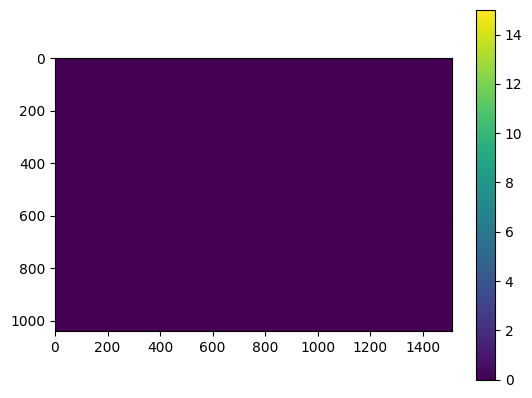

In [38]:
plt.imshow(output[0][0].cpu().detach().numpy())
plt.colorbar()

In [31]:
ids

['kidney_2_0000',
 'kidney_2_0001',
 'kidney_2_0002',
 'kidney_2_0003',
 'kidney_2_0004',
 'kidney_2_0005',
 'kidney_2_0006',
 'kidney_2_0007',
 'kidney_2_0008',
 'kidney_2_0009',
 'kidney_2_0010',
 'kidney_2_0011',
 'kidney_2_0012',
 'kidney_2_0013',
 'kidney_2_0014',
 'kidney_2_0015',
 'kidney_2_0016',
 'kidney_2_0017',
 'kidney_2_0018',
 'kidney_2_0019',
 'kidney_2_0020',
 'kidney_2_0021',
 'kidney_2_0022',
 'kidney_2_0023',
 'kidney_2_0024',
 'kidney_2_0025',
 'kidney_2_0026',
 'kidney_2_0027',
 'kidney_2_0028',
 'kidney_2_0029',
 'kidney_2_0030',
 'kidney_2_0031',
 'kidney_2_0032',
 'kidney_2_0033',
 'kidney_2_0034',
 'kidney_2_0035',
 'kidney_2_0036',
 'kidney_2_0037',
 'kidney_2_0038',
 'kidney_2_0039',
 'kidney_2_0040',
 'kidney_2_0041',
 'kidney_2_0042',
 'kidney_2_0043',
 'kidney_2_0044',
 'kidney_2_0045',
 'kidney_2_0046',
 'kidney_2_0047',
 'kidney_2_0048',
 'kidney_2_0049',
 'kidney_2_0050',
 'kidney_2_0051',
 'kidney_2_0052',
 'kidney_2_0053',
 'kidney_2_0054',
 'kidney_2

In [16]:
TH=[x.flatten().numpy() for x in output]
TH=np.concatenate(TH)
index = -int(len(TH)*CFG_Load.th_percentile)
TH:int=np.partition(TH,index)[index]
print(TH)

250


In [21]:
import pandas as pd

/tmp/ipykernel_20594/4080736814.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:
#ids = [list of files names (kidney_2_0000)]
# output = [list of single 3d tensor (torch.Size([2217, 1041, 1511])

In [48]:
img=cv2.imread("/root/data/train/kidney_2/images/0000.tif", cv2.IMREAD_GRAYSCALE)

submission_df=[]
for index in range(len(ids)):
    id=ids[index]
    i=0
    for x in output:
        if index>=len(x):
            index-=len(x)
            i+=1
        else:
            break
    mask_pred=(output[i][index]).numpy()
    mask_pred2 = to_original(mask_pred, img, image_size=1024)
    mask_pred = mask_pred2.copy()

    rle = rle_encode(mask_pred)

    submission_df.append(
        pd.DataFrame(data={
            'id' : id,
            'rle' : rle,
        }, index=[0])
    )

submission_df = pd.concat(submission_df)
submission_df.to_csv('submission_kidney_2_surface_dice.csv', index=False)
submission_df.head(6)

ValueError: could not broadcast input array from shape (12,13) into shape (12,)

In [43]:
output_np = output[0][0].numpy()

In [44]:
np.save("2d_segmentation", output_np)

In [99]:
output = np.load("/root/sennet-kaggle/src/util/2d_nn/2d_segmentation.npy")

In [11]:
output.shape

(2217, 1041, 1511)

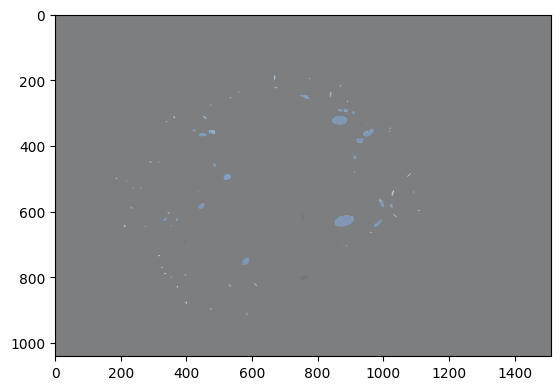

In [156]:
path = "/root/data/train/kidney_2/images/" # the path to the directory that contains the tiff files
file_list = os.listdir(path) # get the list of file names in the directory
lbls = "/root/data/train/kidney_2/labels/"
lbl_list = os.listdir(lbls)

i_1 = 1452
img = tiff.imread(path + file_list[i_1]) # read the 5th tiff file as a numpy array
lbl = tiff.imread(lbls + lbl_list[i_1])
gen = output[i_1,:,:]
#plt.imshow(img, cmap='grey')
plt.imshow(output[i_1,:,:], cmap="Blues")
plt.imshow(lbl, cmap="grey", alpha=0.5)


In [163]:
i_1 = 1200
bool = output[i_1,:,:]
bool = bool.astype(bool)
plt.imshow(bool, cmap="grey")

TypeError: Cannot construct a dtype from an array

In [184]:
thr = 0.501

#gen = gen.astype(np.float32) 
#gen = tc.from_numpy(gen)
lbl = tc.from_numpy(lbl)
img_c = gen.sigmoid()
lbl = lbl.sigmoid()
img_thr = (img_c > thr)
lbl_thr = (lbl > thr)
img_thr = img_thr.to(tc.float32)
lbl_thr = lbl_thr.to(tc.float32)
inter_n = (lbl_thr*img_thr).sum(dim=(-1,-2))
den_n = lbl_thr.sum(dim=(-1,-2)) + img_thr.sum(dim=(-1,-2))
dice_n = ((2*inter_n+0.001)/(den_n+0.001)).mean()


tensor(0.8894)

In [196]:
inter_new = (np.count_nonzero(img_c > 0.5) - (FN + FP))
inter_new

5488

In [189]:
test = img_thr - lbl_thr
FP = np.count_nonzero(test > 0)
test_FN = lbl_thr - img_thr
FN = np.count_nonzero(test_FN > 0)

In [192]:
print(inter_n), # true positive
print(FP), # False positive
print(FN) # False negative


tensor(5563.)
1309
75


In [ ]:
path = "/root/data/train/kidney_2/images/" # the path to the directory that contains the tiff files
file_list = os.listdir(path) # get the list of file names in the directory
lbls = "/root/data/train/kidney_2/labels/"
lbl_list = os.listdir(lbls)

i_1 = 1452
img = tiff.imread(path + file_list[i_1]) # read the 5th tiff file as a numpy array
lbl = tiff.imread(lbls + lbl_list[i_1])
gen = output[0][0][i_1,:,:]

thr = 0.501

#gen = gen.astype(np.float32) 
#gen = tc.from_numpy(gen)
lbl = tc.from_numpy(lbl)
img_c = gen.sigmoid()
lbl = lbl.sigmoid()
img_thr = (img_c > thr)
lbl_thr = (lbl > thr)
img_thr = img_thr.to(tc.float32)
lbl_thr = lbl_thr.to(tc.float32)
inter_n = (lbl_thr*img_thr).sum(dim=(-1,-2))
den_n = lbl_thr.sum(dim=(-1,-2)) + img_thr.sum(dim=(-1,-2))
dice_n = ((2*inter_n+0.001)/(den_n+0.001)).mean()

inter_new = (np.count_nonzero(img_c > 0.5) - (FN + FP))
inter_new

test = img_thr - lbl_thr
FP = np.count_nonzero(test > 0)
test_FN = lbl_thr - img_thr
FN = np.count_nonzero(test_FN > 0)

In [102]:
import numpy as np
import tifffile as tiff
import torch as tc

path = "/root/data/train/kidney_2/images/" # the path to the directory that contains the tiff files
file_list = os.listdir(path) # get the list of file names in the directory
lbls = "/root/data/train/kidney_2/labels/"
lbl_list = os.listdir(lbls)

thr = 0.75

inter_new_list = [] # a list to store the inter_new values for each file and label
FP_list = [] # a list to store the FP values for each file and label
FN_list = [] # a list to store the FN values for each file and label

for i in range(len(file_list)): # loop over all the file names and labels
    img = tiff.imread(path + file_list[i]) # works
    lbl = tiff.imread(lbls + lbl_list[i]) # works
    gen = output[i,:,:] # works

    #gen = gen.astype(np.float32) 
    #gen = tc.from_numpy(gen)
    lbl = tc.from_numpy(lbl)
    gen = tc.from_numpy(gen)
    img_c = gen.sigmoid()
    lbl = lbl.sigmoid()
    img_thr = (img_c > thr)
    lbl_thr = (lbl > thr)
    img_thr = img_thr.to(tc.float32)
    lbl_thr = lbl_thr.to(tc.float32)
    inter_n = (lbl_thr*img_thr).sum(dim=(-1,-2))
    den_n = lbl_thr.sum(dim=(-1,-2)) + img_thr.sum(dim=(-1,-2))
    dice_n = ((2*inter_n+0.001)/(den_n+0.001)).mean()

    test = img_thr - lbl_thr
    FP = np.count_nonzero(test > 0)
    FP_list.append(FP) # append the FP value to the list

    test_FN = lbl_thr - img_thr
    FN = np.count_nonzero(test_FN > 0)
    FN_list.append(FN) # append the FN value to the list

    inter_new = (np.count_nonzero(img_c > 0.75) - (FN + FP))
    inter_new_list.append(inter_new) # append the inter_new value to the list


print(inter_new_list) # print the list of inter_new values
print(FP_list) # print the list of FP values
print(FN_list) # print the list of FN values


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -2, -1, -1, -1, -4, -4, -12, -9, -5, -5, -7, -7, -9, -9, -10, -8, -11, -11, -3, -8, 2, 5, 14, 20, 14, 5, 5, 1, -8, 1, -4, -5, 9, 11, 9, 12, -7, -4, 13, 11, -2, 6, 16, 6, 22, 3, 2, 12, 16, 38, 31, 36, 41, 41, 31, 55, 43, 57, 64, 55, 44, 34, 76, 104, 68, 84, 91, 80, 80, 84, 97, 90, 93, 97, 106, 123, 121, 123, 128, 164, 235, 192, 176, 180, 192, 209, 210, 235, 241, 246, 249, 264, 257, 266, 253, 256, 250, 253, 288, 337, 364, 298, 263, 309, 334, 283, 343, 327, 321, 343, 332, 334, 349, 390, 397, 392, 376, 381, 374, 375, 357, 363, 388, 382, 408, 378, 372, 393, 496, 564, 590, 593, 510, 535, 551, 532, 497, 555, 538, 548, 597, 578, 617, 638, 657, 680, 689, 689, 700, 709, 738, 728, 749, 769, 736, 790, 781, 769, 762, 767, 773, 741, 754, 753, 761, 768, 762, 756, 748, 777, 797, 820, 808, 1023, 1140, 1

In [117]:
i = 1245
img = tiff.imread(path + file_list[i]) # read the i-th tiff file as a numpy array
lbl = tiff.imread(lbls + lbl_list[i]) # read the i-th label as a numpy array
gen = output[i,:,:] # get the i-th output from the gen array


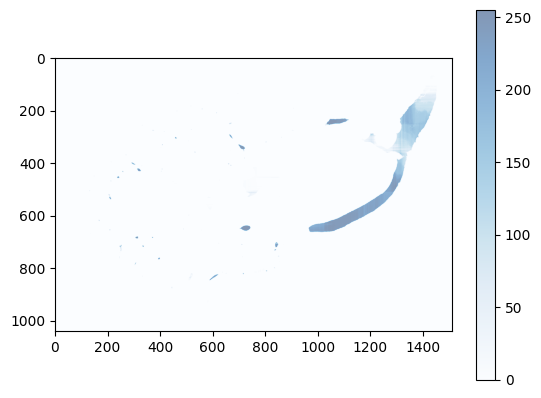

In [141]:
#plt.imshow(gen, cmap="grey")
plt.imshow(gen_c, cmap="Blues", alpha=0.5)
plt.colorbar()

In [144]:
gen_c = tc.from_numpy(gen)

In [146]:
gen_c = gen_c.type(tc.float)

In [148]:
gen_c = gen_c.sigmoid()

In [149]:
gen_c.min(), gen_c.max()

(tensor(0.5000), tensor(1.))

In [150]:
import math

In [151]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [155]:
sigmoid(-1)

0.2689414213699951

In [62]:
thr = 0.501

lbl = tc.from_numpy(lbl)
gen = tc.from_numpy(gen)
img_c = gen.sigmoid()
lbl = lbl.sigmoid()
img_thr = (img_c > thr)
lbl_thr = (lbl > thr)
img_thr = img_thr.to(tc.float32)
lbl_thr = lbl_thr.to(tc.float32)
inter_n = (lbl_thr*img_thr).sum(dim=(-1,-2))
den_n = lbl_thr.sum(dim=(-1,-2)) + img_thr.sum(dim=(-1,-2))
dice_n = ((2*inter_n+0.001)/(den_n+0.001)).mean()



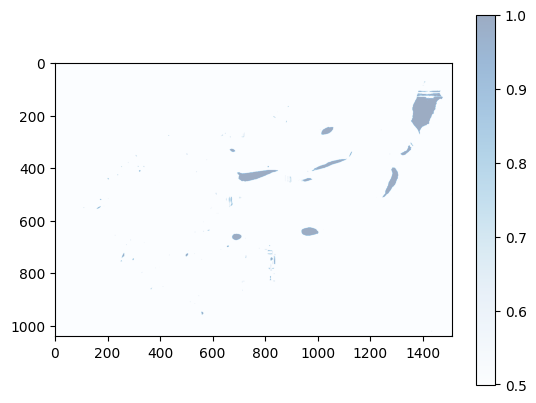

In [79]:
#plt.imshow(gen, cmap='grey')
plt.imshow(img_c, cmap='Blues', alpha=0.4)
#plt.imshow(img_thr, cmap='Blues', alpha=0.4)
#plt.imshow(lbl_thr, cmap="Blues", alpha=0.4)
plt.colorbar()

In [ ]:


test = img_thr - lbl_thr
FP = np.count_nonzero(test > 0)
#FP_list.append(FP) # append the FP value to the list

test_FN = lbl_thr - img_thr
FN = np.count_nonzero(test_FN > 0)
#FN_list.append(FN) # append the FN value to the list

inter_new = (np.count_nonzero(img_c > 0.5) - (FN + FP))
#inter_new_list.append(inter_new) # append the inter_new value to the list

In [103]:
sum1 = sum(inter_new_list) 
sum1

13274439

In [104]:
sum2 = sum(FP_list)
sum2

4340388

In [105]:
sum3 = sum(FN_list)
sum3

507035